In [9]:
%matplotlib inline

import json
import numpy as np
import os
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from IPython.display import display
from sklearn.model_selection import ParameterGrid
from tqdm.auto import tqdm
from ucsc_genomes_downloader import Genome

In [10]:
genome = Genome("hg38")
window_size = 256

In [11]:
values = np.logspace(-2, 1.7, 15)
param_grid = {"min_active_tpm_value": values, 
              "max_inactive_tpm_value": values}

In [12]:
def get_total(param_grid):
    res = 0
    for params in ParameterGrid(param_grid):

        if params["max_inactive_tpm_value"] > params["min_active_tpm_value"]:
            continue

        res += 1

    return res

In [16]:
def evaluate_tpms(param_grid, cell_line):
    results = {
        "enhancers": dict(),
        "promoters": dict()
    }

    j = 0

    for params in tqdm(
        ParameterGrid(param_grid),
        desc="Running tasks",
        total=get_total(param_grid),
        leave=False
    ):

        starttime = timeit.default_timer()
        
        if params["max_inactive_tpm_value"] > params["min_active_tpm_value"]:
            continue

        if os.path.isfile(f'imbalance/class_imbalance_{cell_line}.json'):
            with open(f'imbalance/class_imbalance_{cell_line}.json') as f:
                results = json.load(f)

        fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
        axs = axes.ravel()
        i = 0

        if (str(j) in results["enhancers"]) & (str(j) in results["promoters"]):
            print(f"skipping {j} in {cell_line}, already done")
            j += 1
            continue
            
        print("The time difference to load files is :", timeit.default_timer() - starttime)

        for region in ("enhancers", "promoters"):

            starttime = timeit.default_timer()
            
            if region == "enhancers":
                
                X, y = active_enhancers_vs_inactive_enhancers(
                    cell_line=cell_line,
                    window_size=window_size,
                    binarize=True,
                    **params
                )
            else:
                X, y = active_promoters_vs_inactive_promoters(
                    cell_line=cell_line,
                    window_size=window_size,
                    binarize=True,
                    **params
                )
                
            print("The time difference after loading task is :", timeit.default_timer() - starttime)

            ax = axs[i]
            i += 1

            vc = y.value_counts(normalize=True)
            vc_n = y.value_counts()
            
            vc_1 = vc[1] if len(vc) > 1 else np.float64(0.0)
            vc_n_1 = vc_n[1] if len(vc_n) > 1 else np.float64(0.0)

            y.astype(int).hist(ax=ax, bins=3)
            ax.set(
                xlabel="Labels", 
                ylabel="Number of examples",
                title=f"Classes count in {cell_line} {region} regions\n" + 
                f"max_inactive: {round(params['max_inactive_tpm_value'], 5)}; " + 
                f"min_active: {round(params['min_active_tpm_value'], 5)}\n" +
                f"pos: {vc_1.round(5)}; " +
                f"neg: {vc[0].round(5)}"
            )
            ax.grid(False)
            if vc_n_1 > 0:
                ax.set_xticks([0.15, 0.85])
                ax.set_xticklabels(["Negative", "Positive"])
            else:
                ax.set_xticks([0.05])
                ax.set_xticklabels(["Negative"])

            results[region][j] = (params, vc[0], vc_1, vc_n[0].item(), vc_n_1.item())

            print(cell_line)
            print(params)
            print(y.value_counts())
            
            print("The time difference after computation is :", timeit.default_timer() - starttime)

        fig.savefig(f"imbalance/classes_count_{cell_line}_{j}.png")

        with open(f'imbalance/class_imbalance_{cell_line}.json', 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=4)

        j += 1
        #display(fig)

    return results

In [17]:
def plot_heatmaps(results, values, cell_line):
    for region in results:
        df_res = pd.DataFrame({}, index=values.round(5), columns=values.round(5))

        for (d, neg, pos, nneg, npos) in results[region].values():
            df = pd.DataFrame([pos], 
                              index=[np.round(d['max_inactive_tpm_value'], 5)], 
                              columns=[np.round(d['min_active_tpm_value'], 5)])
            df_res.update(df)

        with sns.axes_style("white"):
            f, ax = plt.subplots(figsize=(15, 7))
            ax = sns.heatmap(df_res.fillna(np.nan), annot=True)
            plt.title(f"Heatmap of positive examples ratio in {region} region ({cell_line})", fontsize=22, y=1.05,  weight='bold')
            plt.ylabel('max_inactive_tpm_value', fontsize=15) 
            plt.xlabel('min_active_tpm_value', fontsize=15)
            plt.savefig(f"imbalance/heatmap_{cell_line}_{region}.png")
            display(plt.show())

skipping 0 in A549, already done
skipping 1 in A549, already done
skipping 2 in A549, already done
skipping 3 in A549, already done
skipping 4 in A549, already done
skipping 5 in A549, already done
skipping 6 in A549, already done
skipping 7 in A549, already done
skipping 8 in A549, already done
skipping 9 in A549, already done
skipping 10 in A549, already done
skipping 11 in A549, already done
skipping 12 in A549, already done
skipping 13 in A549, already done
skipping 14 in A549, already done
skipping 15 in A549, already done
skipping 16 in A549, already done
skipping 17 in A549, already done
skipping 18 in A549, already done
skipping 19 in A549, already done
skipping 20 in A549, already done
skipping 21 in A549, already done
skipping 22 in A549, already done
skipping 23 in A549, already done
skipping 24 in A549, already done
skipping 25 in A549, already done

<ipython-input-16-46ac61b40642>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(10, 5))



skipping 26 in A549, already done
skipping 27 in A549, already done
skipping 28 in A549, already done
skipping 29 in A549, already done
skipping 30 in A549, already done
skipping 31 in A549, already done
skipping 32 in A549, already done
skipping 33 in A549, already done
skipping 34 in A549, already done
skipping 35 in A549, already done
skipping 36 in A549, already done
skipping 37 in A549, already done
skipping 38 in A549, already done
skipping 39 in A549, already done
skipping 40 in A549, already done
skipping 41 in A549, already done
skipping 42 in A549, already done
skipping 43 in A549, already done
skipping 44 in A549, already done
skipping 45 in A549, already done
skipping 46 in A549, already done
skipping 47 in A549, already done
skipping 48 in A549, already done
skipping 49 in A549, already done
skipping 50 in A549, already done
skipping 51 in A549, already done
skipping 52 in A549, already done
skipping 53 in A549, already done
skipping 54 in A549, already done
skipping 55 i

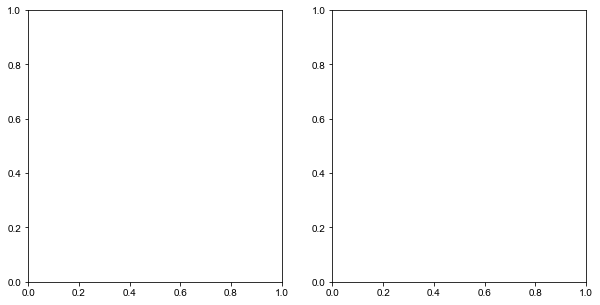

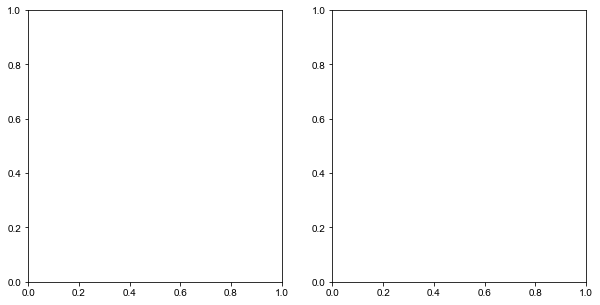

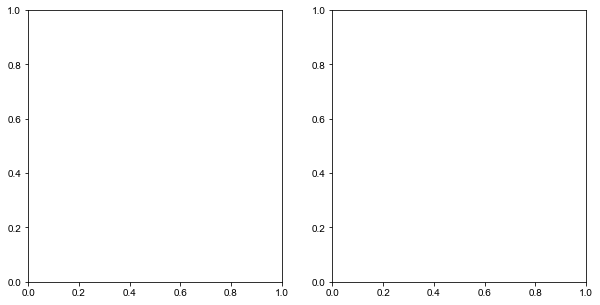

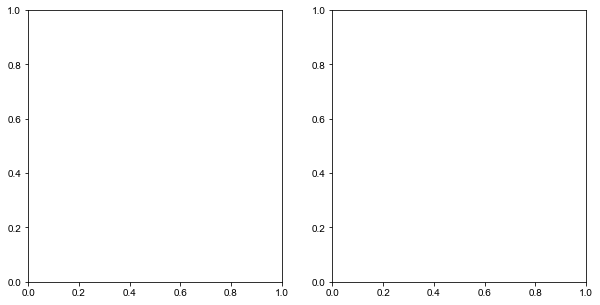

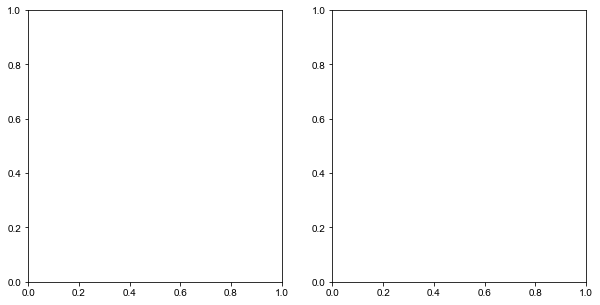

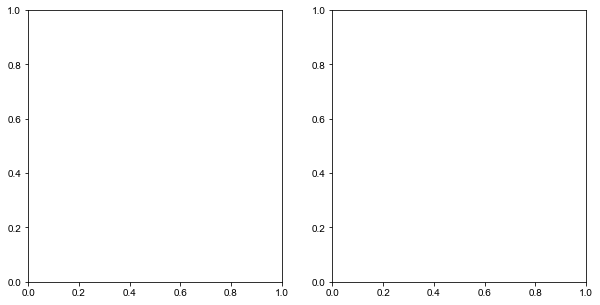

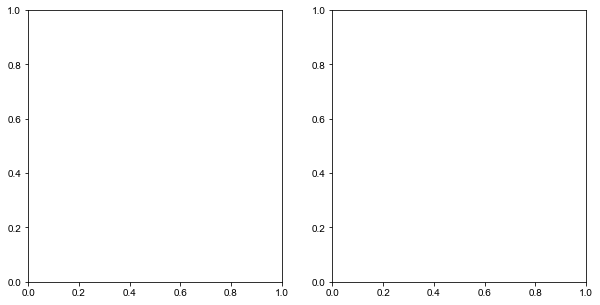

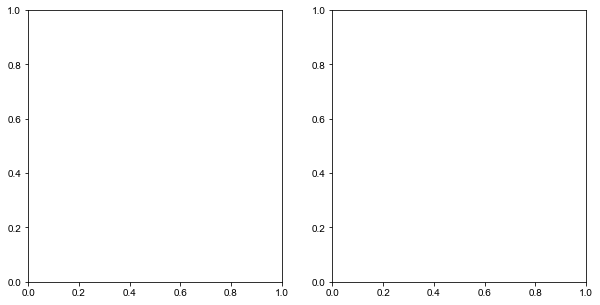

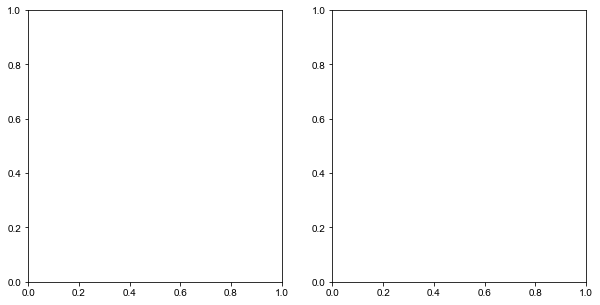

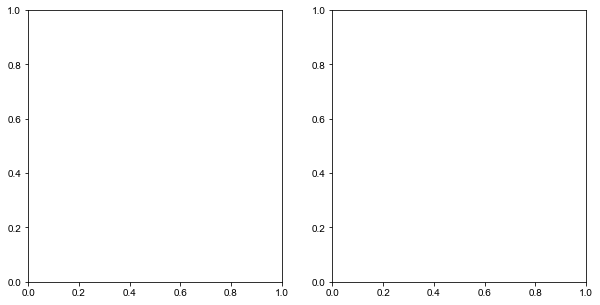

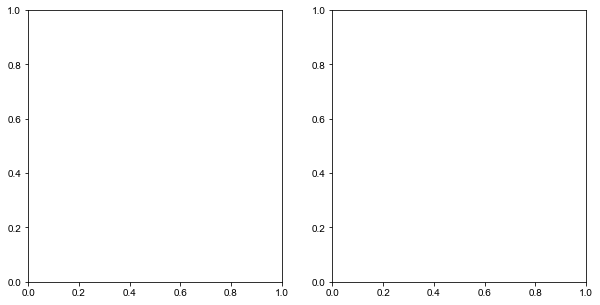

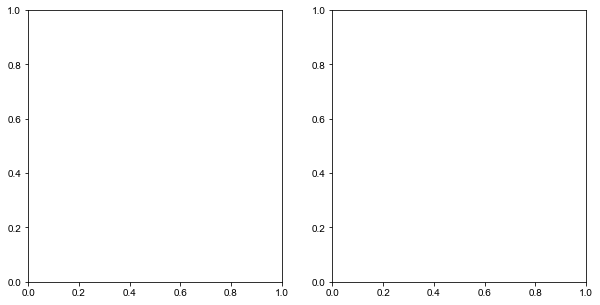

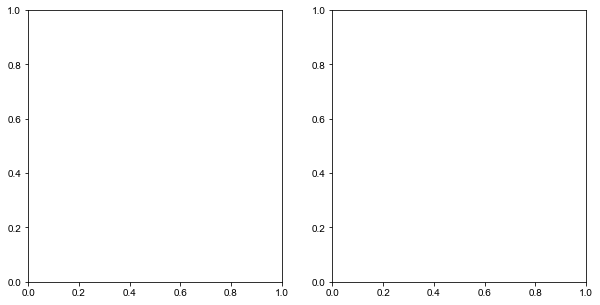

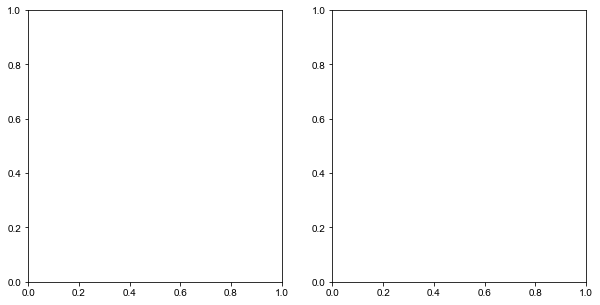

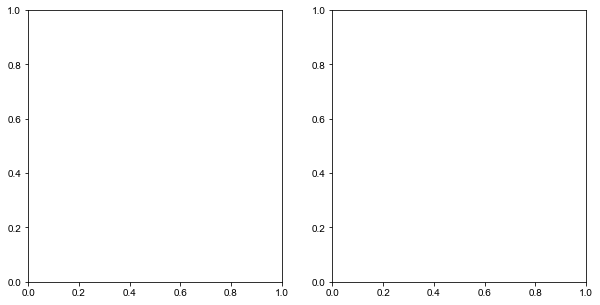

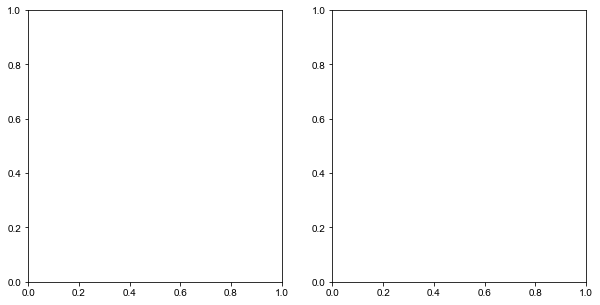

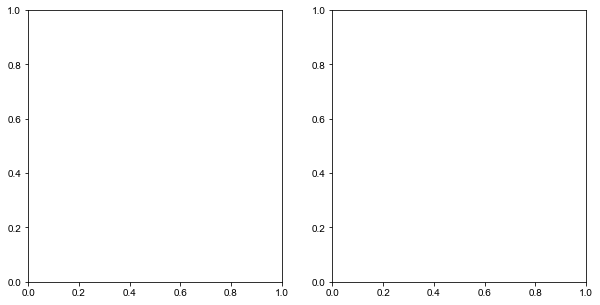

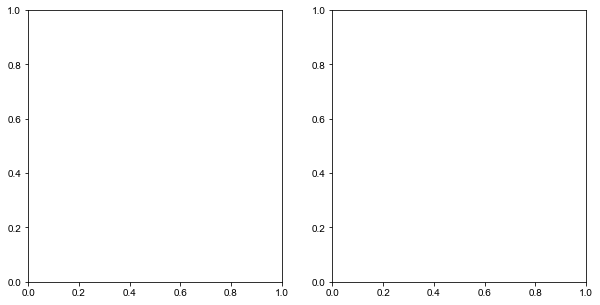

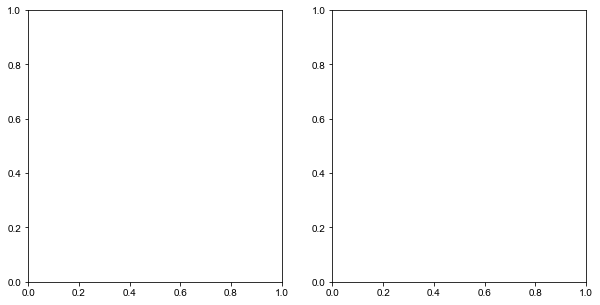

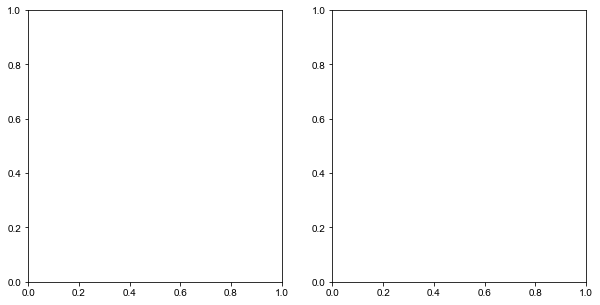

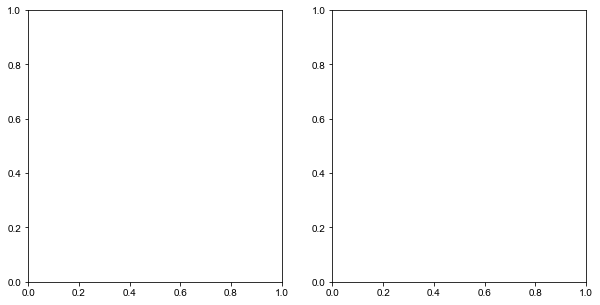

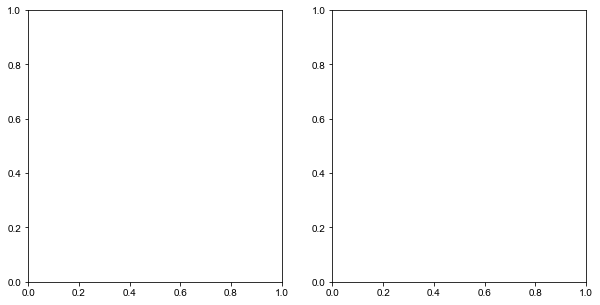

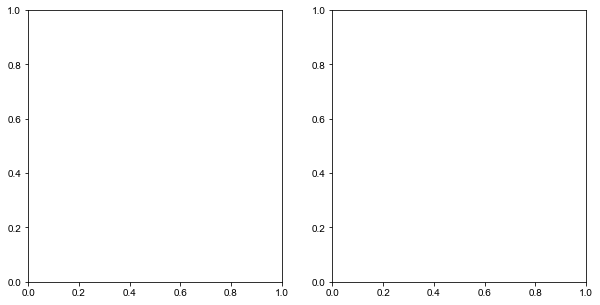

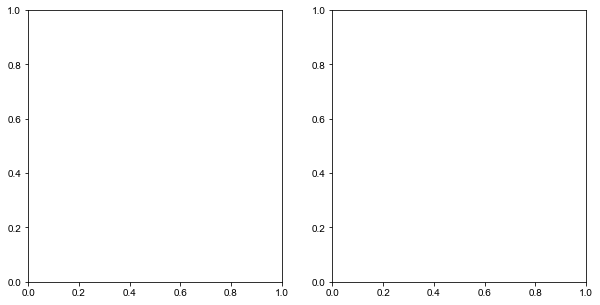

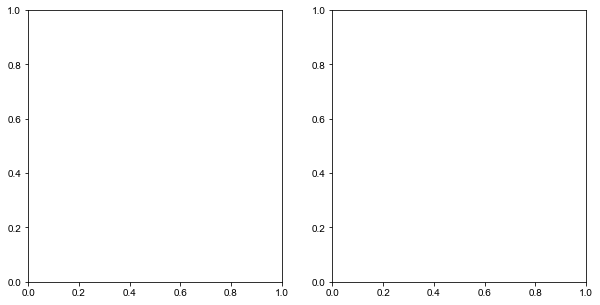

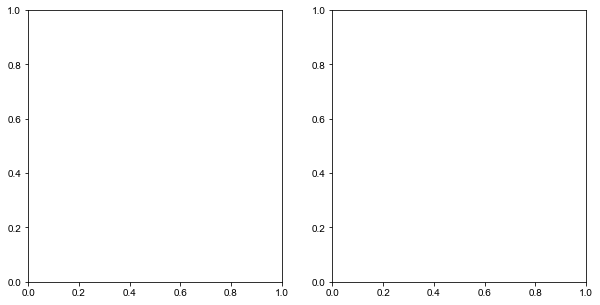

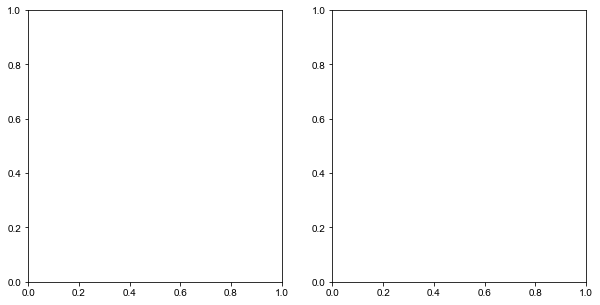

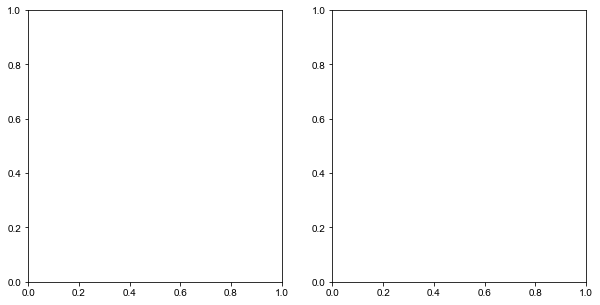

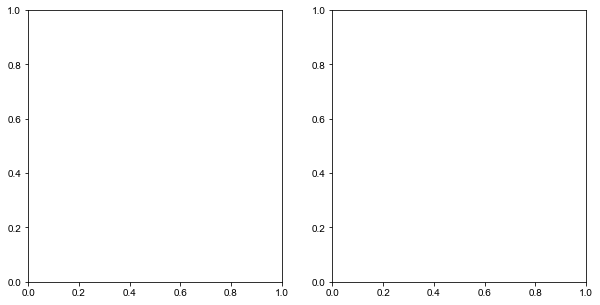

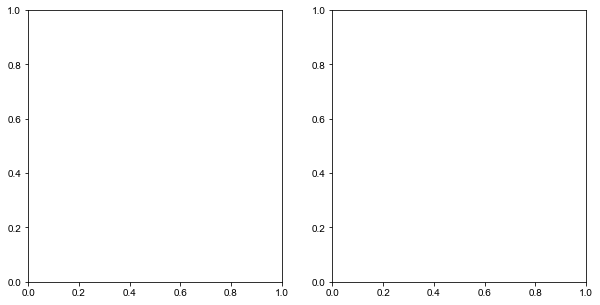

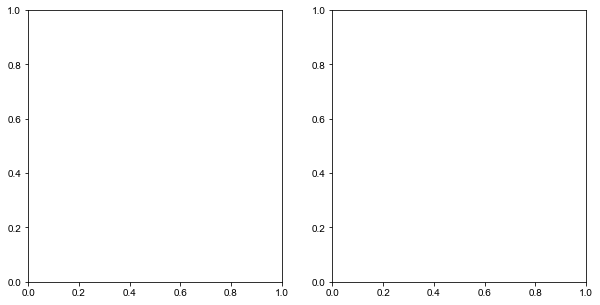

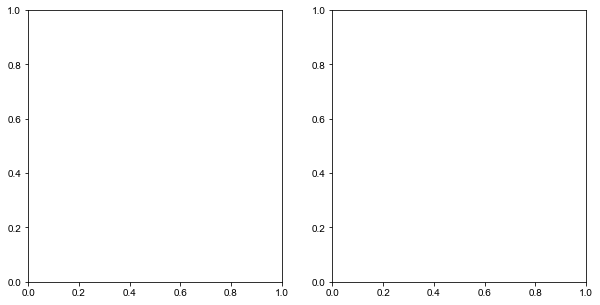

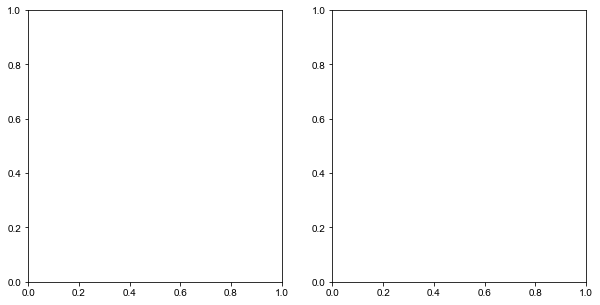

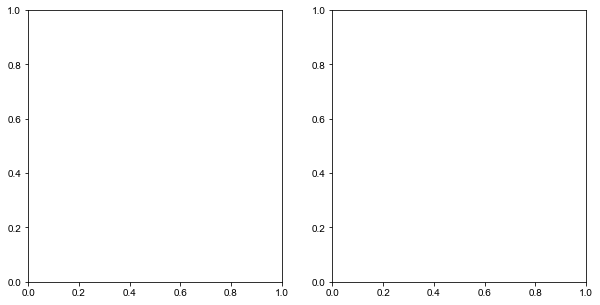

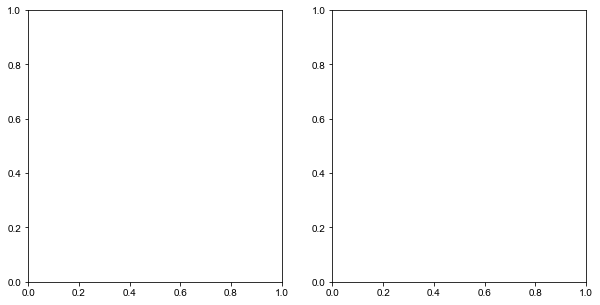

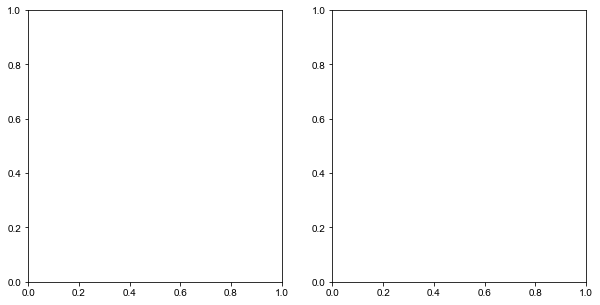

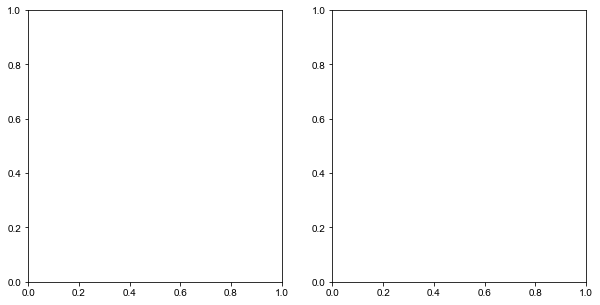

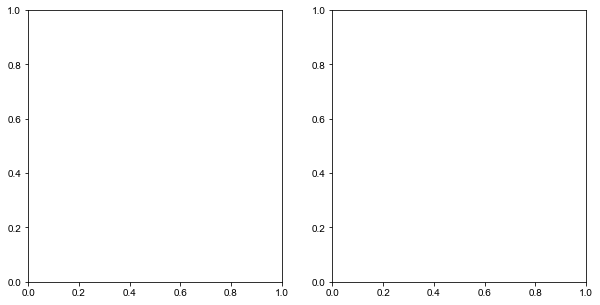

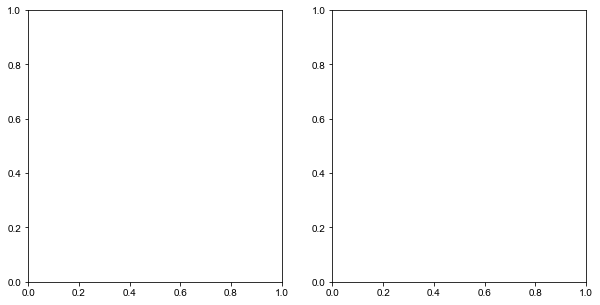

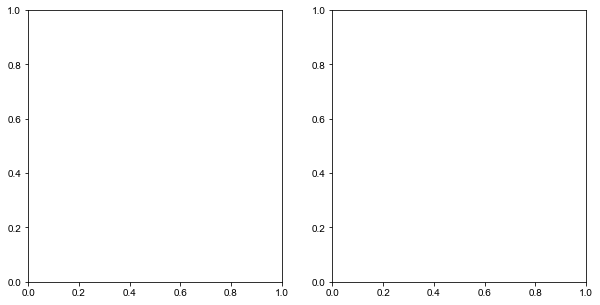

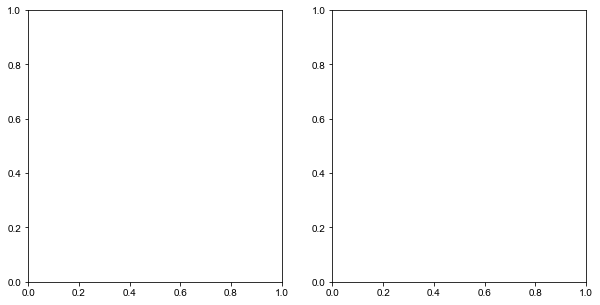

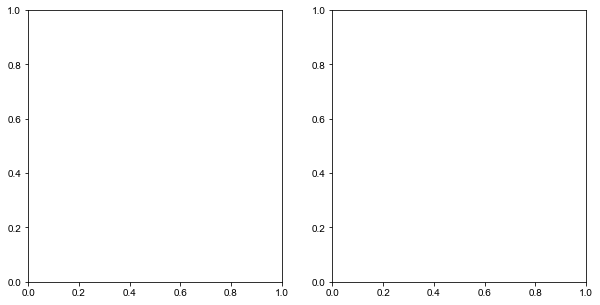

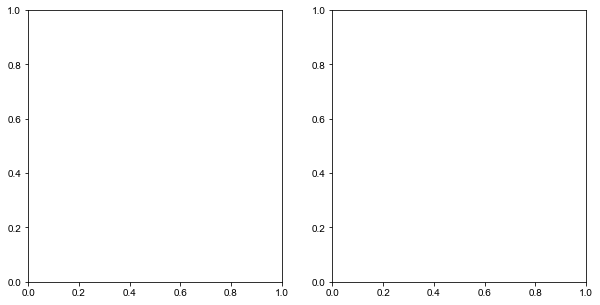

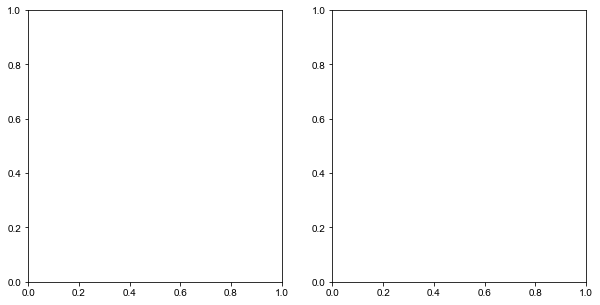

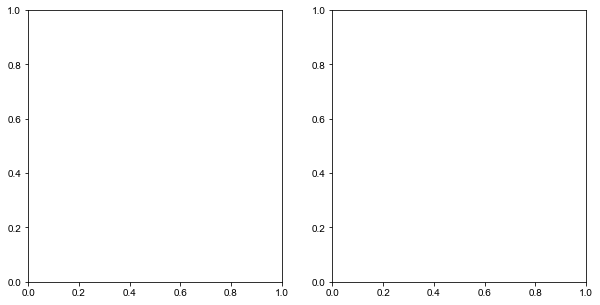

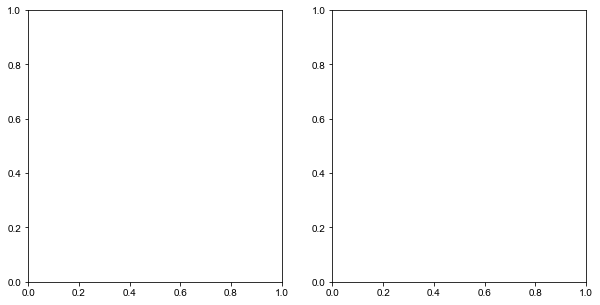

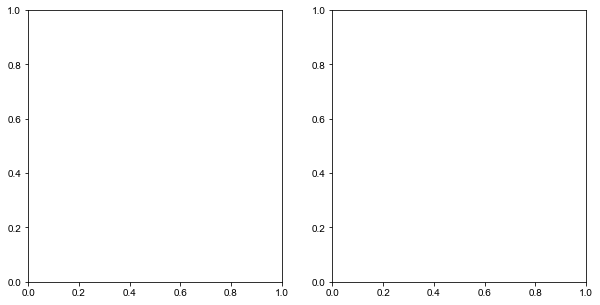

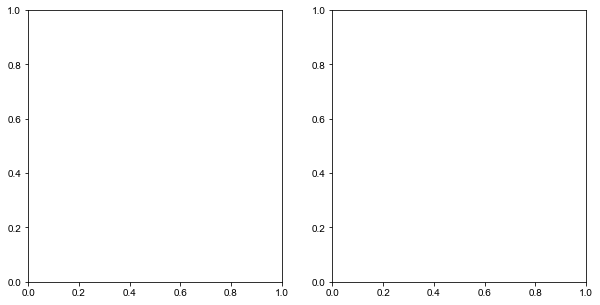

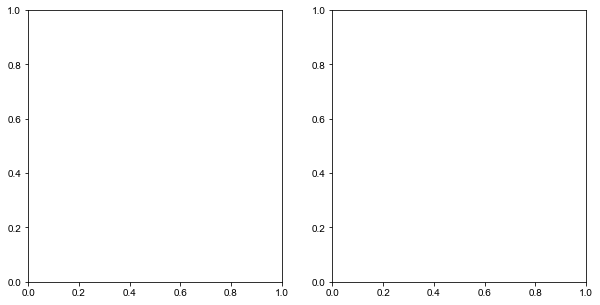

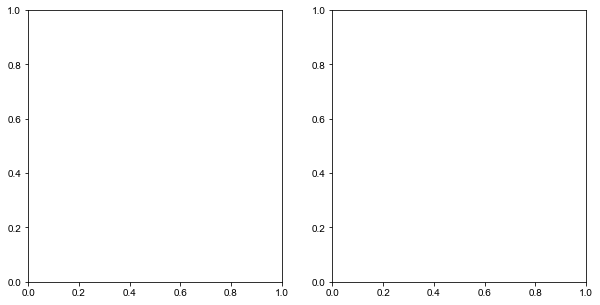

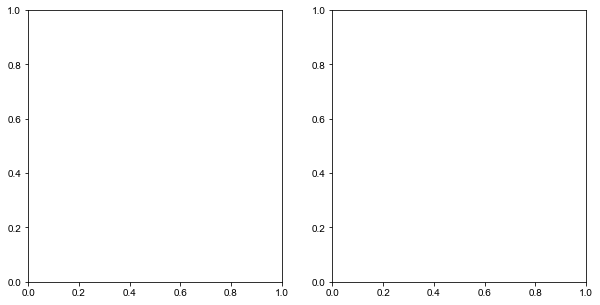

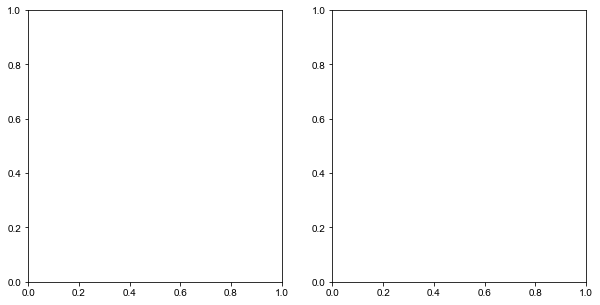

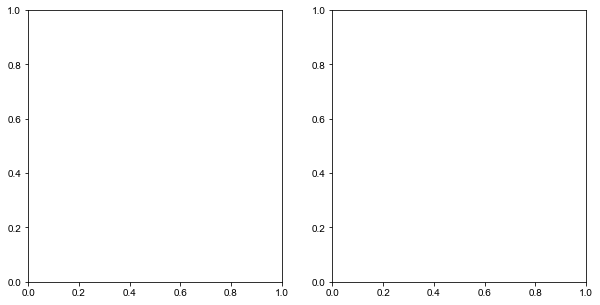

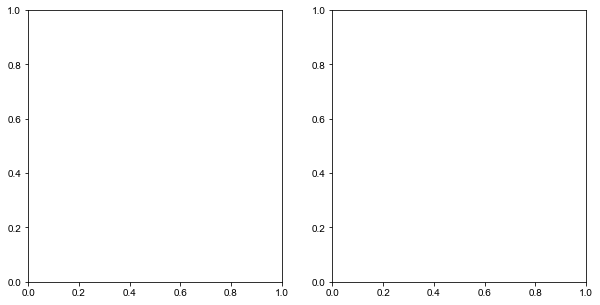

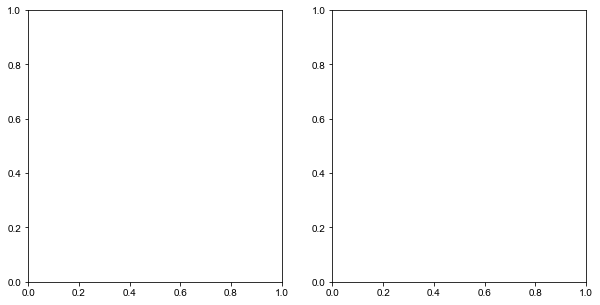

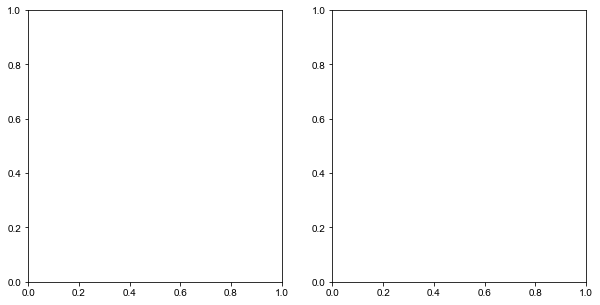

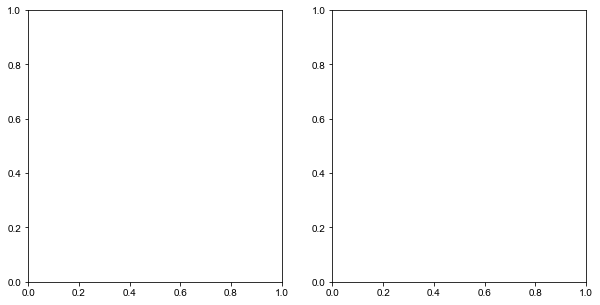

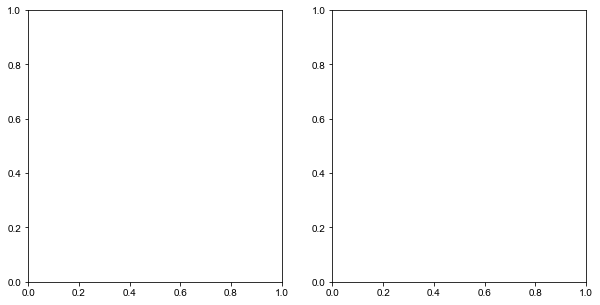

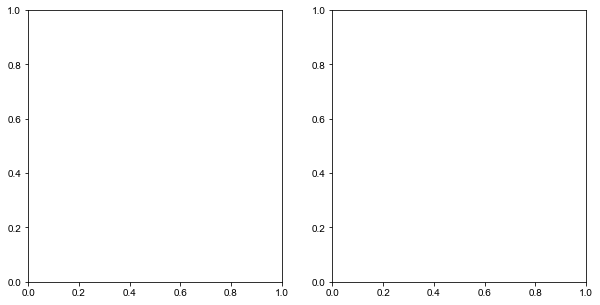

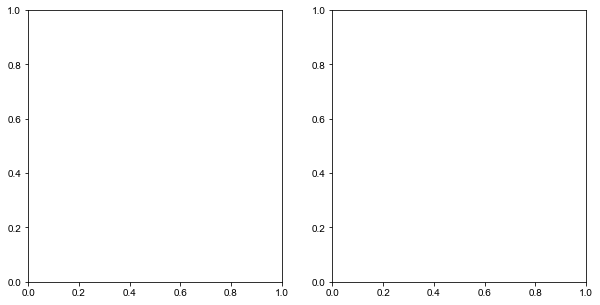

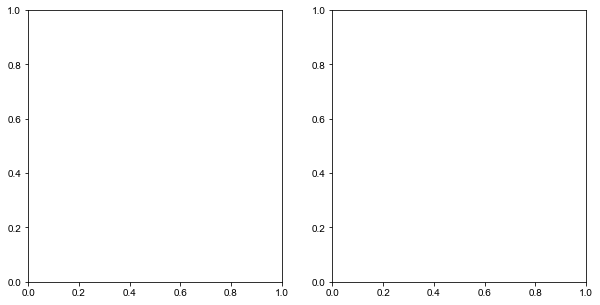

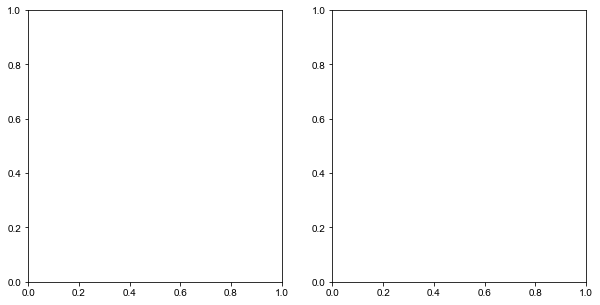

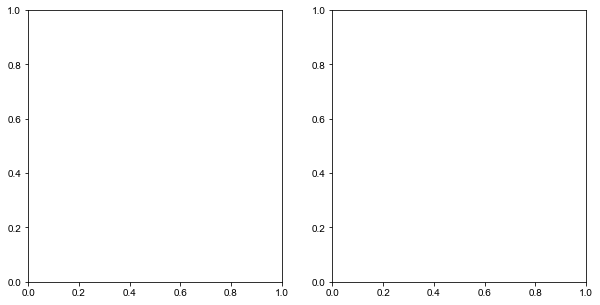

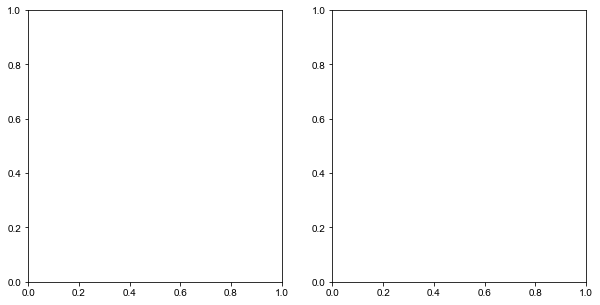

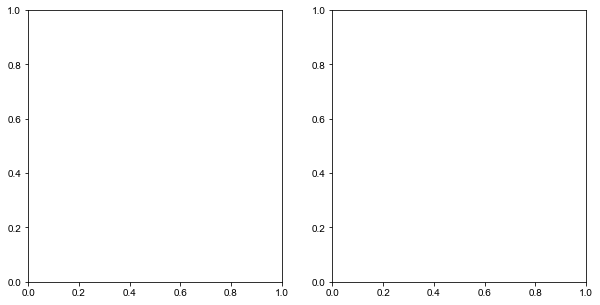

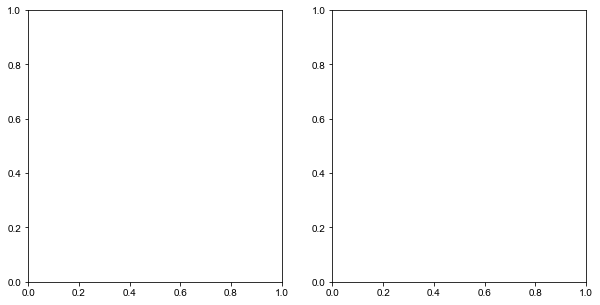

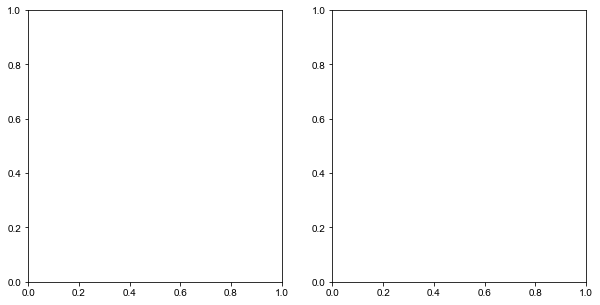

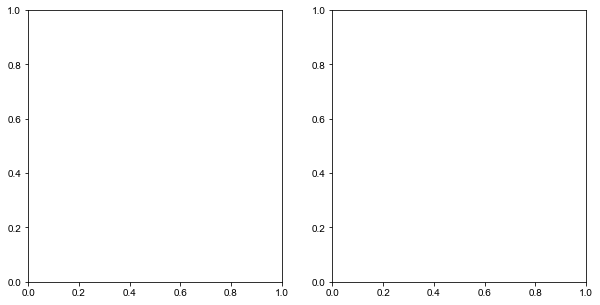

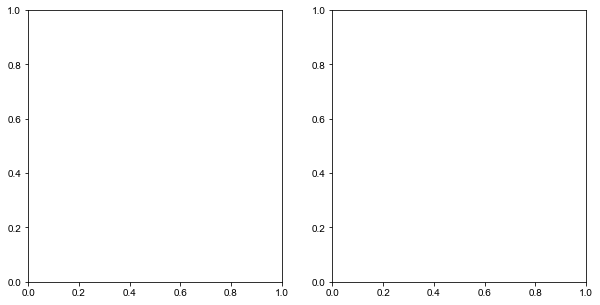

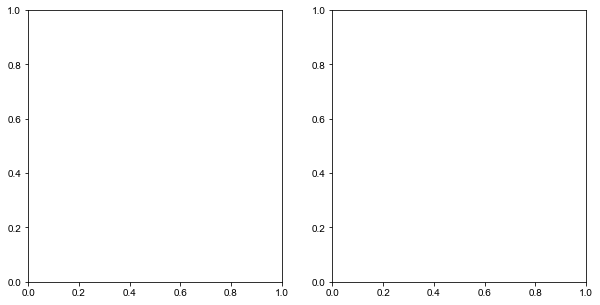

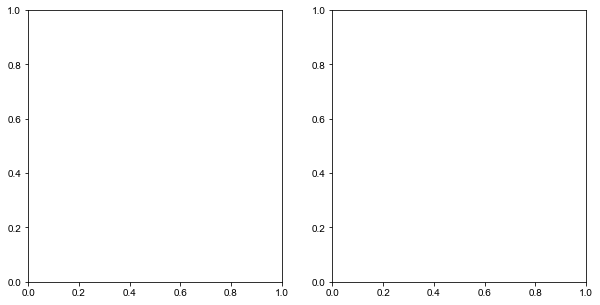

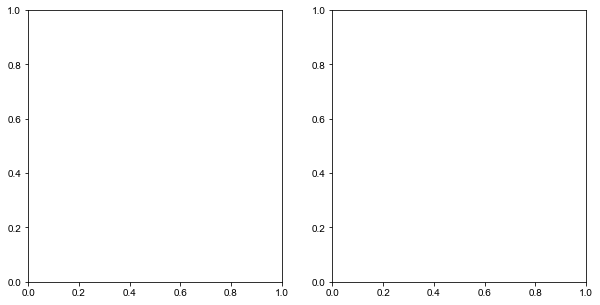

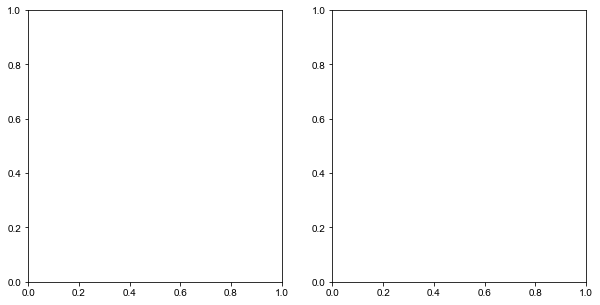

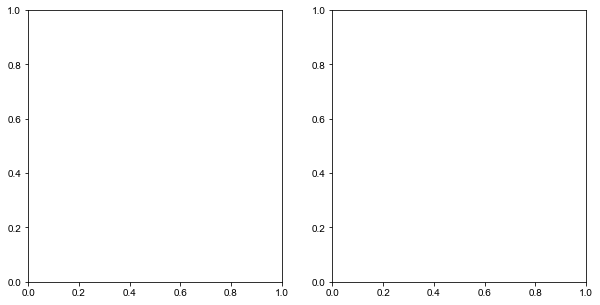

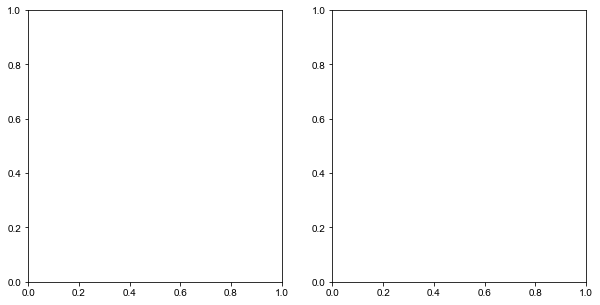

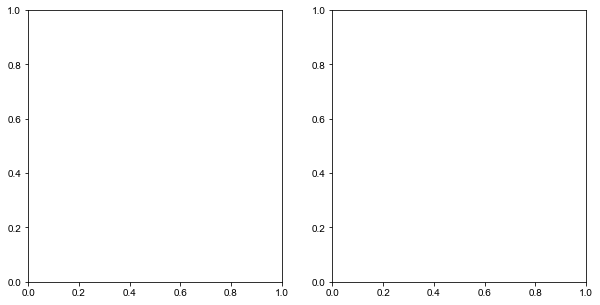

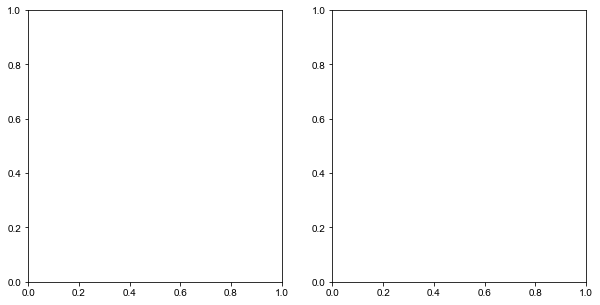

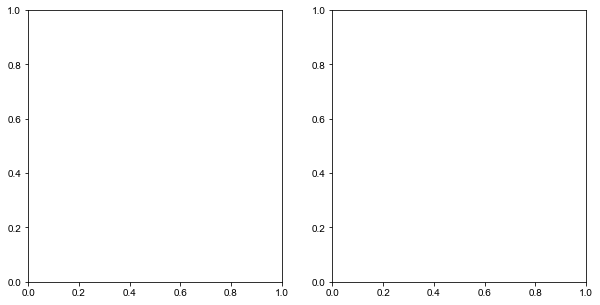

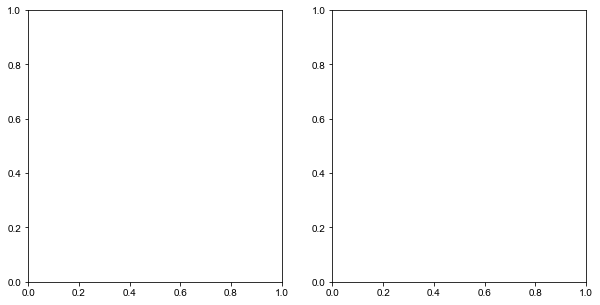

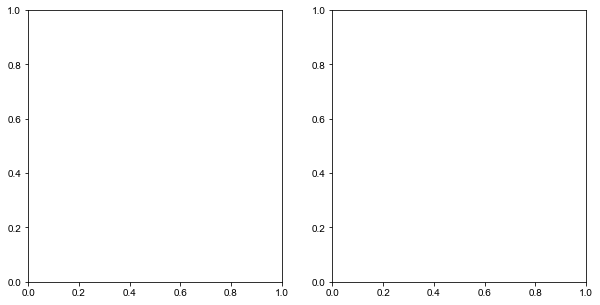

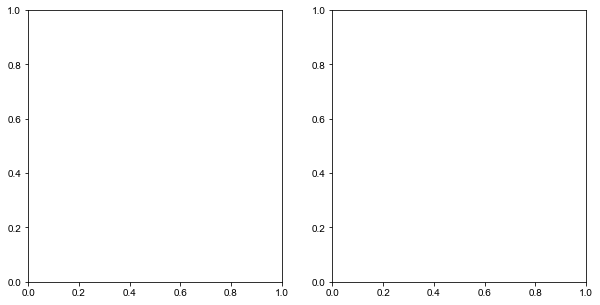

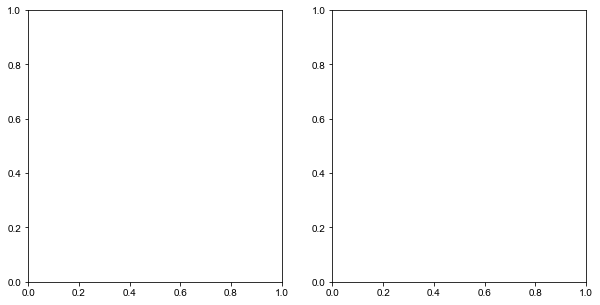

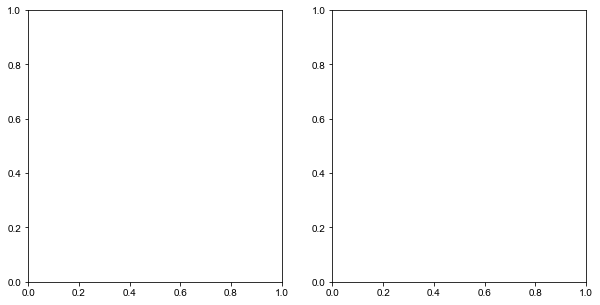

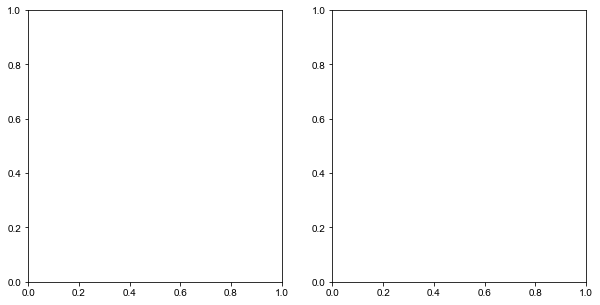

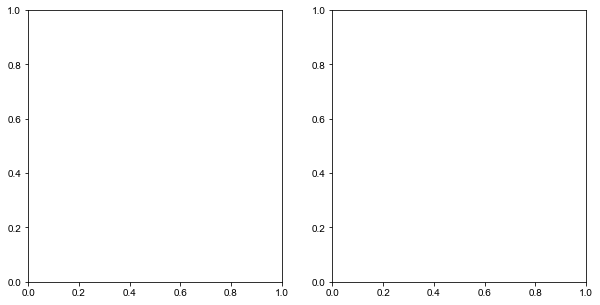

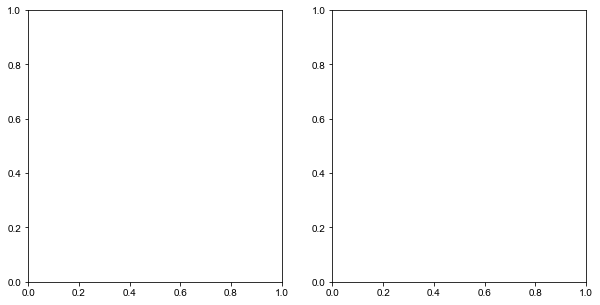

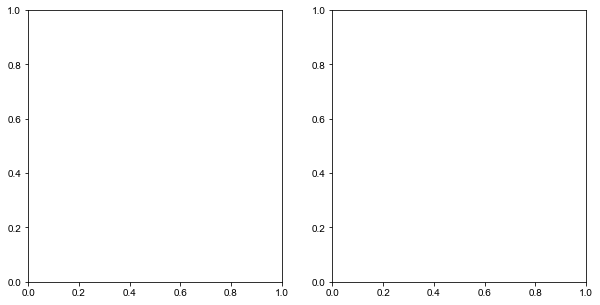

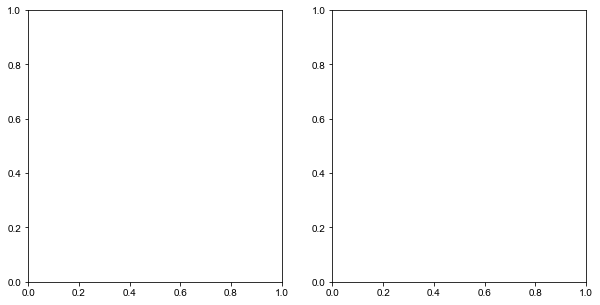

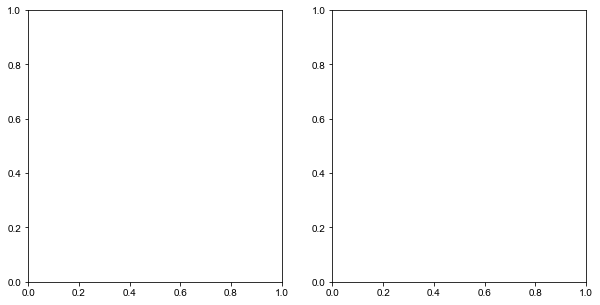

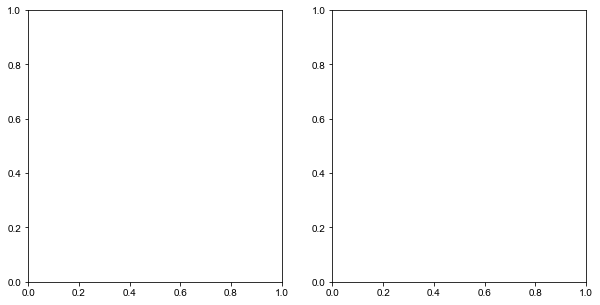

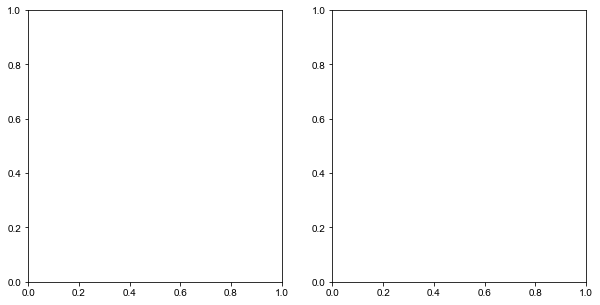

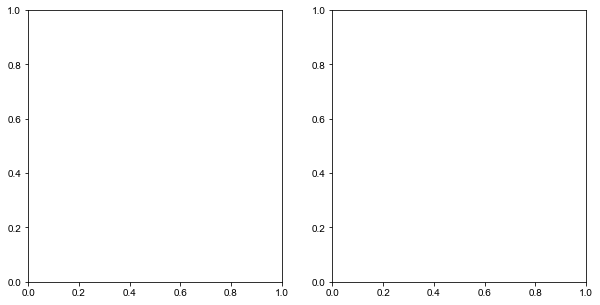

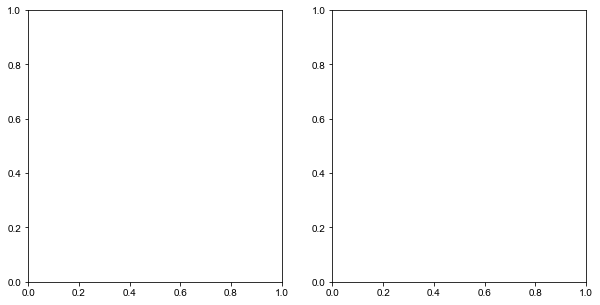

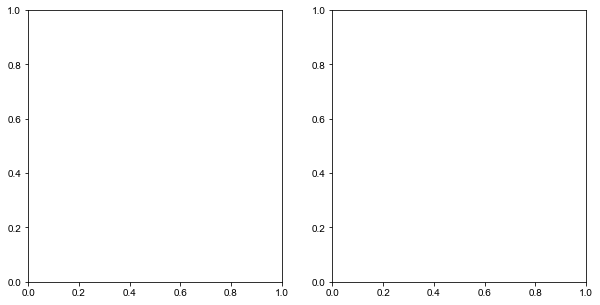

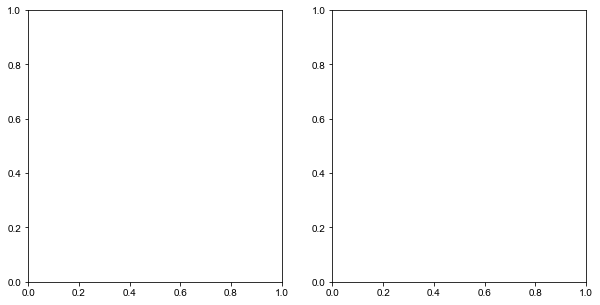

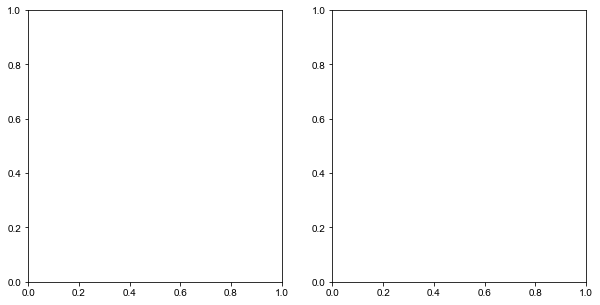

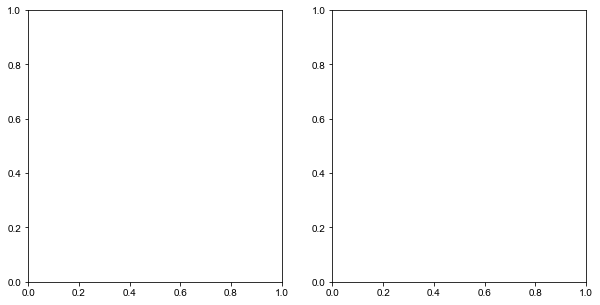

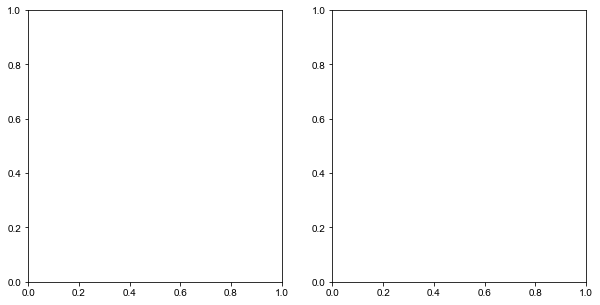

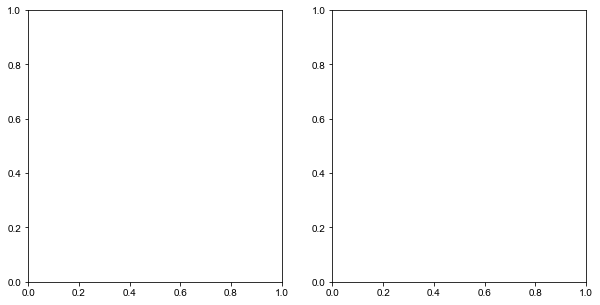

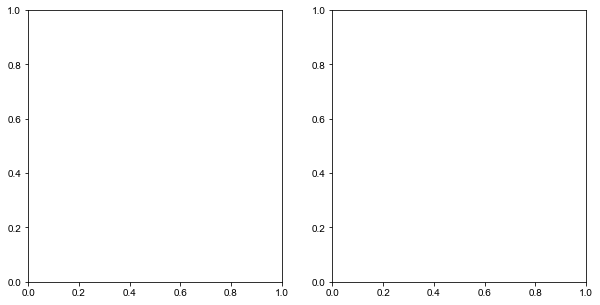

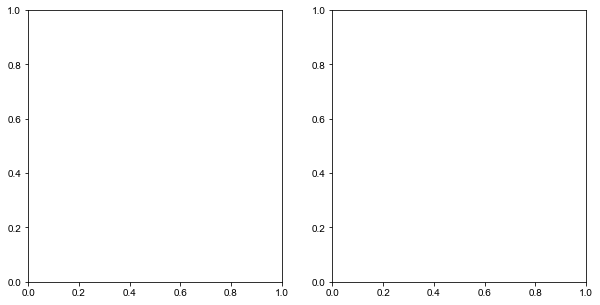

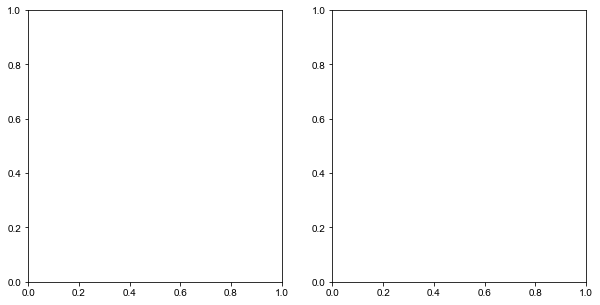

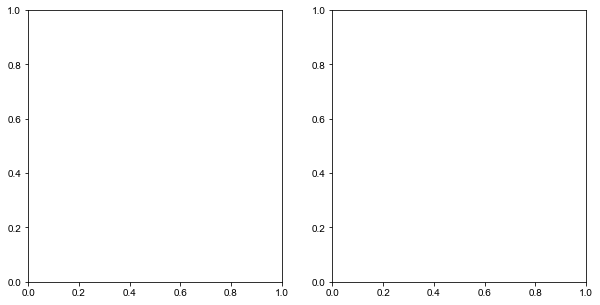

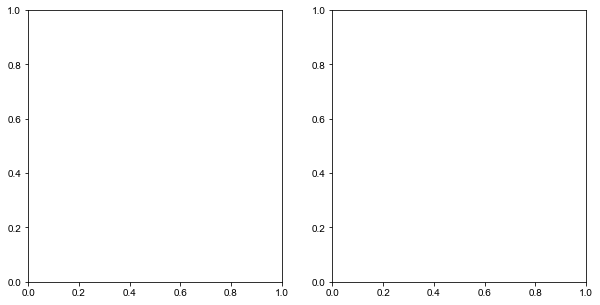

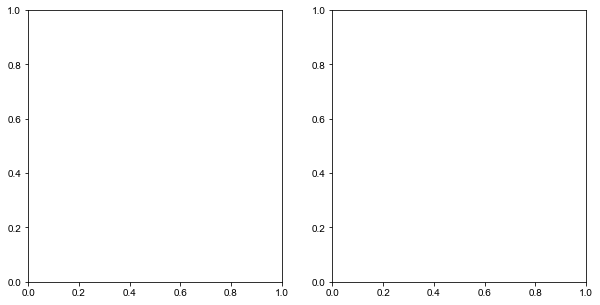

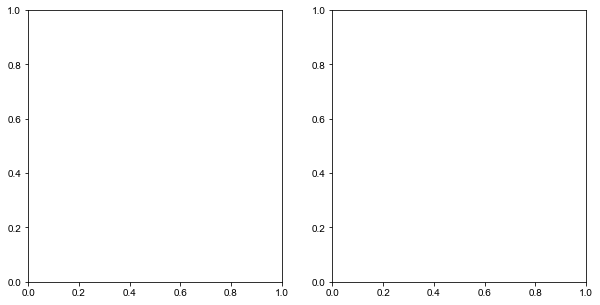

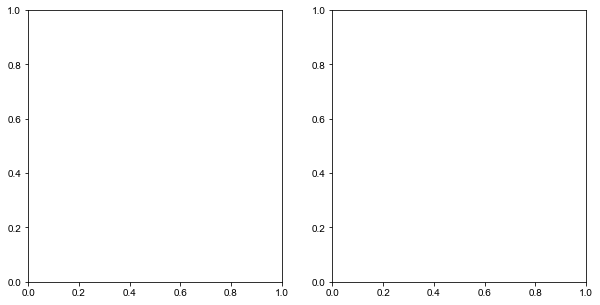

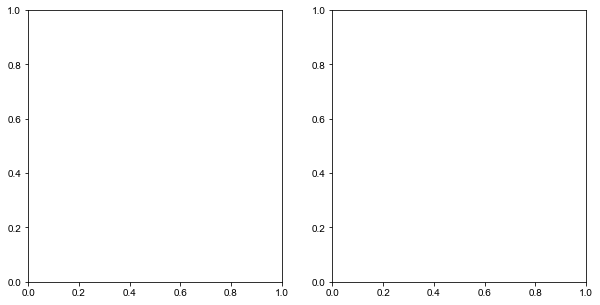

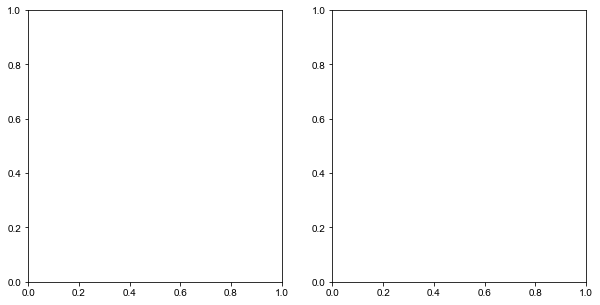

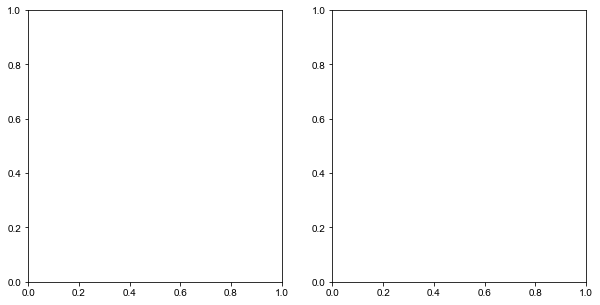

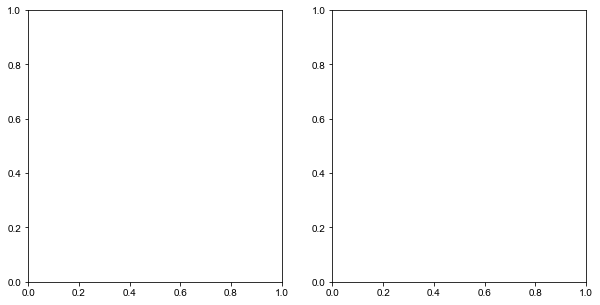

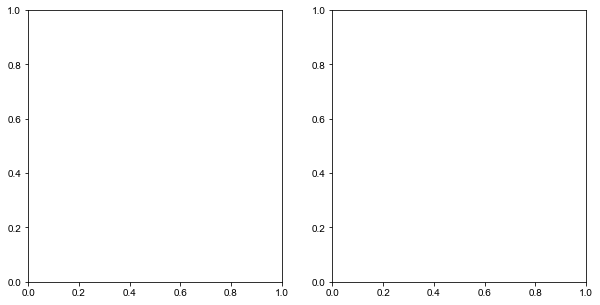

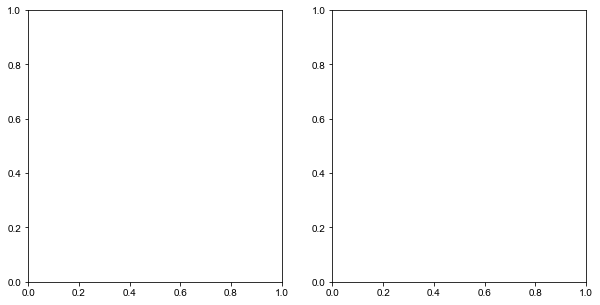

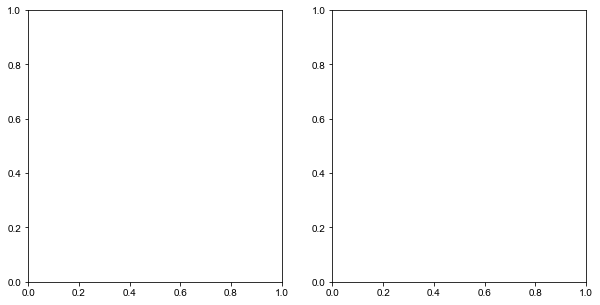

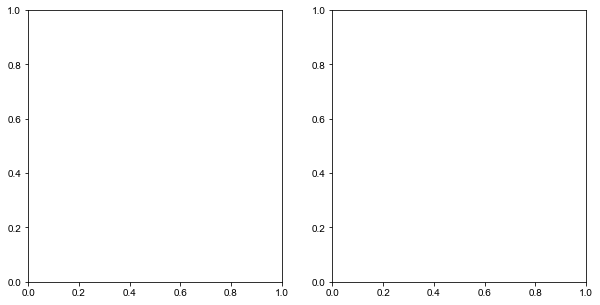

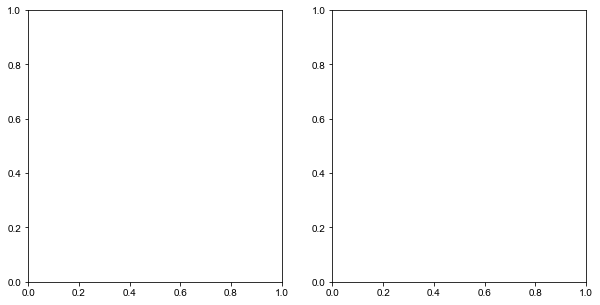

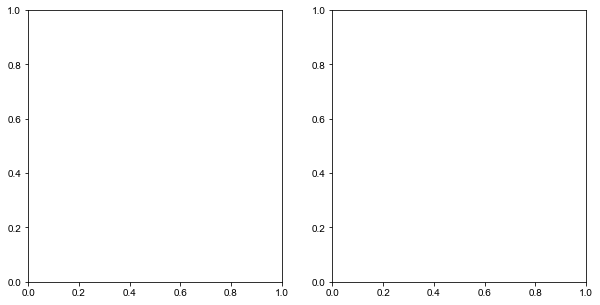

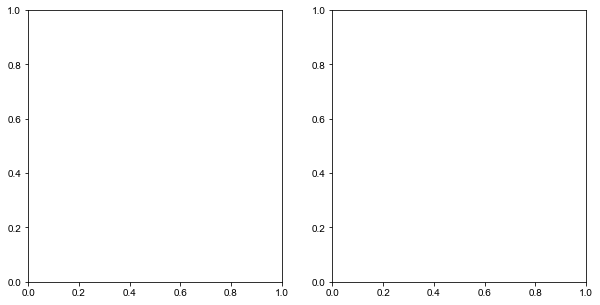

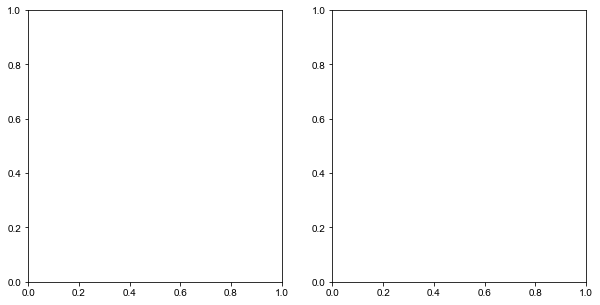

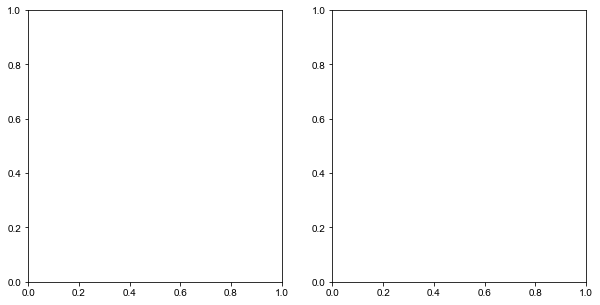

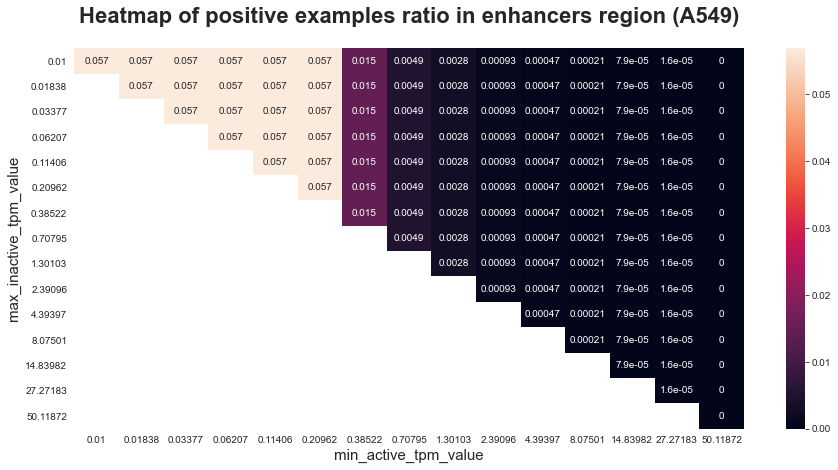

None

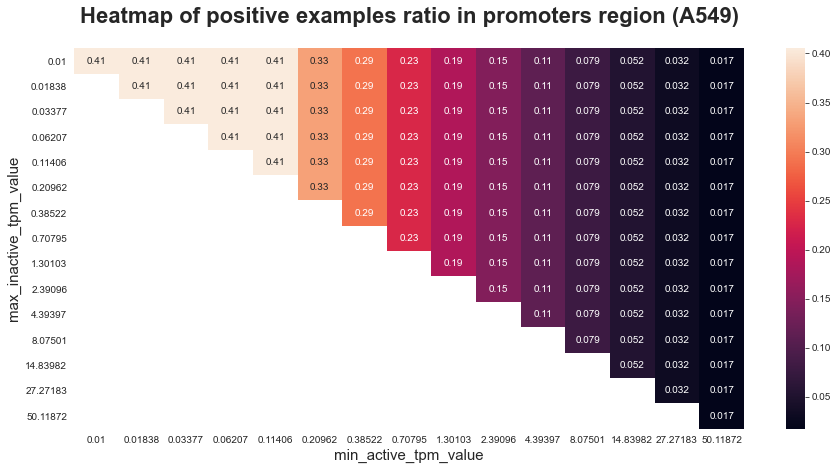

None

skipping 0 in GM12878, already done
skipping 1 in GM12878, already done
skipping 2 in GM12878, already done
skipping 3 in GM12878, already done
skipping 4 in GM12878, already done
skipping 5 in GM12878, already done
skipping 6 in GM12878, already done
skipping 7 in GM12878, already done
skipping 8 in GM12878, already done
skipping 9 in GM12878, already done
skipping 10 in GM12878, already done
skipping 11 in GM12878, already done
skipping 12 in GM12878, already done
skipping 13 in GM12878, already done
skipping 14 in GM12878, already done
skipping 15 in GM12878, already done
skipping 16 in GM12878, already done
skipping 17 in GM12878, already done
skipping 18 in GM12878, already done
skipping 19 in GM12878, already done
skipping 20 in GM12878, already done
skipping 21 in GM12878, already done
skipping 22 in GM12878, already done
skipping 23 in GM12878, already done
skipping 24 in GM12878, already done
skipping 25 in GM12878, already done
skipping 26 in GM12878, already done
skipping 27

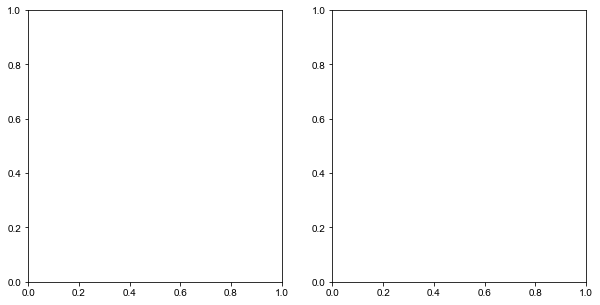

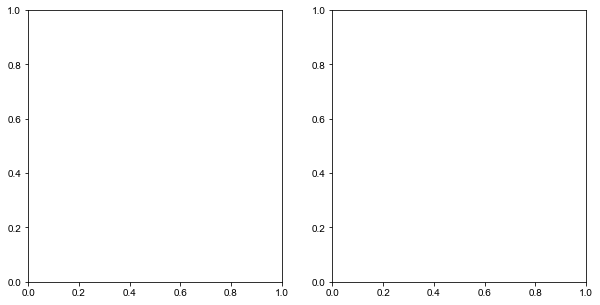

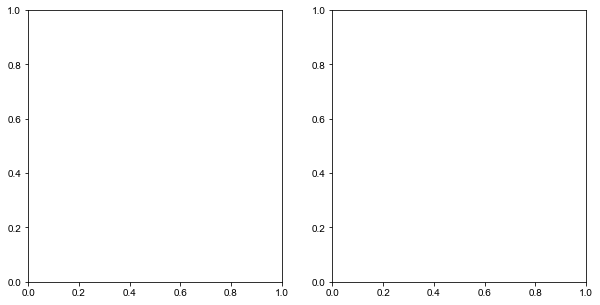

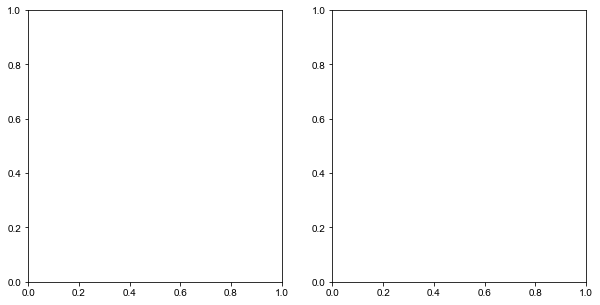

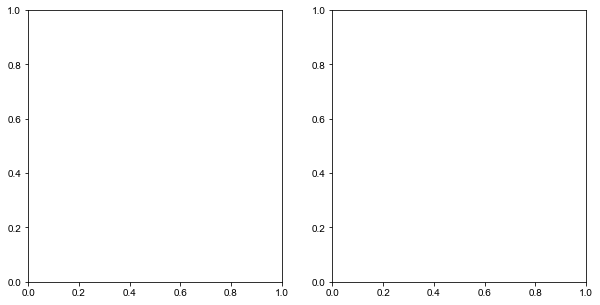

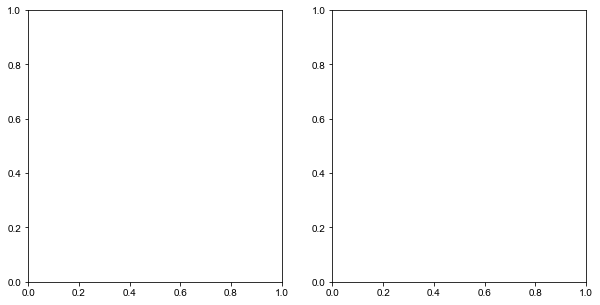

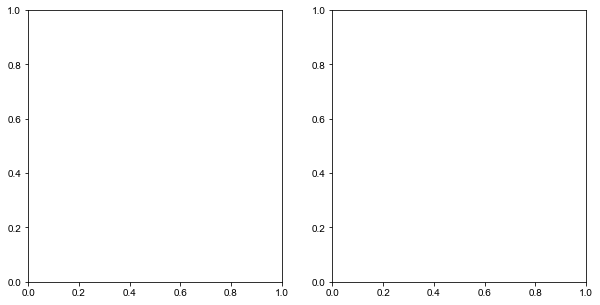

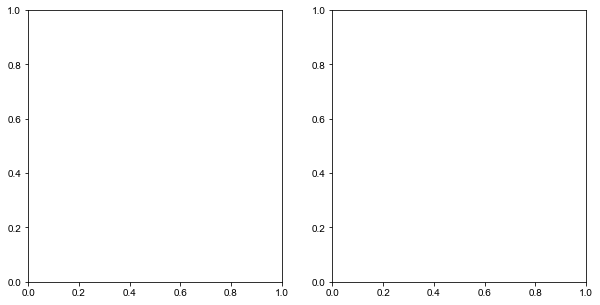

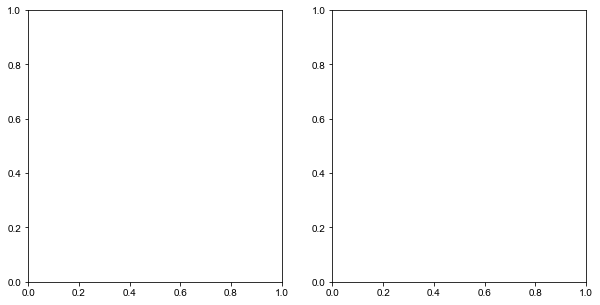

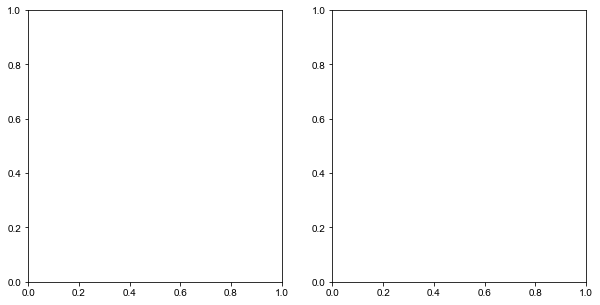

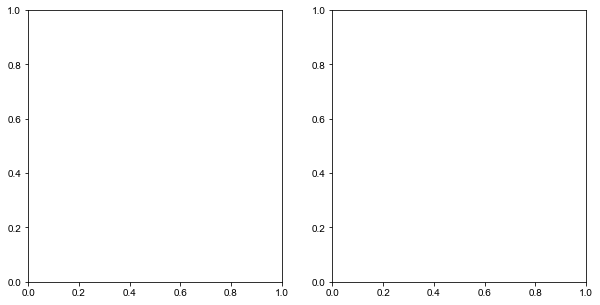

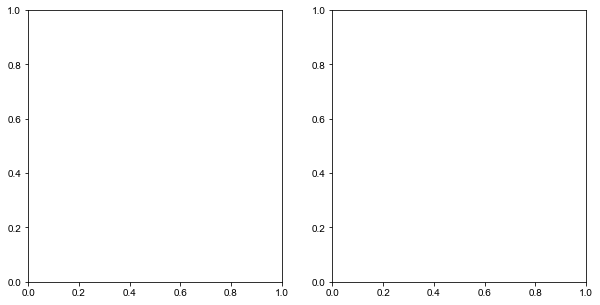

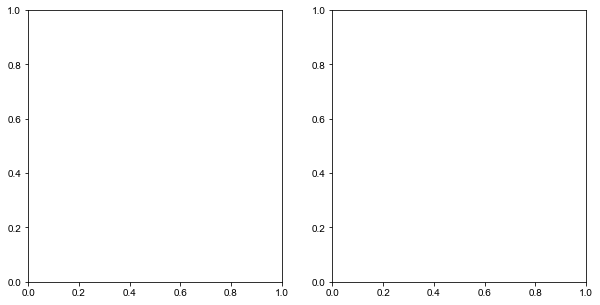

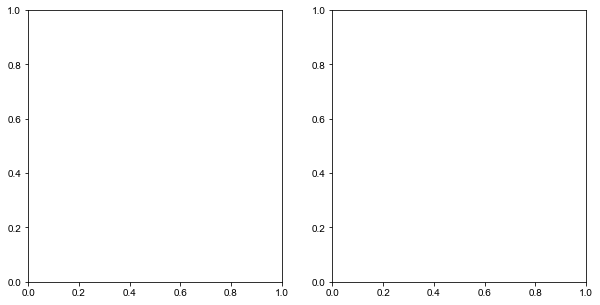

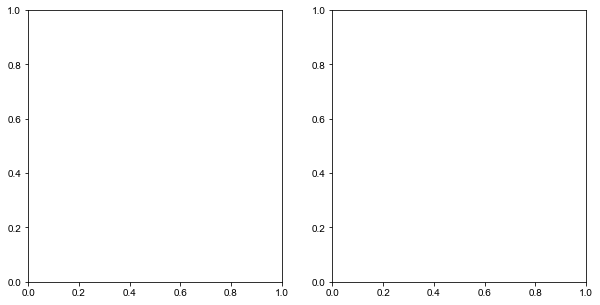

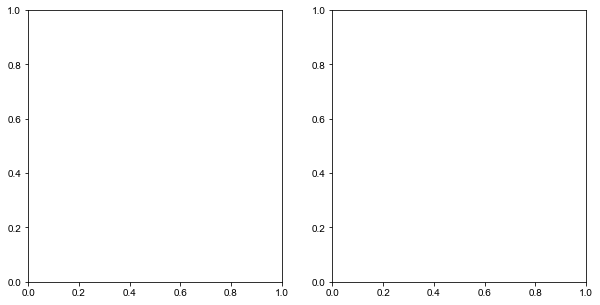

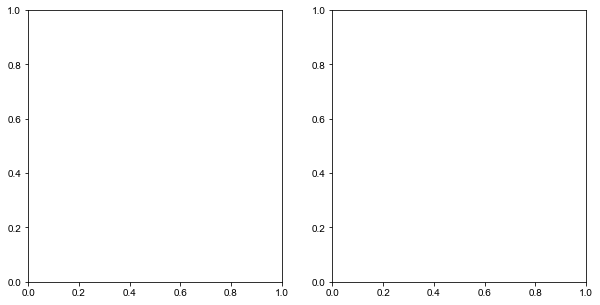

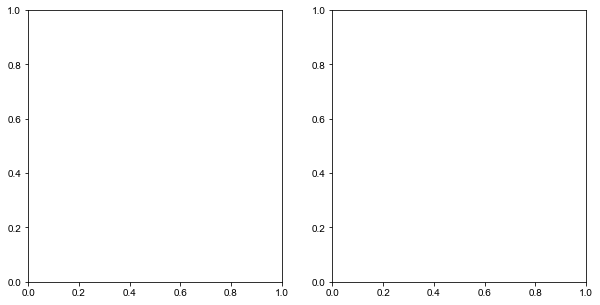

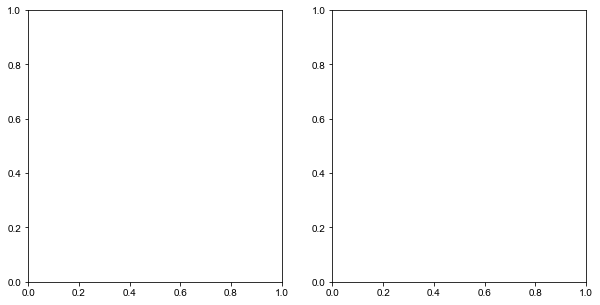

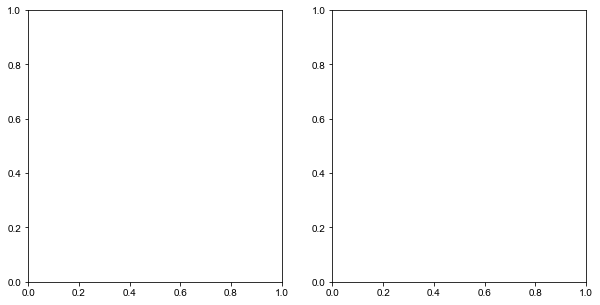

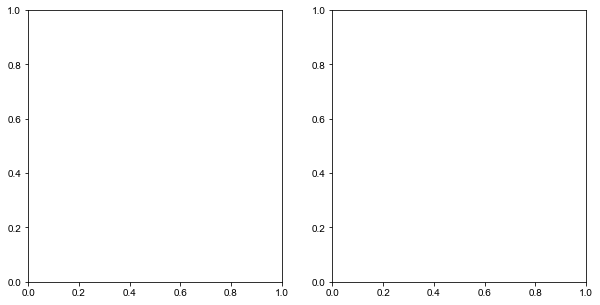

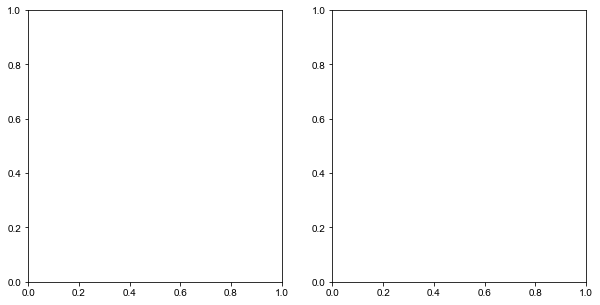

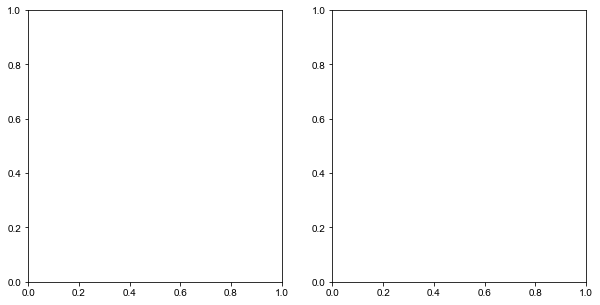

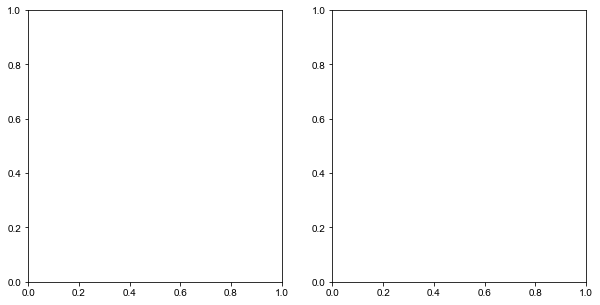

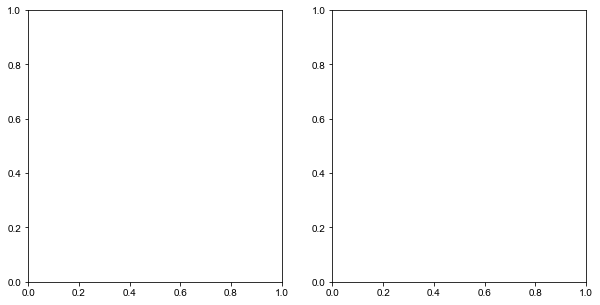

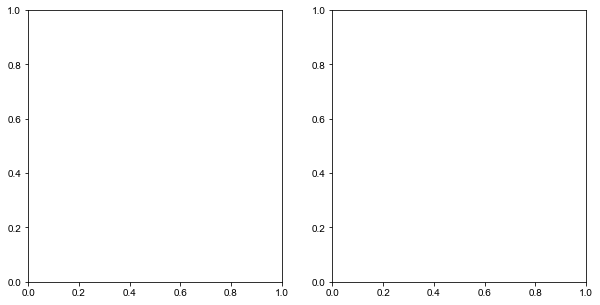

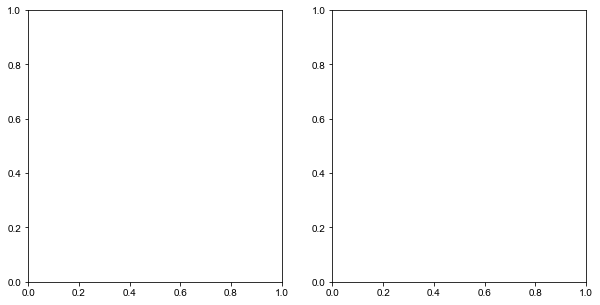

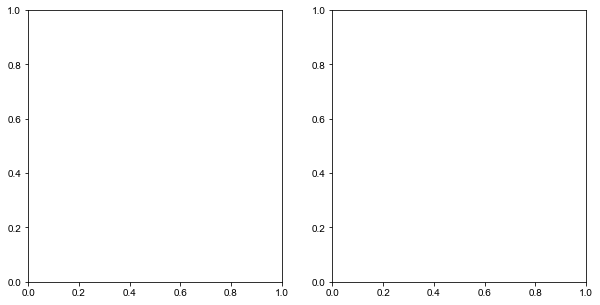

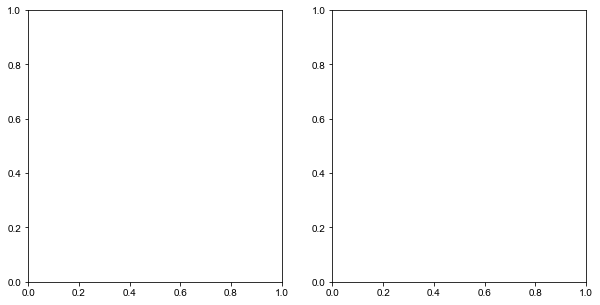

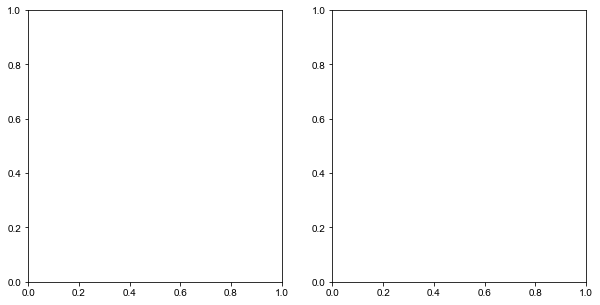

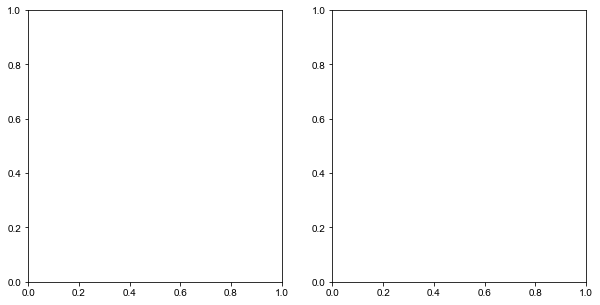

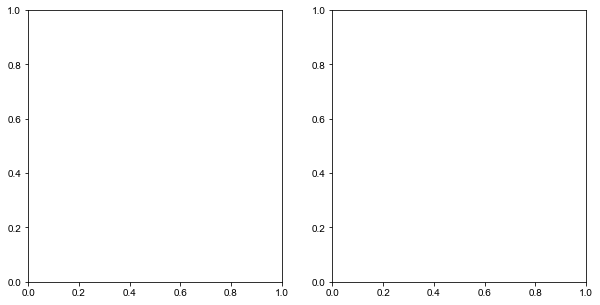

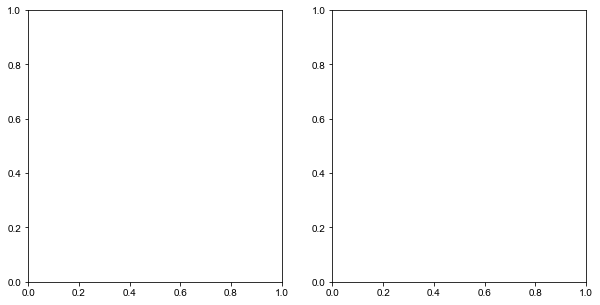

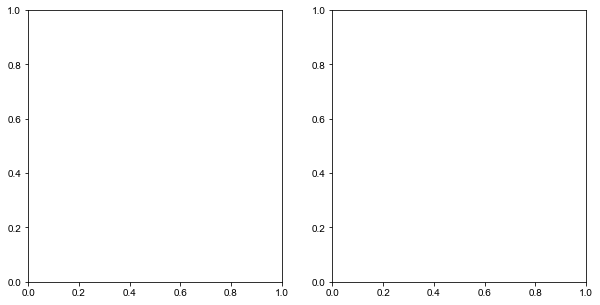

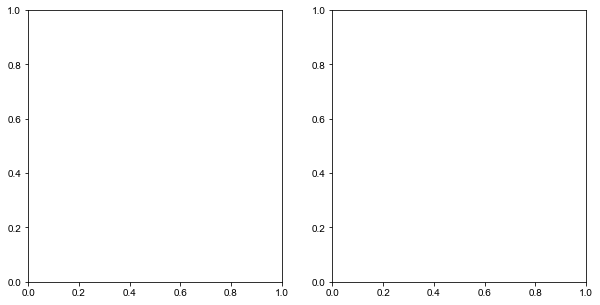

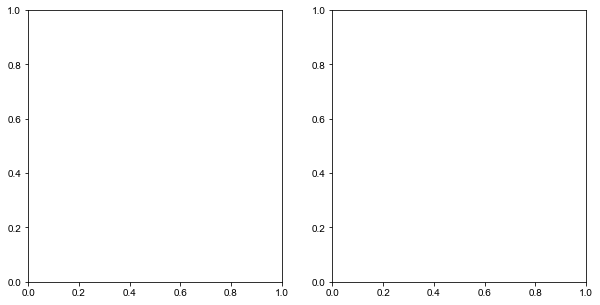

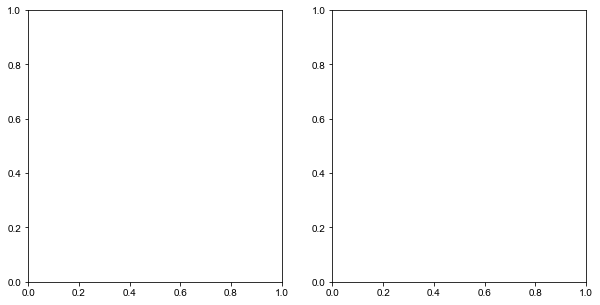

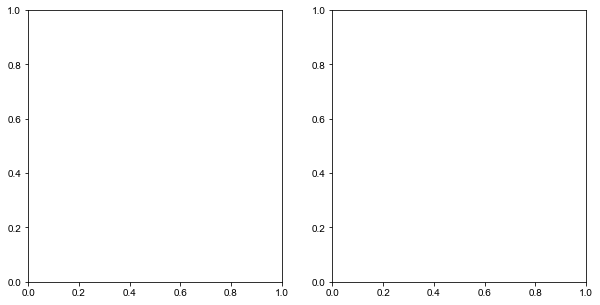

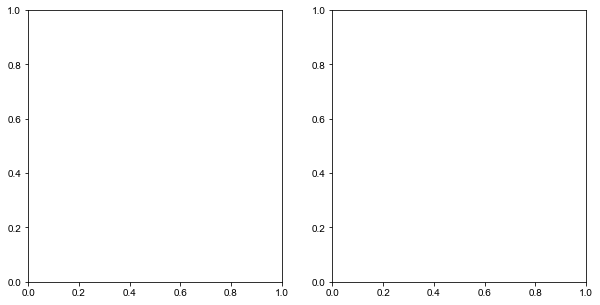

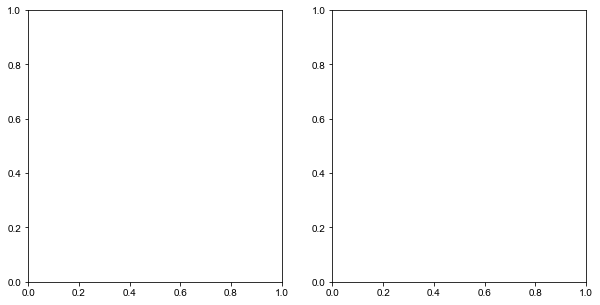

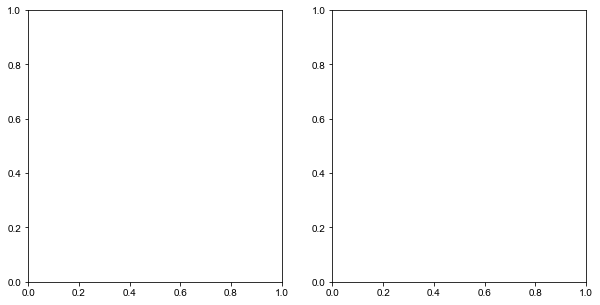

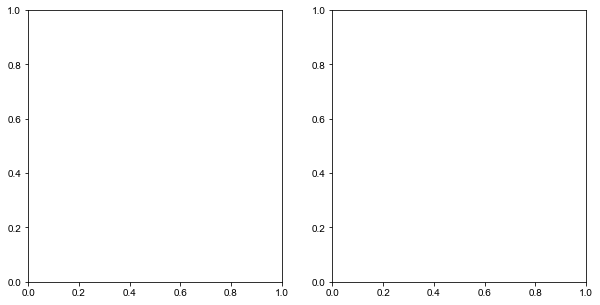

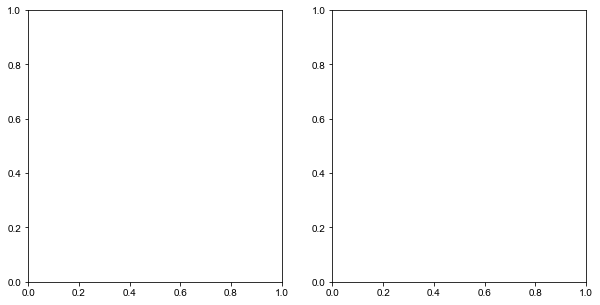

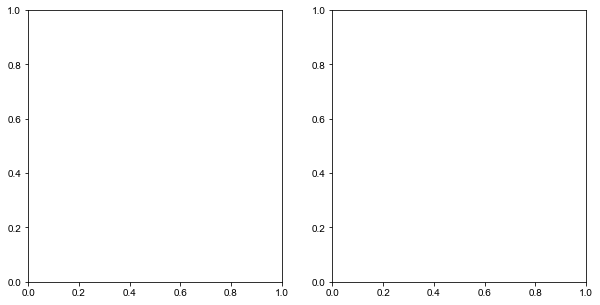

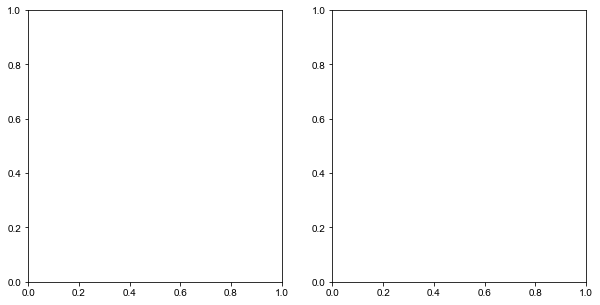

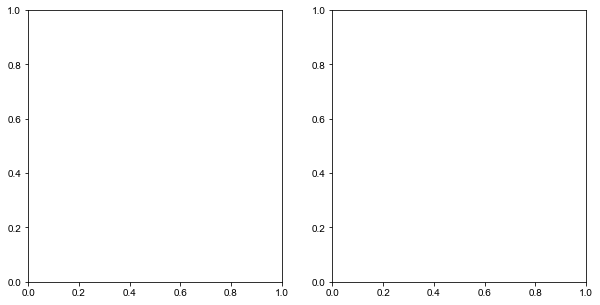

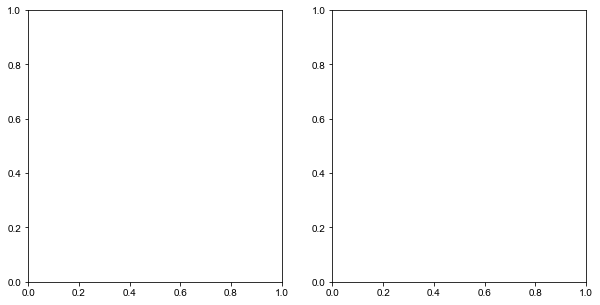

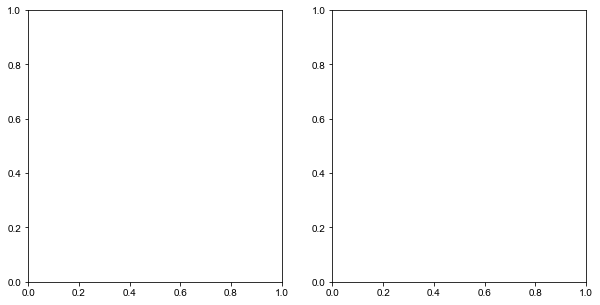

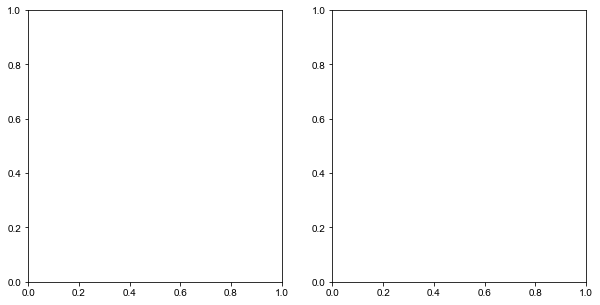

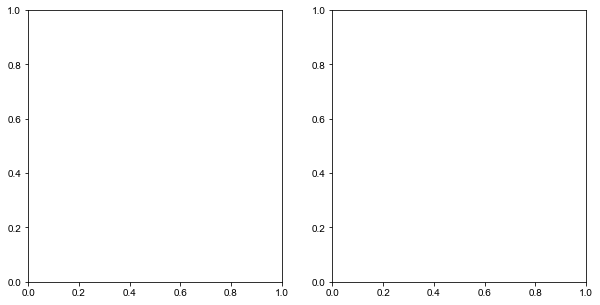

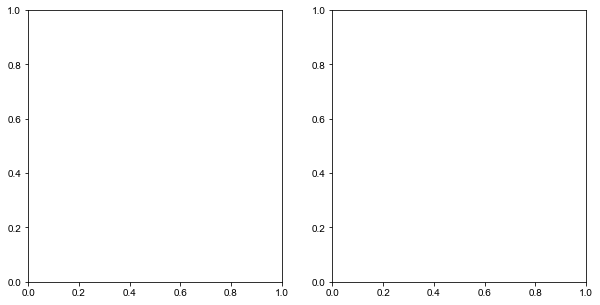

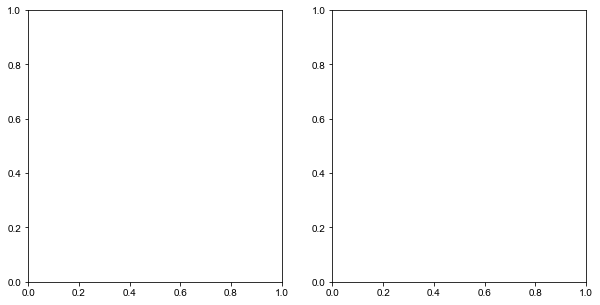

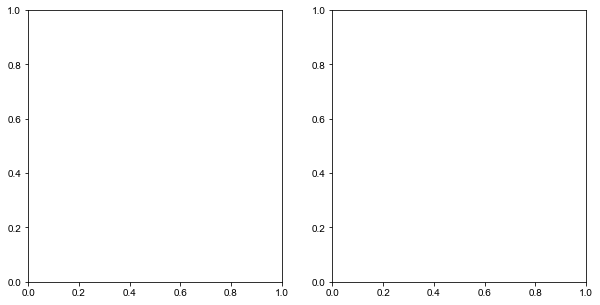

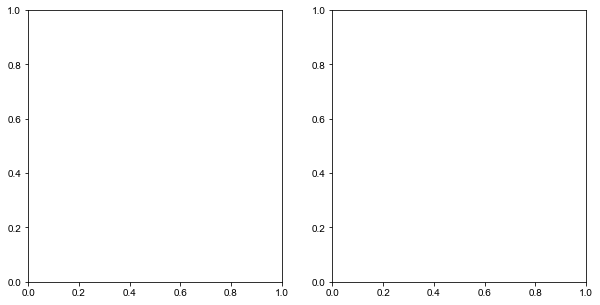

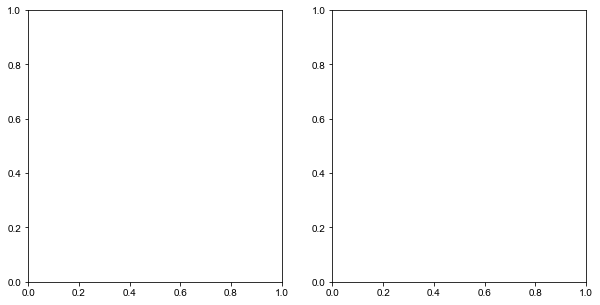

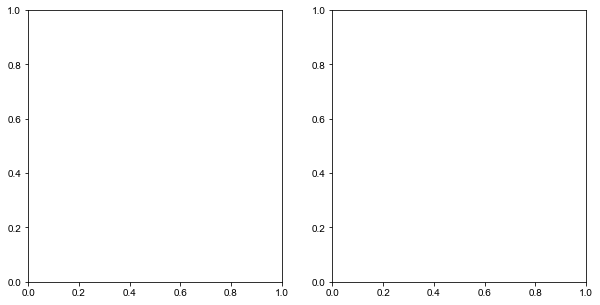

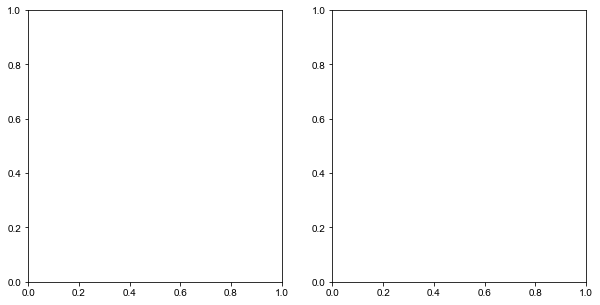

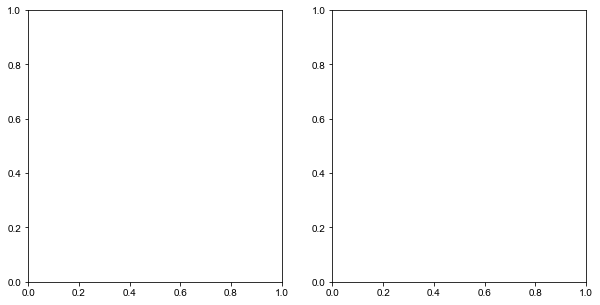

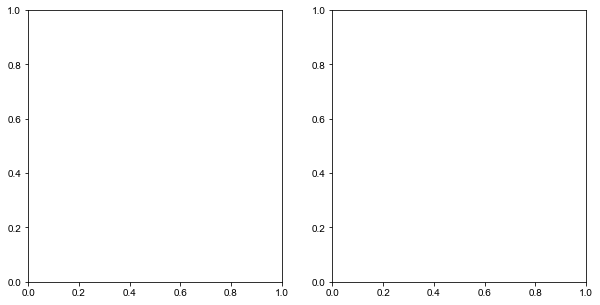

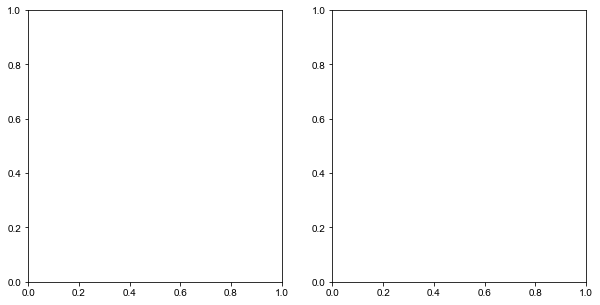

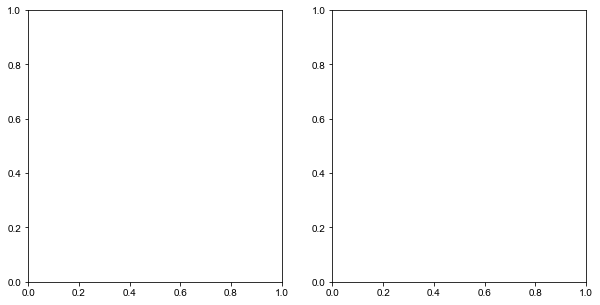

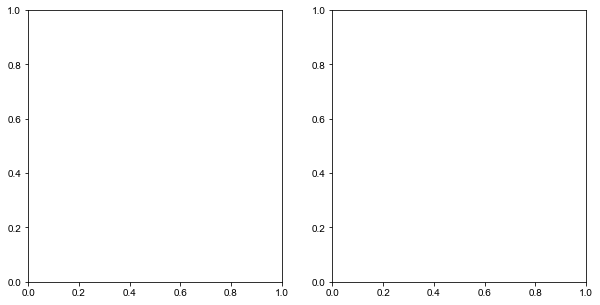

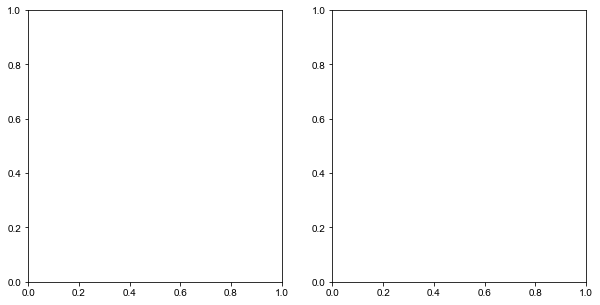

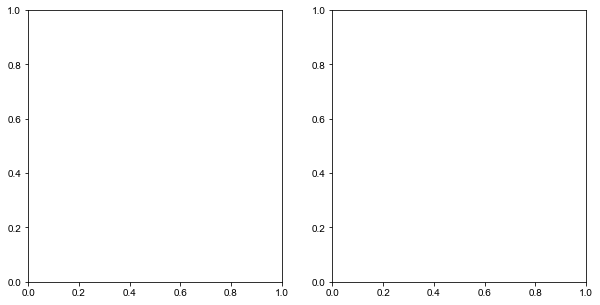

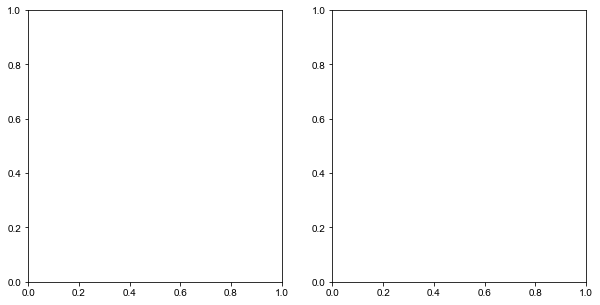

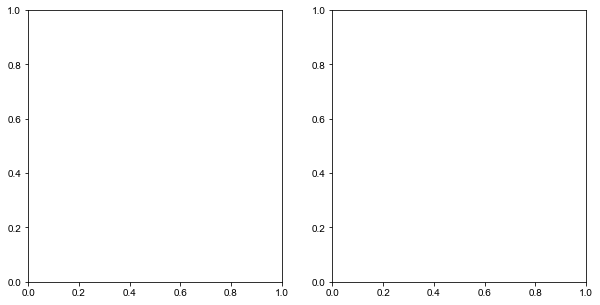

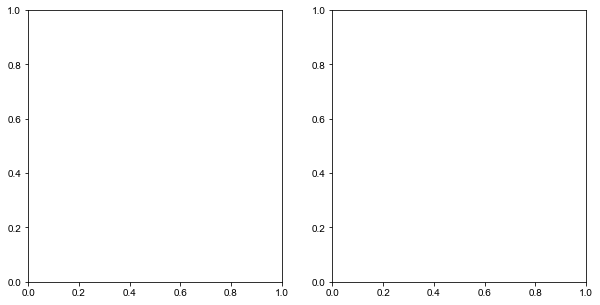

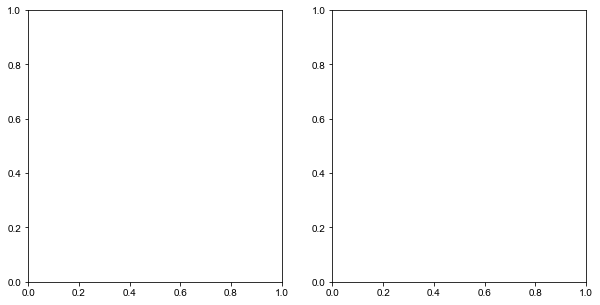

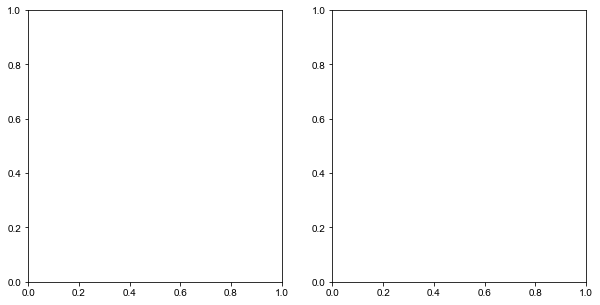

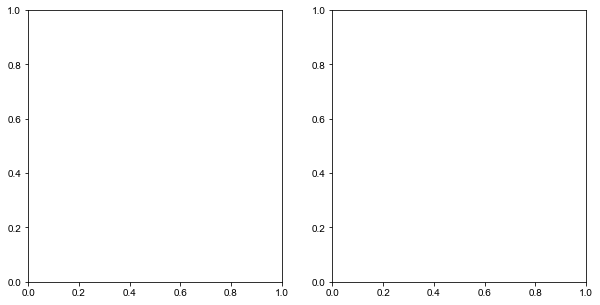

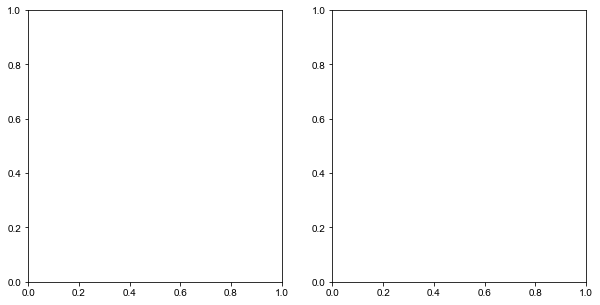

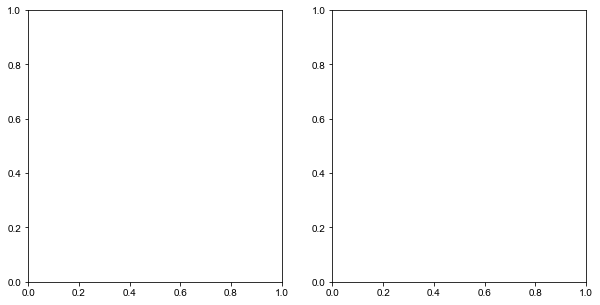

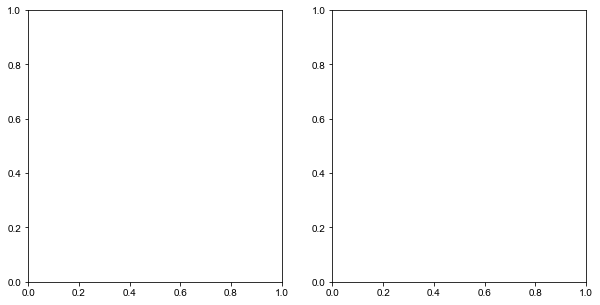

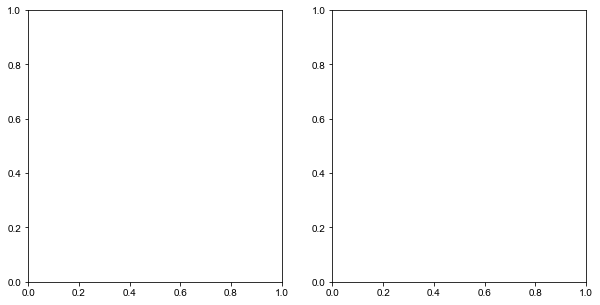

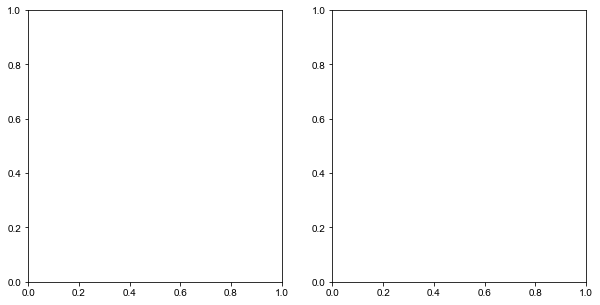

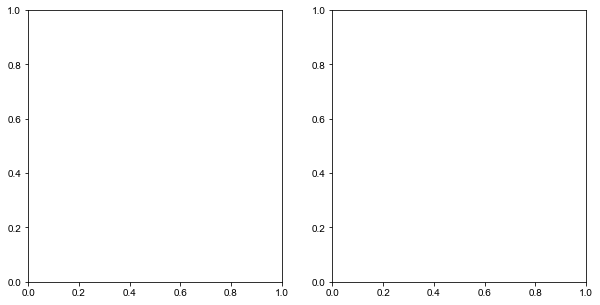

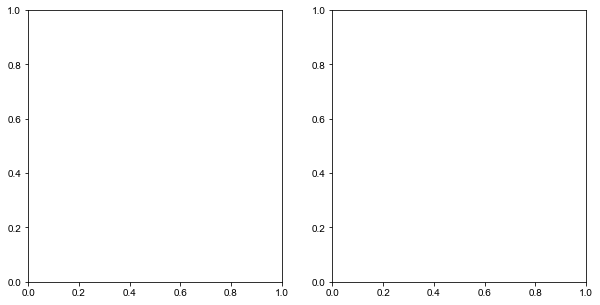

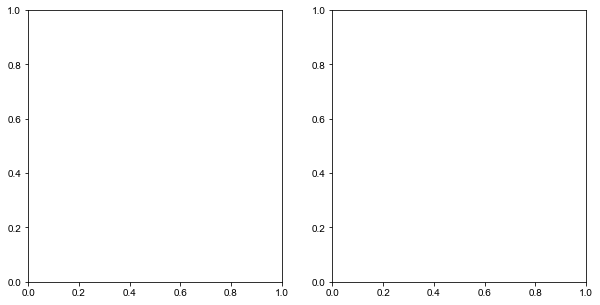

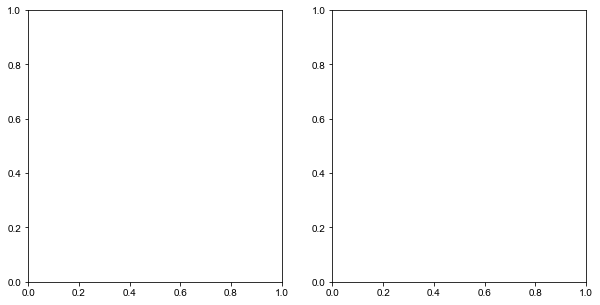

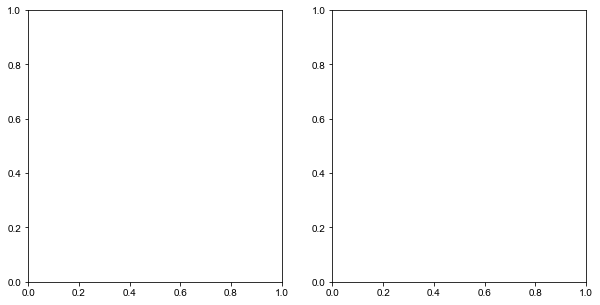

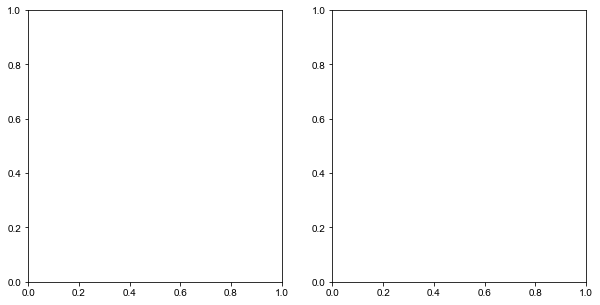

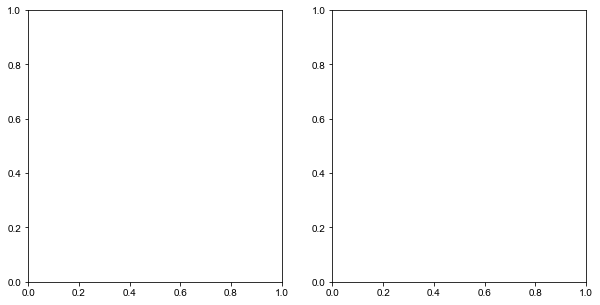

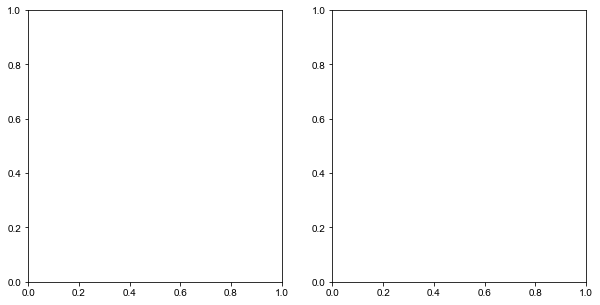

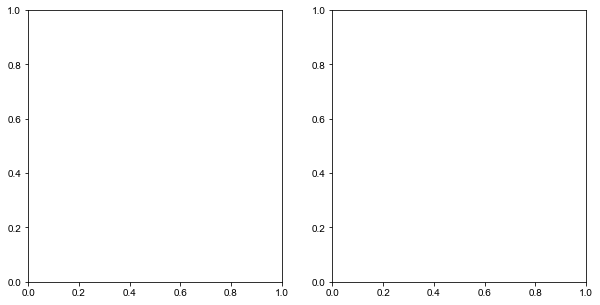

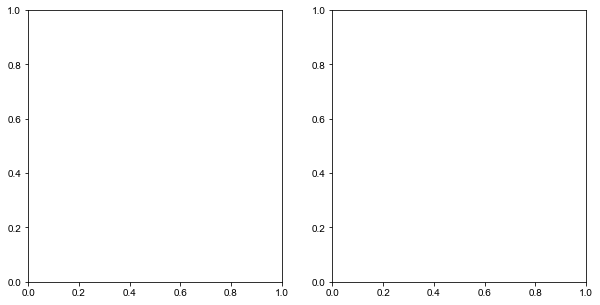

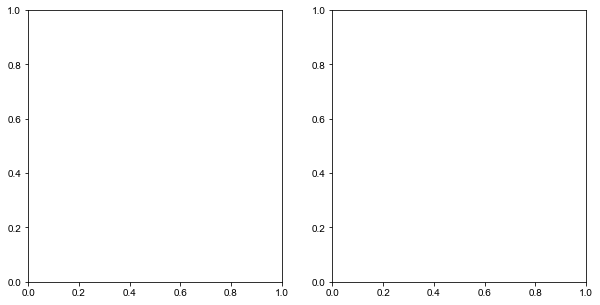

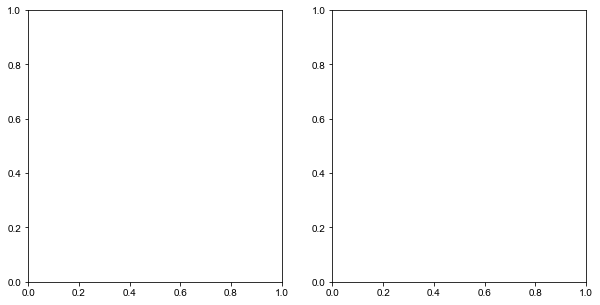

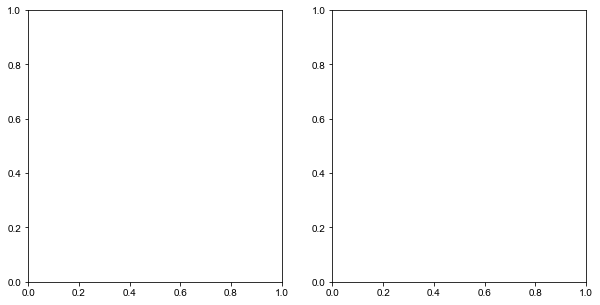

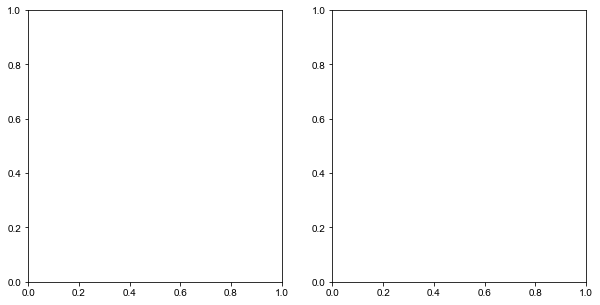

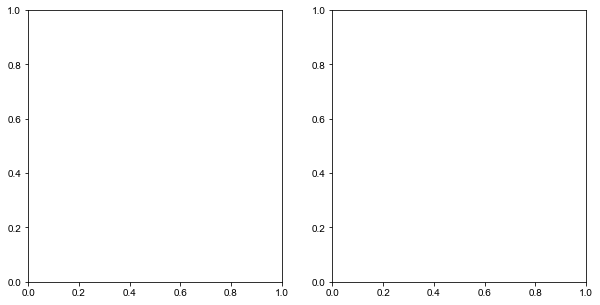

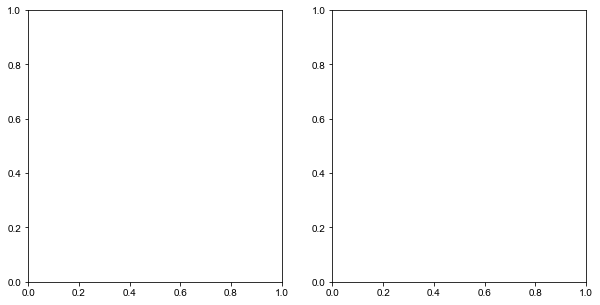

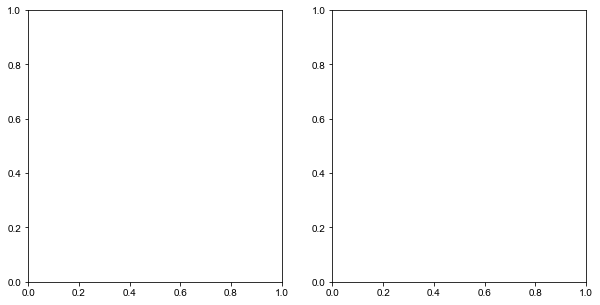

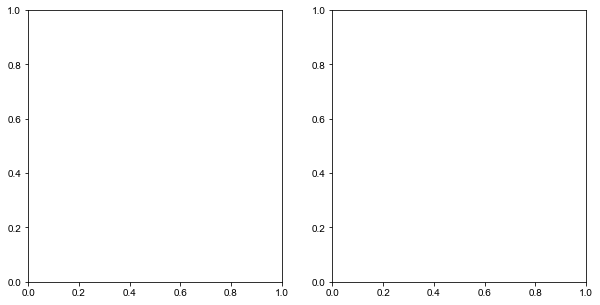

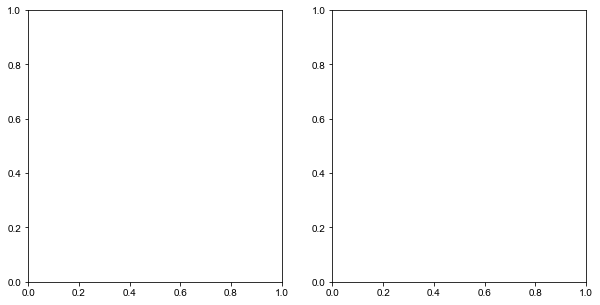

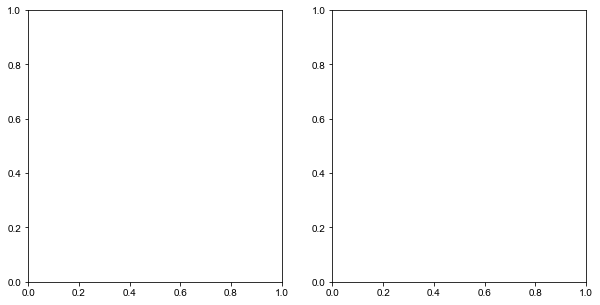

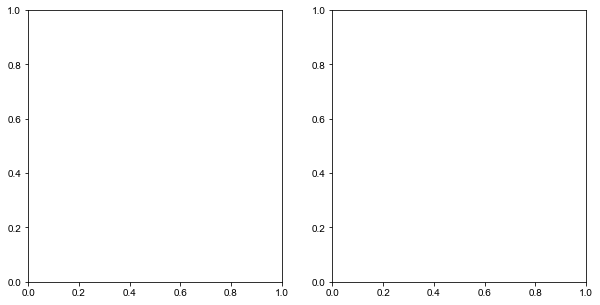

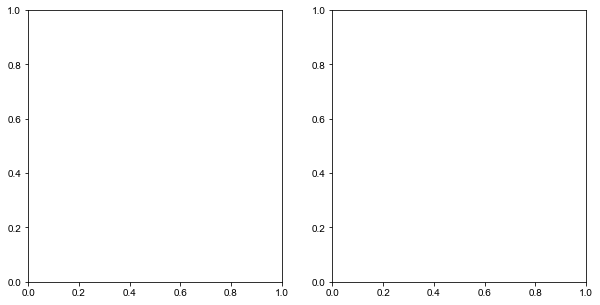

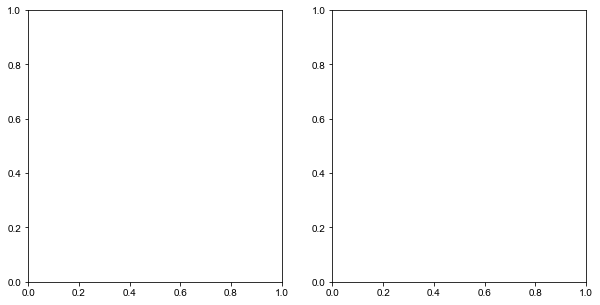

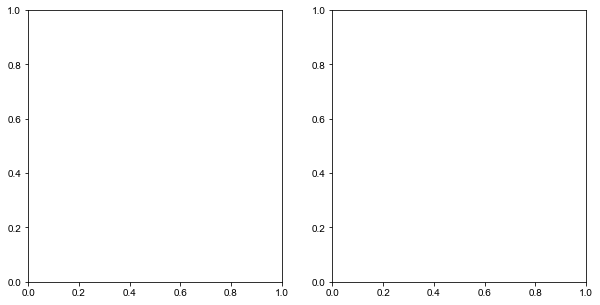

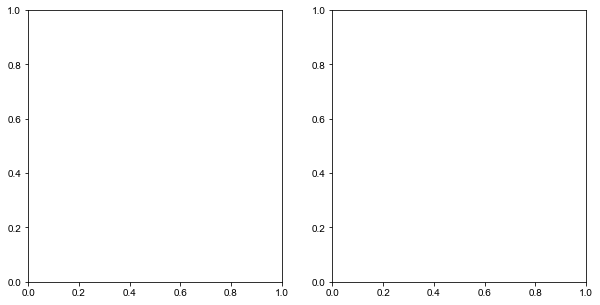

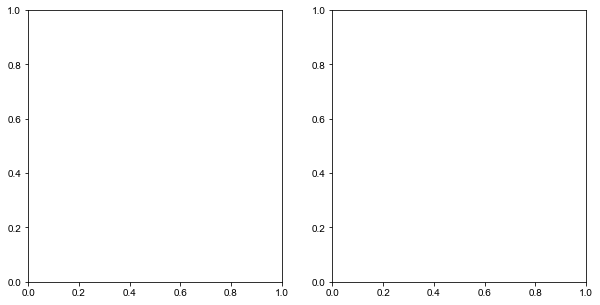

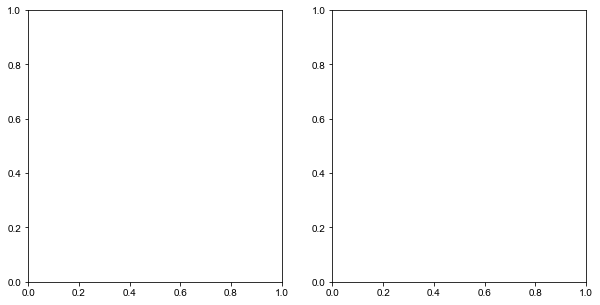

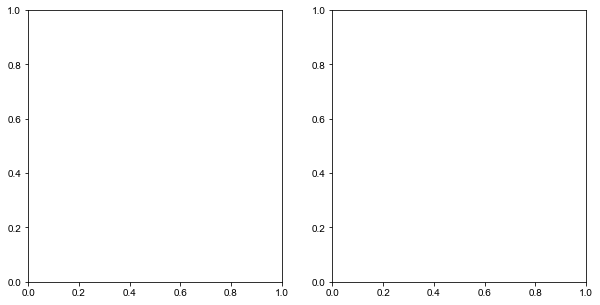

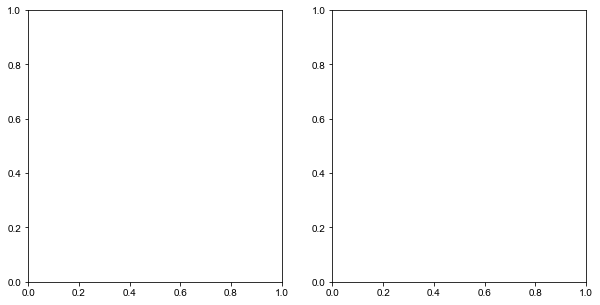

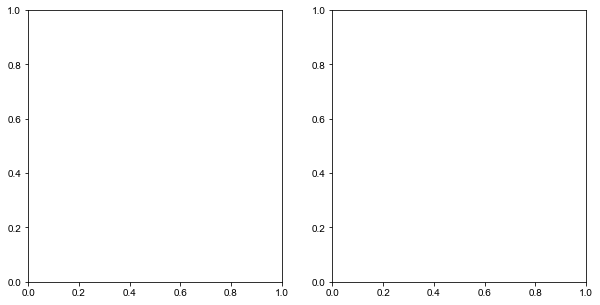

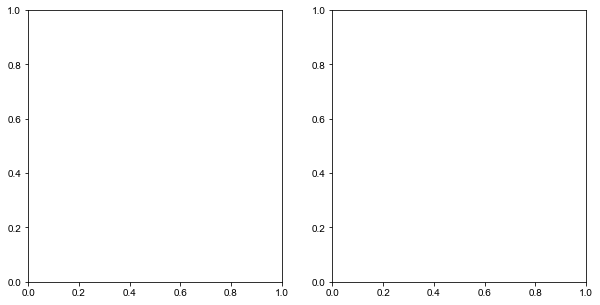

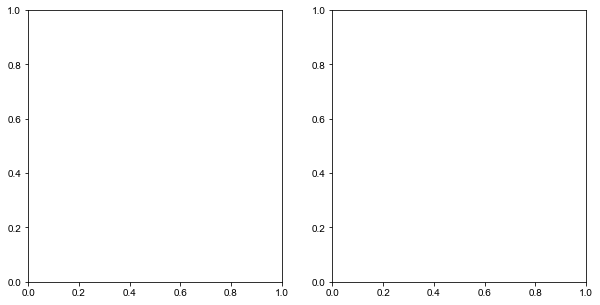

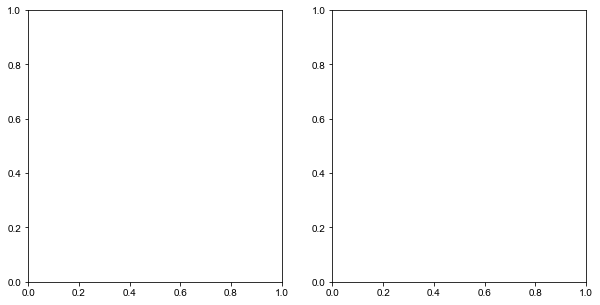

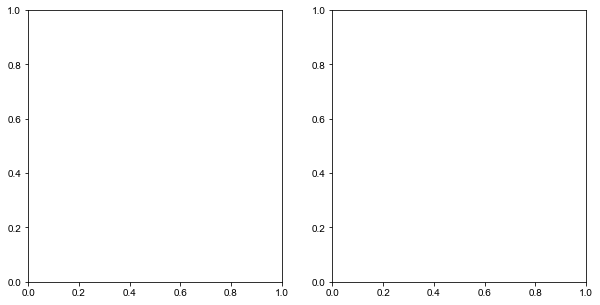

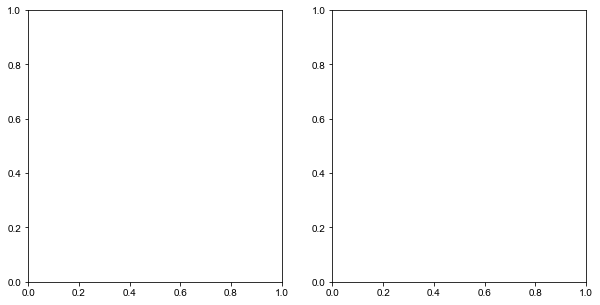

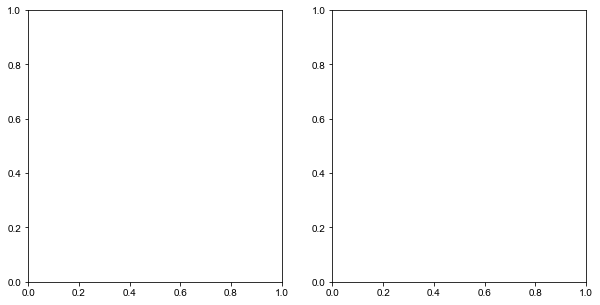

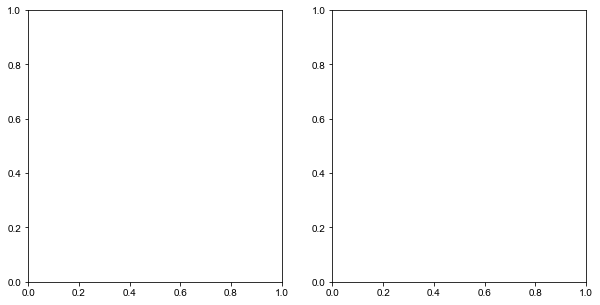

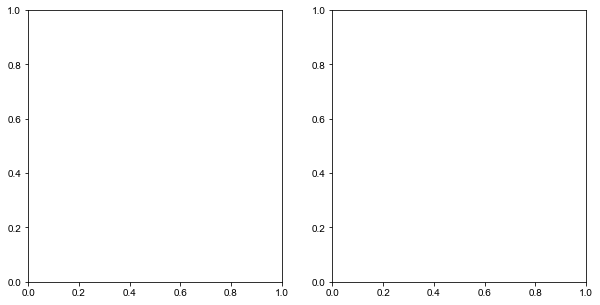

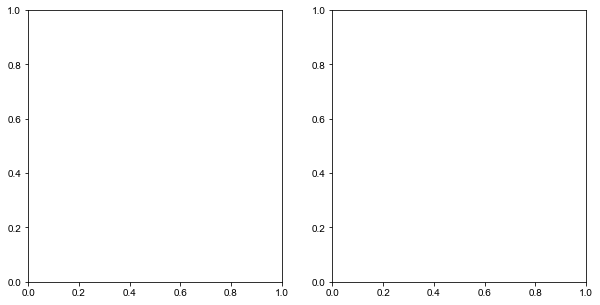

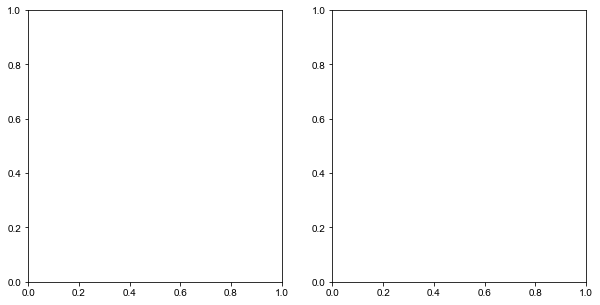

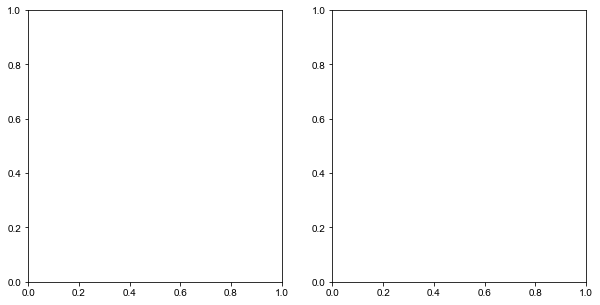

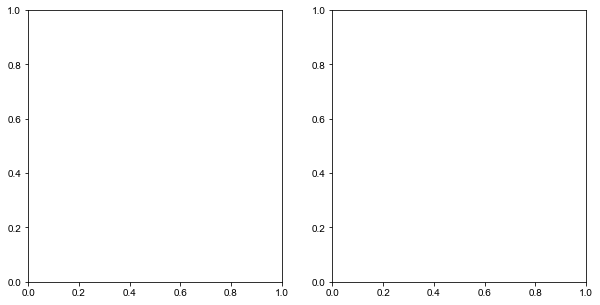

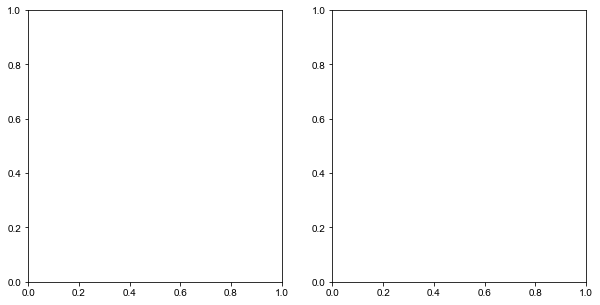

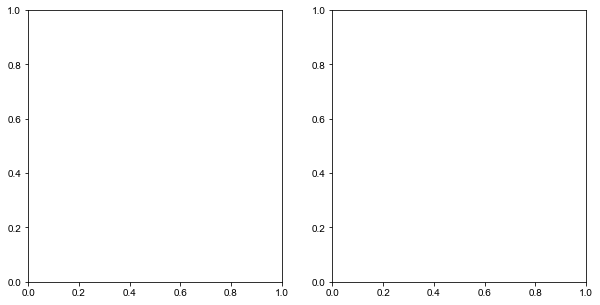

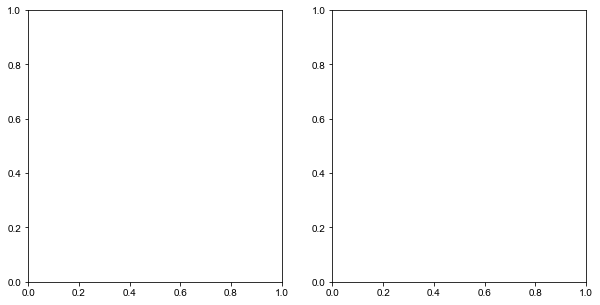

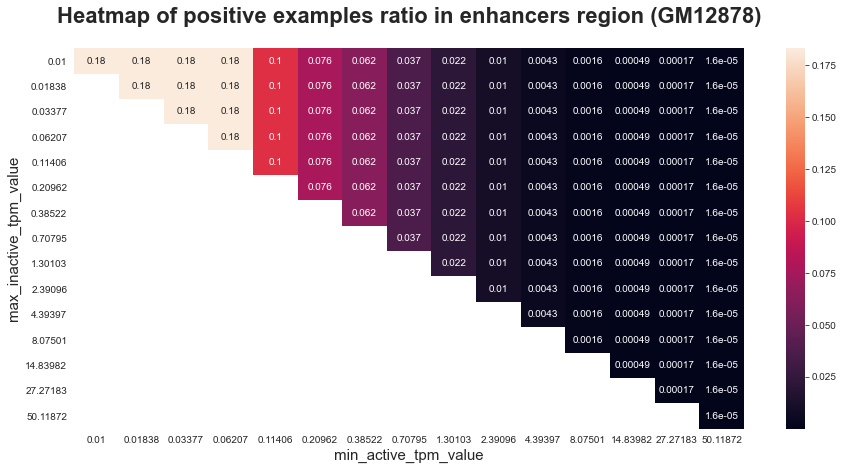

None

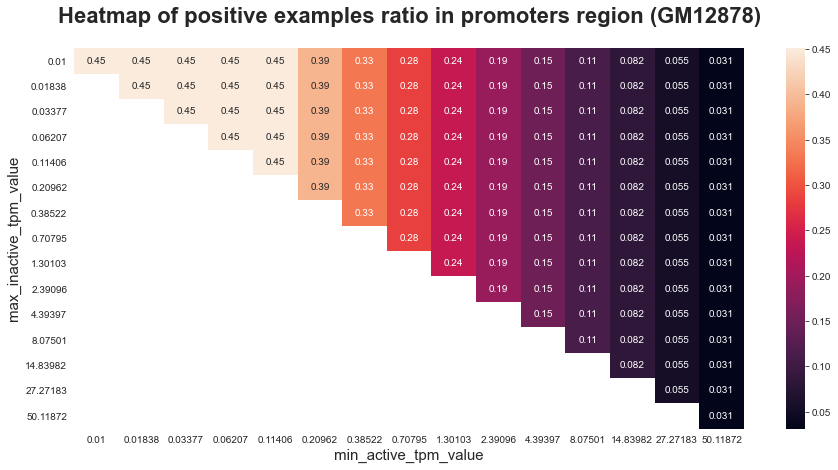

None

skipping 0 in H1, already done
skipping 1 in H1, already done
skipping 2 in H1, already done
skipping 3 in H1, already done
skipping 4 in H1, already done
skipping 5 in H1, already done
skipping 6 in H1, already done
skipping 7 in H1, already done
skipping 8 in H1, already done
skipping 9 in H1, already done
skipping 10 in H1, already done
skipping 11 in H1, already done
skipping 12 in H1, already done
skipping 13 in H1, already done
skipping 14 in H1, already done
skipping 15 in H1, already done
skipping 16 in H1, already done
skipping 17 in H1, already done
skipping 18 in H1, already done
skipping 19 in H1, already done
skipping 20 in H1, already done
skipping 21 in H1, already done
skipping 22 in H1, already done
skipping 23 in H1, already done
skipping 24 in H1, already done
skipping 25 in H1, already done
skipping 26 in H1, already done
skipping 27 in H1, already done
skipping 28 in H1, already done
skipping 29 in H1, already done
skipping 30 in H1, already done
skipping 31 in H1,

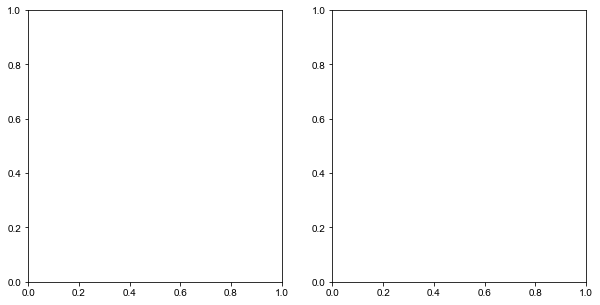

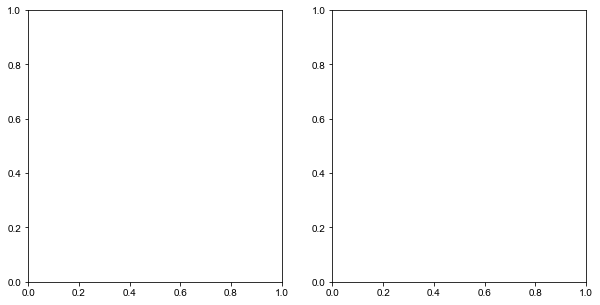

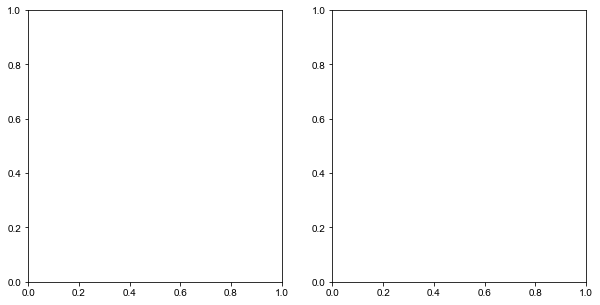

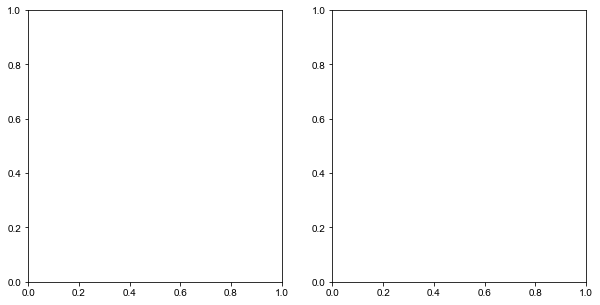

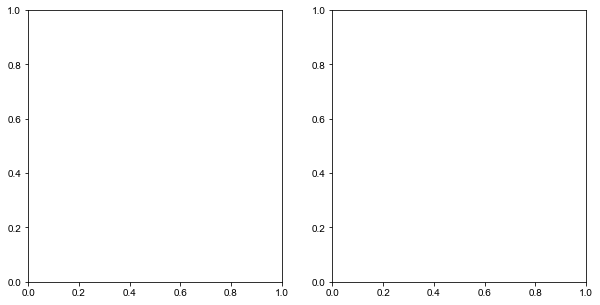

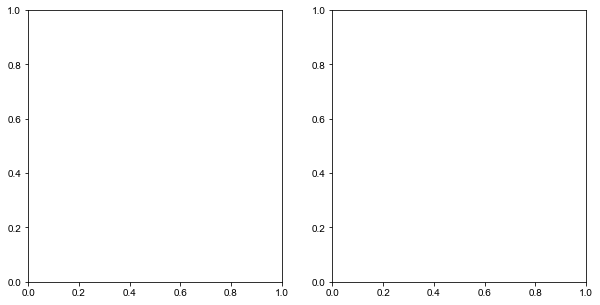

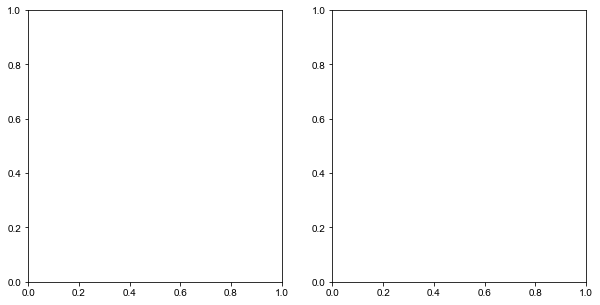

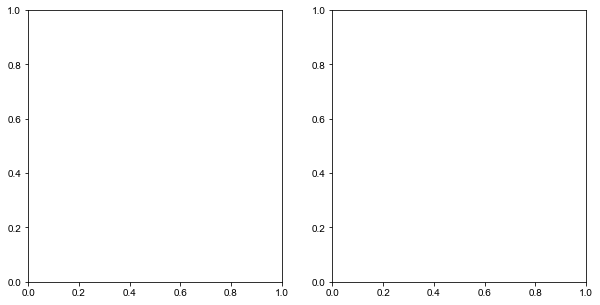

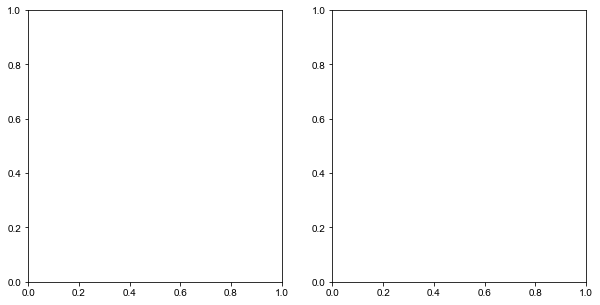

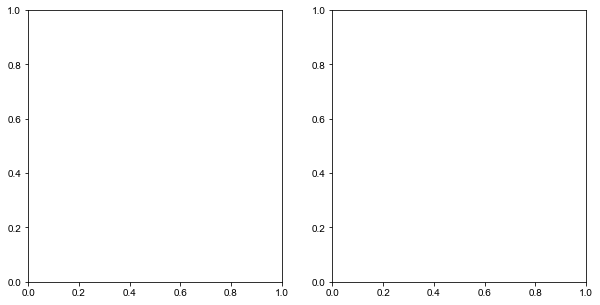

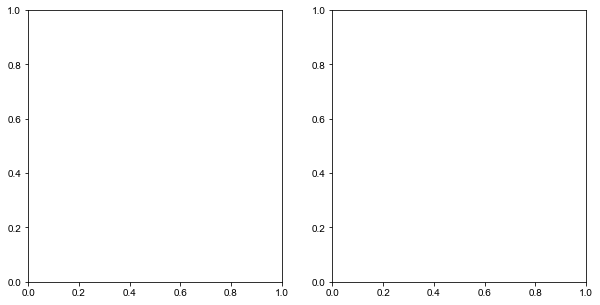

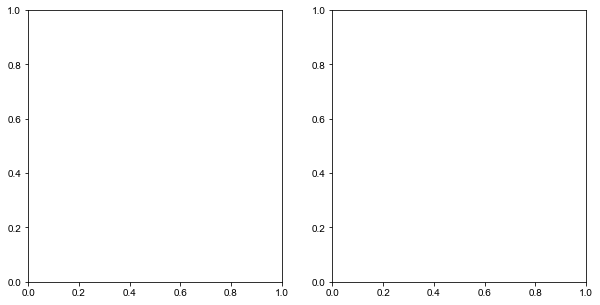

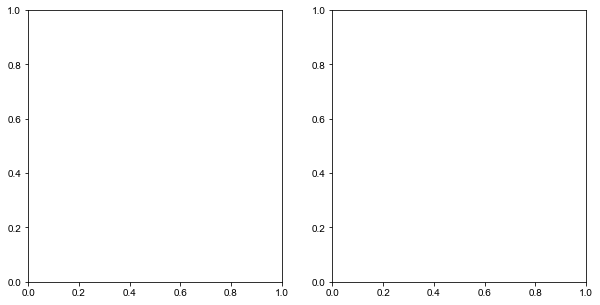

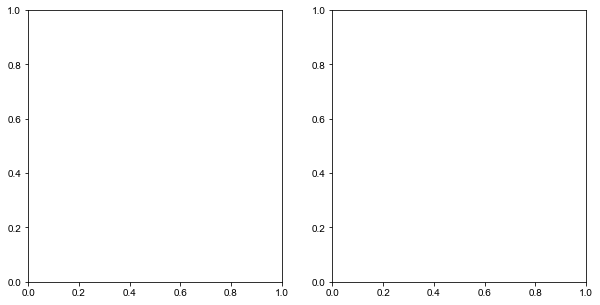

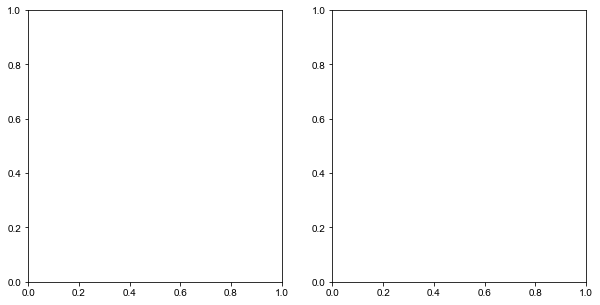

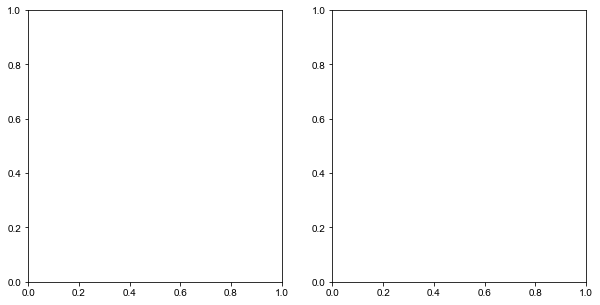

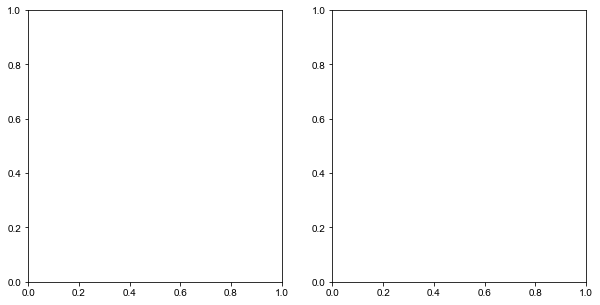

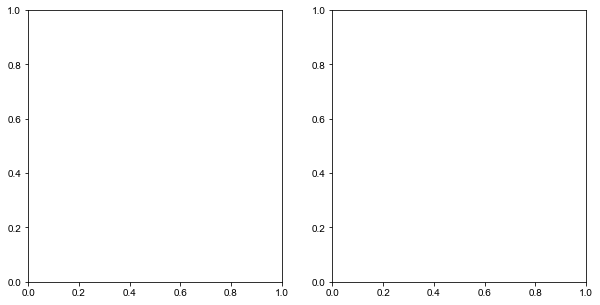

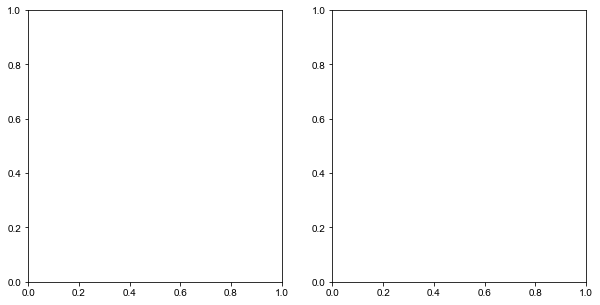

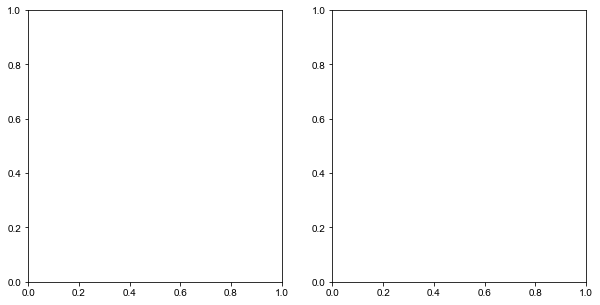

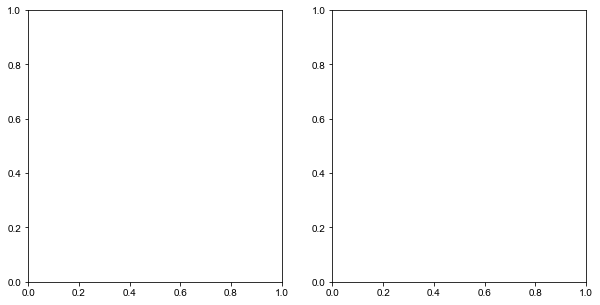

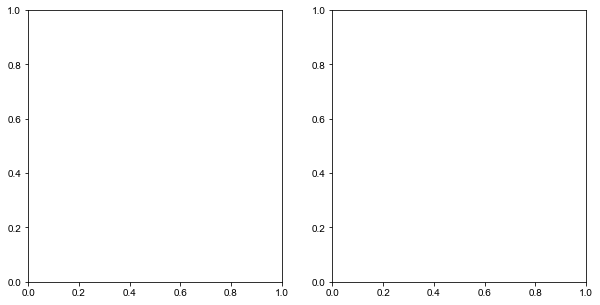

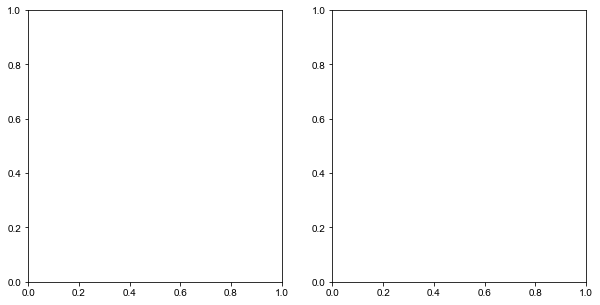

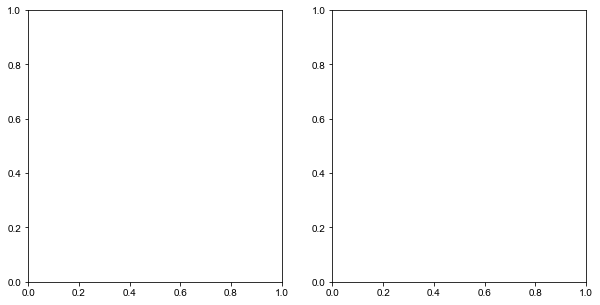

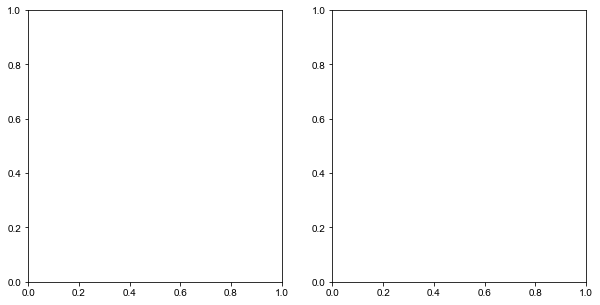

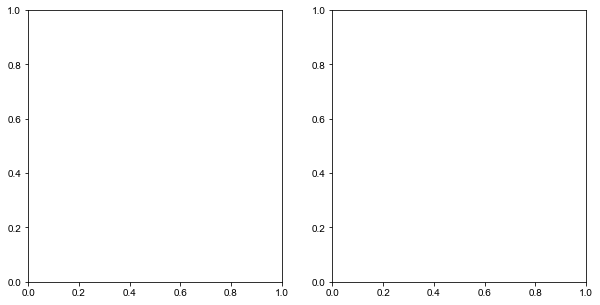

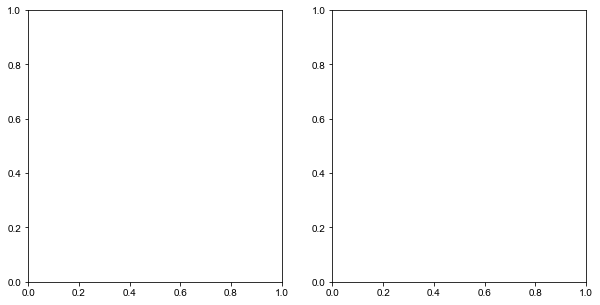

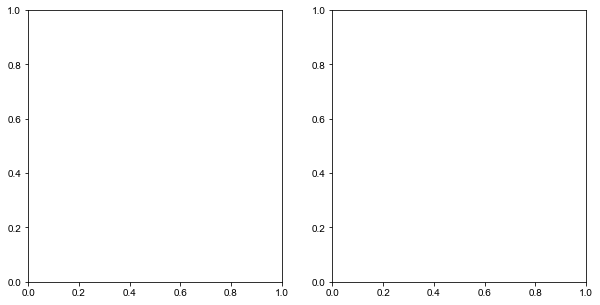

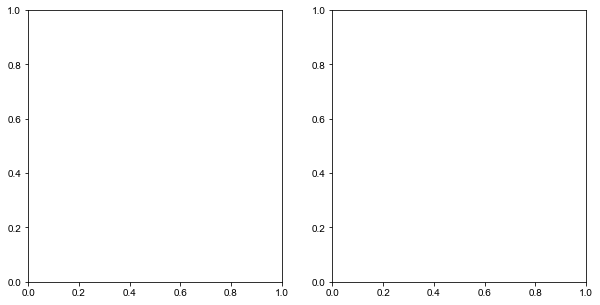

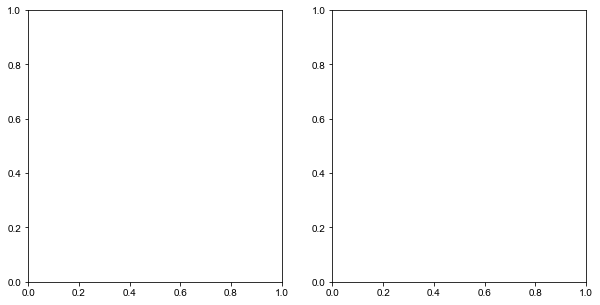

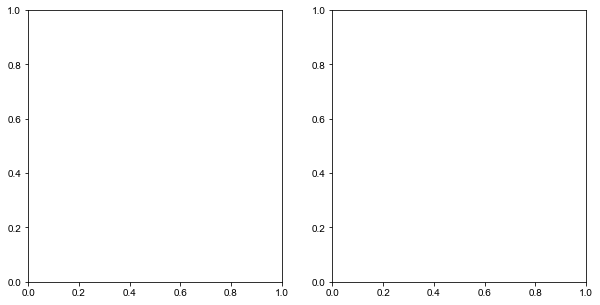

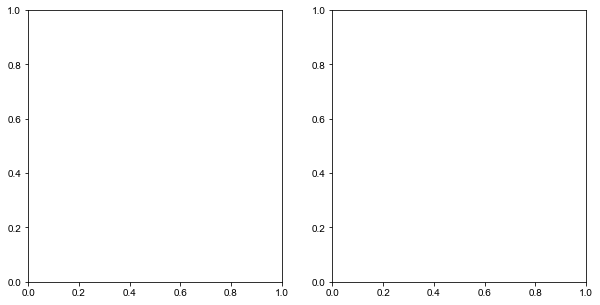

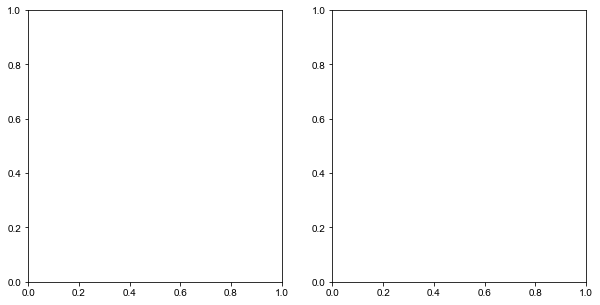

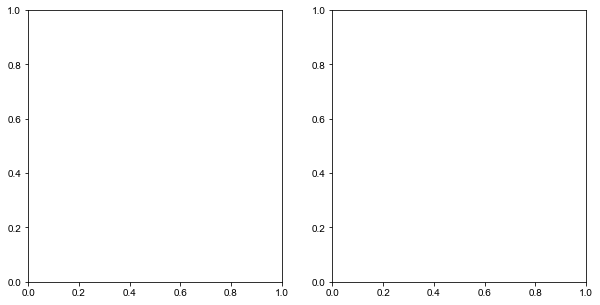

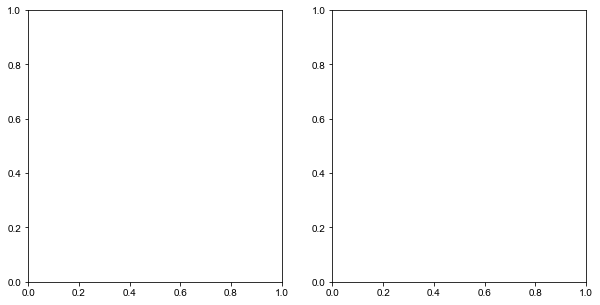

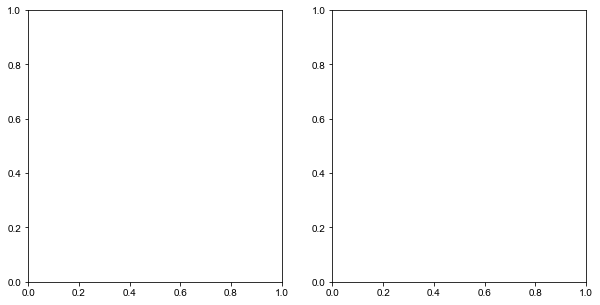

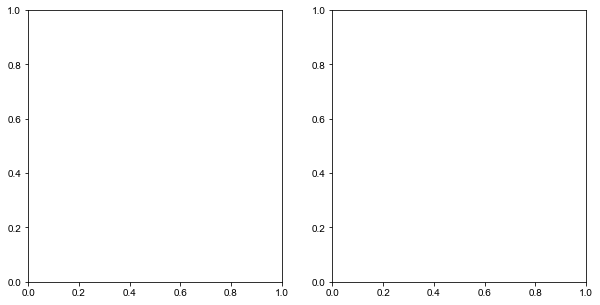

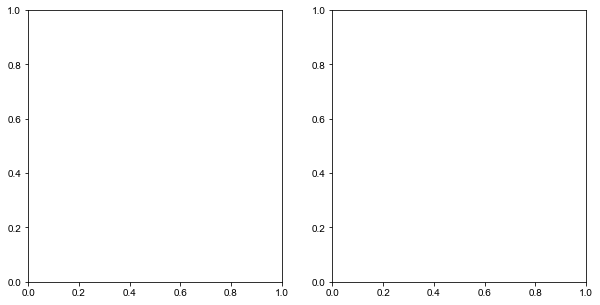

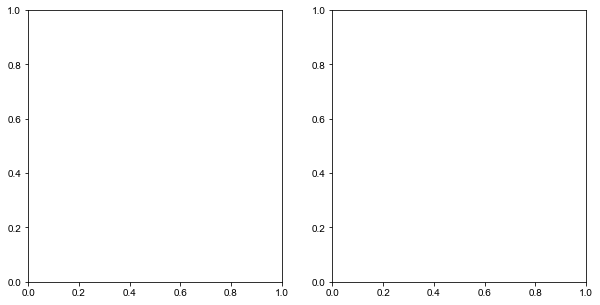

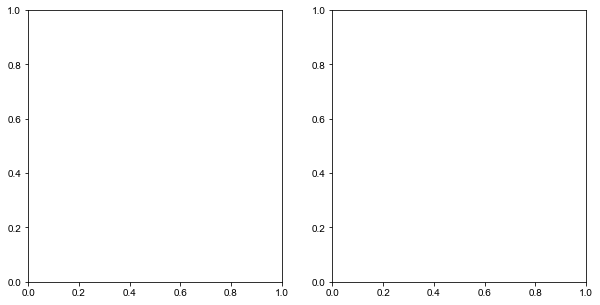

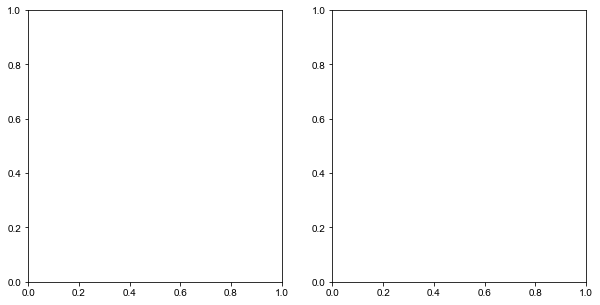

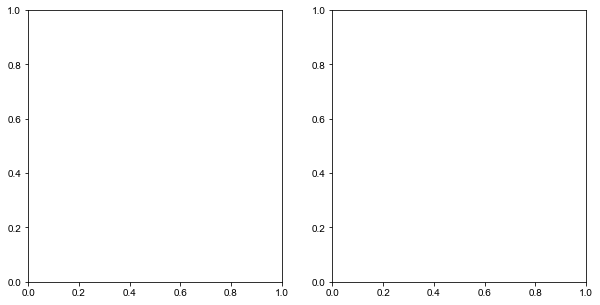

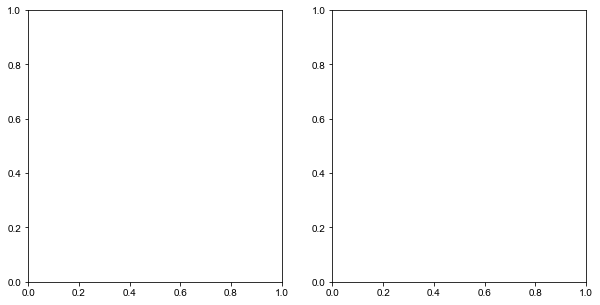

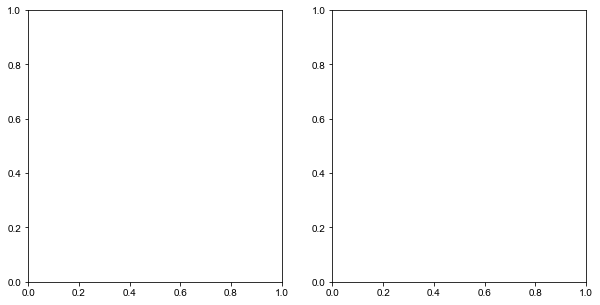

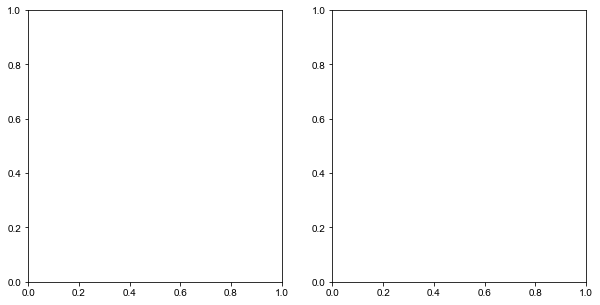

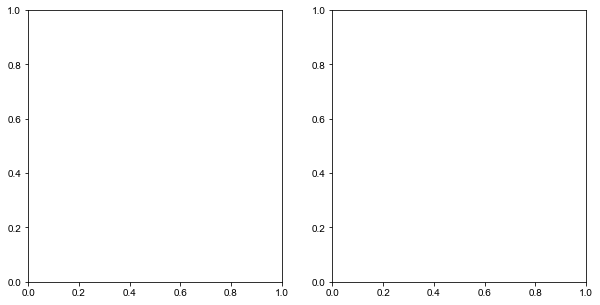

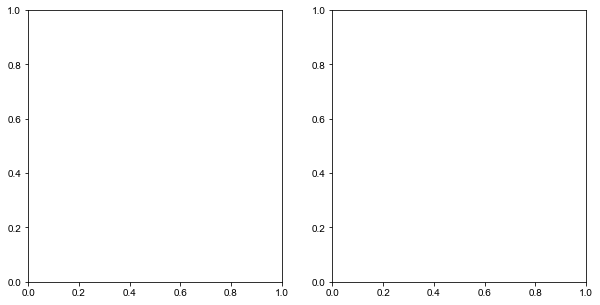

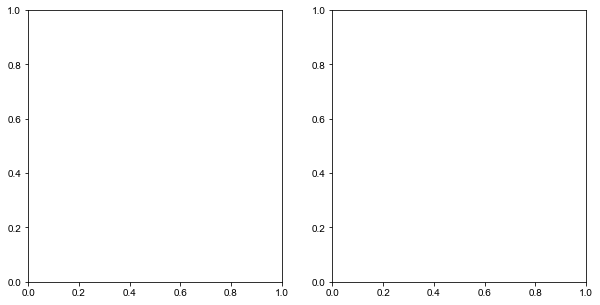

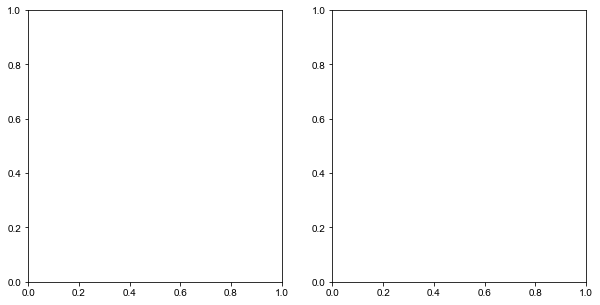

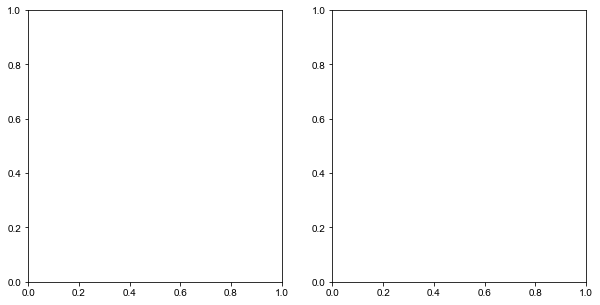

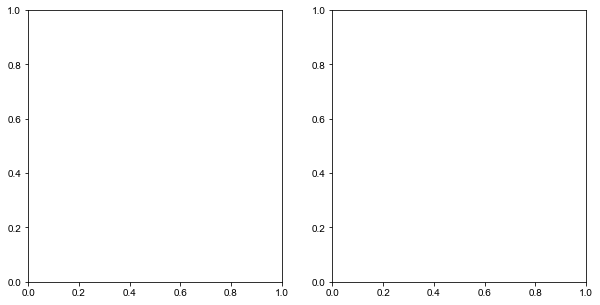

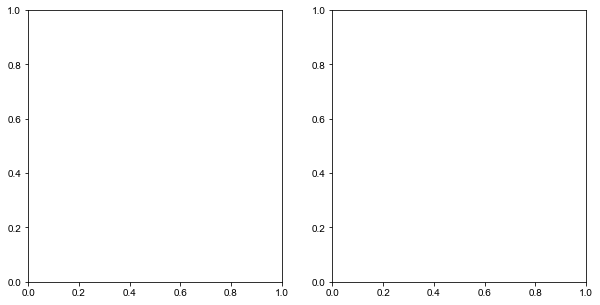

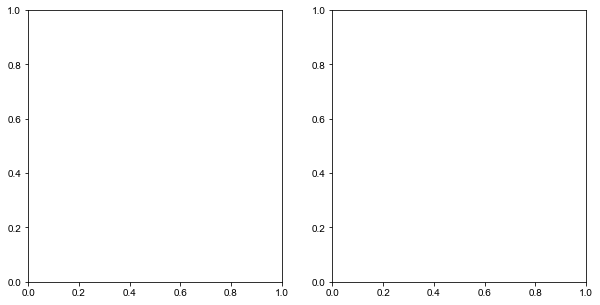

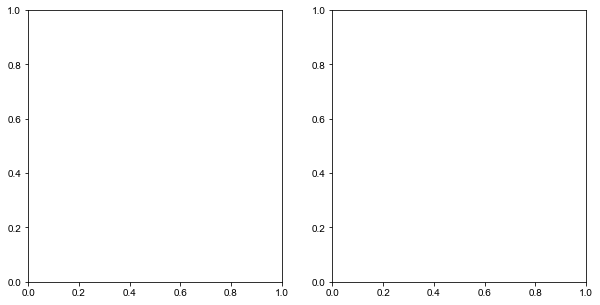

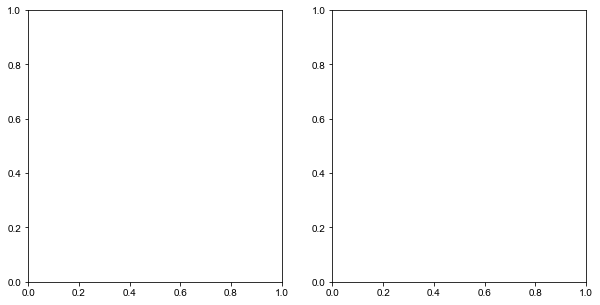

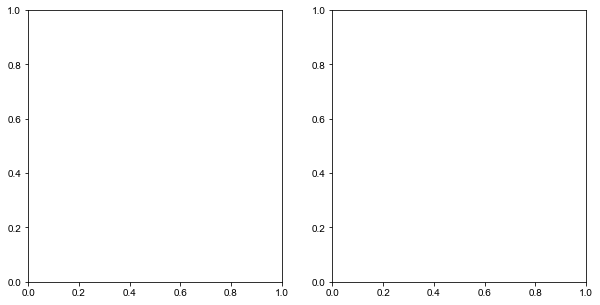

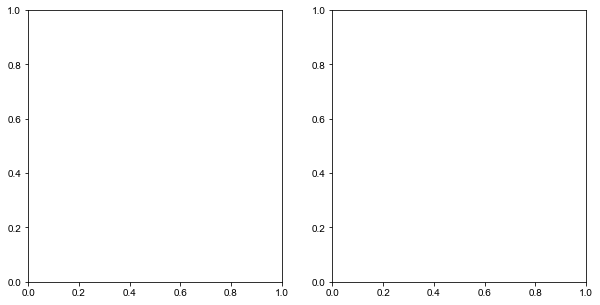

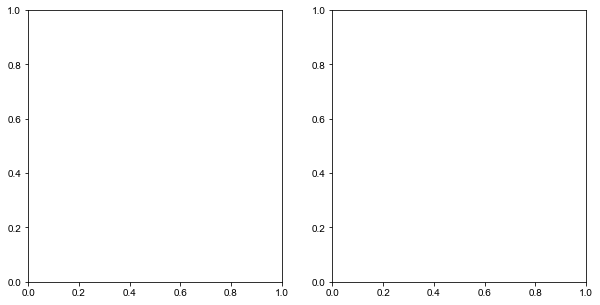

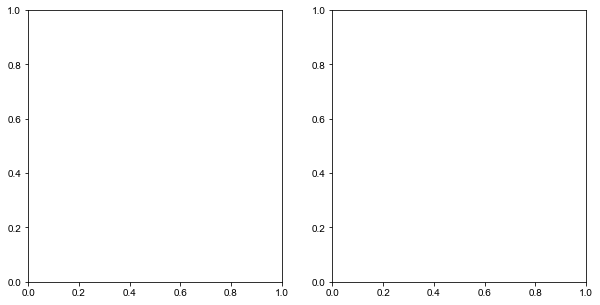

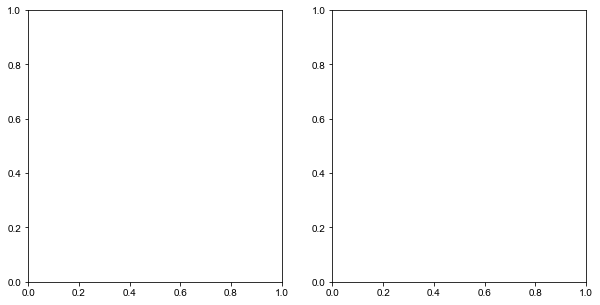

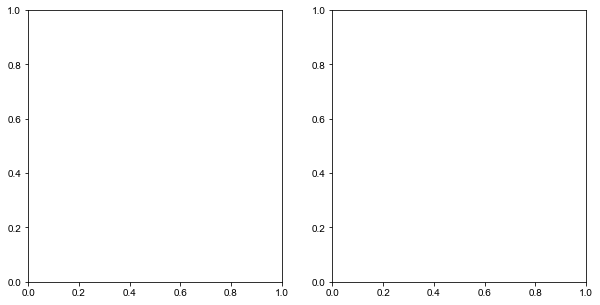

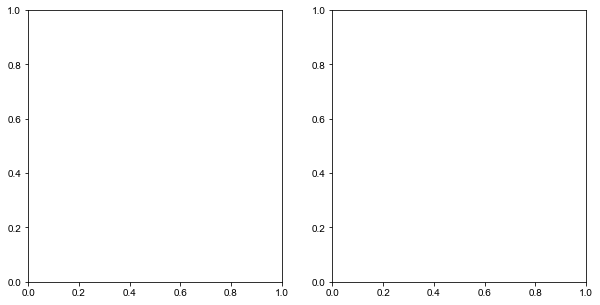

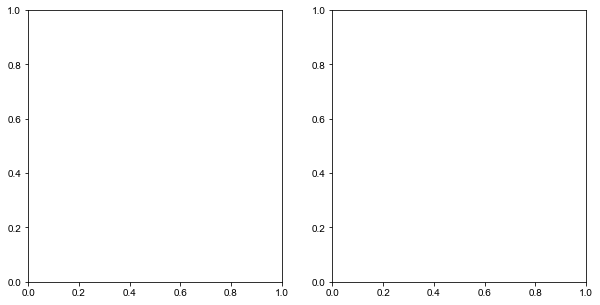

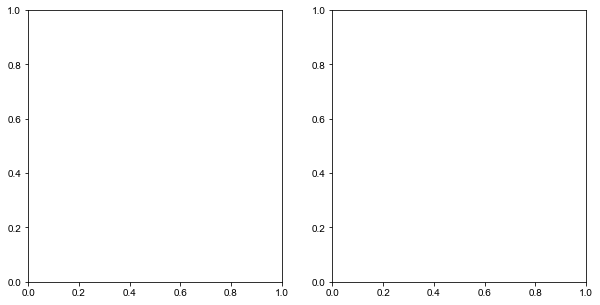

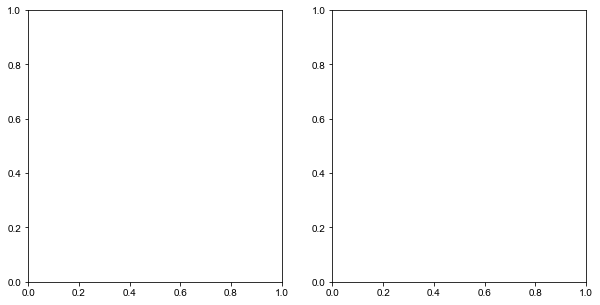

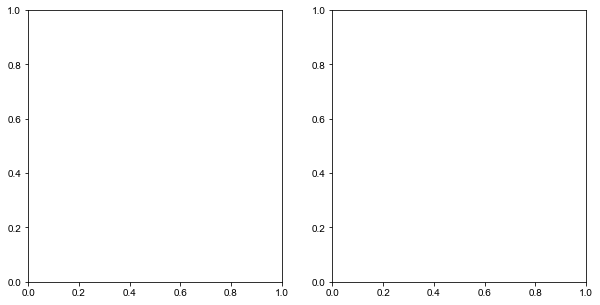

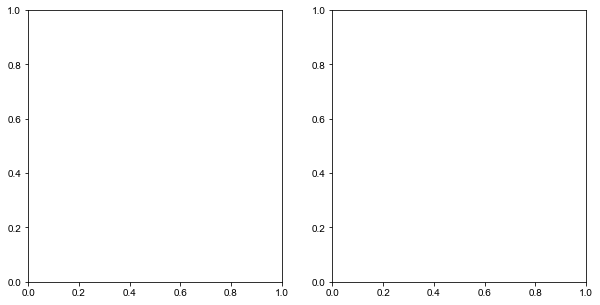

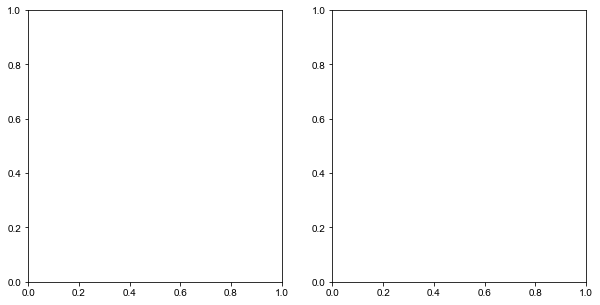

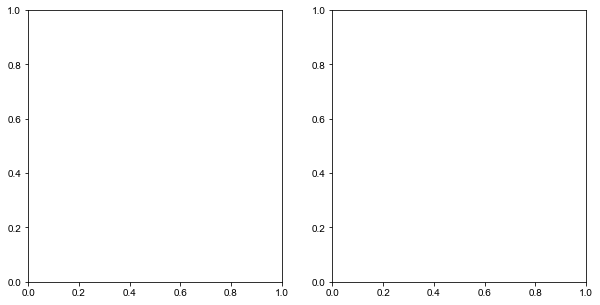

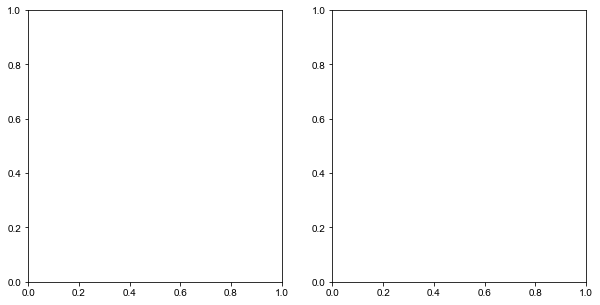

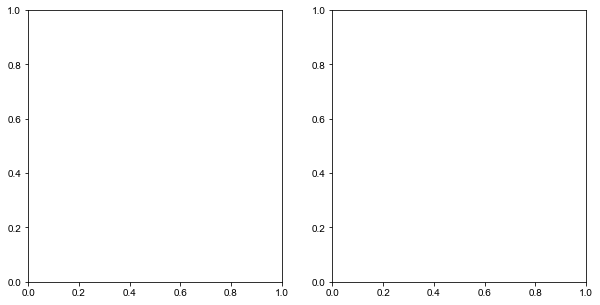

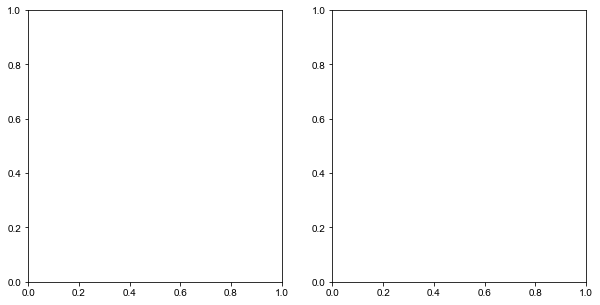

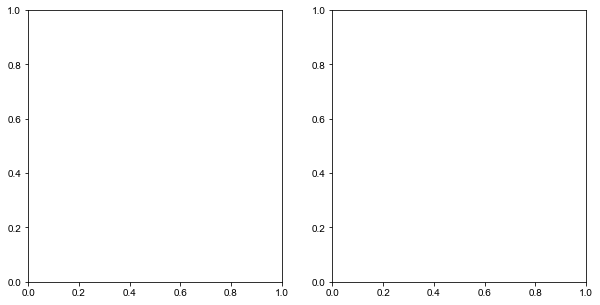

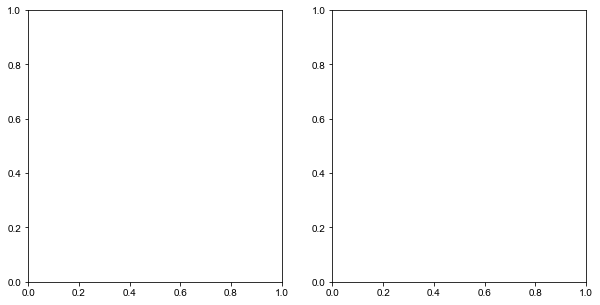

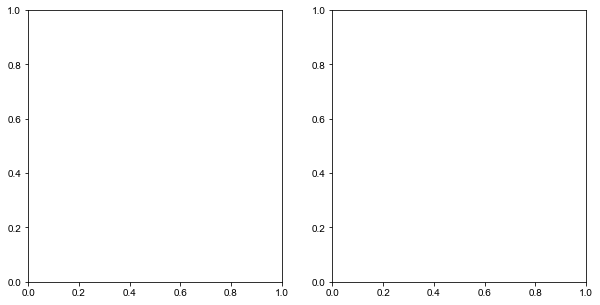

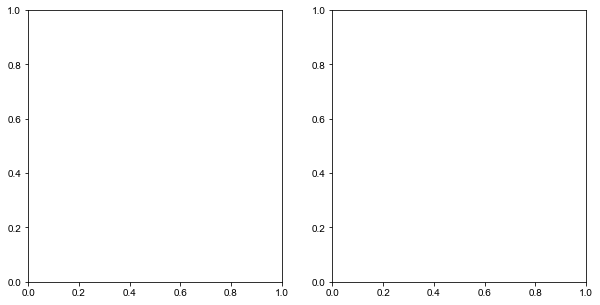

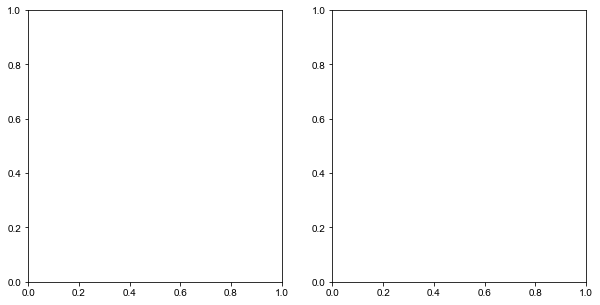

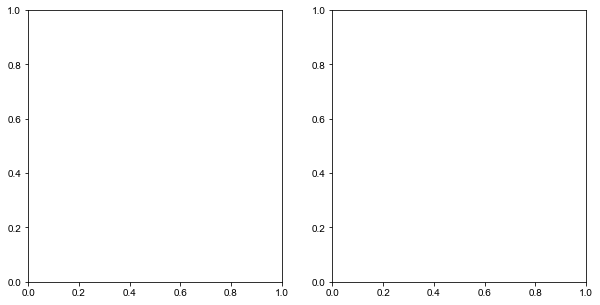

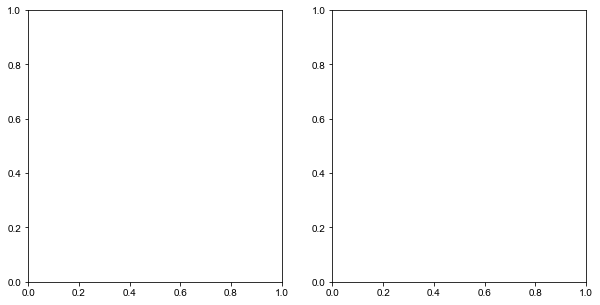

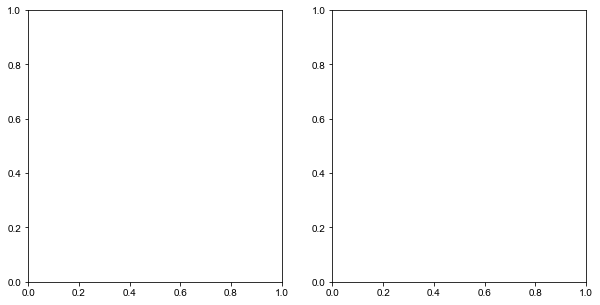

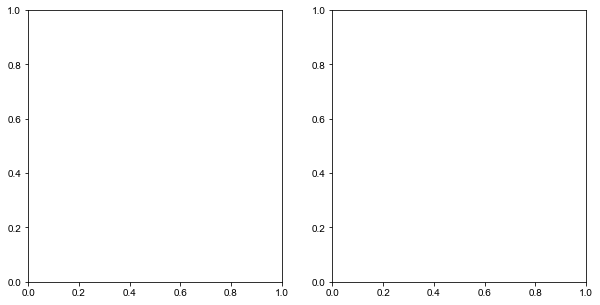

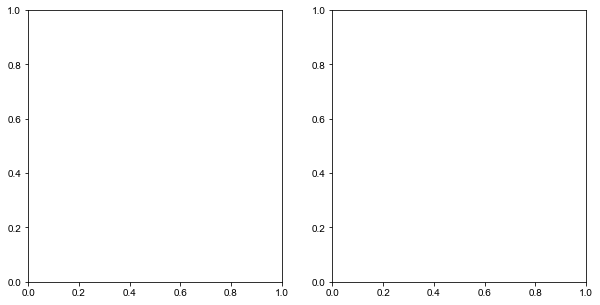

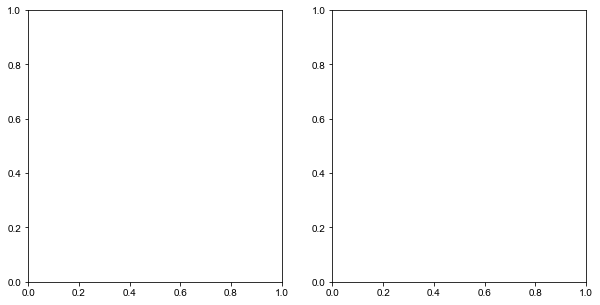

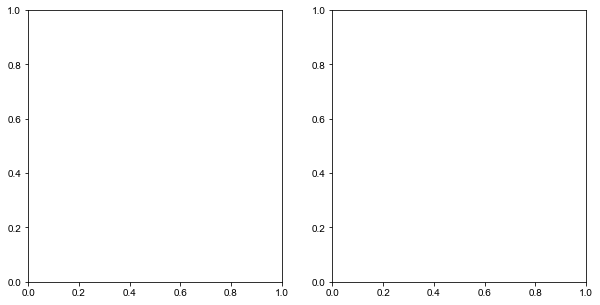

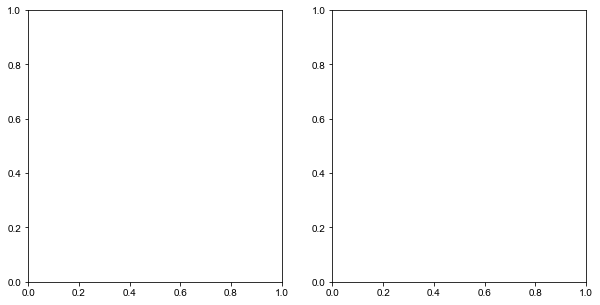

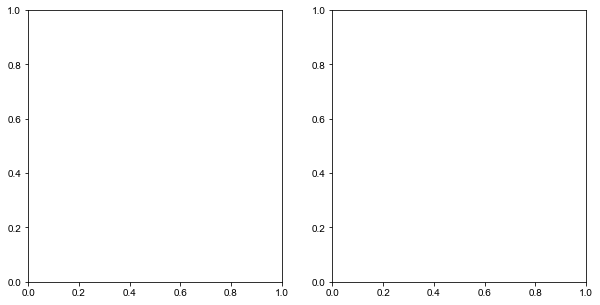

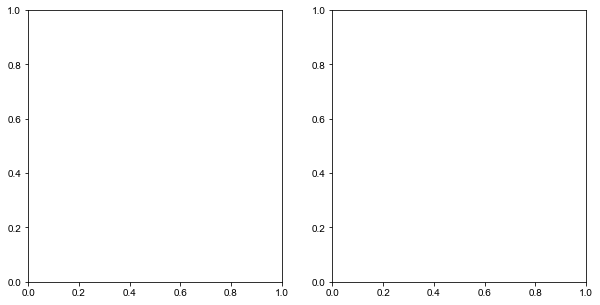

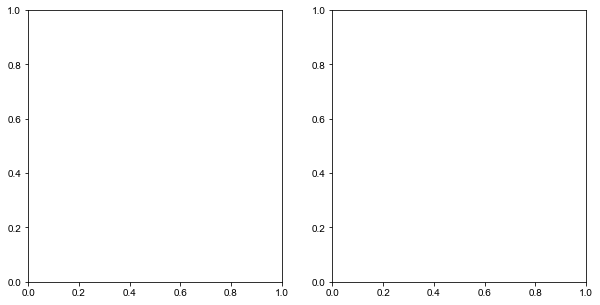

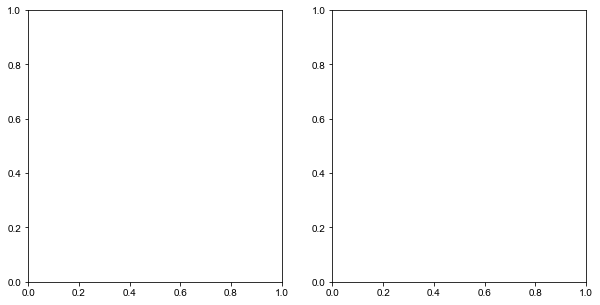

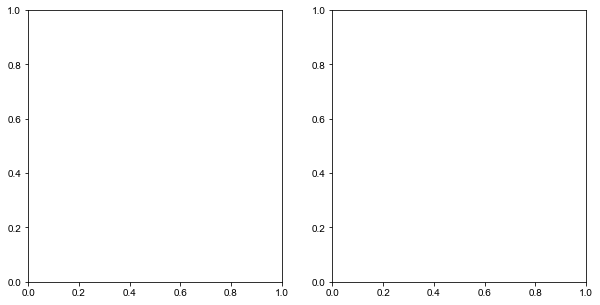

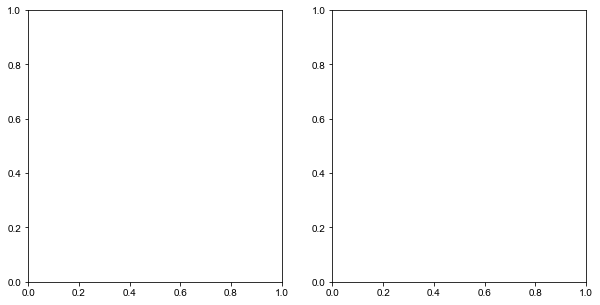

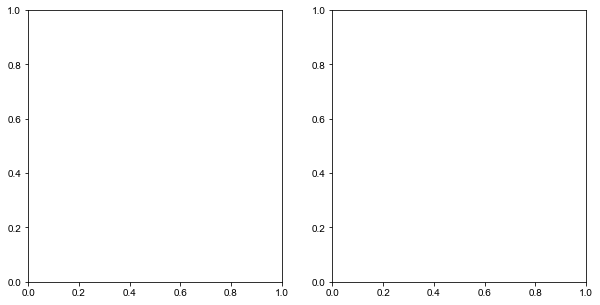

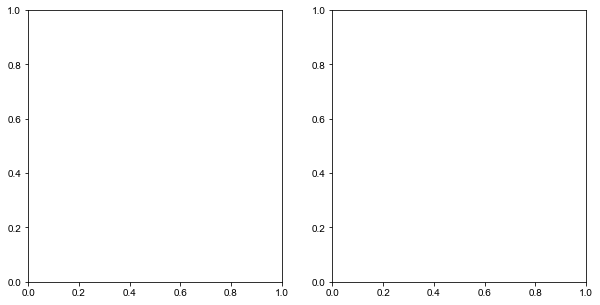

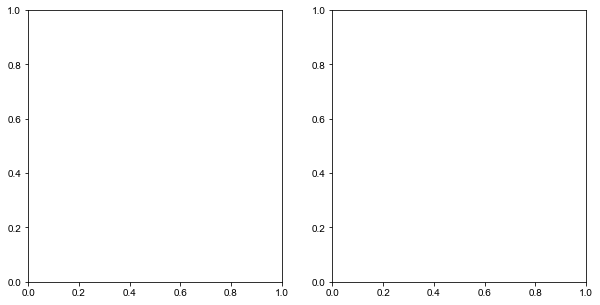

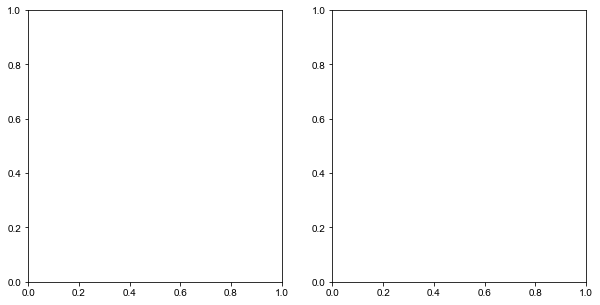

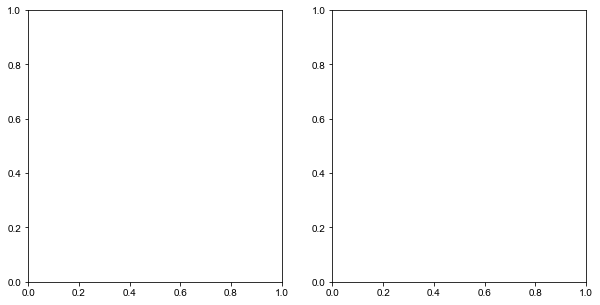

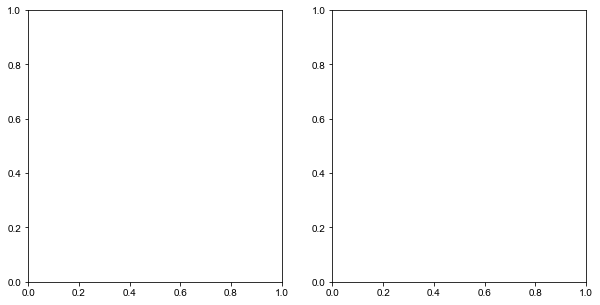

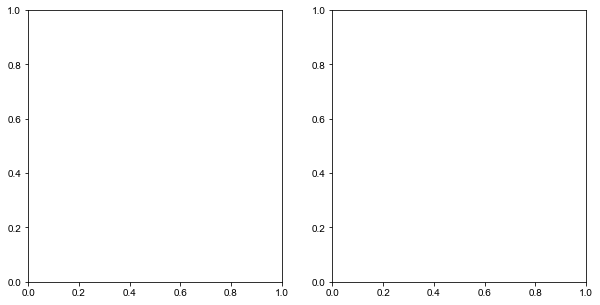

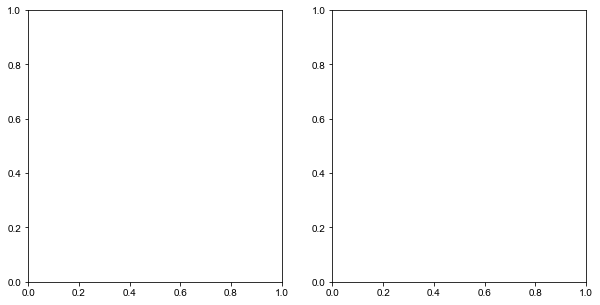

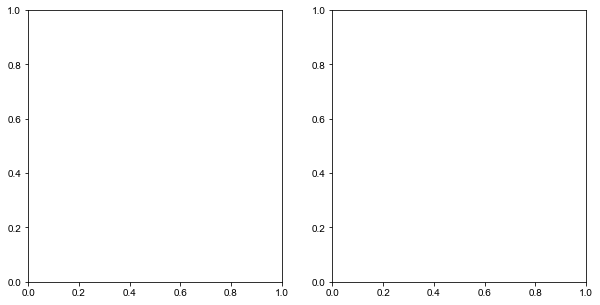

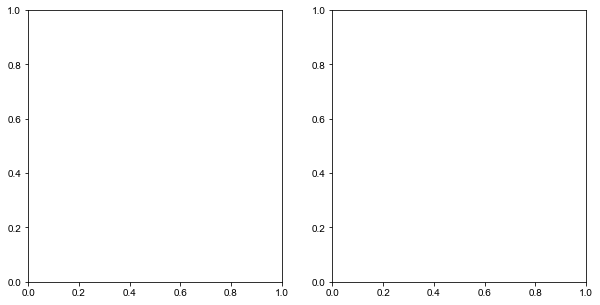

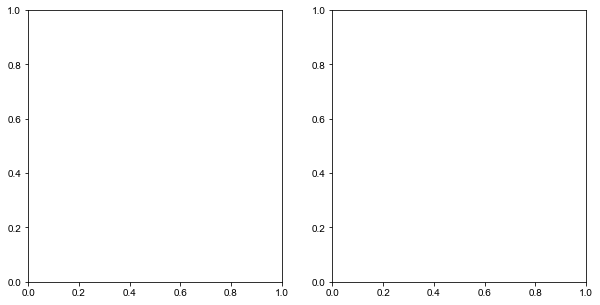

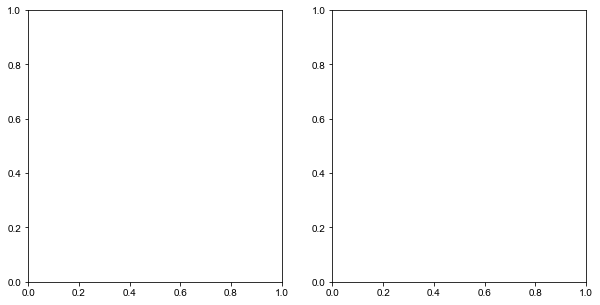

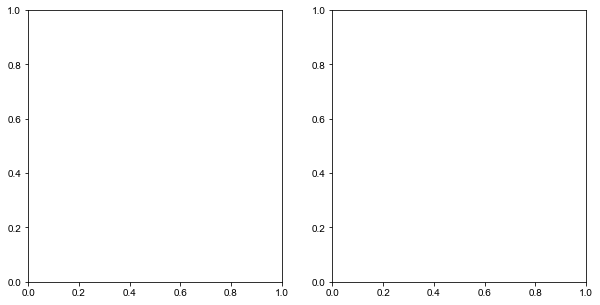

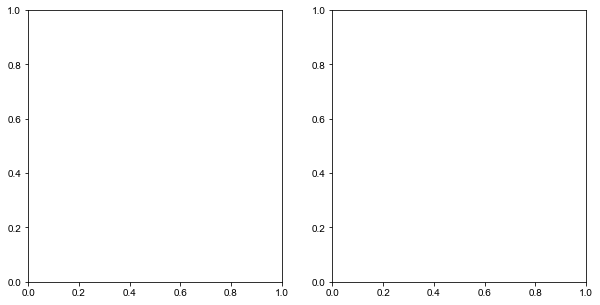

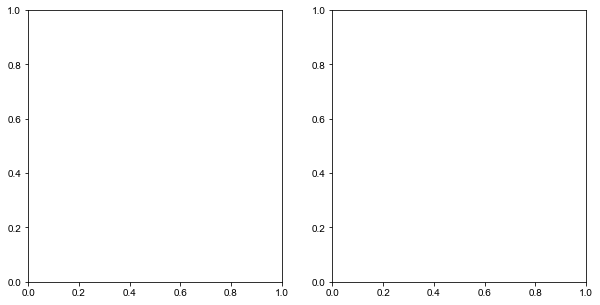

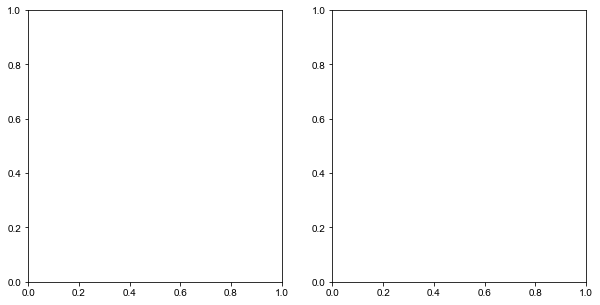

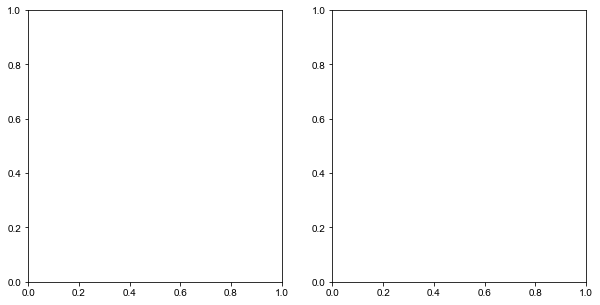

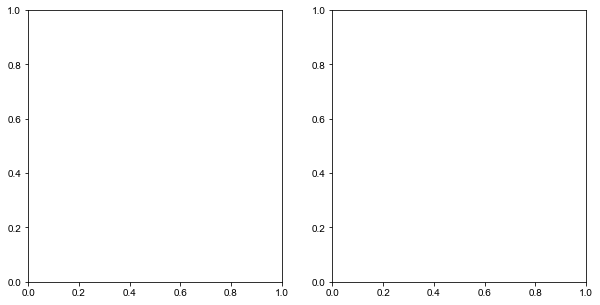

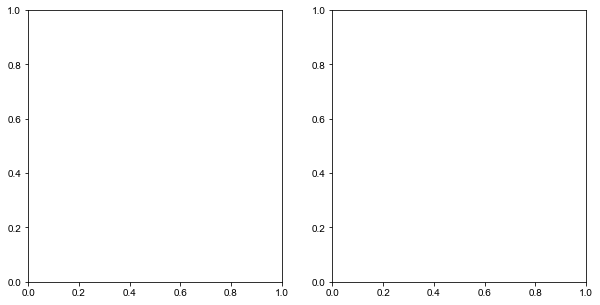

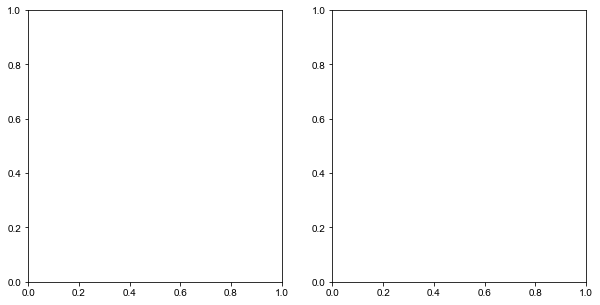

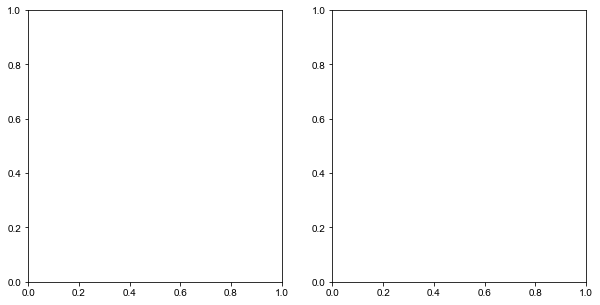

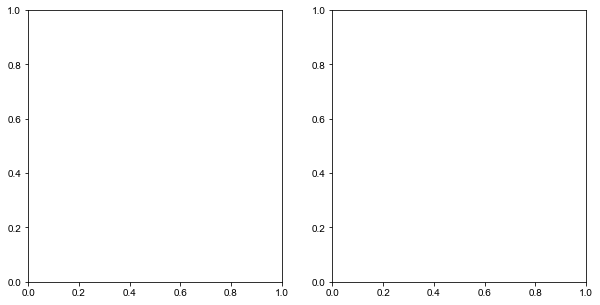

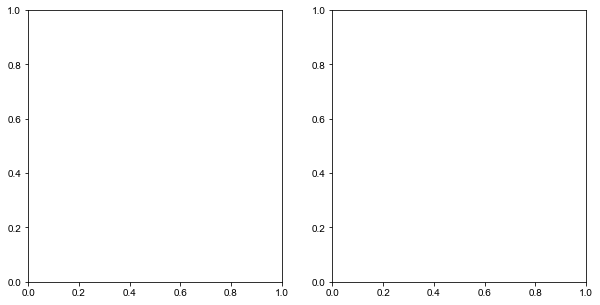

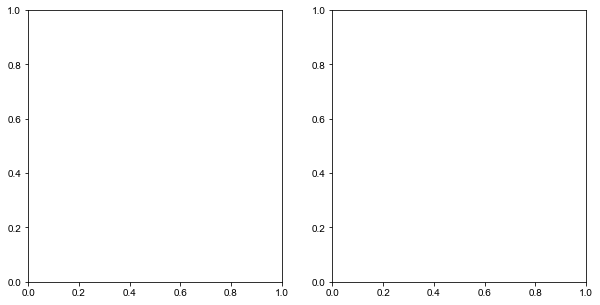

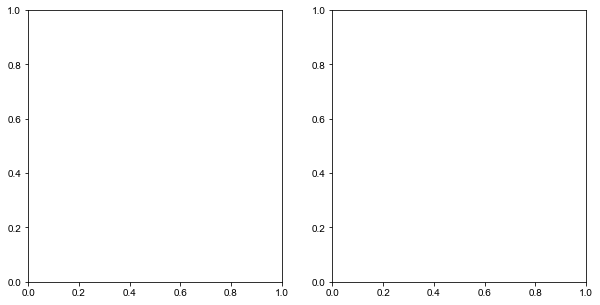

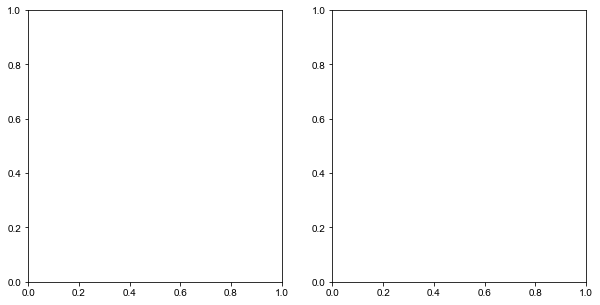

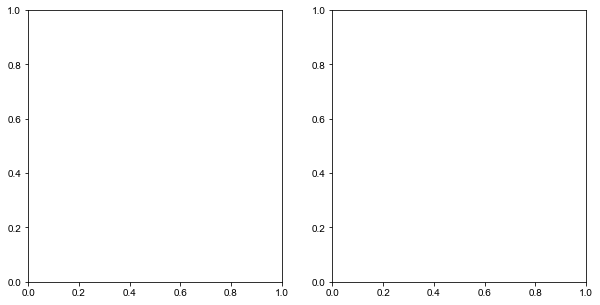

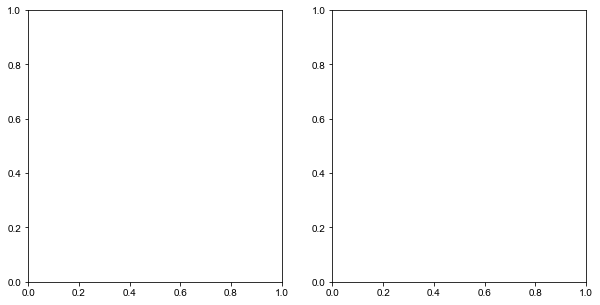

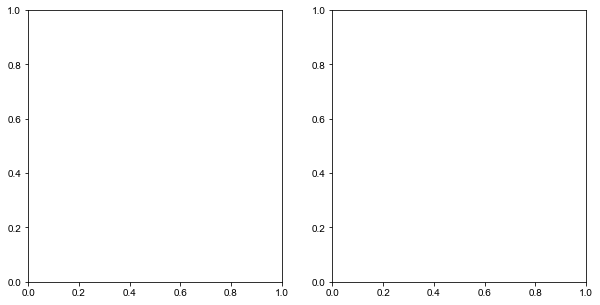

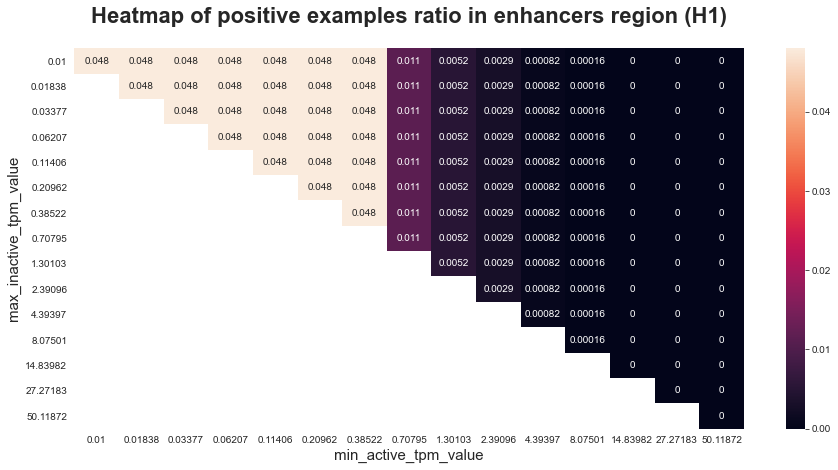

None

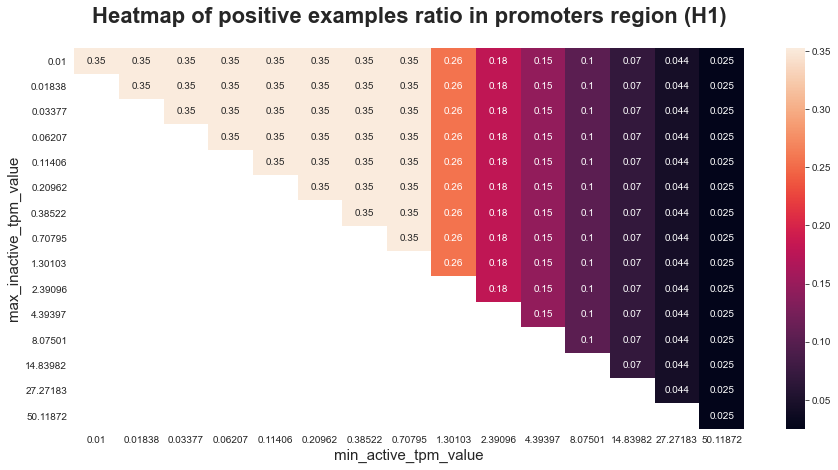

None

skipping 0 in HEK293, already done
skipping 1 in HEK293, already done
skipping 2 in HEK293, already done
skipping 3 in HEK293, already done
skipping 4 in HEK293, already done
skipping 5 in HEK293, already done
skipping 6 in HEK293, already done
skipping 7 in HEK293, already done
skipping 8 in HEK293, already done
skipping 9 in HEK293, already done
skipping 10 in HEK293, already done
skipping 11 in HEK293, already done
skipping 12 in HEK293, already done
skipping 13 in HEK293, already done
skipping 14 in HEK293, already done
skipping 15 in HEK293, already done
skipping 16 in HEK293, already done
skipping 17 in HEK293, already done
skipping 18 in HEK293, already done
skipping 19 in HEK293, already done
skipping 20 in HEK293, already done
skipping 21 in HEK293, already done
skipping 22 in HEK293, already done
skipping 23 in HEK293, already done
skipping 24 in HEK293, already done
skipping 25 in HEK293, already done
skipping 26 in HEK293, already done
skipping 27 in HEK293, already done
sk

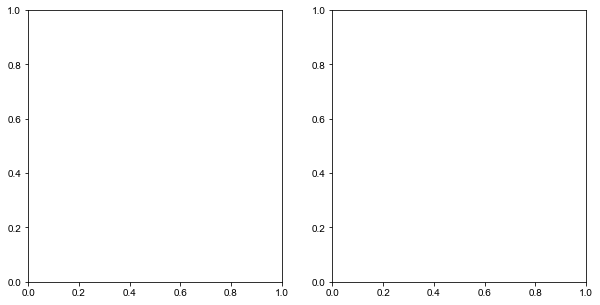

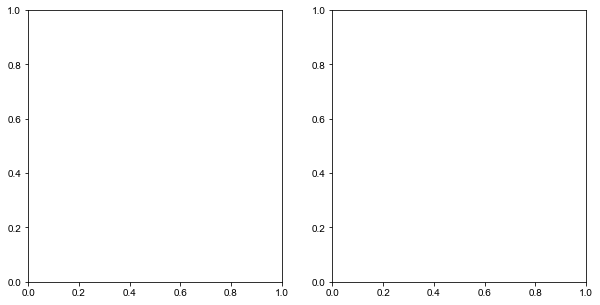

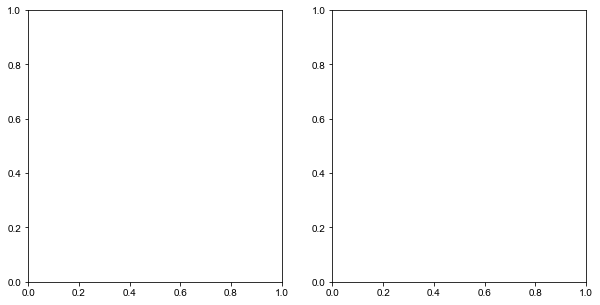

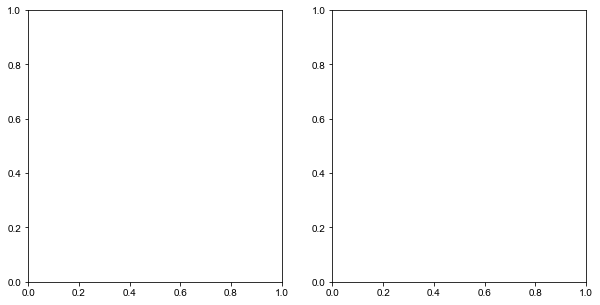

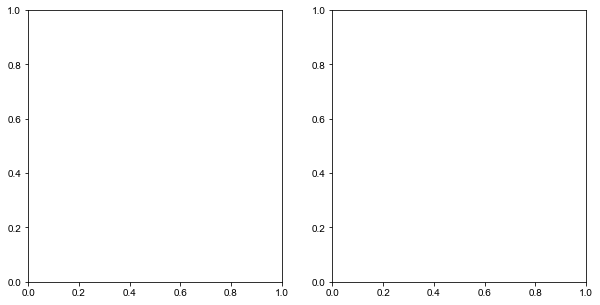

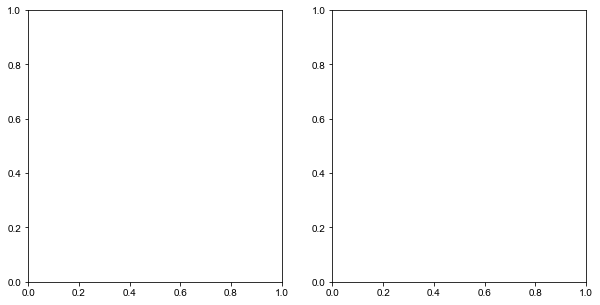

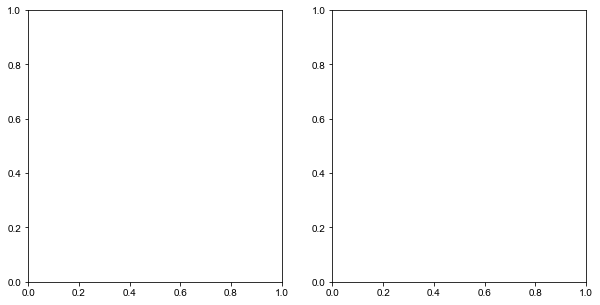

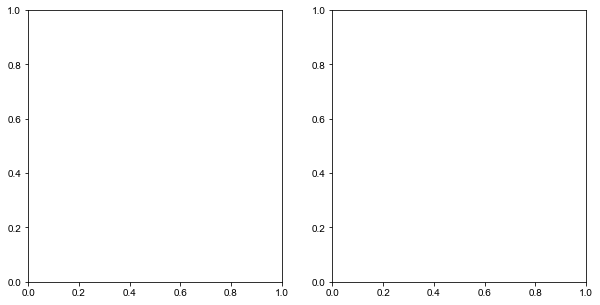

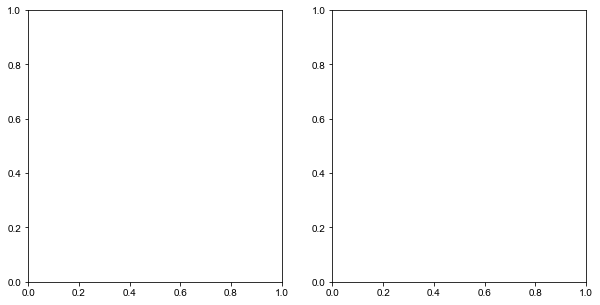

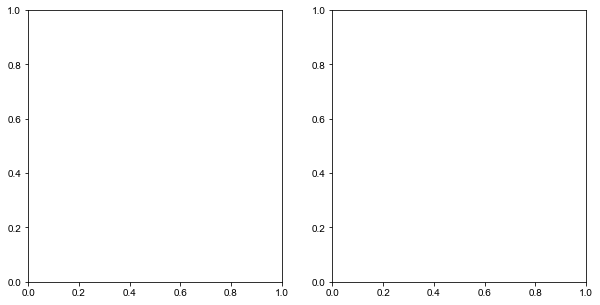

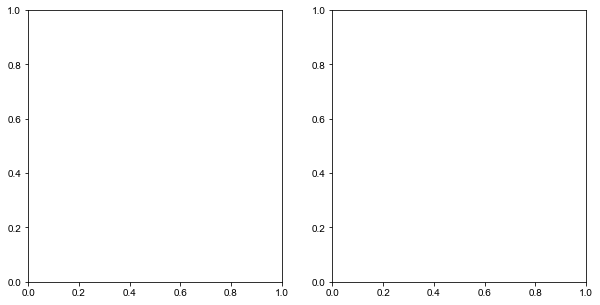

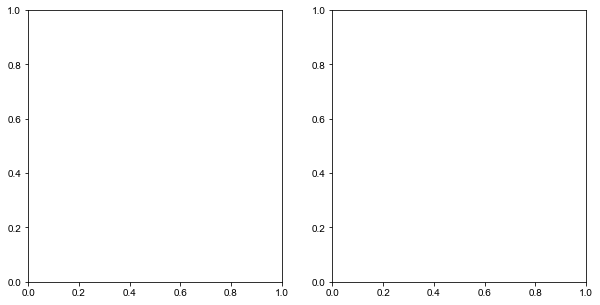

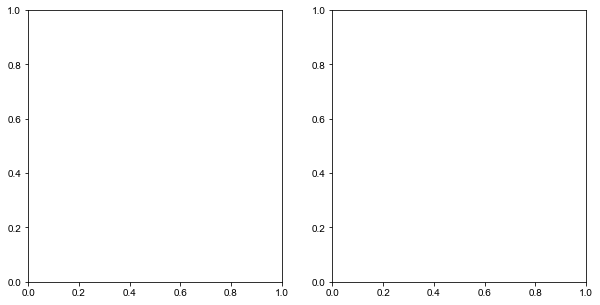

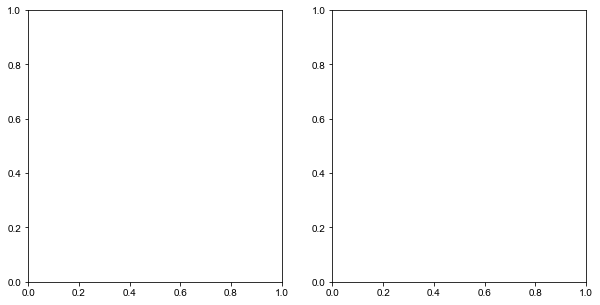

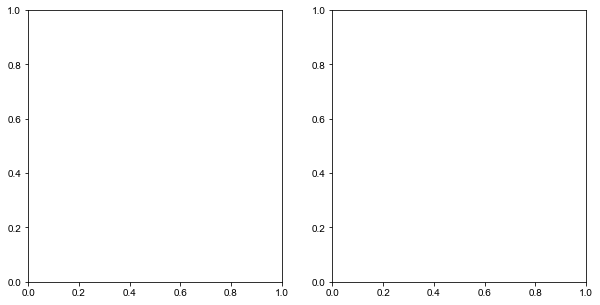

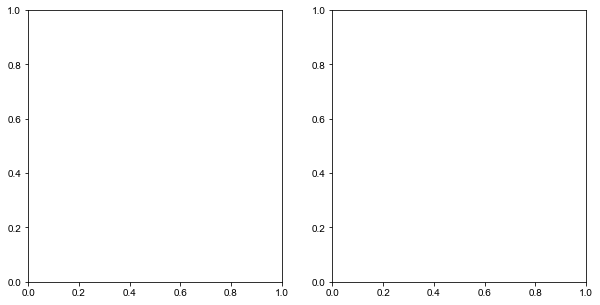

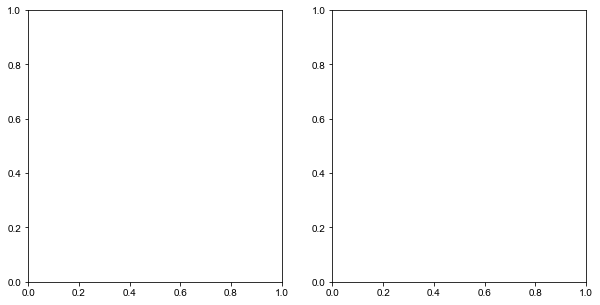

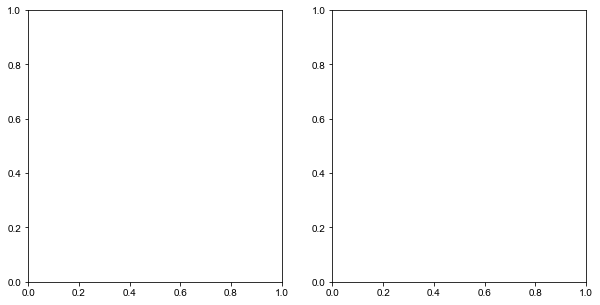

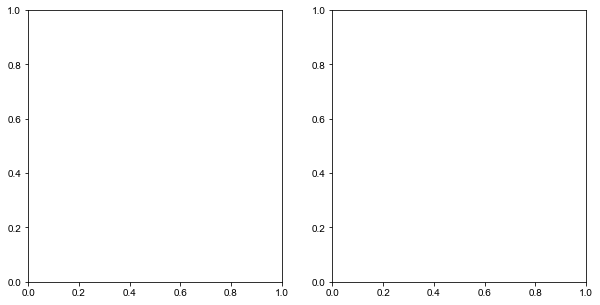

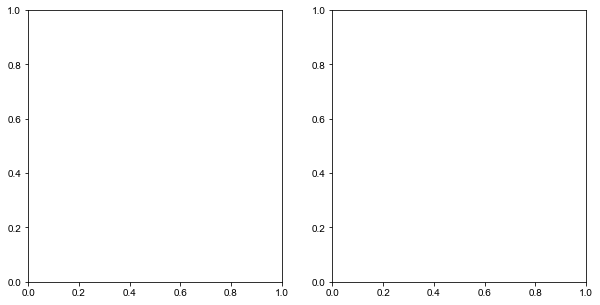

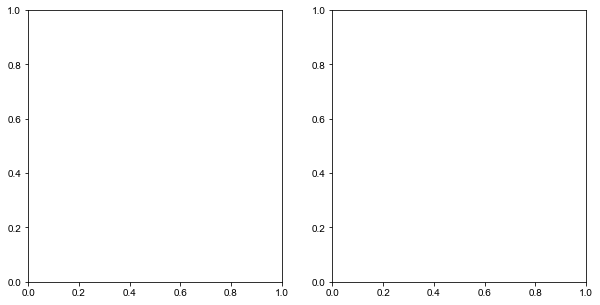

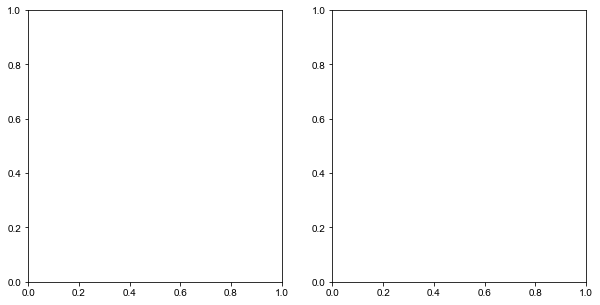

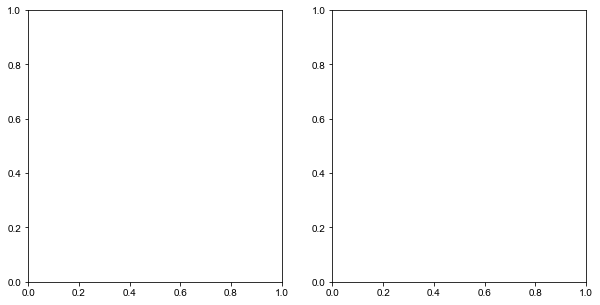

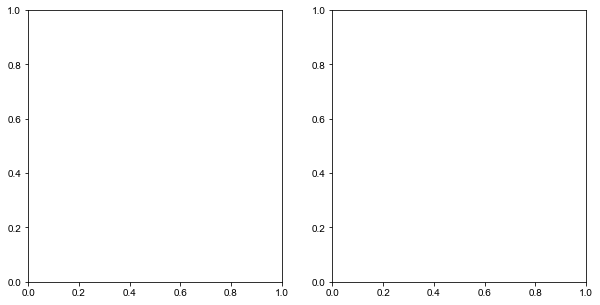

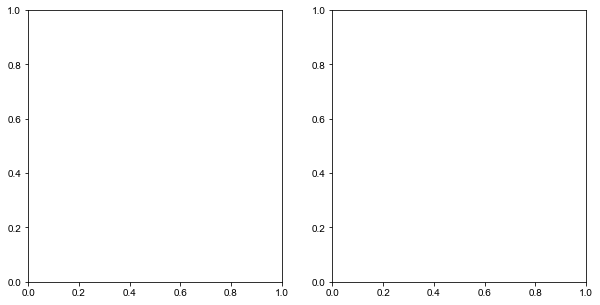

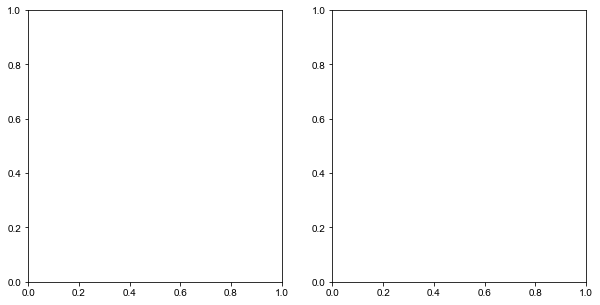

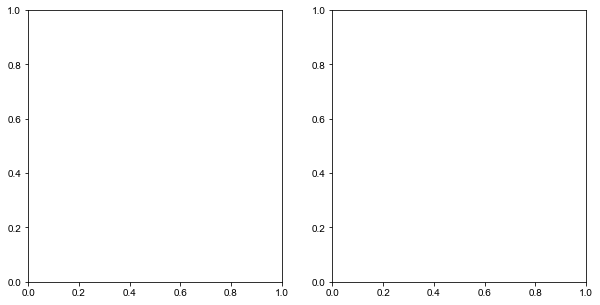

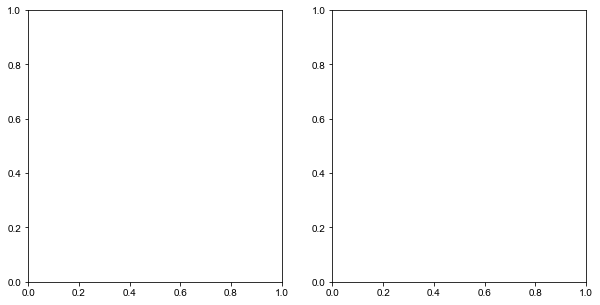

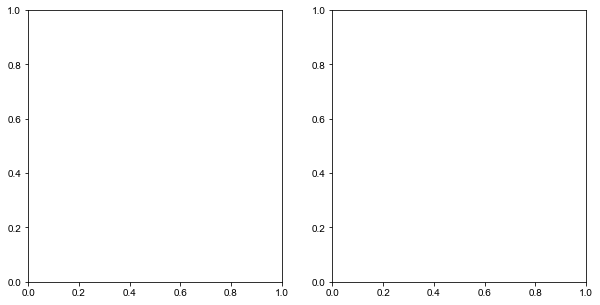

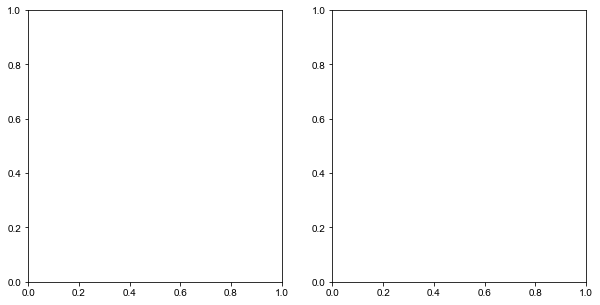

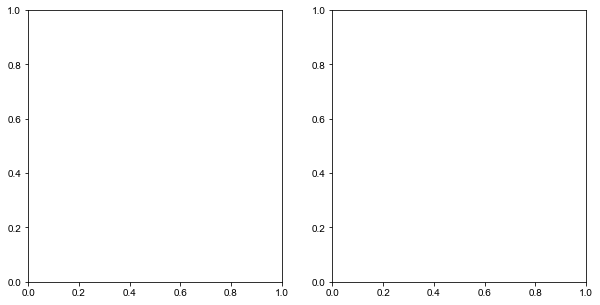

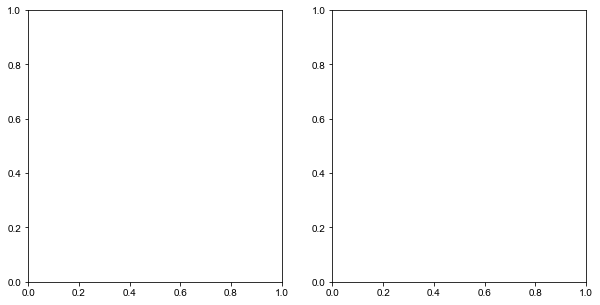

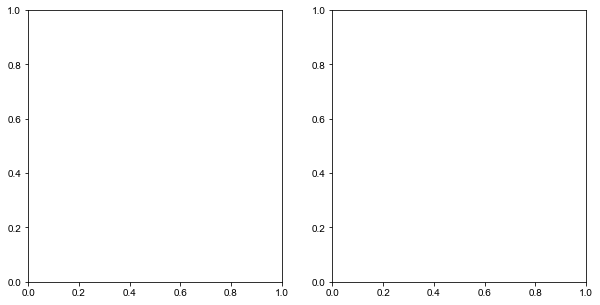

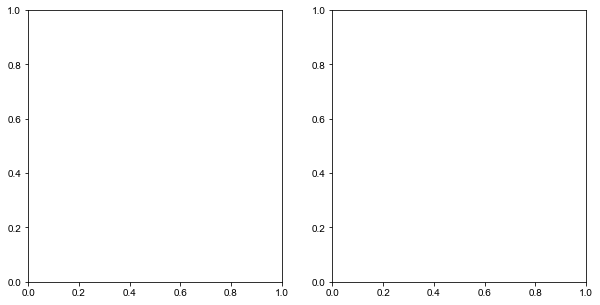

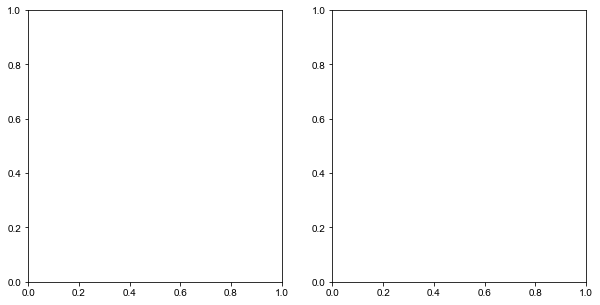

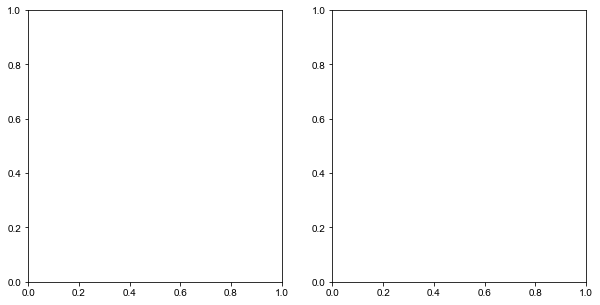

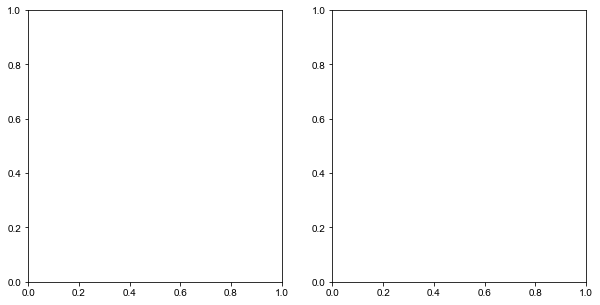

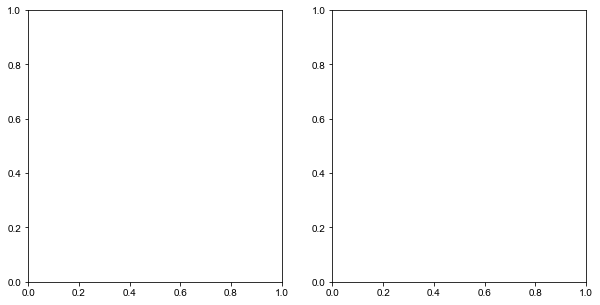

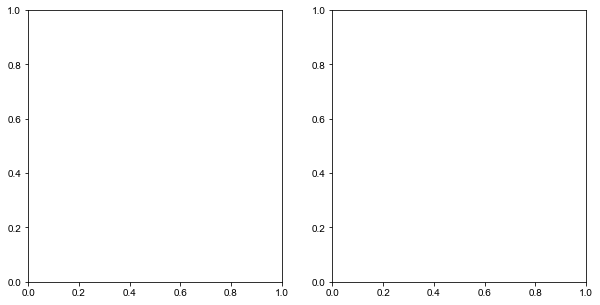

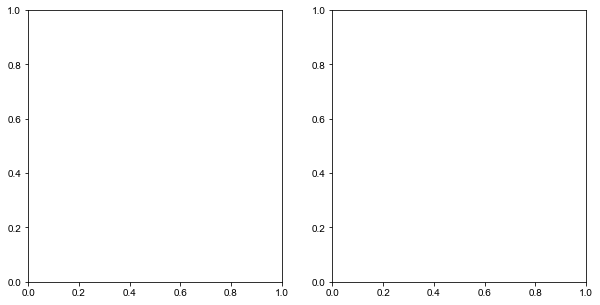

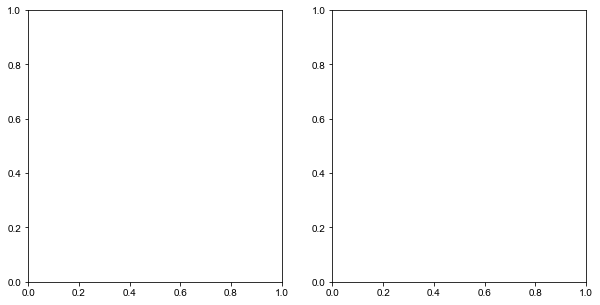

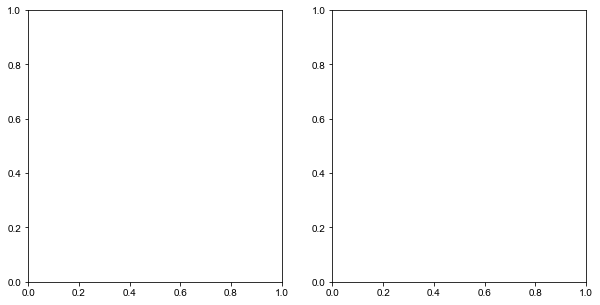

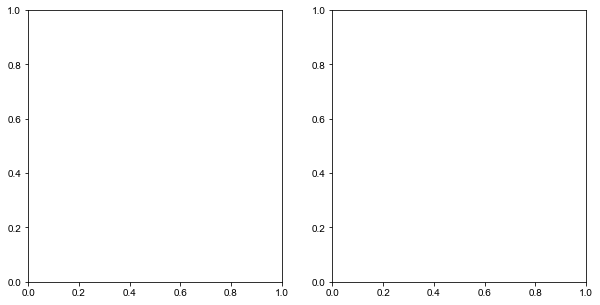

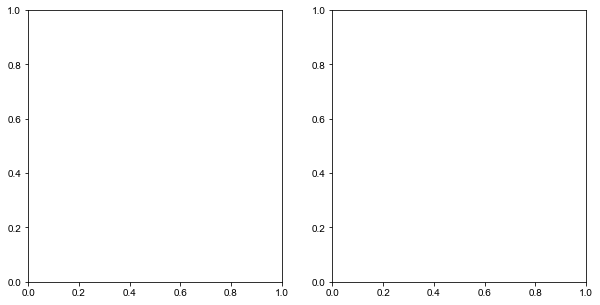

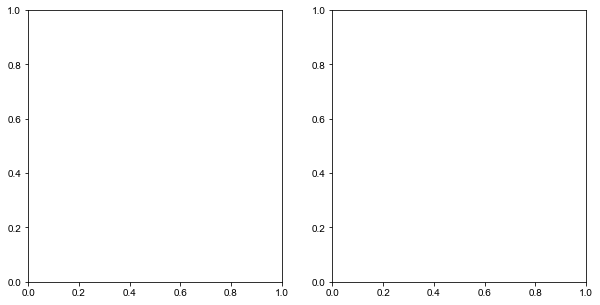

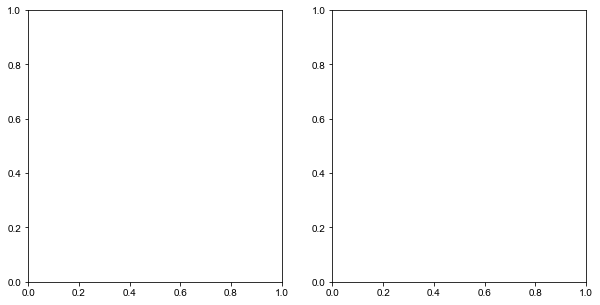

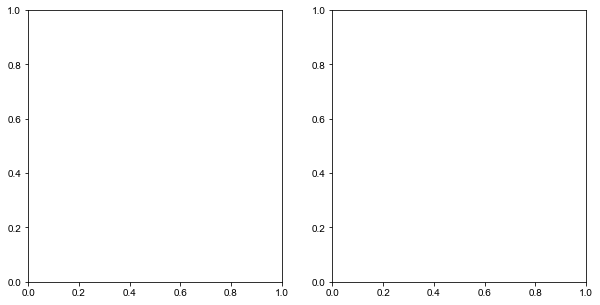

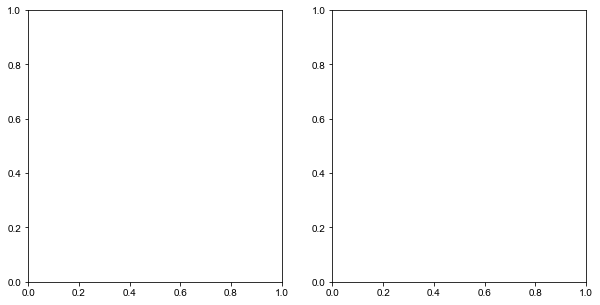

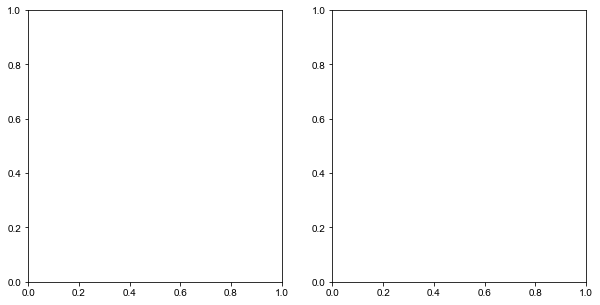

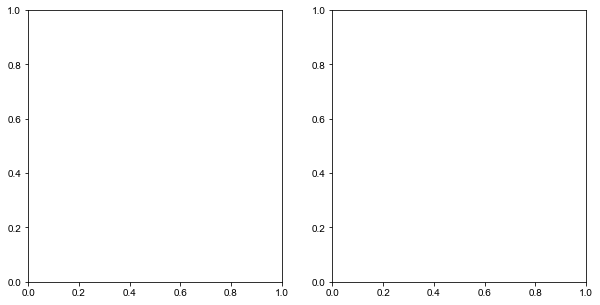

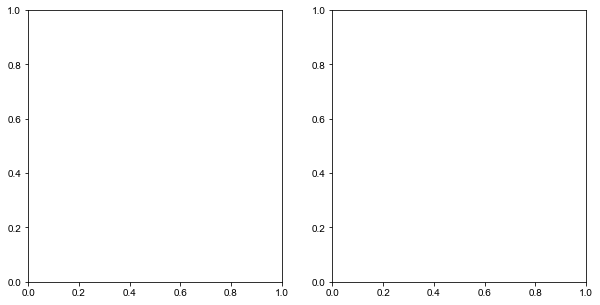

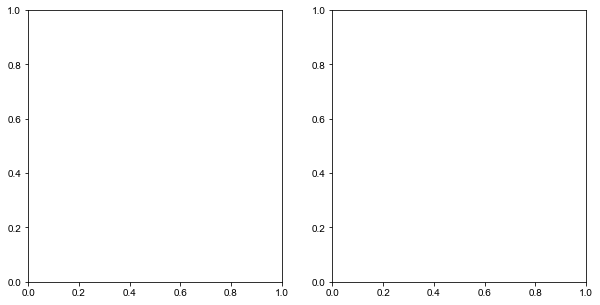

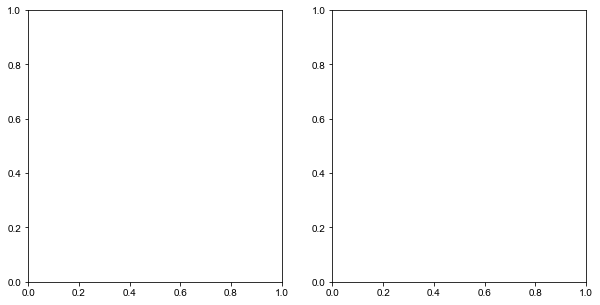

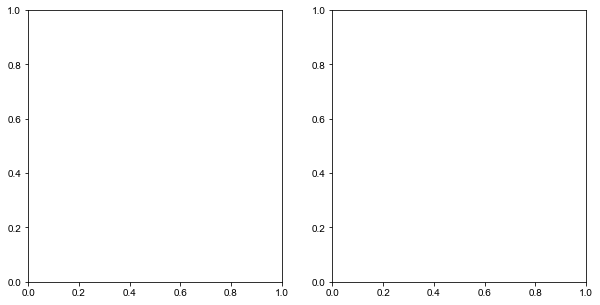

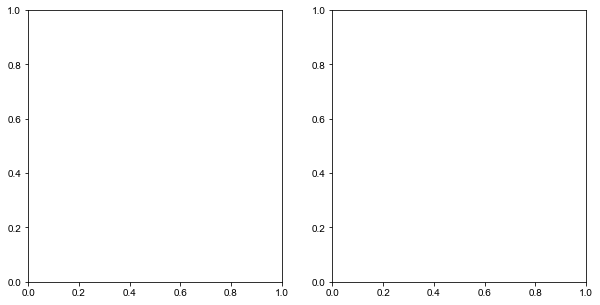

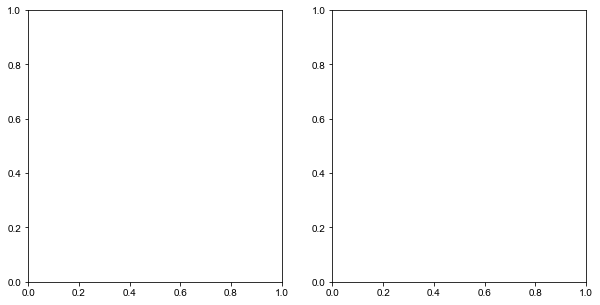

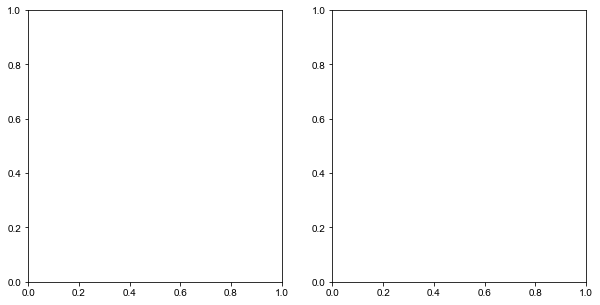

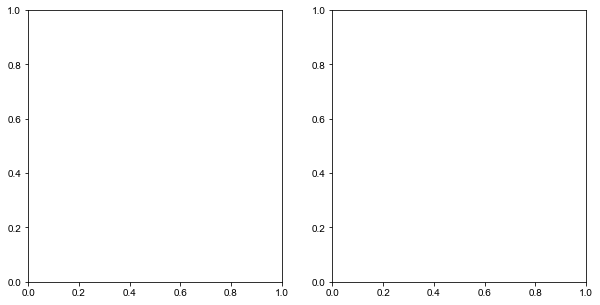

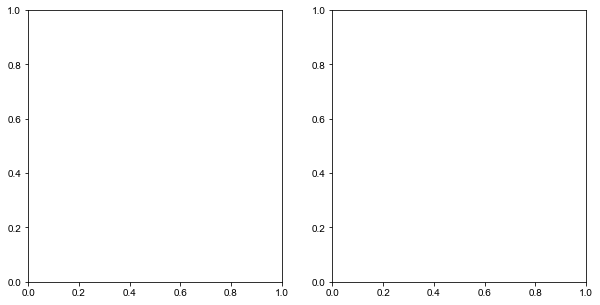

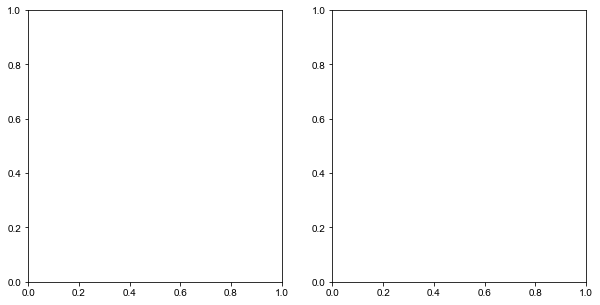

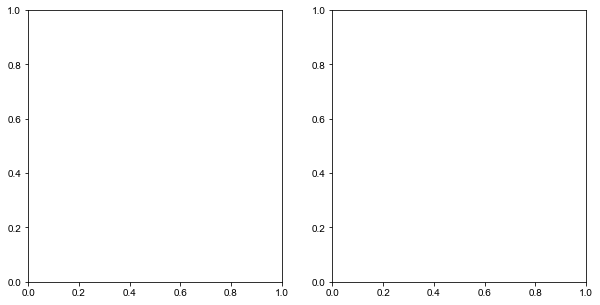

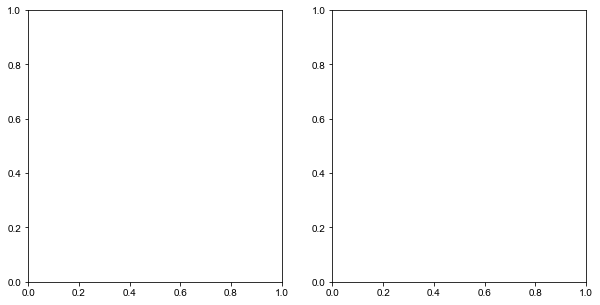

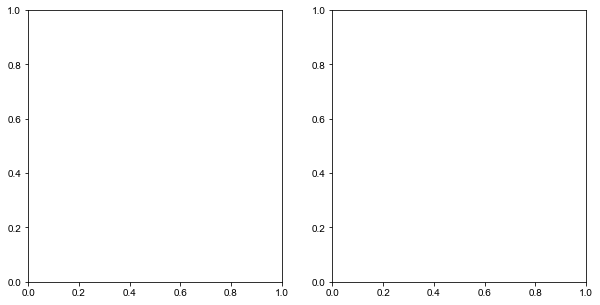

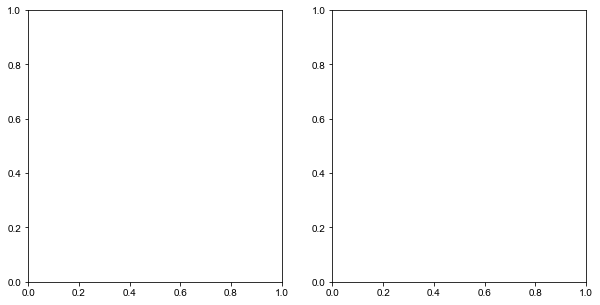

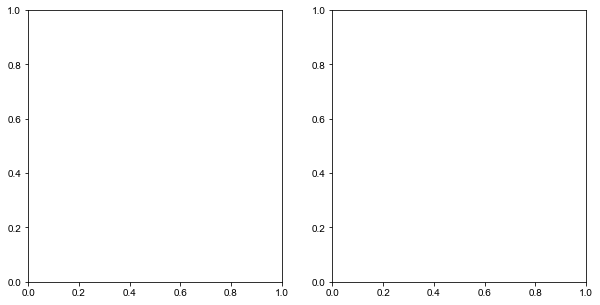

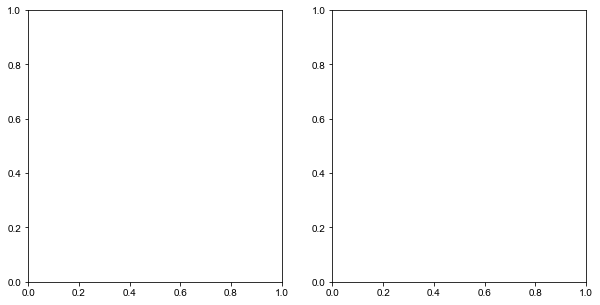

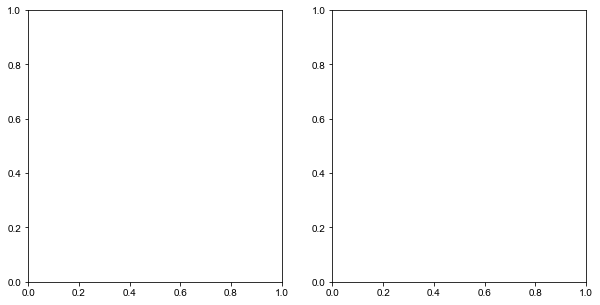

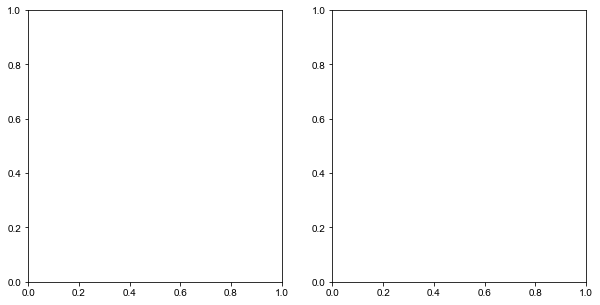

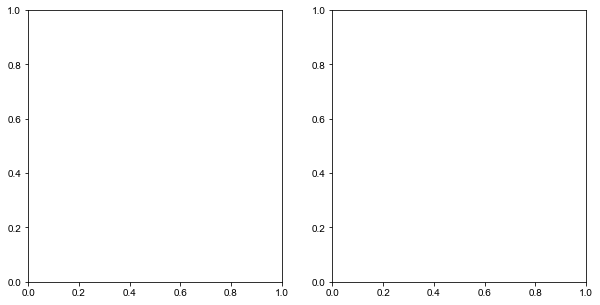

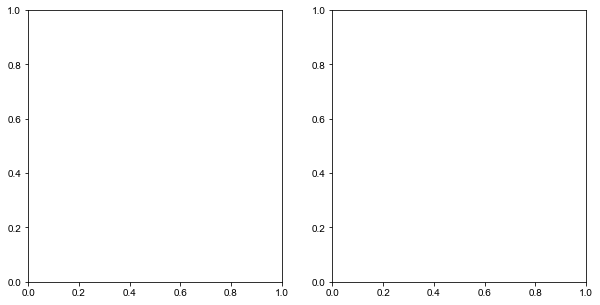

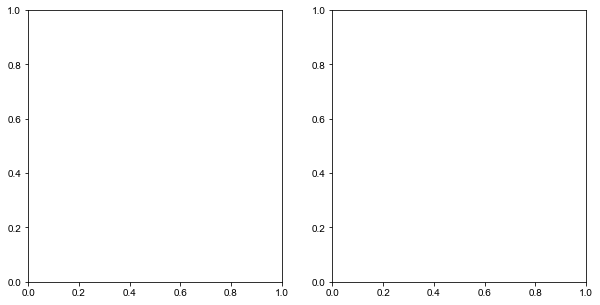

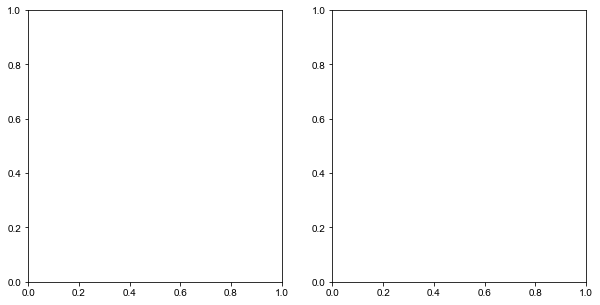

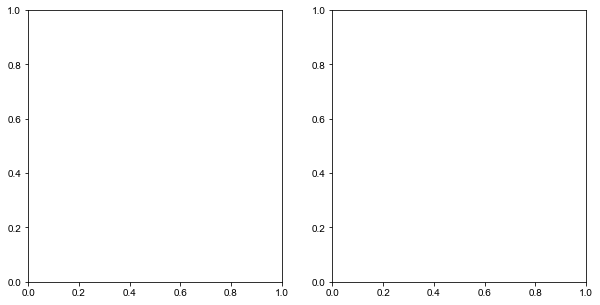

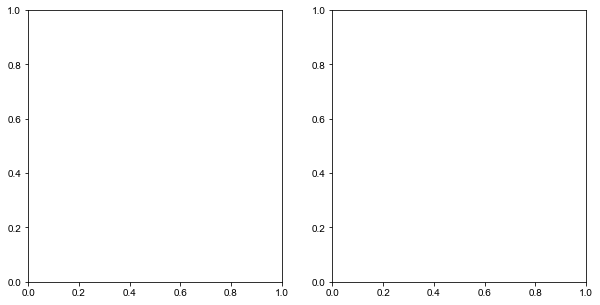

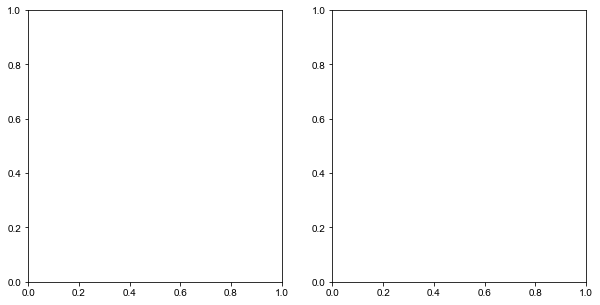

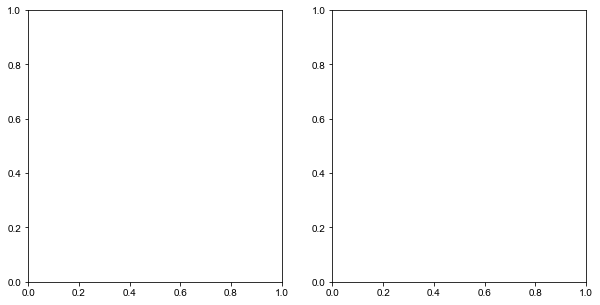

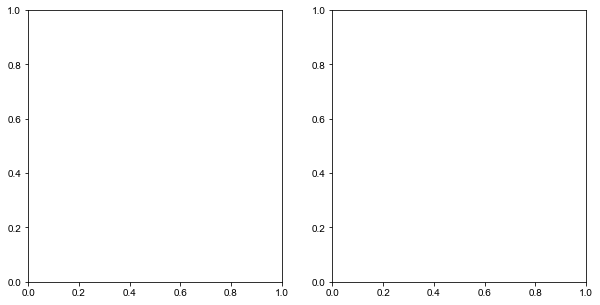

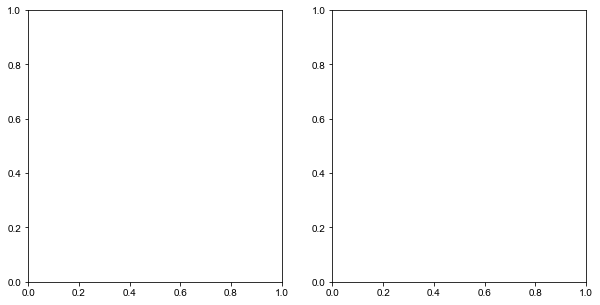

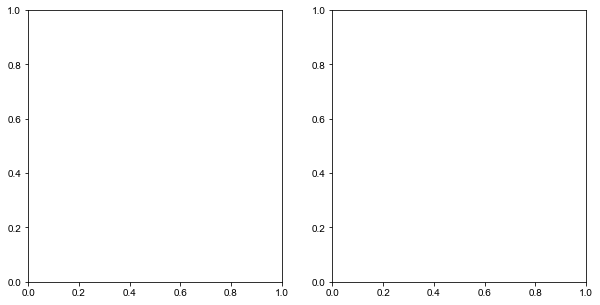

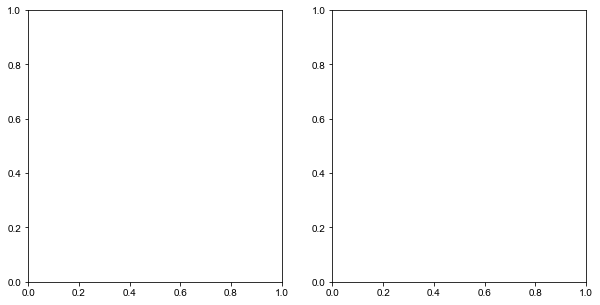

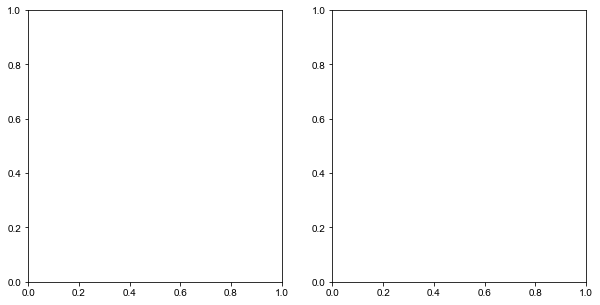

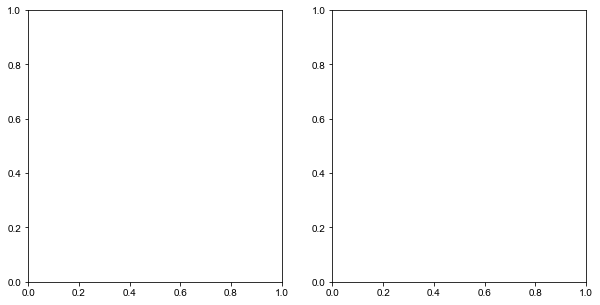

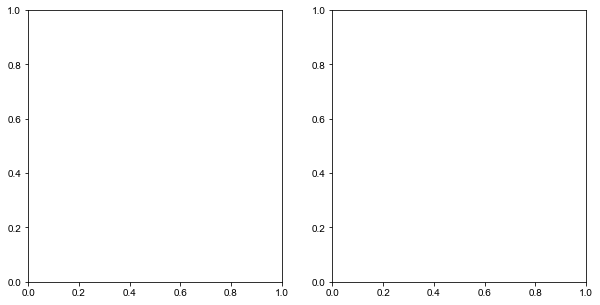

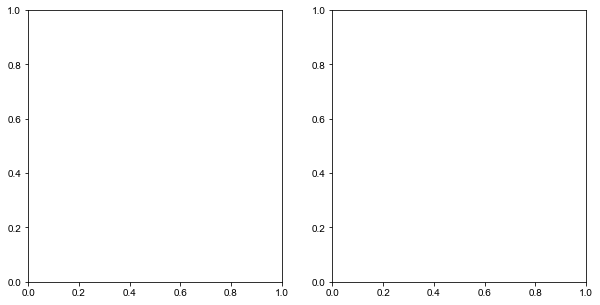

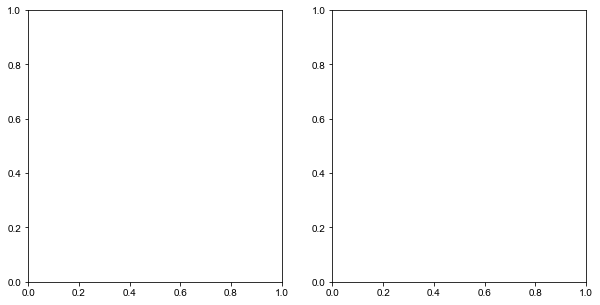

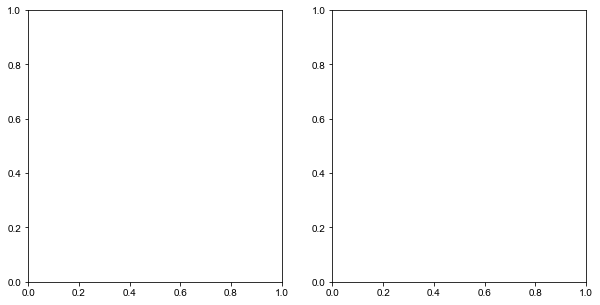

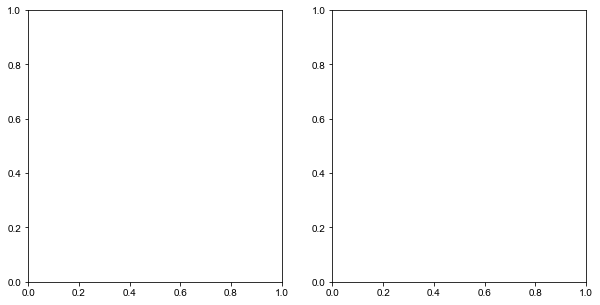

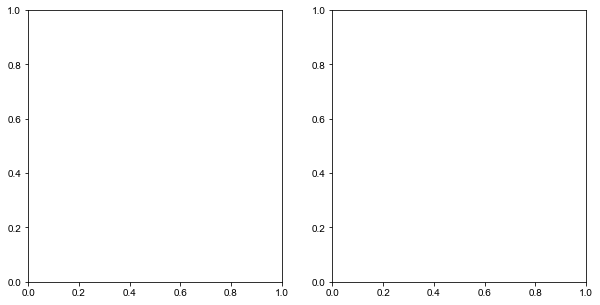

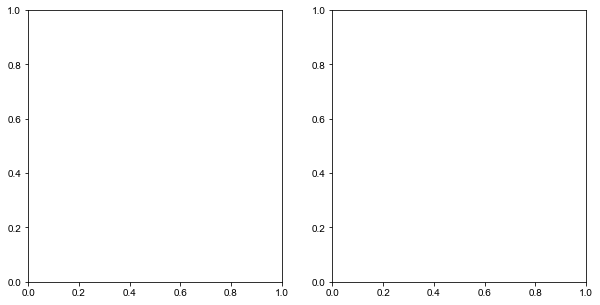

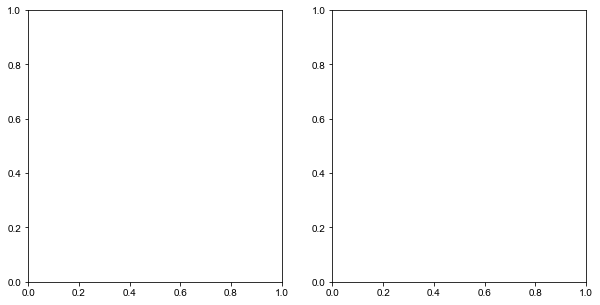

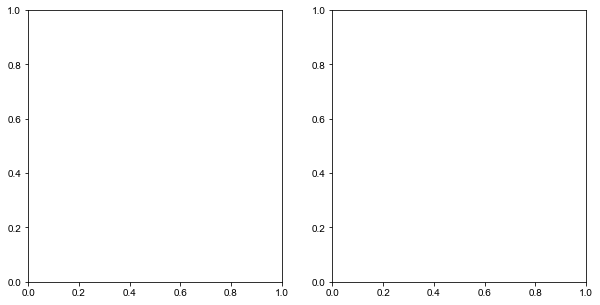

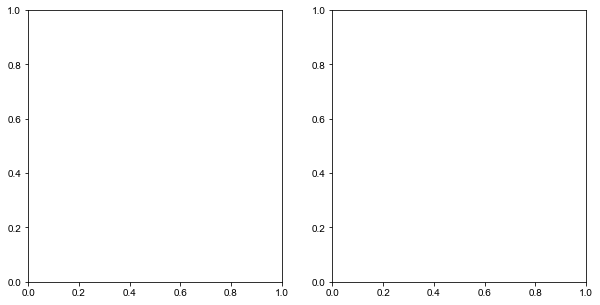

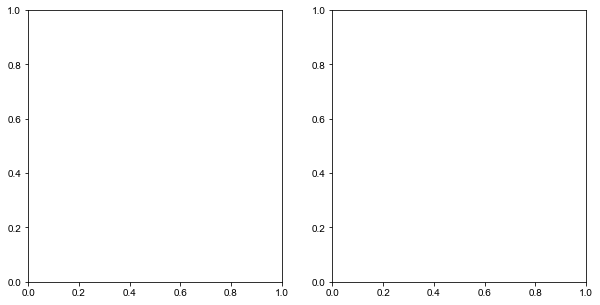

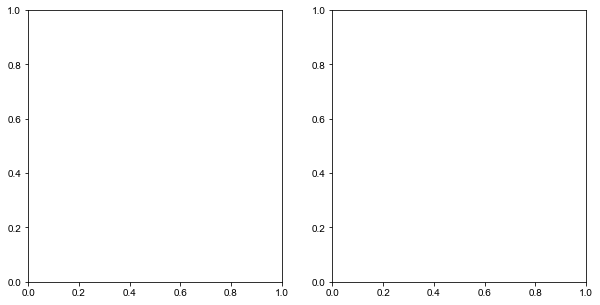

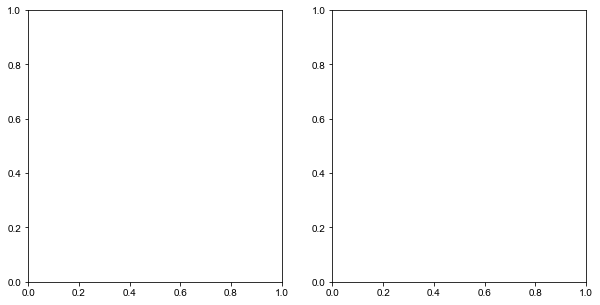

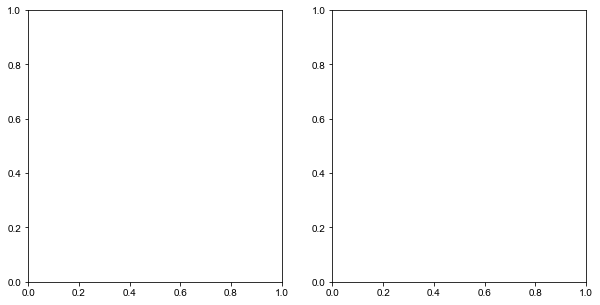

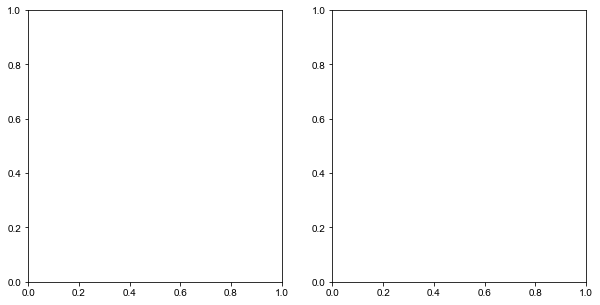

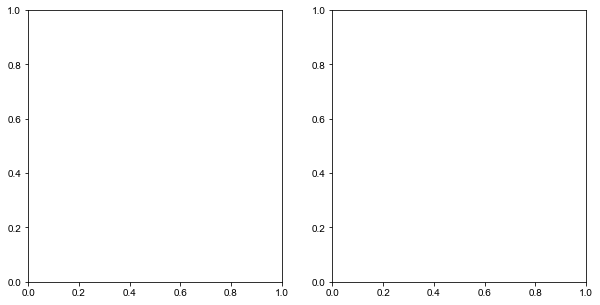

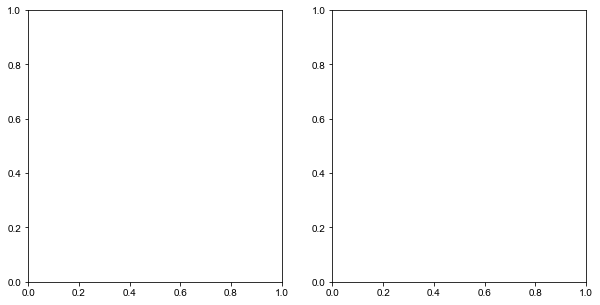

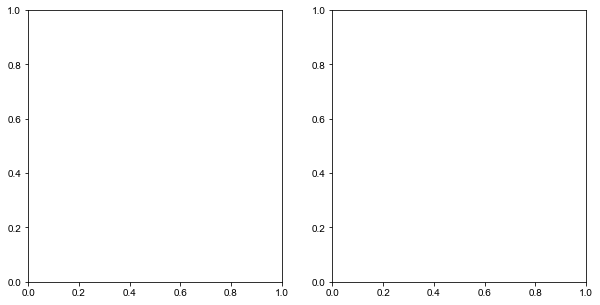

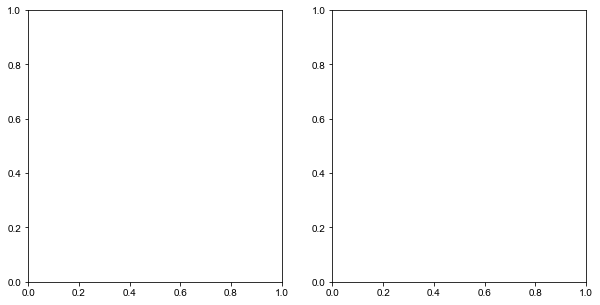

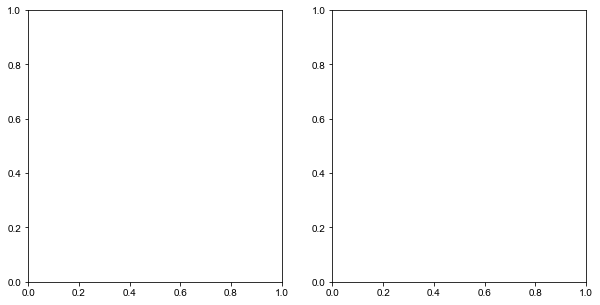

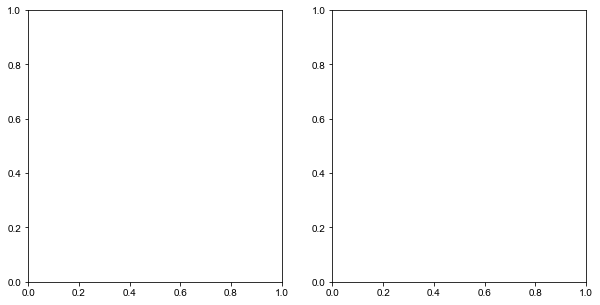

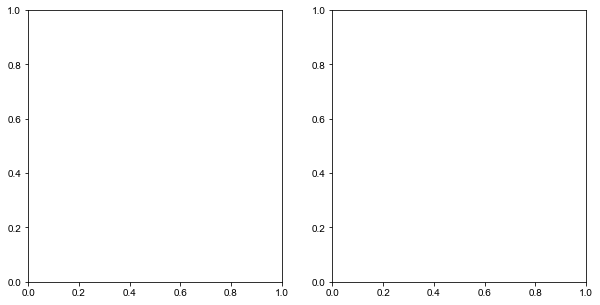

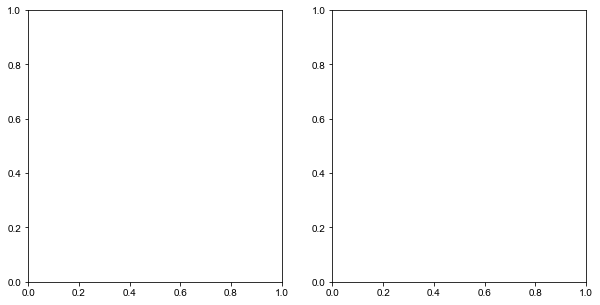

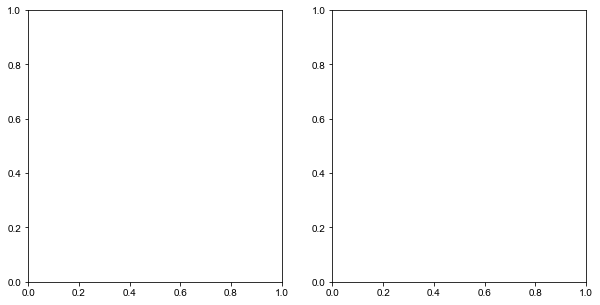

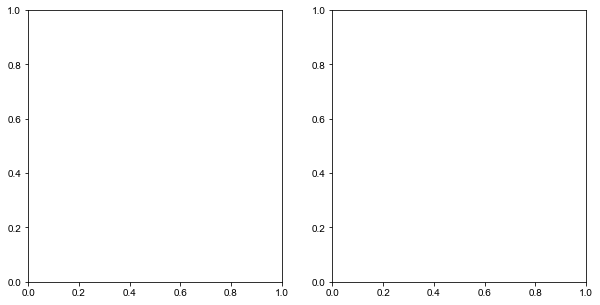

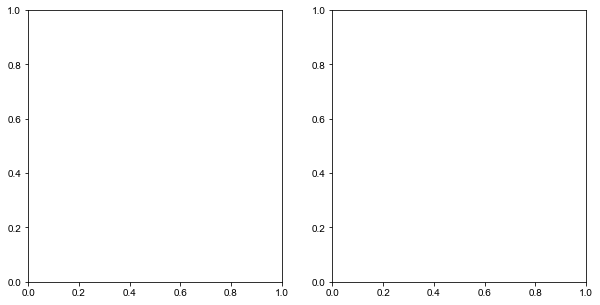

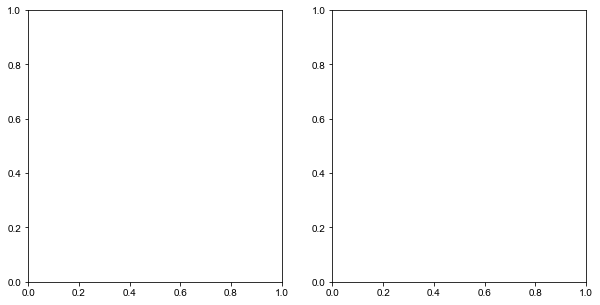

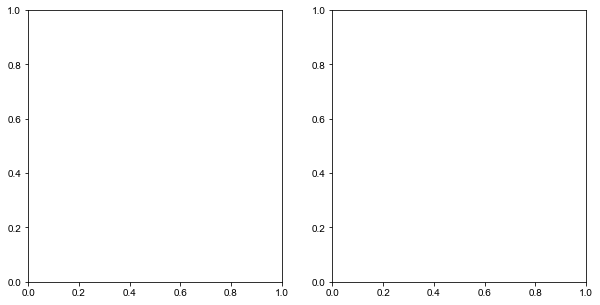

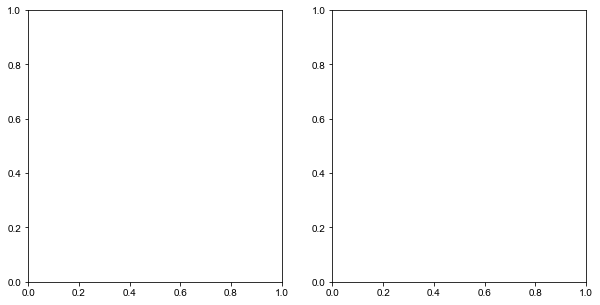

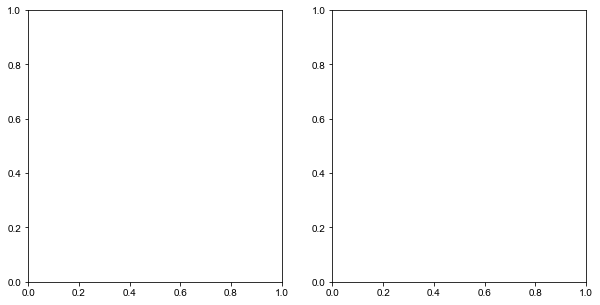

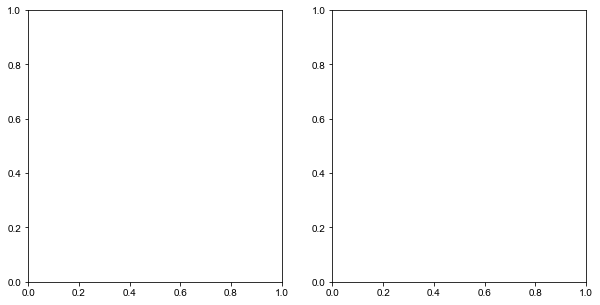

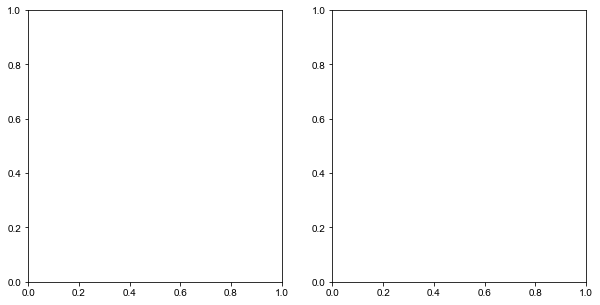

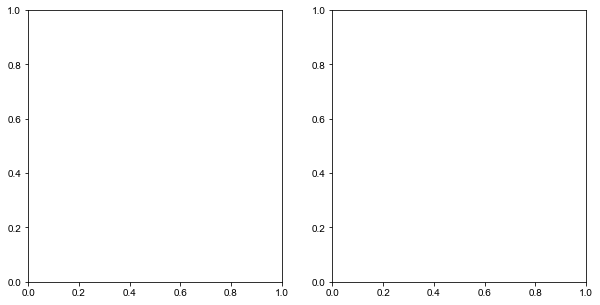

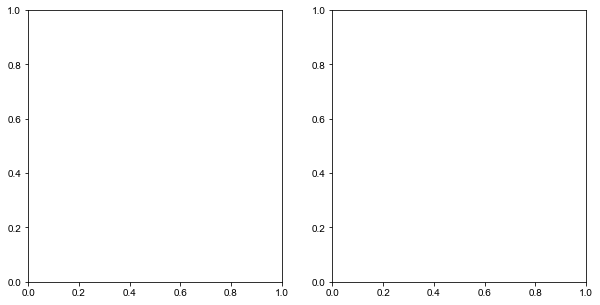

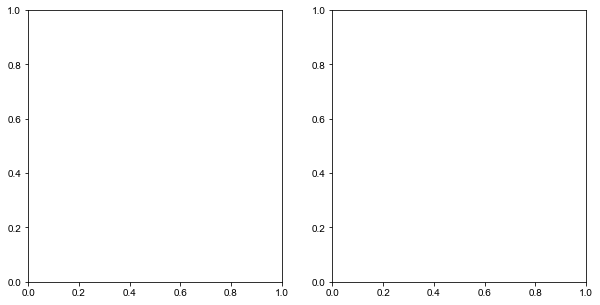

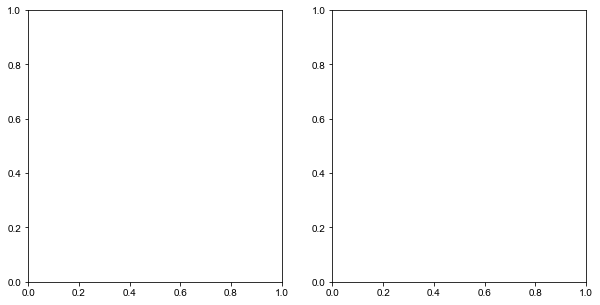

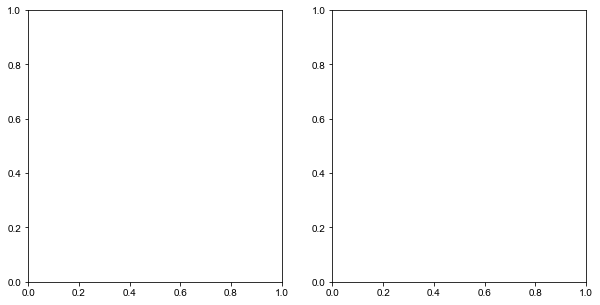

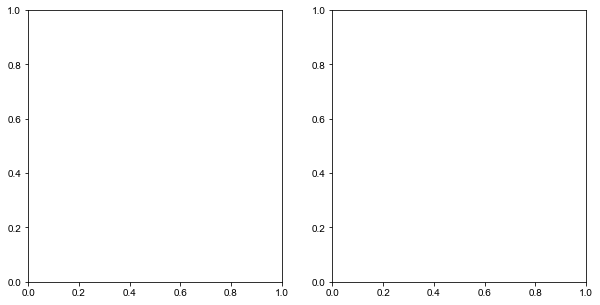

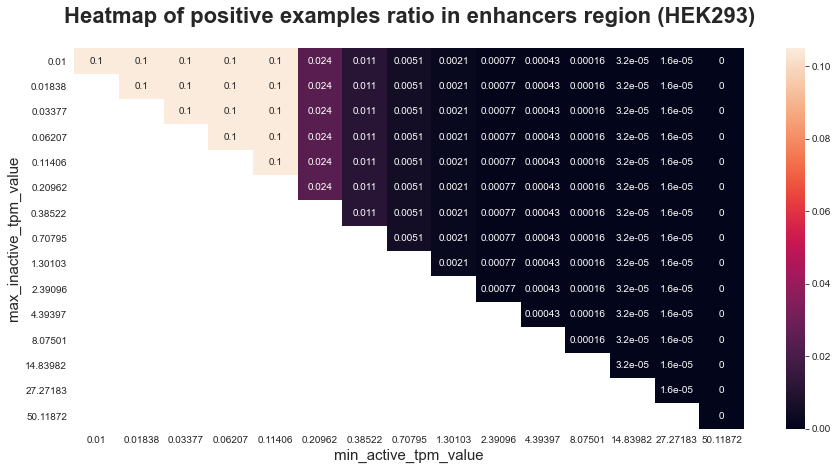

None

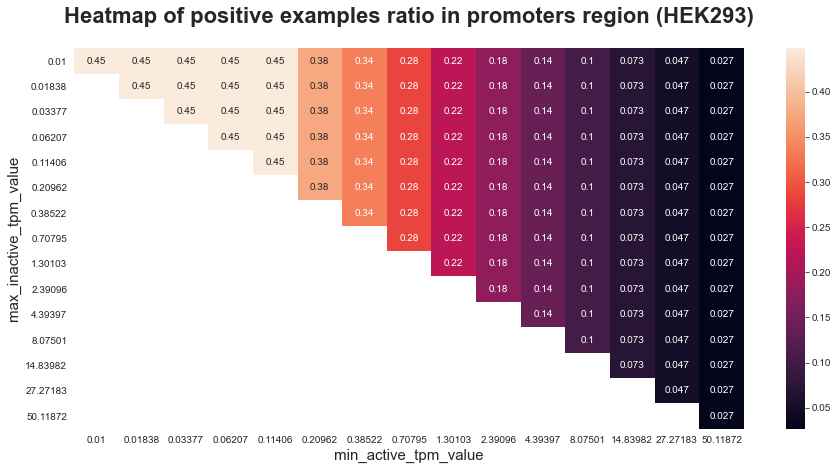

None

skipping 0 in HepG2, already done
skipping 1 in HepG2, already done
skipping 2 in HepG2, already done
skipping 3 in HepG2, already done
skipping 4 in HepG2, already done
skipping 5 in HepG2, already done
skipping 6 in HepG2, already done
skipping 7 in HepG2, already done
skipping 8 in HepG2, already done
skipping 9 in HepG2, already done
skipping 10 in HepG2, already done
skipping 11 in HepG2, already done
skipping 12 in HepG2, already done
skipping 13 in HepG2, already done
skipping 14 in HepG2, already done
skipping 15 in HepG2, already done
skipping 16 in HepG2, already done
skipping 17 in HepG2, already done
skipping 18 in HepG2, already done
skipping 19 in HepG2, already done
skipping 20 in HepG2, already done
skipping 21 in HepG2, already done
skipping 22 in HepG2, already done
skipping 23 in HepG2, already done
skipping 24 in HepG2, already done
skipping 25 in HepG2, already done
skipping 26 in HepG2, already done
skipping 27 in HepG2, already done
skipping 28 in HepG2, already 

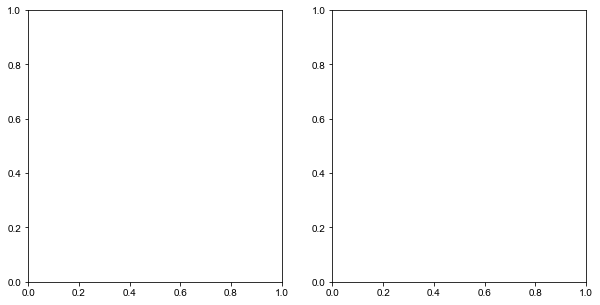

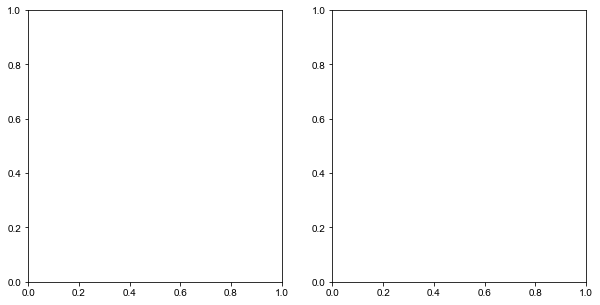

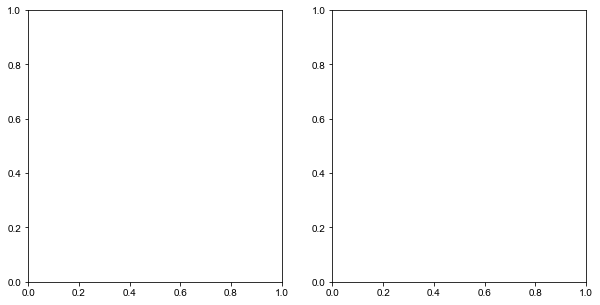

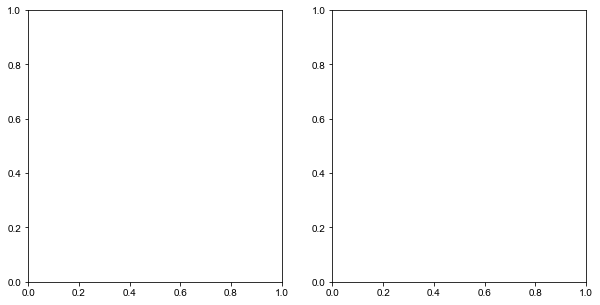

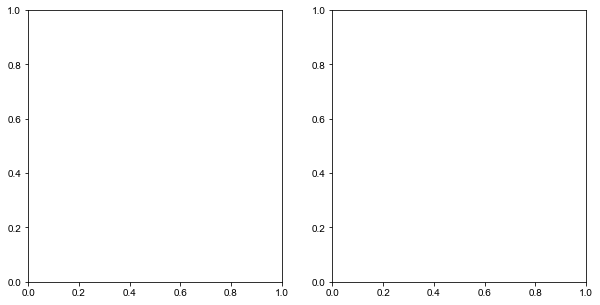

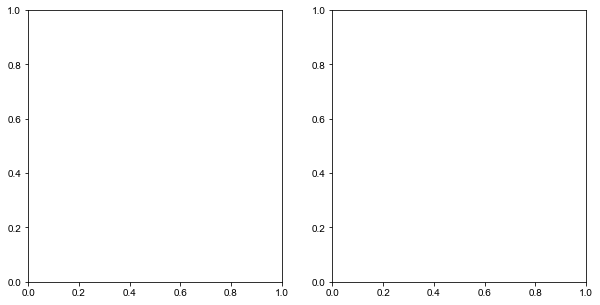

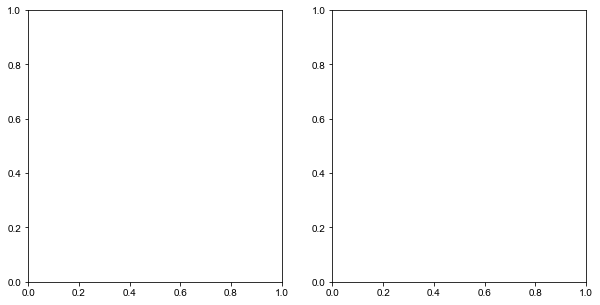

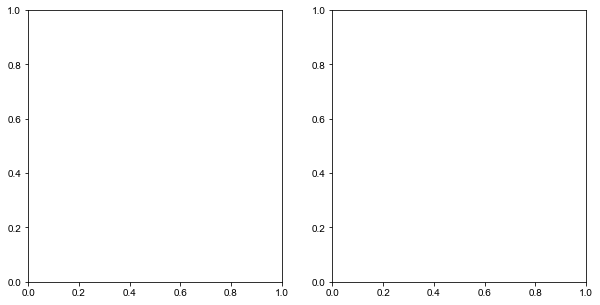

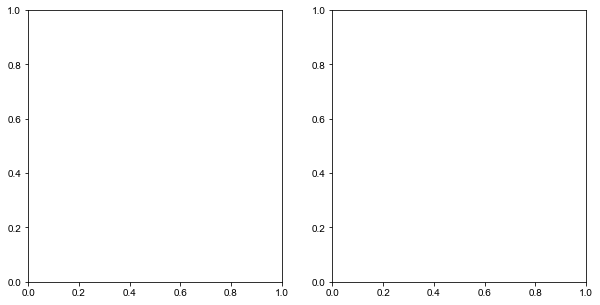

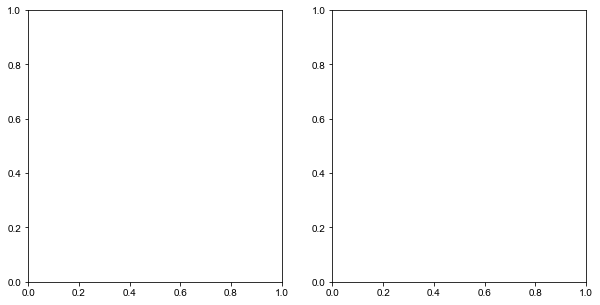

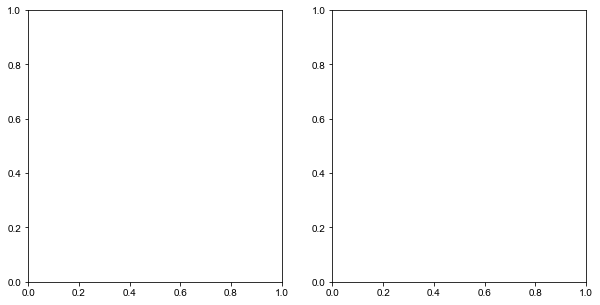

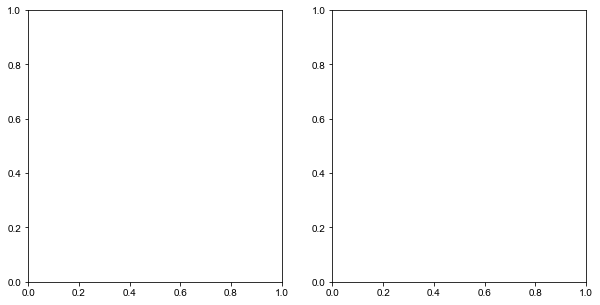

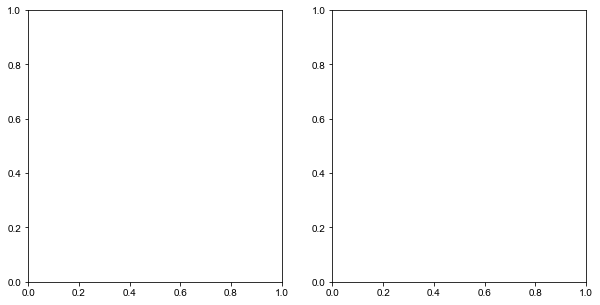

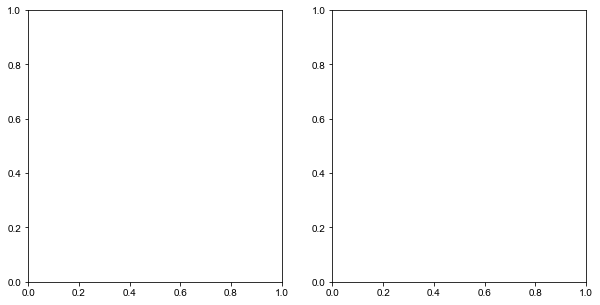

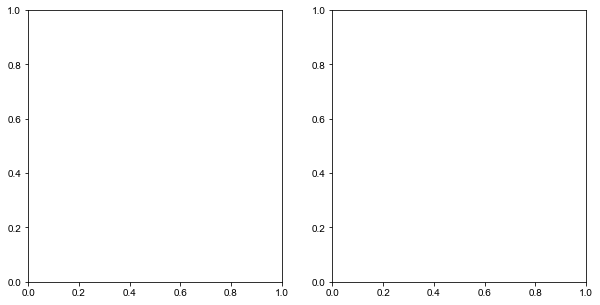

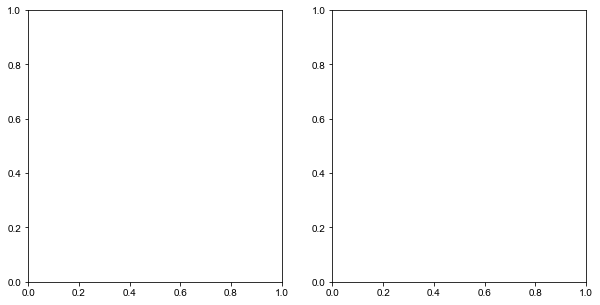

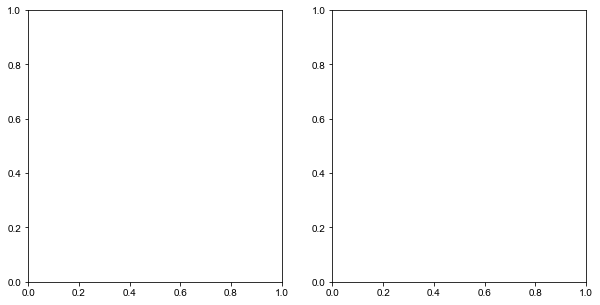

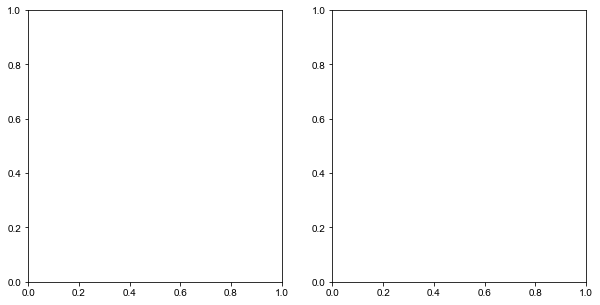

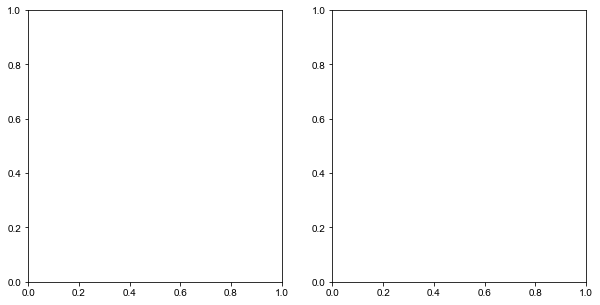

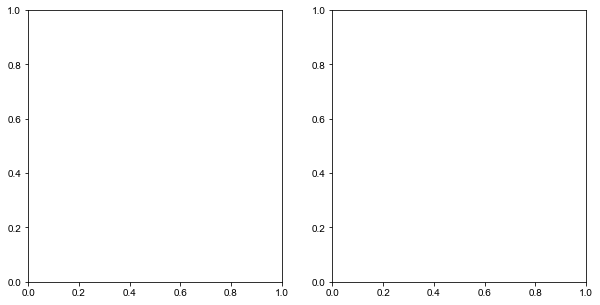

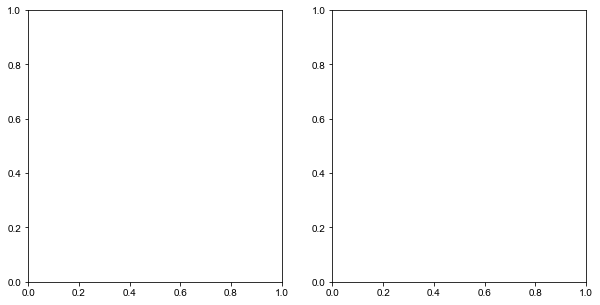

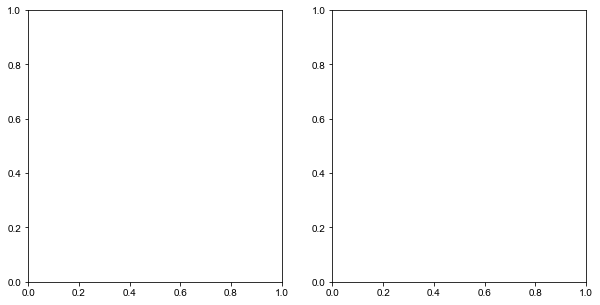

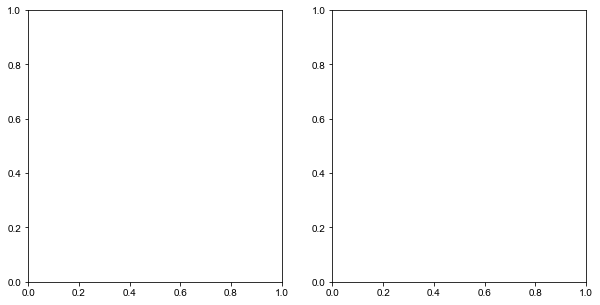

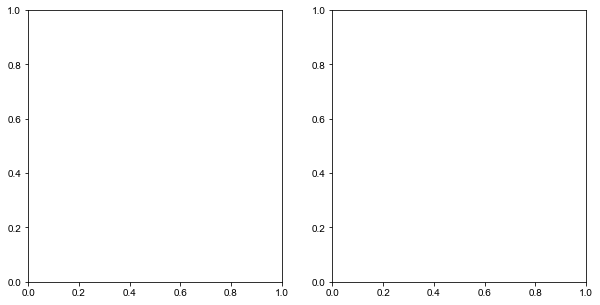

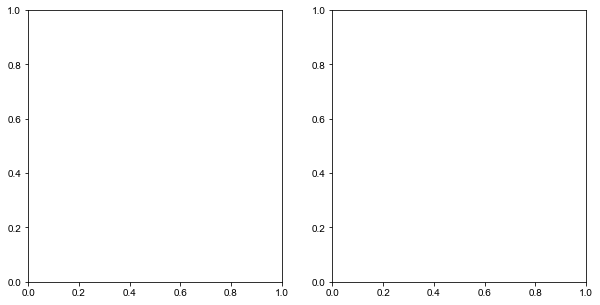

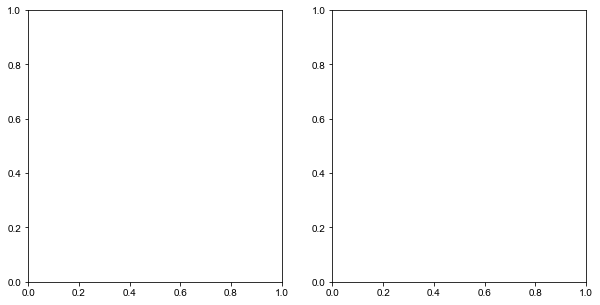

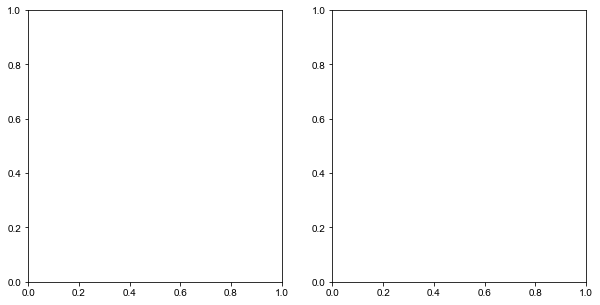

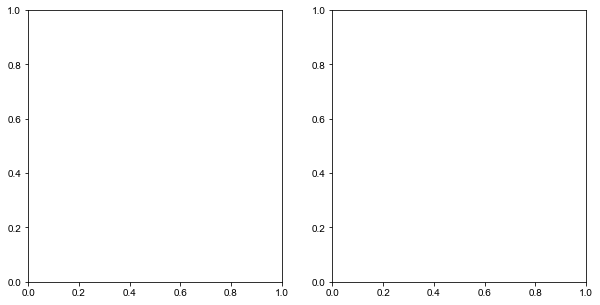

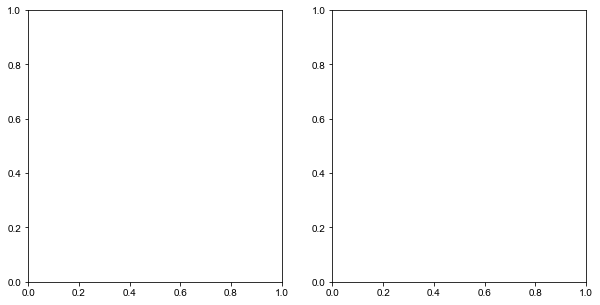

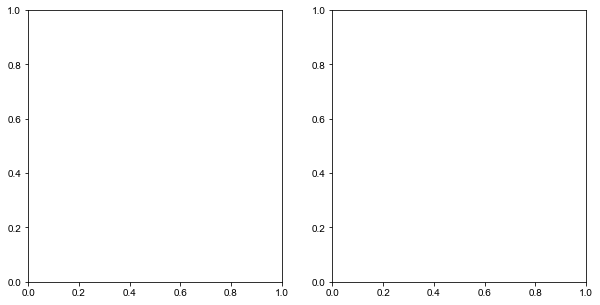

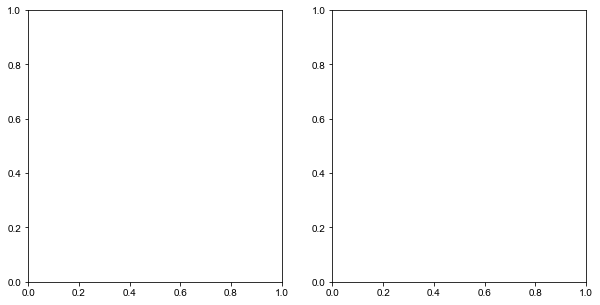

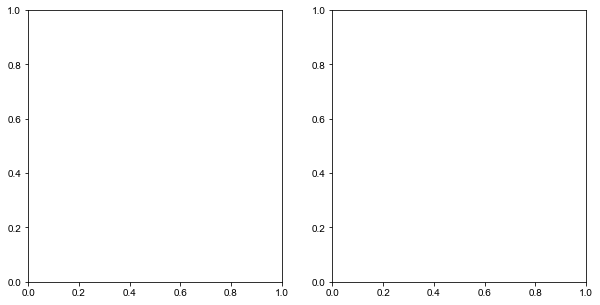

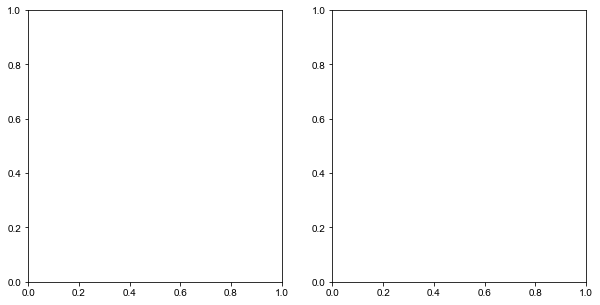

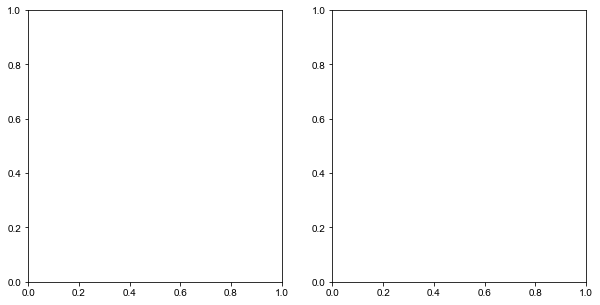

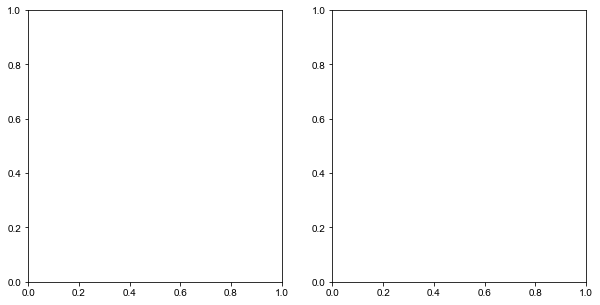

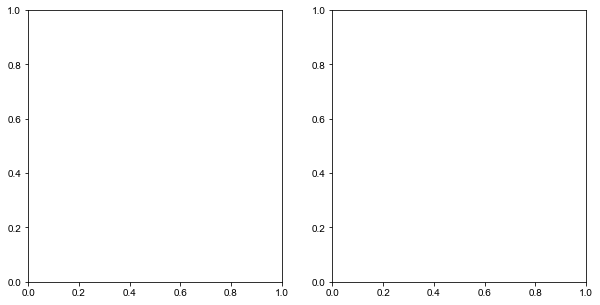

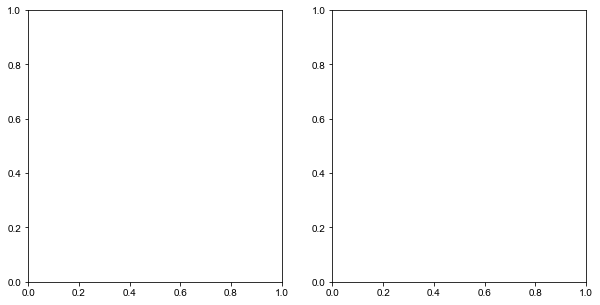

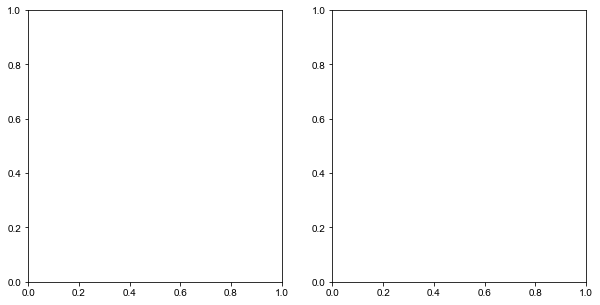

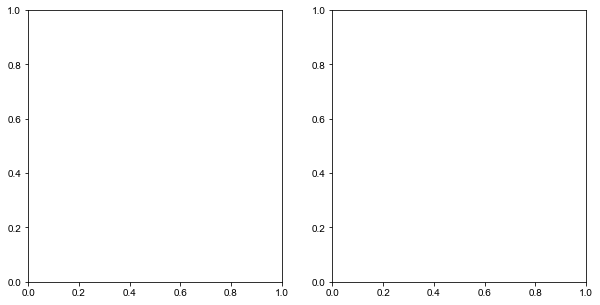

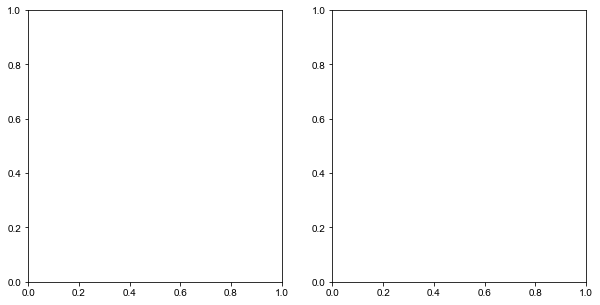

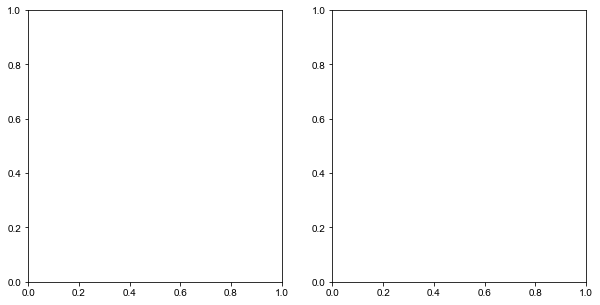

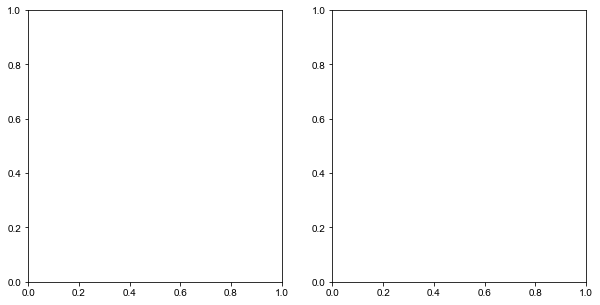

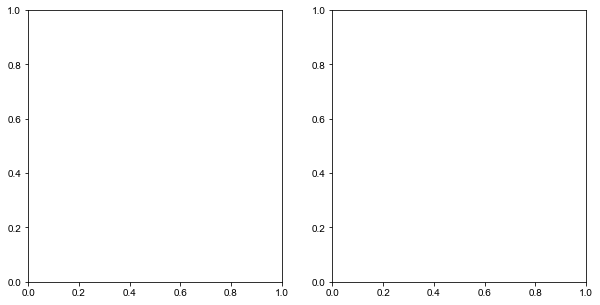

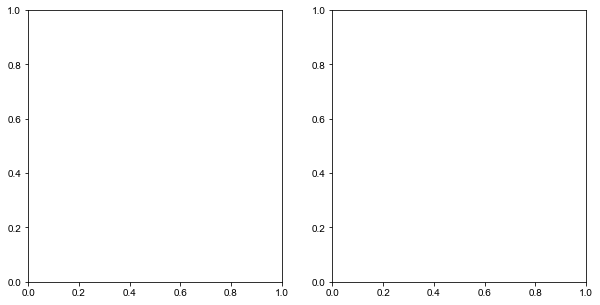

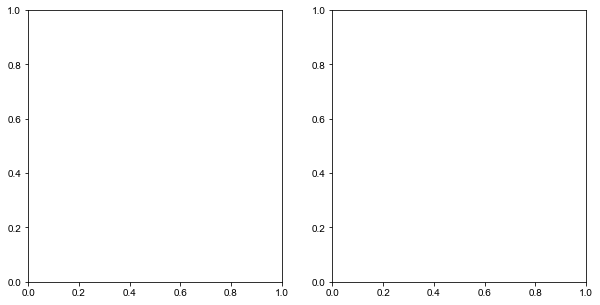

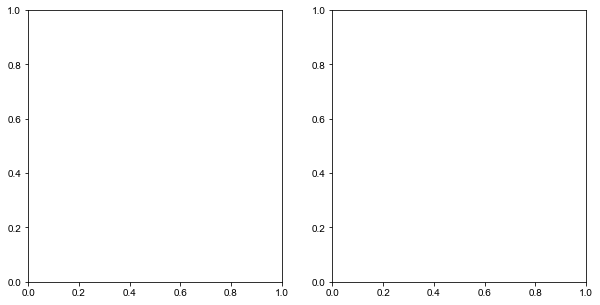

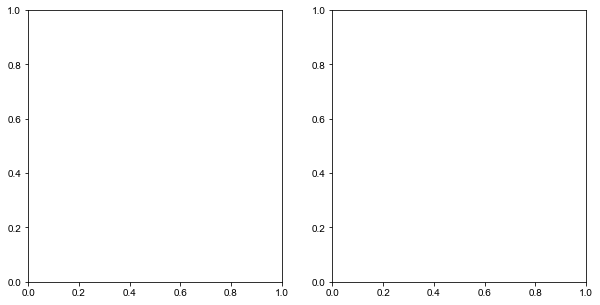

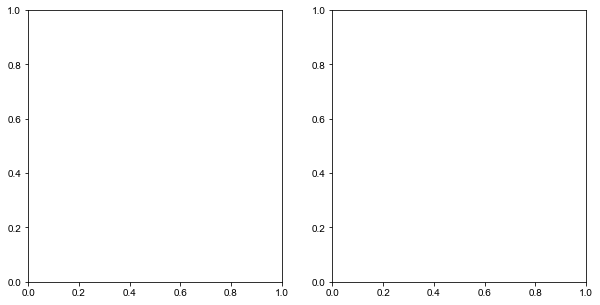

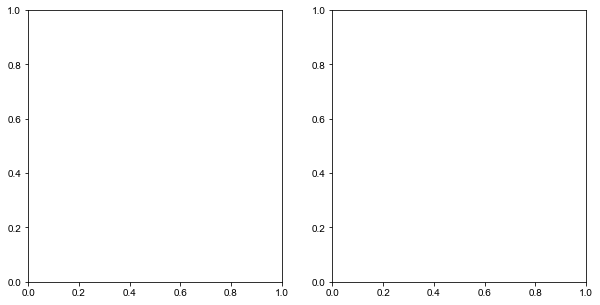

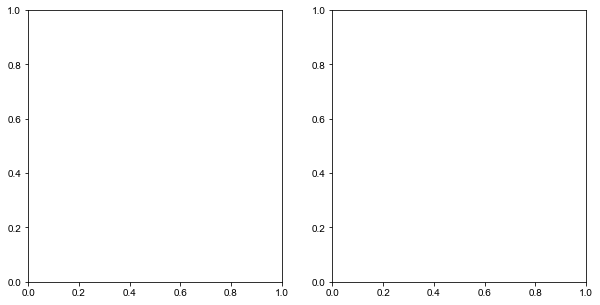

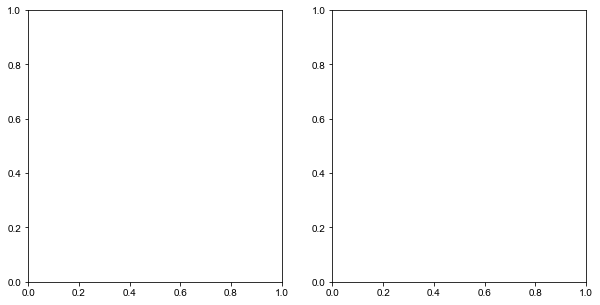

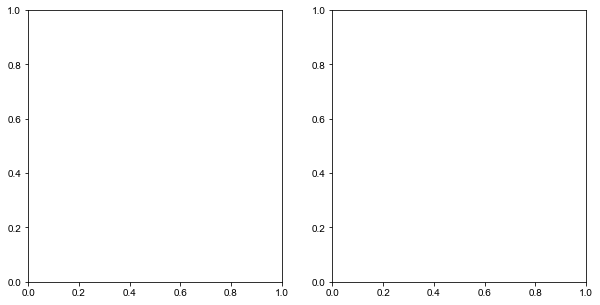

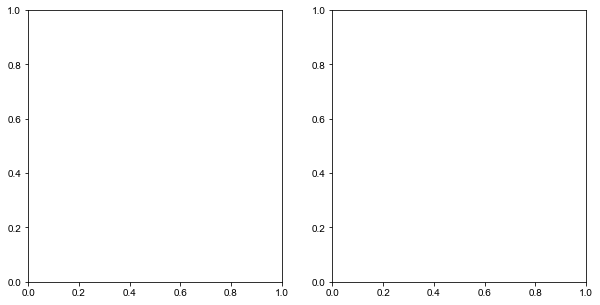

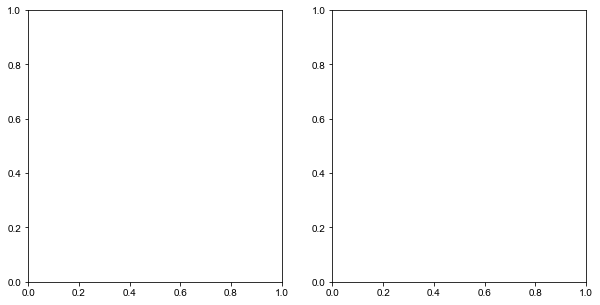

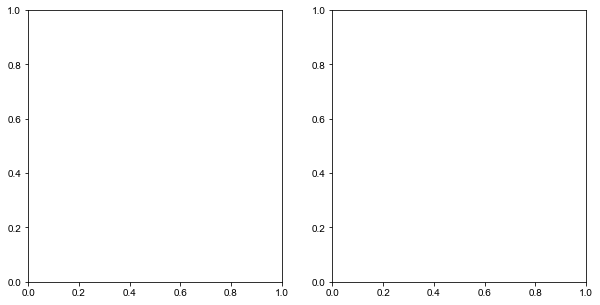

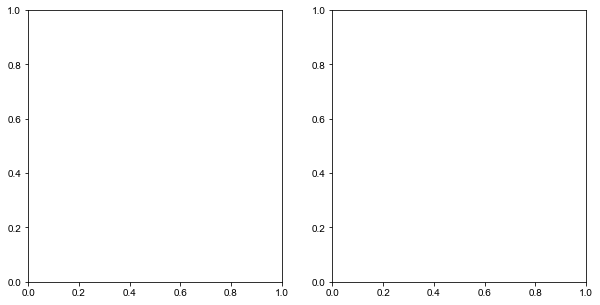

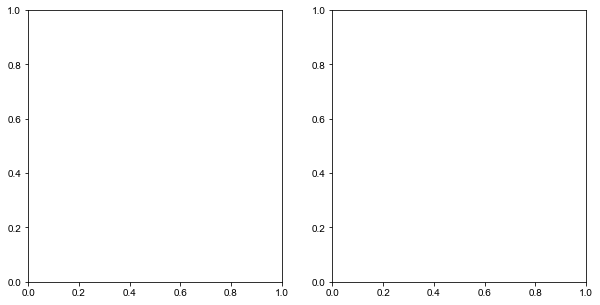

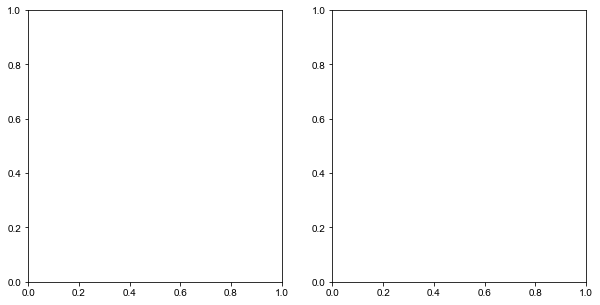

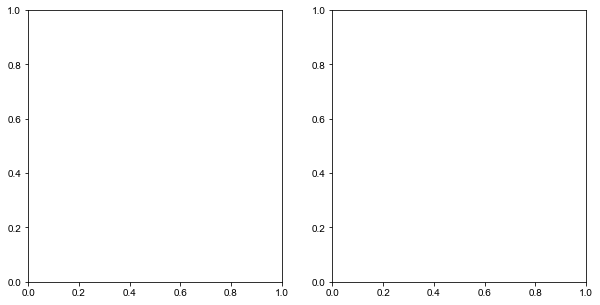

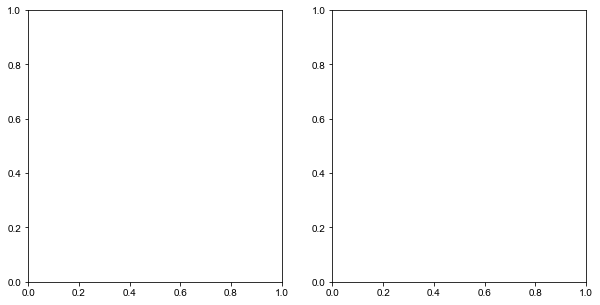

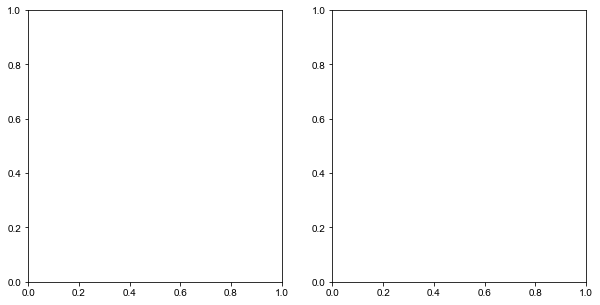

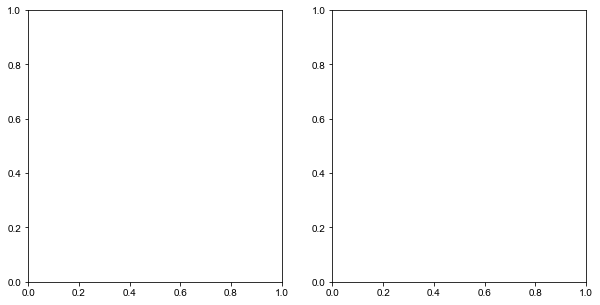

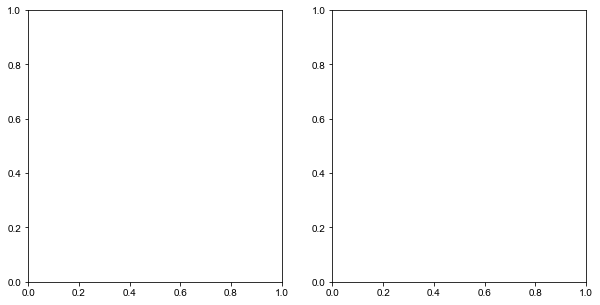

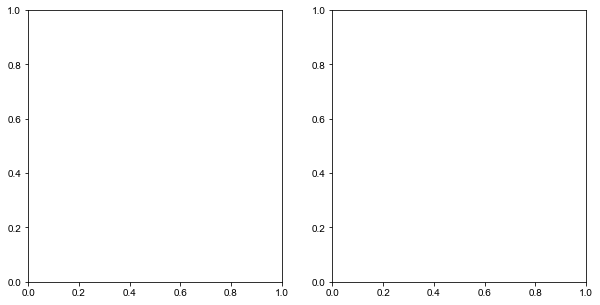

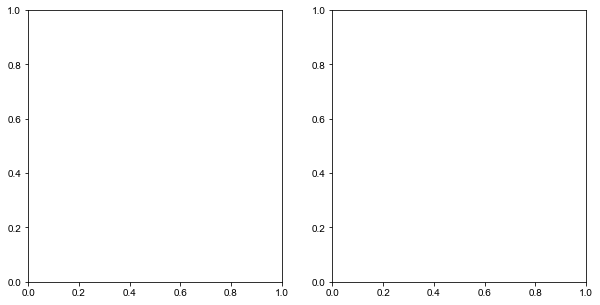

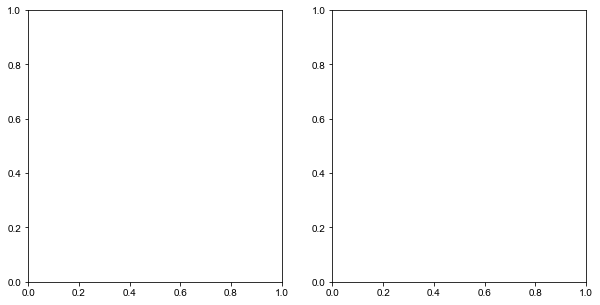

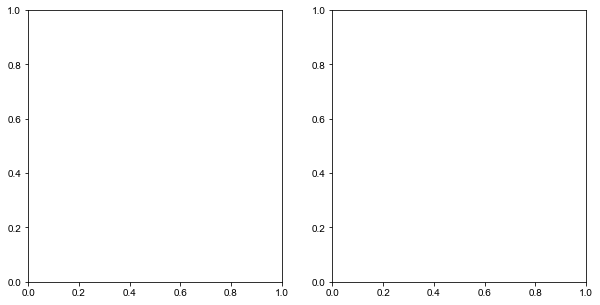

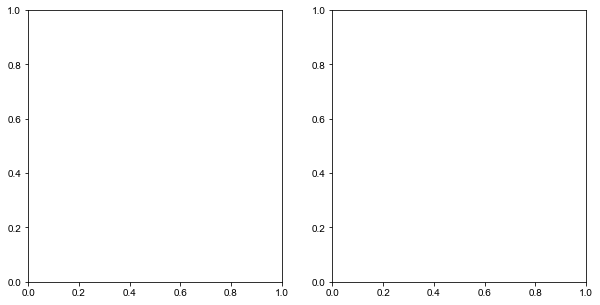

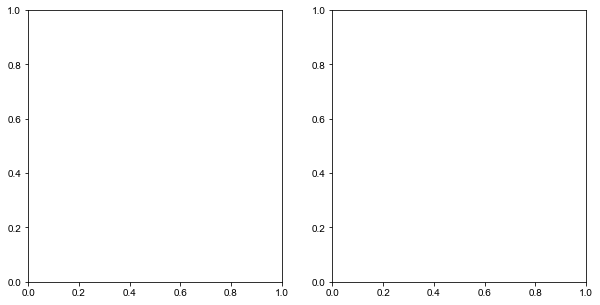

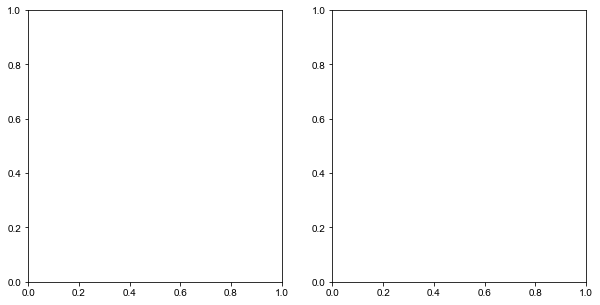

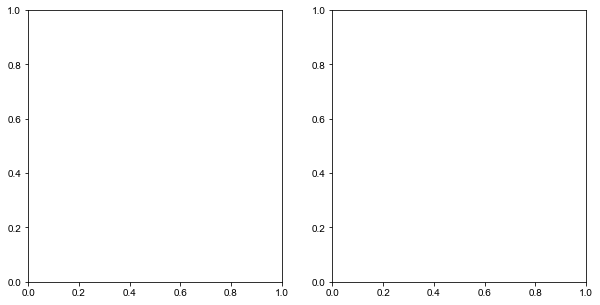

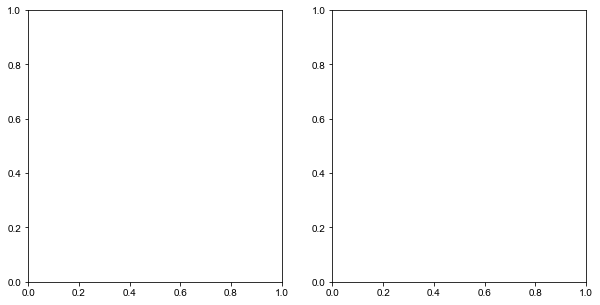

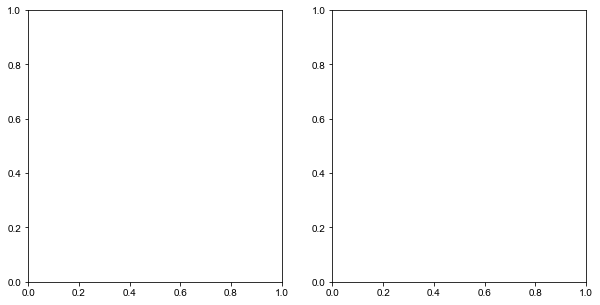

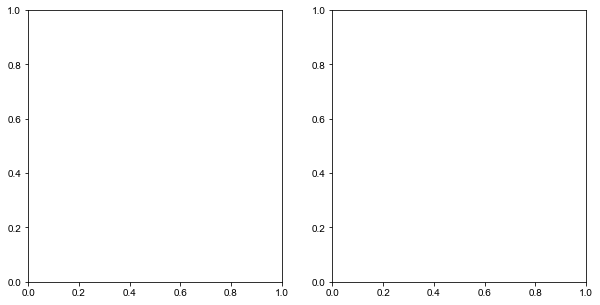

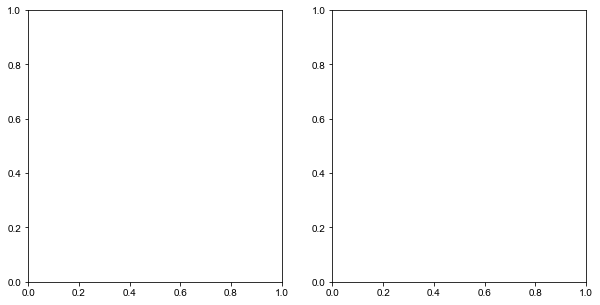

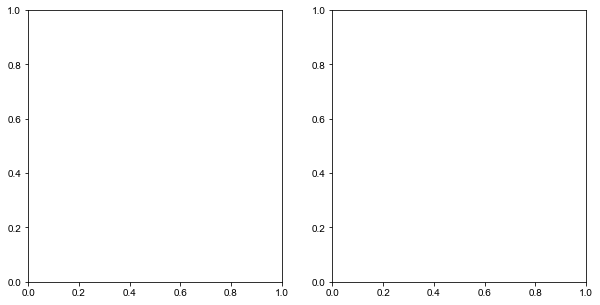

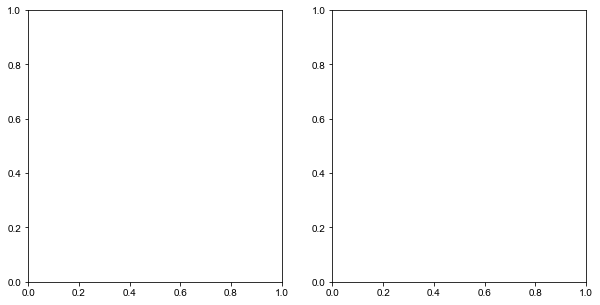

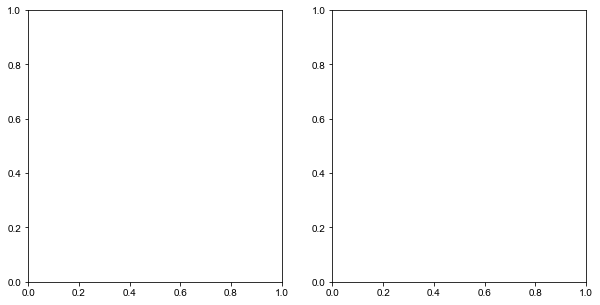

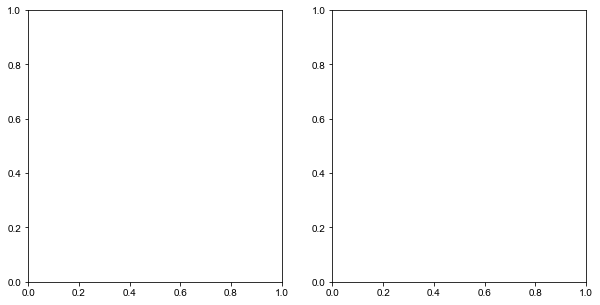

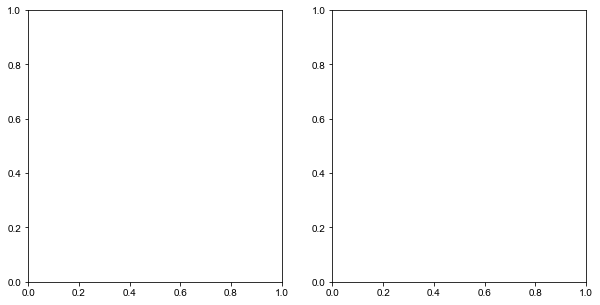

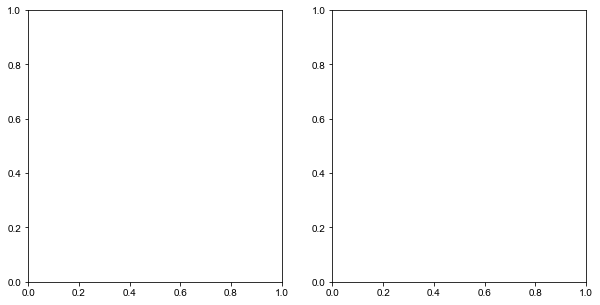

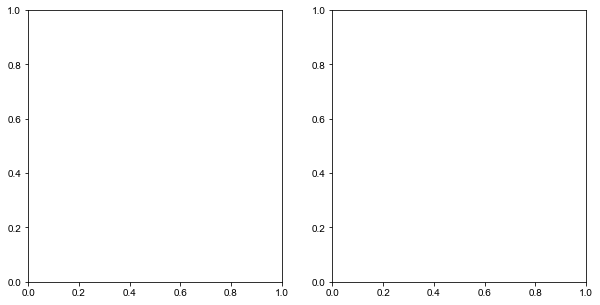

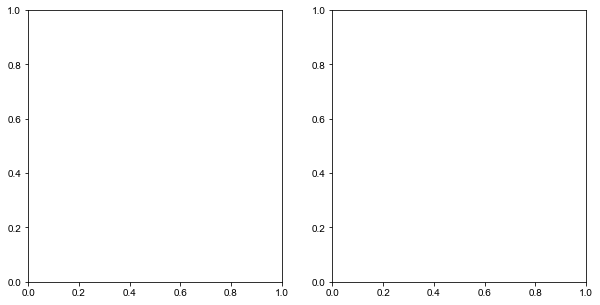

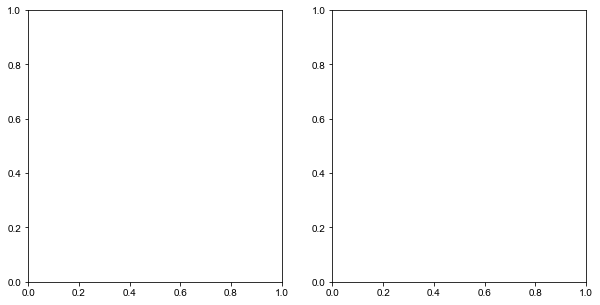

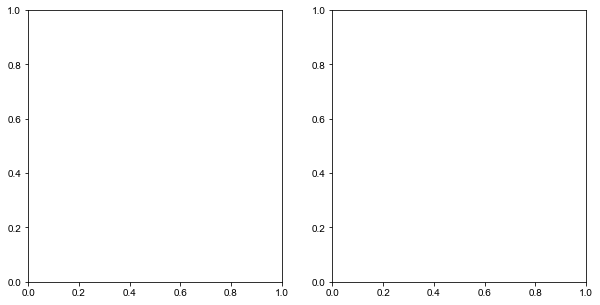

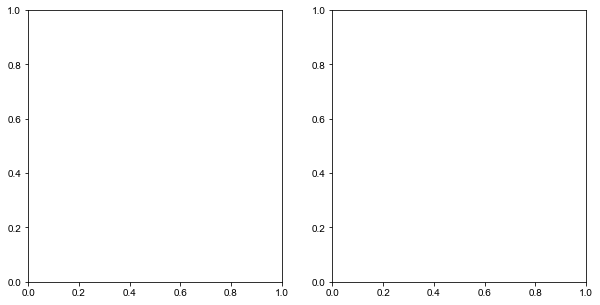

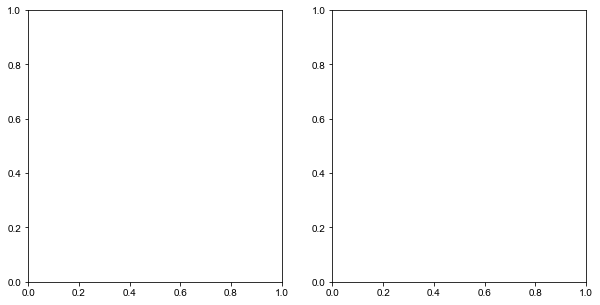

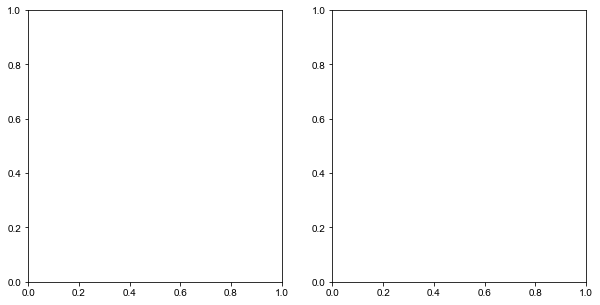

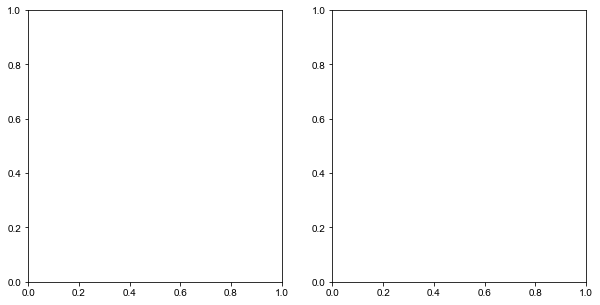

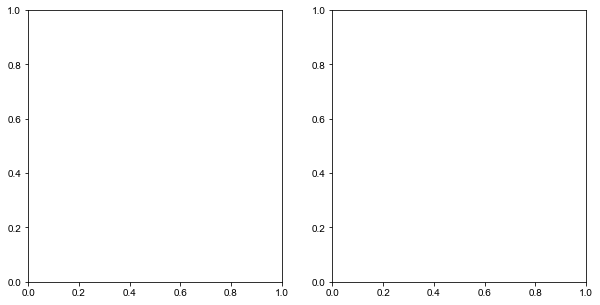

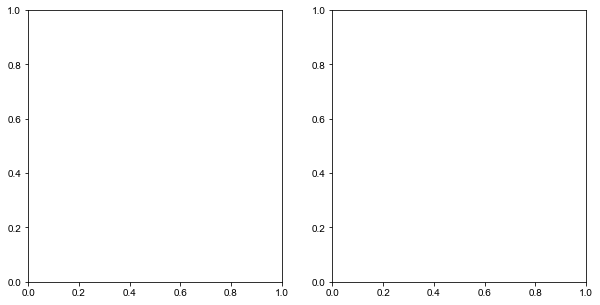

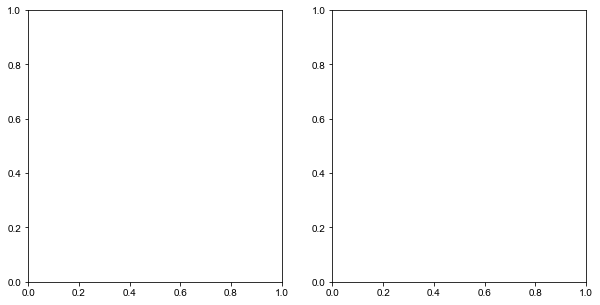

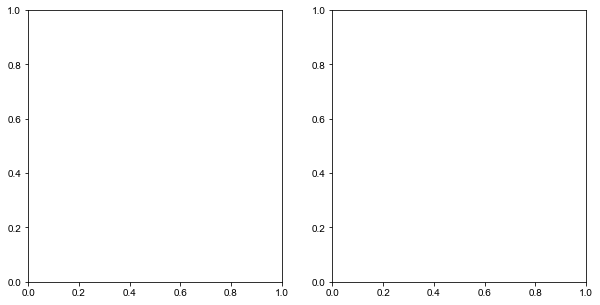

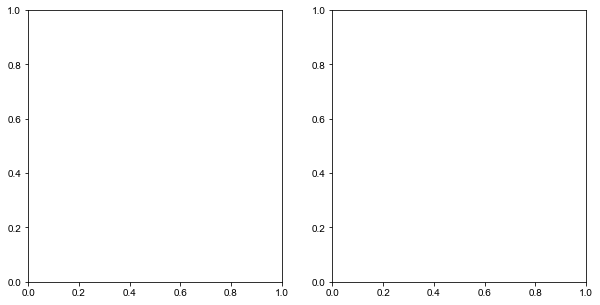

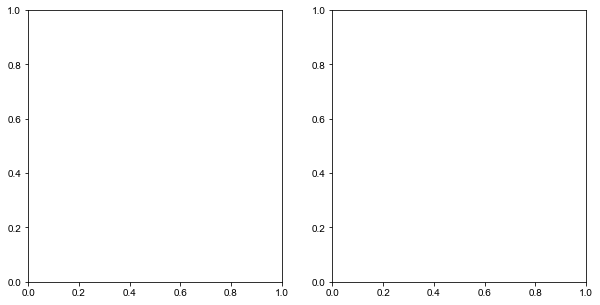

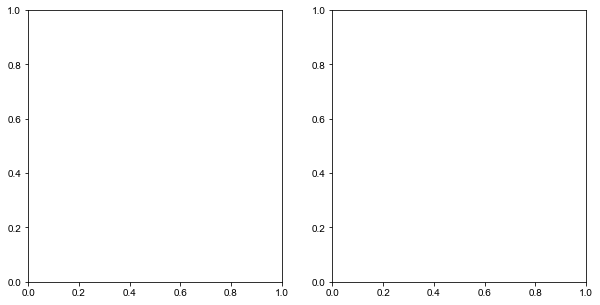

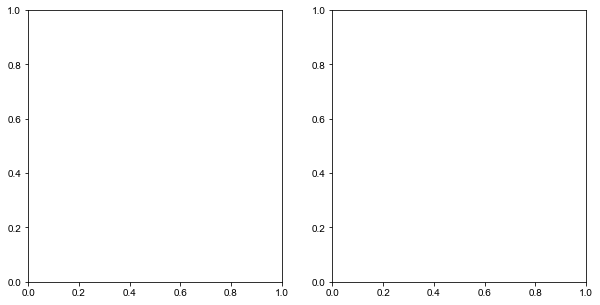

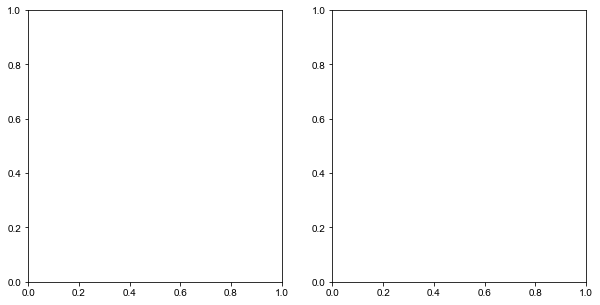

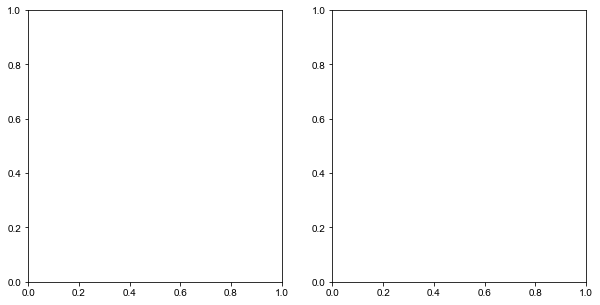

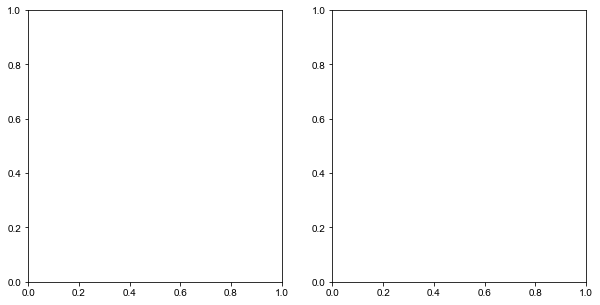

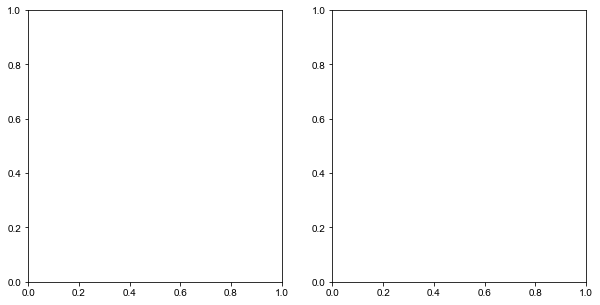

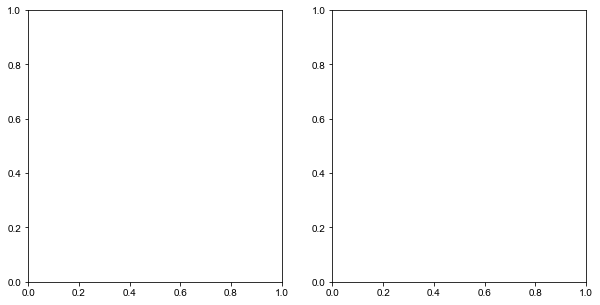

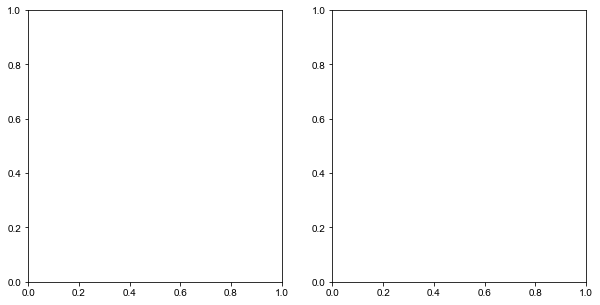

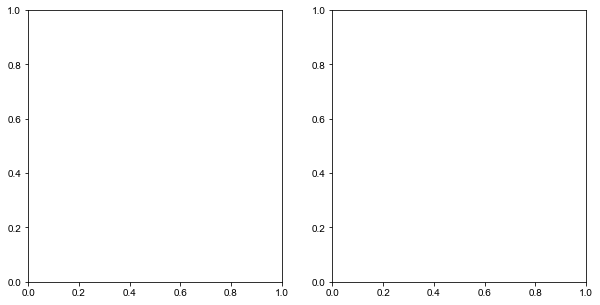

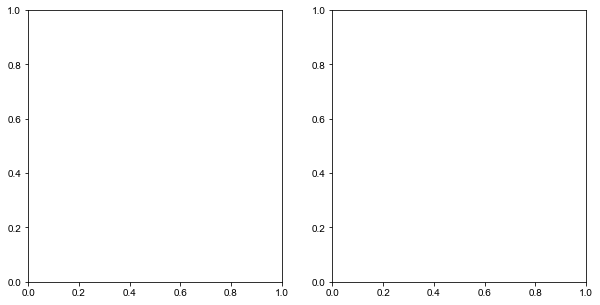

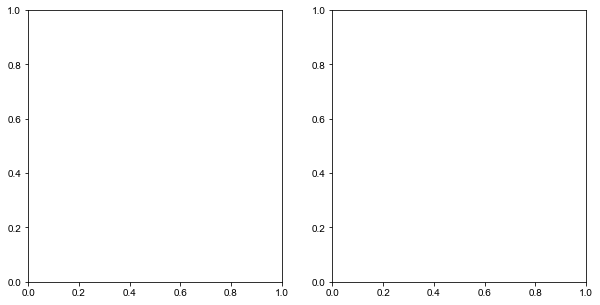

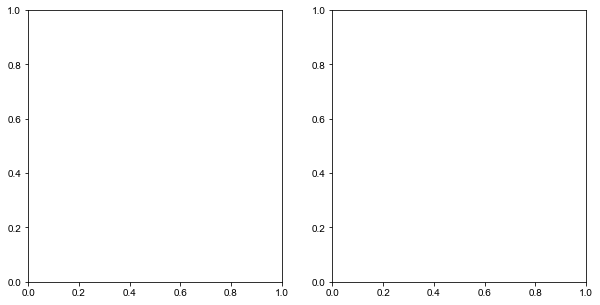

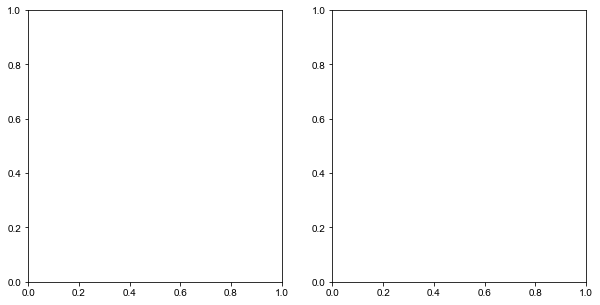

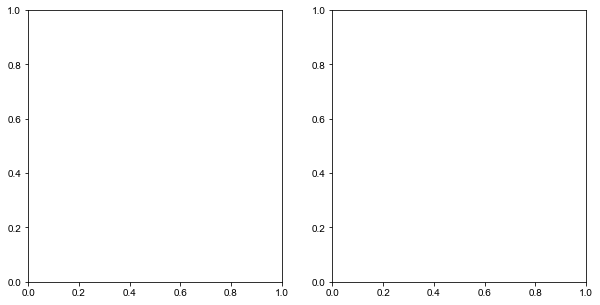

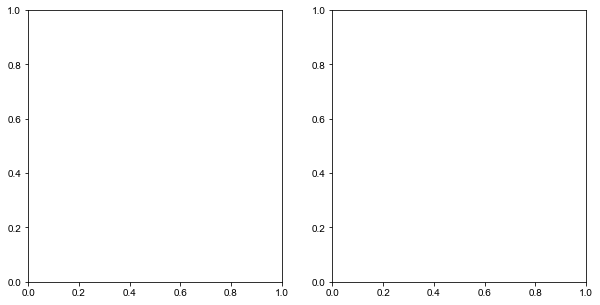

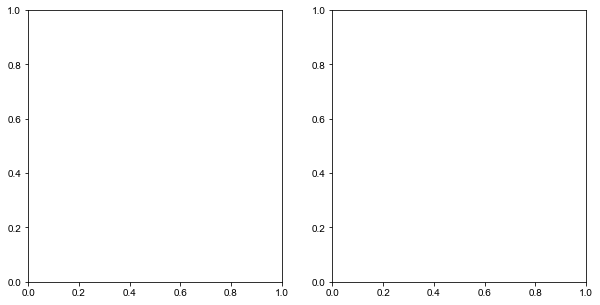

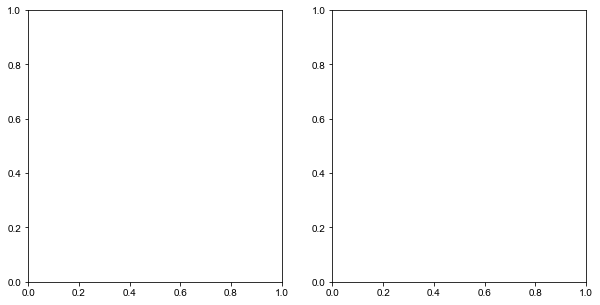

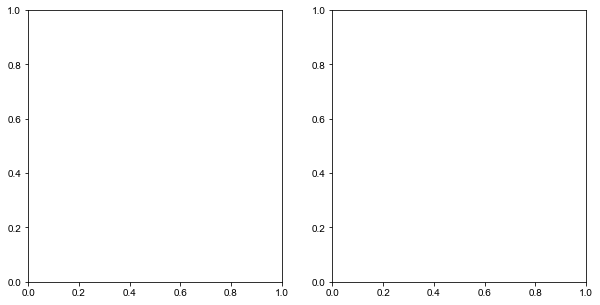

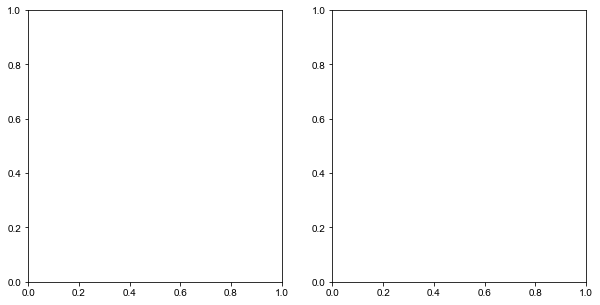

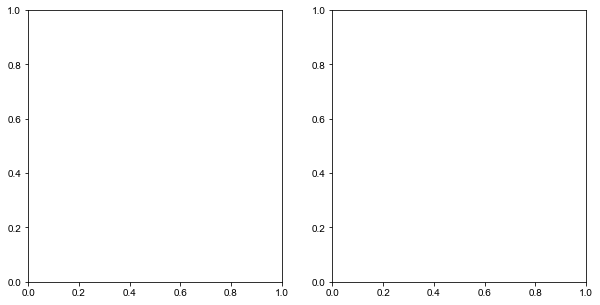

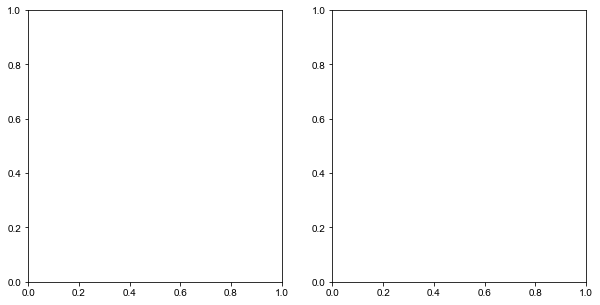

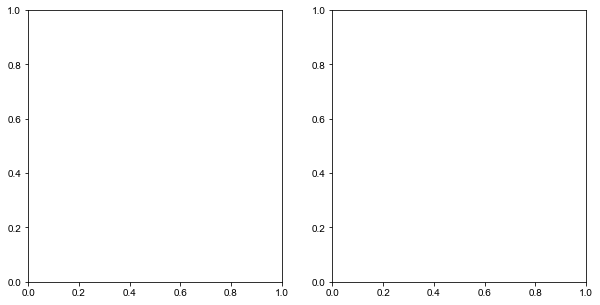

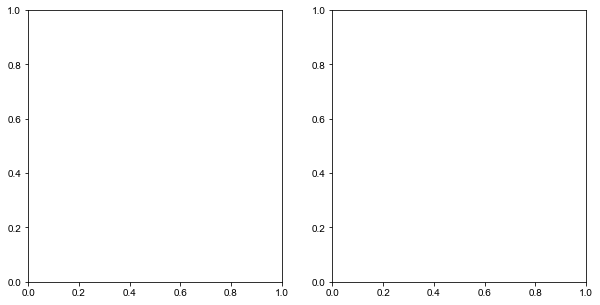

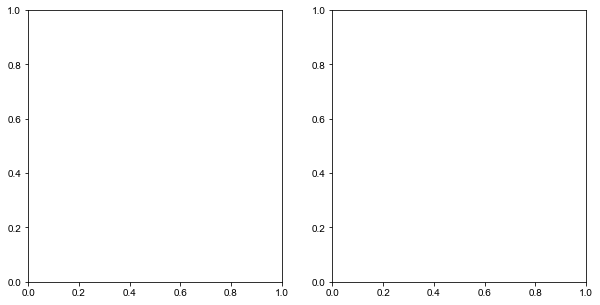

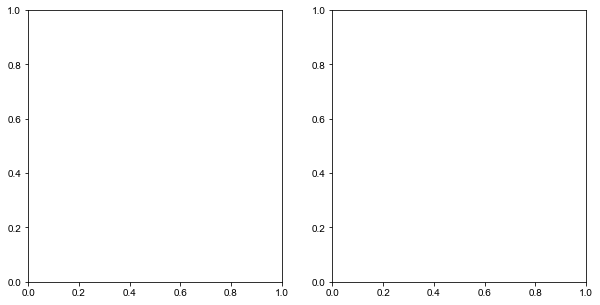

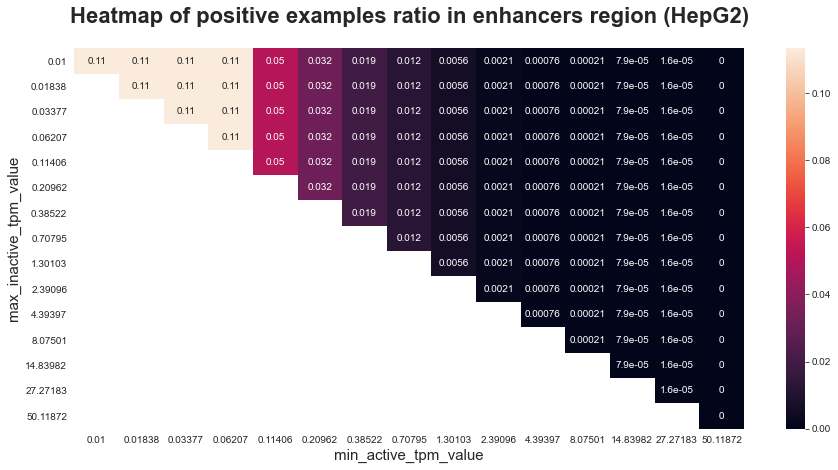

None

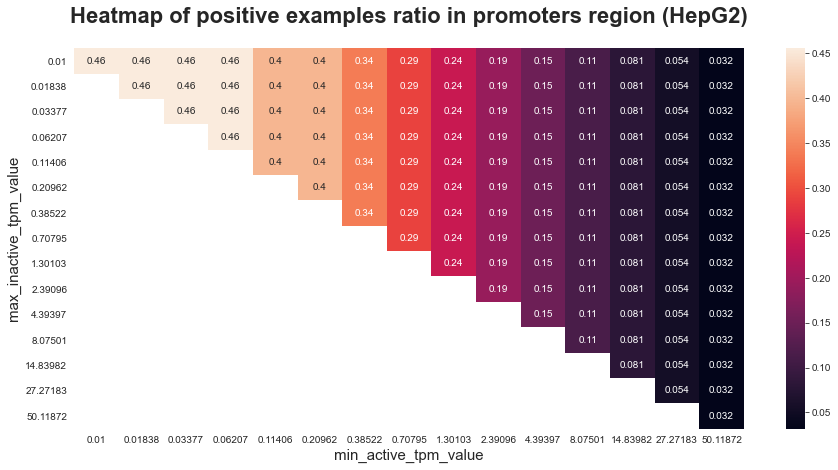

None

skipping 0 in K562, already done
skipping 1 in K562, already done
skipping 2 in K562, already done
skipping 3 in K562, already done
skipping 4 in K562, already done
skipping 5 in K562, already done
skipping 6 in K562, already done
skipping 7 in K562, already done
skipping 8 in K562, already done
skipping 9 in K562, already done
skipping 10 in K562, already done
skipping 11 in K562, already done
The time difference to load files is : 0.01980049999997391
907.7318814
The time difference after loading task is : 10.623338799999942
K562
{'max_inactive_tpm_value': 0.01, 'min_active_tpm_value': 14.839817889675661}
K562 
False    57761
True        17
dtype: int64
The time difference after computation is : 10.635270499999933
918.3671663
The time difference after loading task is : 17.33466480000004
K562
{'max_inactive_tpm_value': 0.01, 'min_active_tpm_value': 14.839817889675661}
K562 
False    66346
True      7500
dtype: int64
The time difference after computation is : 17.348963199999957
The time

<ipython-input-16-46ac61b40642>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(10, 5))


The time difference to load files is : 0.06393610000009176
1133.434137
The time difference after loading task is : 10.43962600000009
K562
{'max_inactive_tpm_value': 0.018377469653875118, 'min_active_tpm_value': 0.38522484200367535}
K562 
False    57761
True      1712
dtype: int64
The time difference after computation is : 10.451659500000005
1143.8858109
The time difference after loading task is : 17.105701700000054
K562
{'max_inactive_tpm_value': 0.018377469653875118, 'min_active_tpm_value': 0.38522484200367535}
K562 
False    66346
True     27241
dtype: int64
The time difference after computation is : 17.120663400000012
The time difference to load files is : 0.025930199999947945
1161.4798249
The time difference after loading task is : 10.431004799999982
K562
{'max_inactive_tpm_value': 0.018377469653875118, 'min_active_tpm_value': 0.707945784384138}
K562 
False    57761
True       873
dtype: int64
The time difference after computation is : 10.443667000000005
1171.9235063
The time diffe

The time difference after loading task is : 10.245340499999884
K562
{'max_inactive_tpm_value': 0.03377313908791009, 'min_active_tpm_value': 0.38522484200367535}
K562 
False    57761
True      1712
dtype: int64
The time difference after computation is : 10.257365499999878
1512.2646105
The time difference after loading task is : 17.140858300000218
K562
{'max_inactive_tpm_value': 0.03377313908791009, 'min_active_tpm_value': 0.38522484200367535}
K562 
False    66346
True     27241
dtype: int64
The time difference after computation is : 17.15553480000017
The time difference to load files is : 0.025578600000017104
1529.8718824
The time difference after loading task is : 10.388228100000106
K562
{'max_inactive_tpm_value': 0.03377313908791009, 'min_active_tpm_value': 0.707945784384138}
K562 
False    57761
True       873
dtype: int64
The time difference after computation is : 10.400005899999996
1540.2719026
The time difference after loading task is : 17.152503499999966
K562
{'max_inactive_tpm_v

The time difference after loading task is : 17.579982100000052
K562
{'max_inactive_tpm_value': 0.06206648387041716, 'min_active_tpm_value': 0.707945784384138}
K562 
False    66346
True     23862
dtype: int64
The time difference after computation is : 17.59520569999995
The time difference to load files is : 0.025632699999960096
1898.4638787
The time difference after loading task is : 10.615355300000147
K562
{'max_inactive_tpm_value': 0.06206648387041716, 'min_active_tpm_value': 1.3010252169108316}
K562 
False    57761
True       305
dtype: int64
The time difference after computation is : 10.627203400000099
1909.0910963
The time difference after loading task is : 17.05243080000014
K562
{'max_inactive_tpm_value': 0.06206648387041716, 'min_active_tpm_value': 1.3010252169108316}
K562 
False    66346
True     19969
dtype: int64
The time difference after computation is : 17.066605700000082
The time difference to load files is : 0.02659870000002229
1926.6406756
The time difference after loadin

The time difference to load files is : 0.027064299999892683
2271.50588
The time difference after loading task is : 11.88038860000006
K562
{'max_inactive_tpm_value': 0.11406249238513208, 'min_active_tpm_value': 4.39397056076079}
K562 
False    57761
True        73
dtype: int64
The time difference after computation is : 11.894956499999807
2283.4008513
The time difference after loading task is : 19.05775040000026
K562
{'max_inactive_tpm_value': 0.11406249238513208, 'min_active_tpm_value': 4.39397056076079}
K562 
False    66346
True     13156
dtype: int64
The time difference after computation is : 19.071681700000227
The time difference to load files is : 0.027164600000105565
2302.9465315
The time difference after loading task is : 10.210929799999576
K562
{'max_inactive_tpm_value': 0.11406249238513208, 'min_active_tpm_value': 8.075006064040206}
K562 
False    57761
True        34
dtype: int64
The time difference after computation is : 10.22276759999977
2313.1693132
The time difference after

The time difference after loading task is : 18.184172799999942
K562
{'max_inactive_tpm_value': 0.2096179992453127, 'min_active_tpm_value': 27.27183029365476}
K562 
False    66346
True      5210
dtype: int64
The time difference after computation is : 18.197673600000144
The time difference to load files is : 0.027752800000143907
2682.0772651
The time difference after loading task is : 10.574548899999627
K562
{'max_inactive_tpm_value': 0.2096179992453127, 'min_active_tpm_value': 50.11872336272722}
K562 
False    57761
True         1
dtype: int64
The time difference after computation is : 10.586641899999904
2692.6639211
The time difference after loading task is : 18.759923799999797
K562
{'max_inactive_tpm_value': 0.2096179992453127, 'min_active_tpm_value': 50.11872336272722}
K562 
False    66346
True      3226
dtype: int64
The time difference after computation is : 18.774109399999816
The time difference to load files is : 0.027025100000173552
2711.9084556
The time difference after loading 

The time difference to load files is : 0.027730700000120123
3059.9314167
The time difference after loading task is : 15.031366499999876
K562
{'max_inactive_tpm_value': 0.707945784384138, 'min_active_tpm_value': 4.39397056076079}
K562 
False    62412
True        73
dtype: int64
The time difference after computation is : 15.04460169999993
3074.9760329
The time difference after loading task is : 20.541254199999912
K562
{'max_inactive_tpm_value': 0.707945784384138, 'min_active_tpm_value': 4.39397056076079}
K562 
False    76019
True     13156
dtype: int64
The time difference after computation is : 20.55984559999979
The time difference to load files is : 0.02666289999979199
3096.0285769
The time difference after loading task is : 11.113937999999962
K562
{'max_inactive_tpm_value': 0.707945784384138, 'min_active_tpm_value': 8.075006064040206}
K562 
False    62412
True        34
dtype: int64
The time difference after computation is : 11.127424999999675
3107.1560162
The time difference after loa

The time difference after loading task is : 17.474610400000074
K562
{'max_inactive_tpm_value': 2.39095514427051, 'min_active_tpm_value': 4.39397056076079}
K562 
False    83768
True     13156
dtype: int64
The time difference after computation is : 17.490042800000083
The time difference to load files is : 0.028360399999655783
3505.736449
The time difference after loading task is : 10.322048999999879
K562
{'max_inactive_tpm_value': 2.39095514427051, 'min_active_tpm_value': 8.075006064040206}
K562 
False    63120
True        34
dtype: int64
The time difference after computation is : 10.334259100000054
3516.0707229
The time difference after loading task is : 16.993360100000245
K562
{'max_inactive_tpm_value': 2.39095514427051, 'min_active_tpm_value': 8.075006064040206}
K562 
False    83768
True     10126
dtype: int64
The time difference after computation is : 17.008125199999995
The time difference to load files is : 0.027186799999981304
3533.5319041
The time difference after loading task is 

The time difference to load files is : 0.027389600000333303
3867.0643431
The time difference after loading task is : 10.005658500000209
K562
{'max_inactive_tpm_value': 14.839817889675661, 'min_active_tpm_value': 14.839817889675661}
K562 
False    63268
True        17
dtype: int64
The time difference after computation is : 10.017806900000323
3877.0821643
The time difference after loading task is : 16.781198399999994
K562
{'max_inactive_tpm_value': 14.839817889675661, 'min_active_tpm_value': 14.839817889675661}
K562 
False    92381
True      7500
dtype: int64
The time difference after computation is : 16.79595870000003
The time difference to load files is : 0.07150550000005751
3894.4416322
The time difference after loading task is : 10.183643999999731
K562
{'max_inactive_tpm_value': 14.839817889675661, 'min_active_tpm_value': 27.27183029365476}
K562 
False    63268
True         9
dtype: int64
The time difference after computation is : 10.196249399999942
3904.6378961
The time difference a

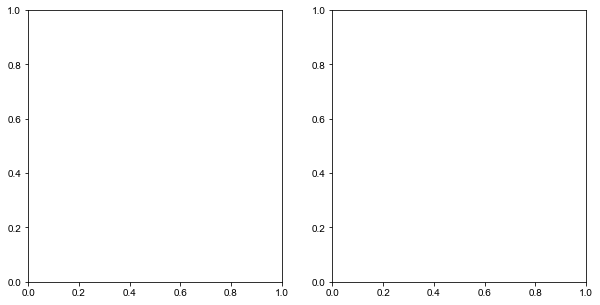

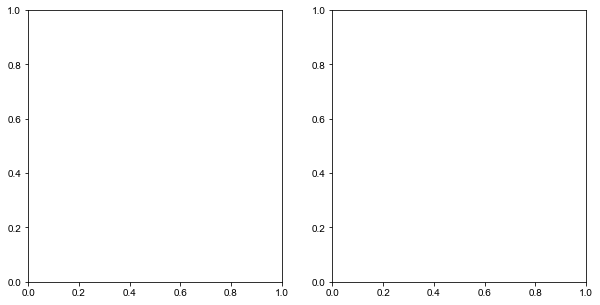

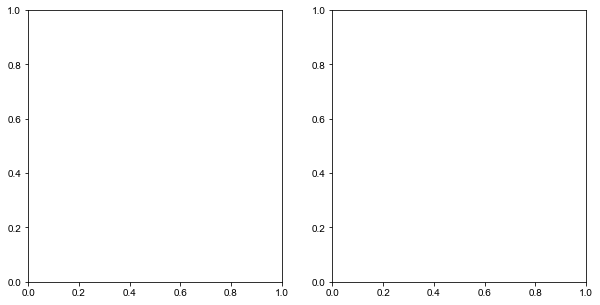

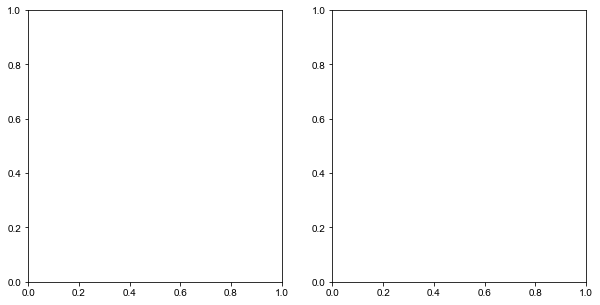

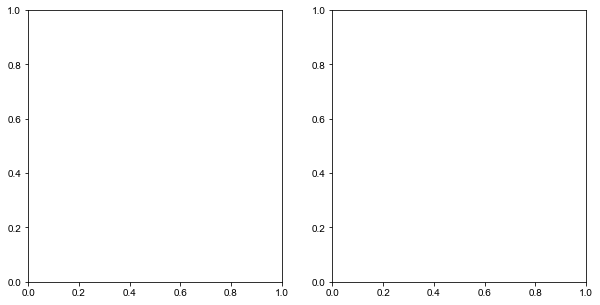

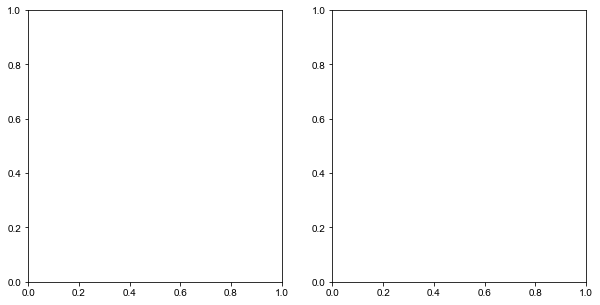

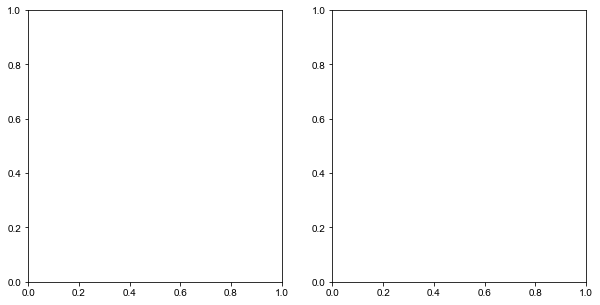

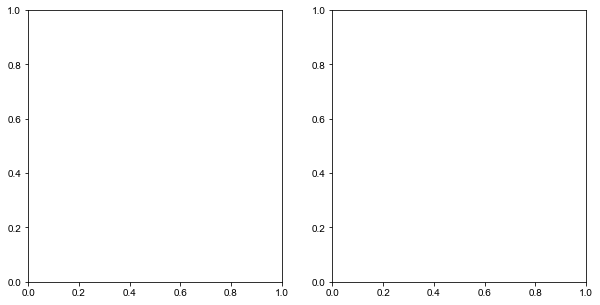

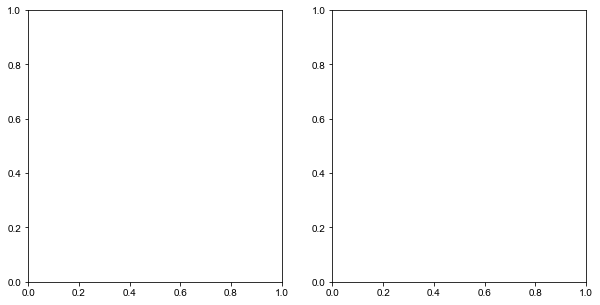

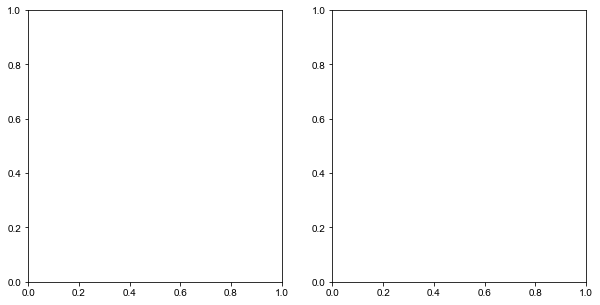

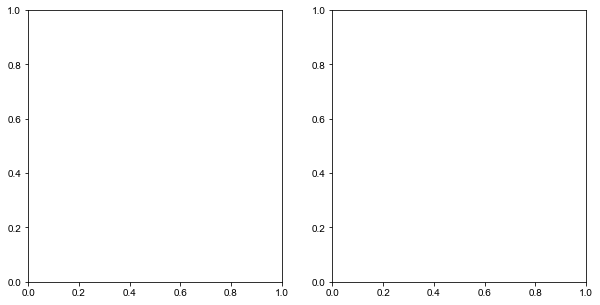

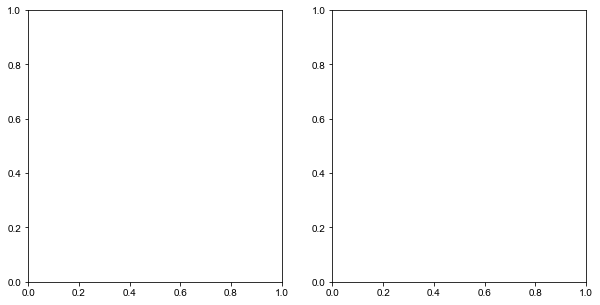

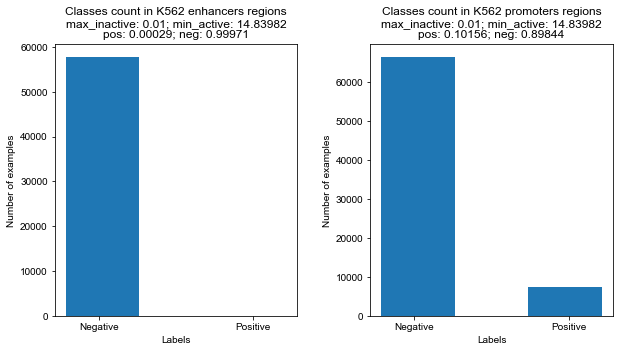

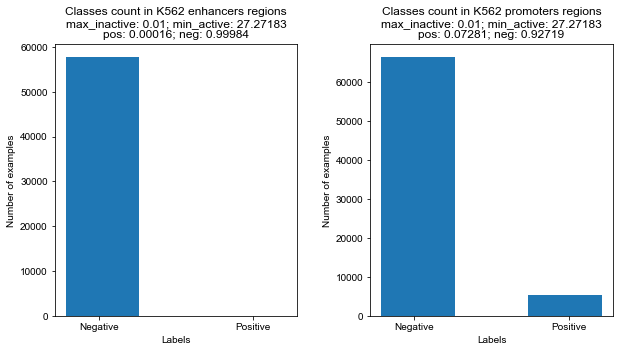

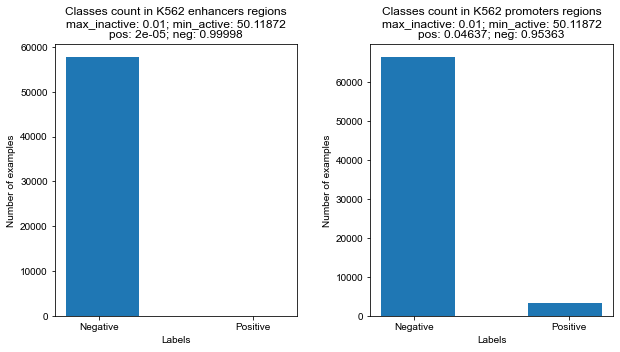

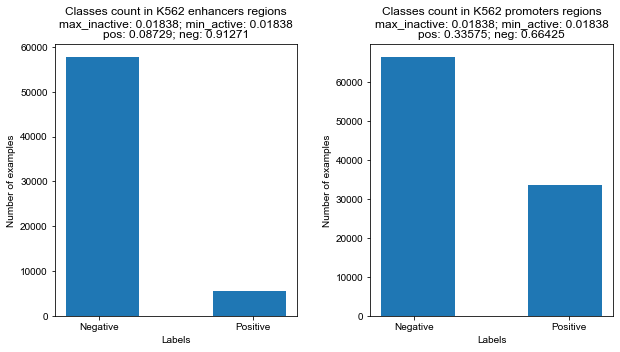

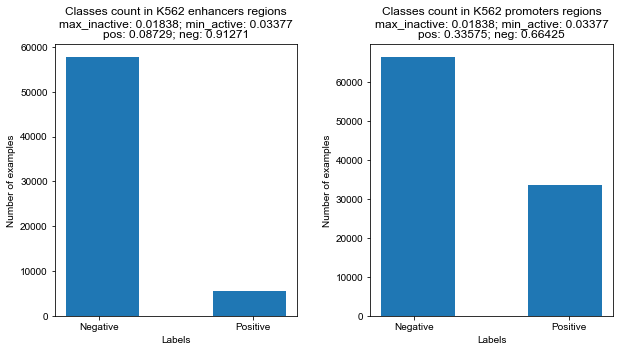

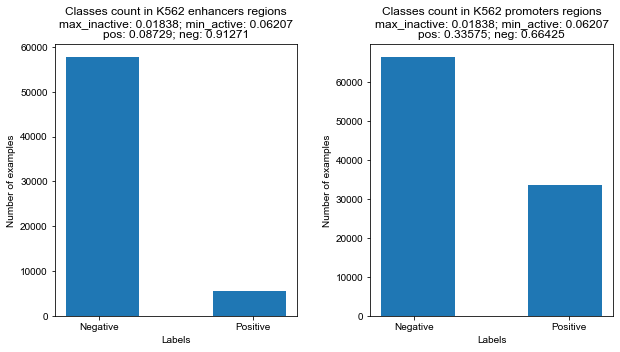

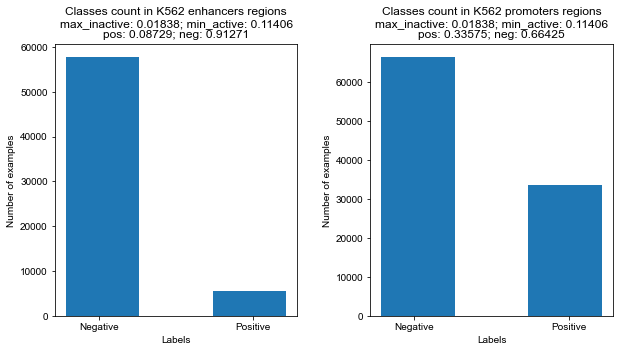

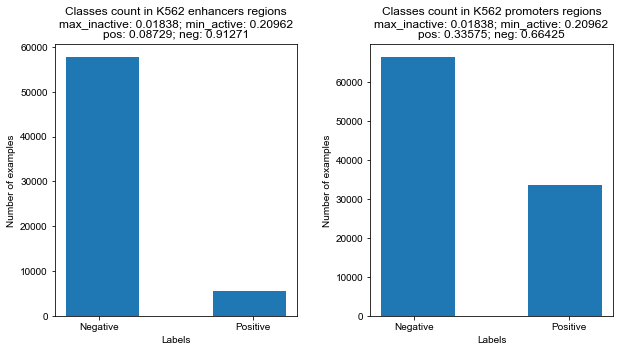

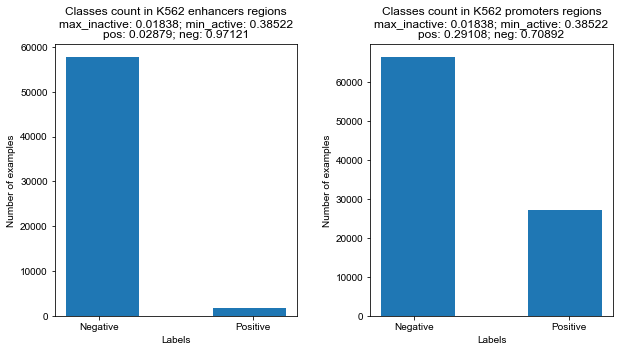

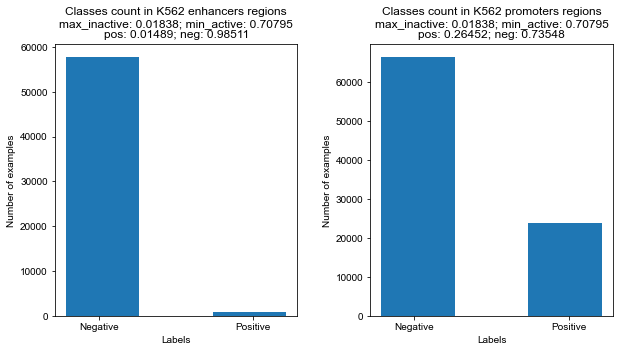

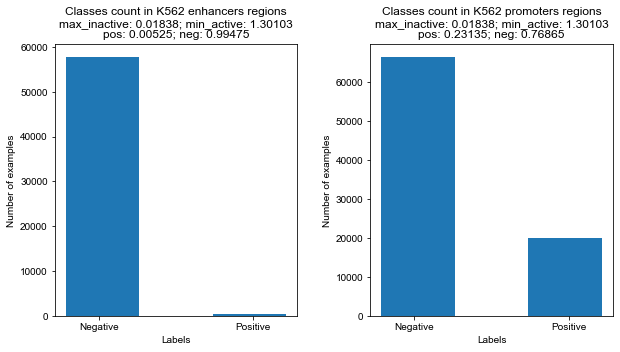

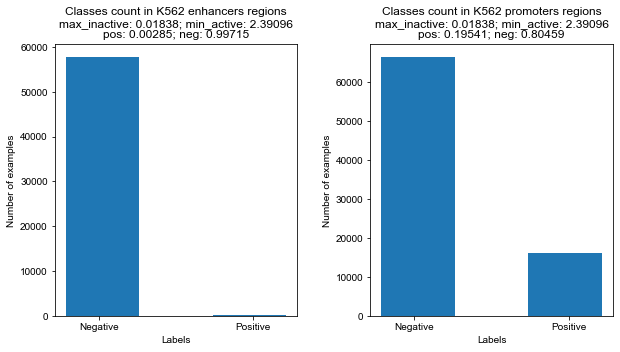

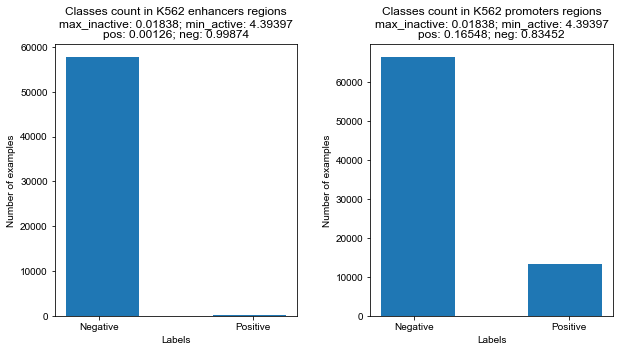

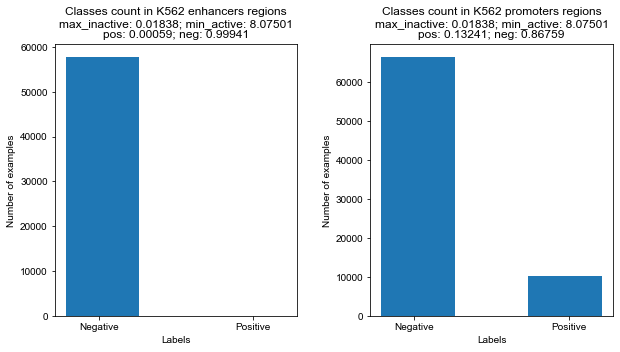

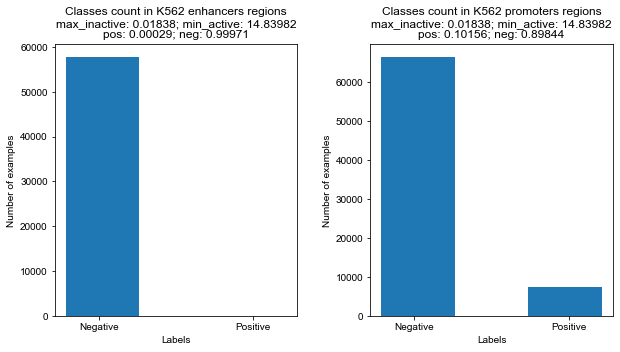

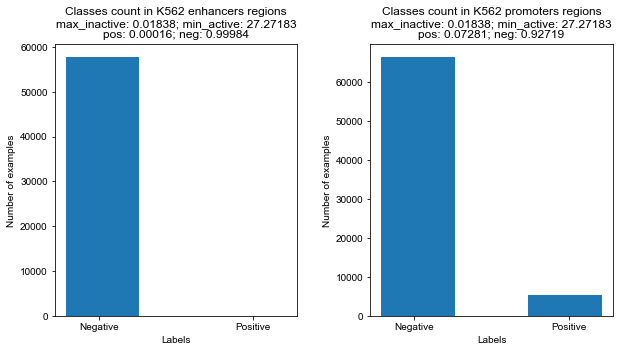

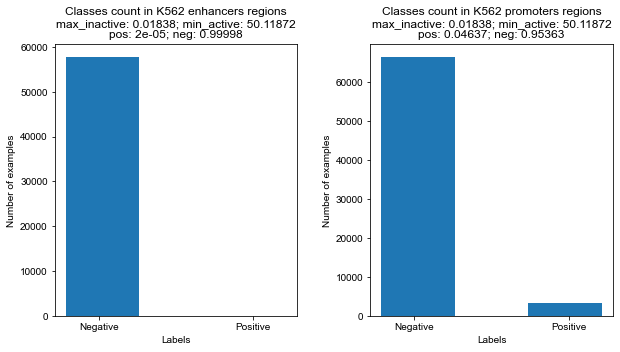

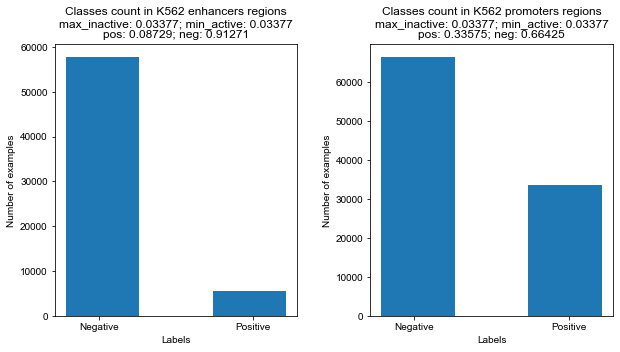

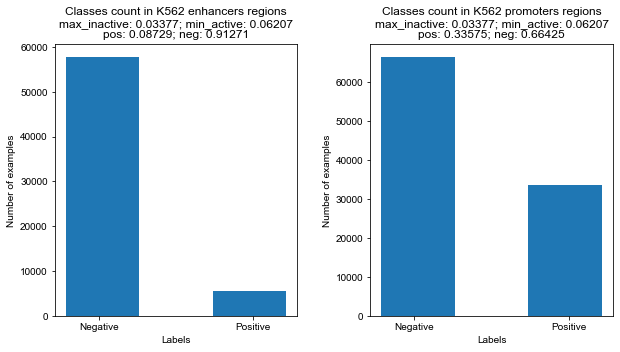

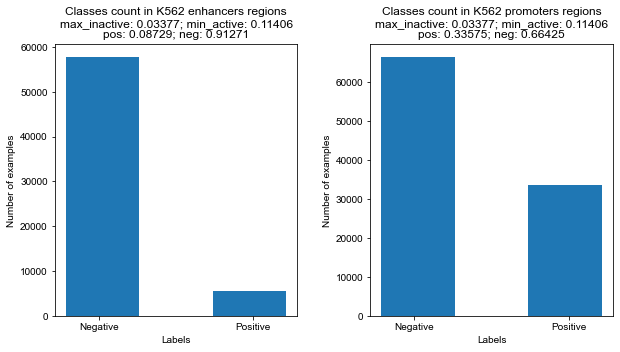

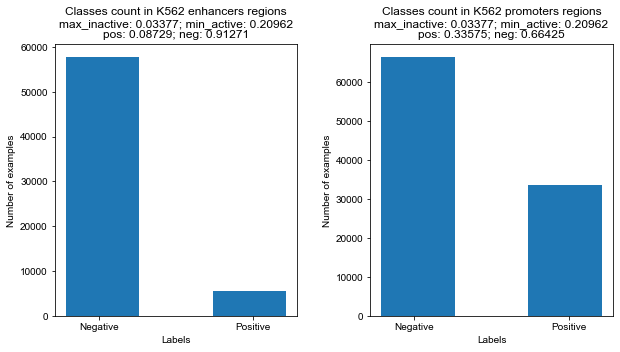

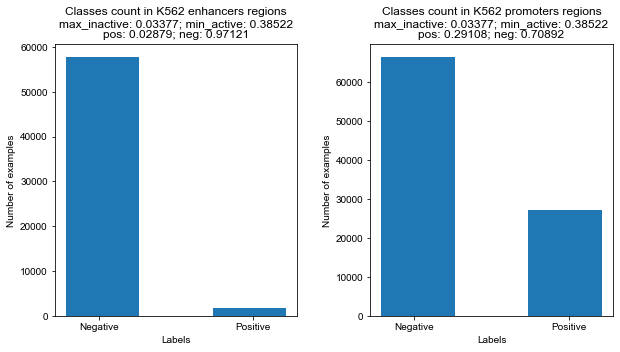

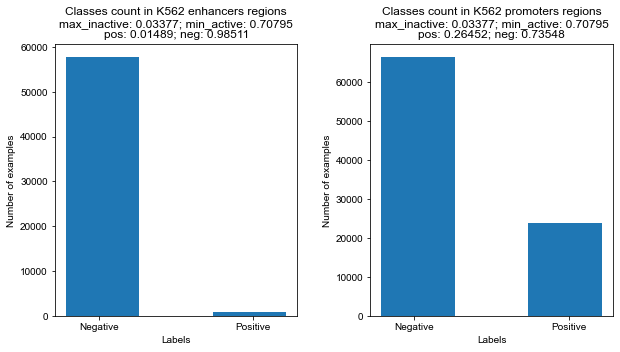

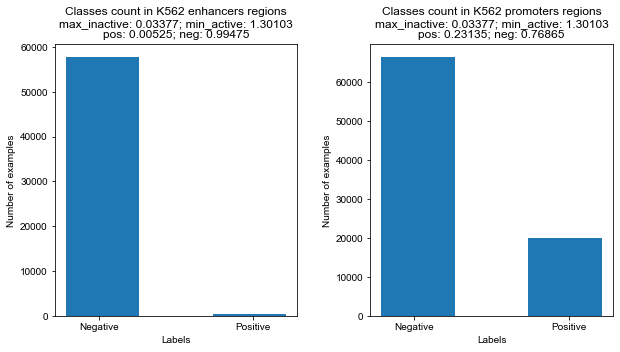

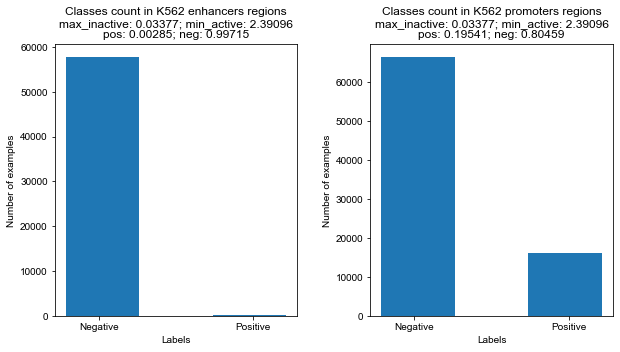

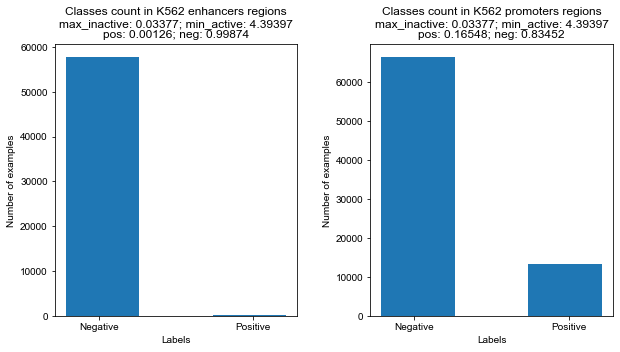

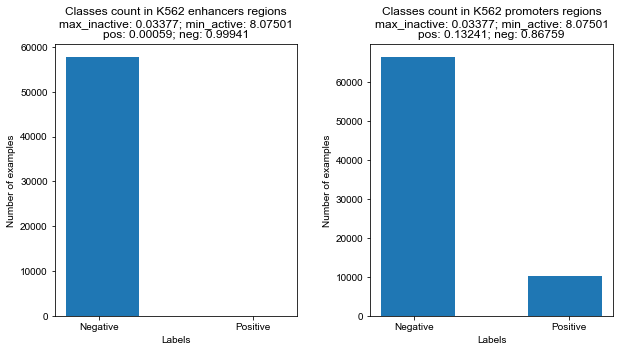

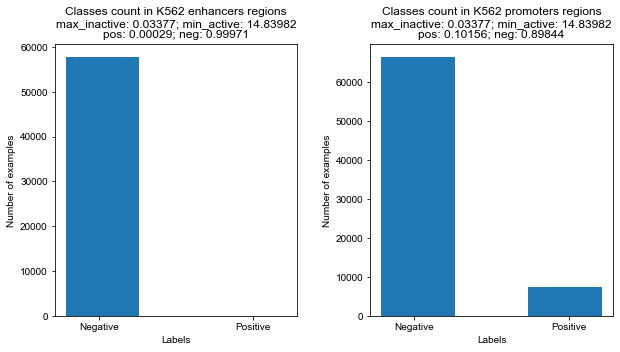

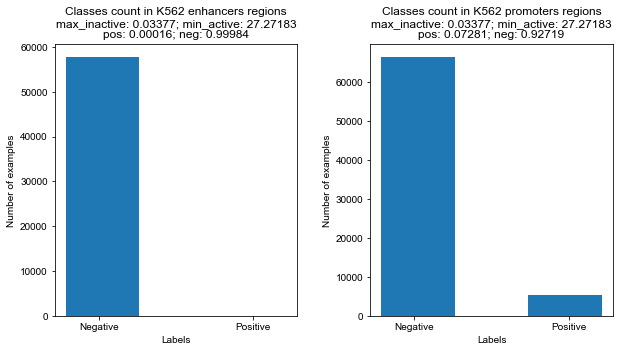

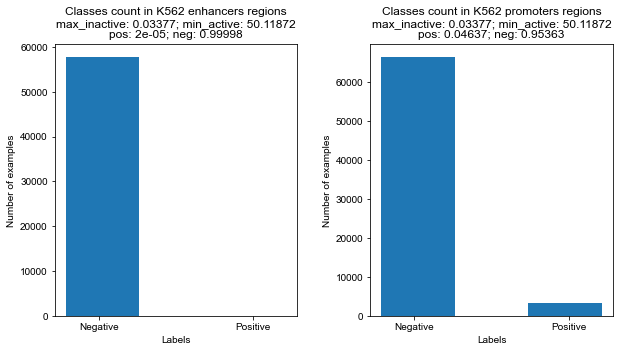

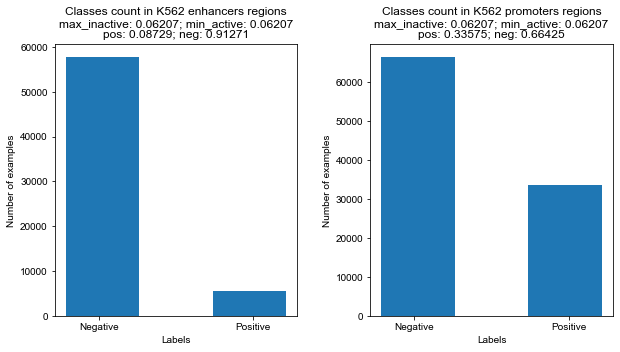

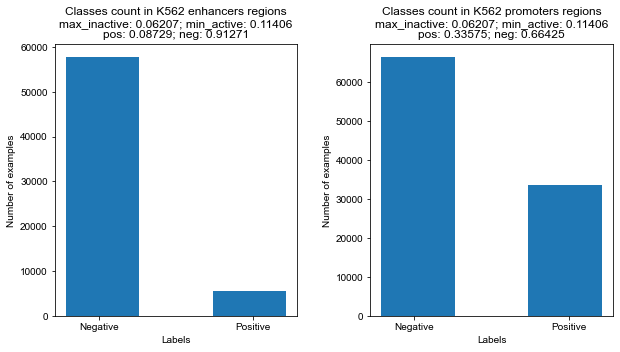

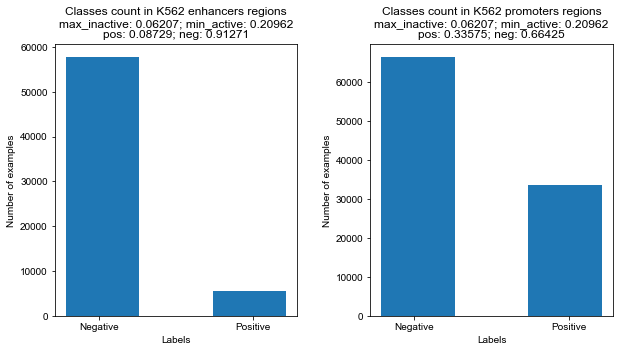

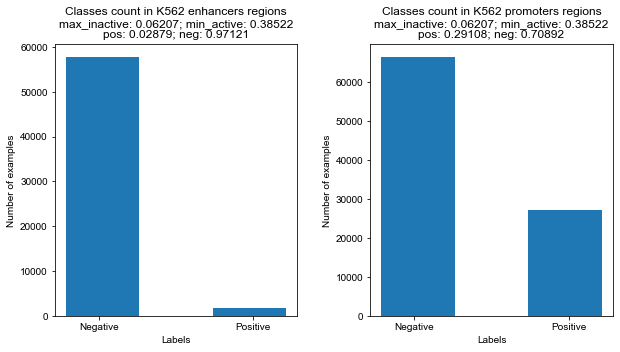

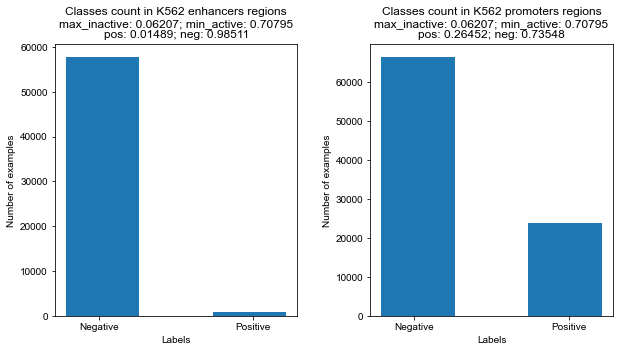

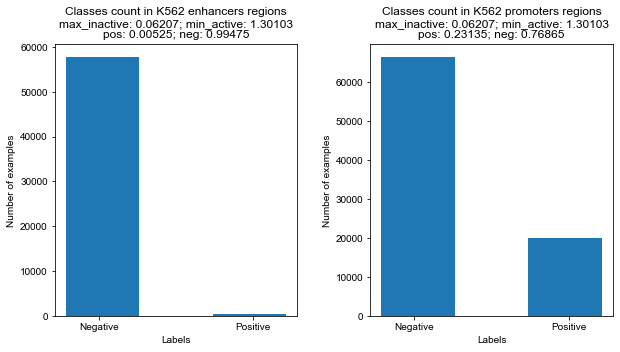

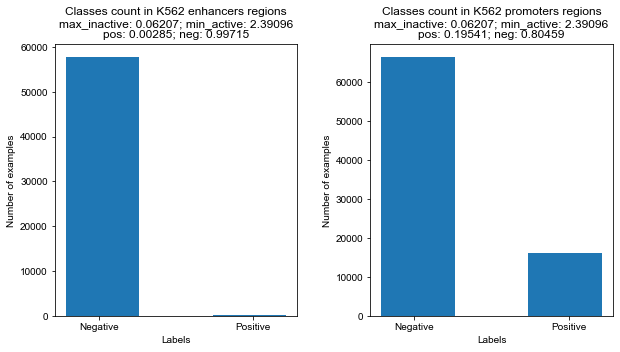

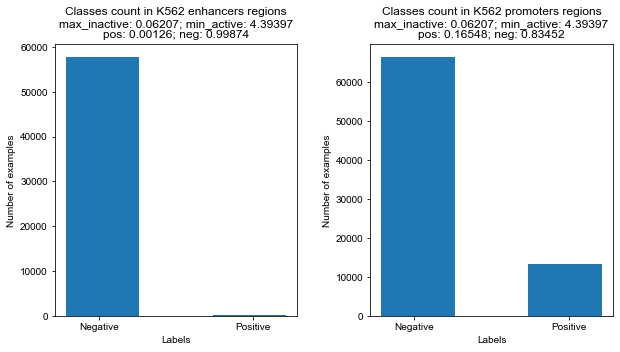

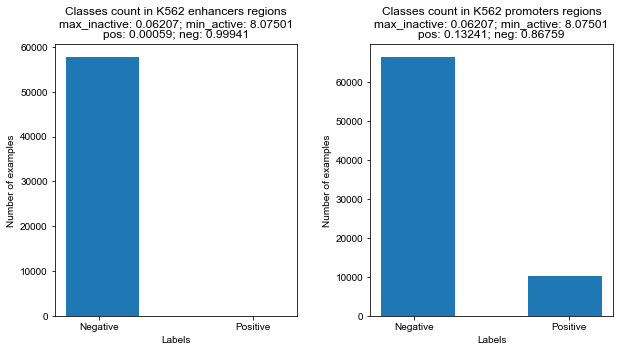

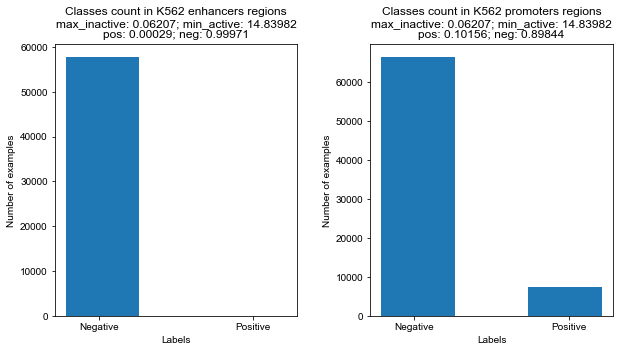

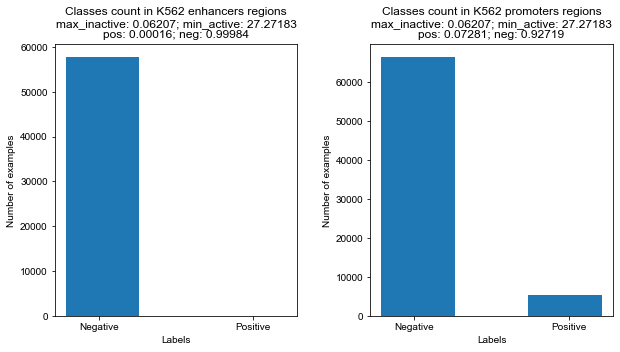

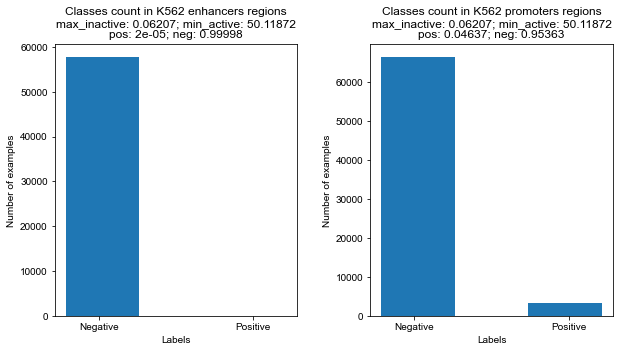

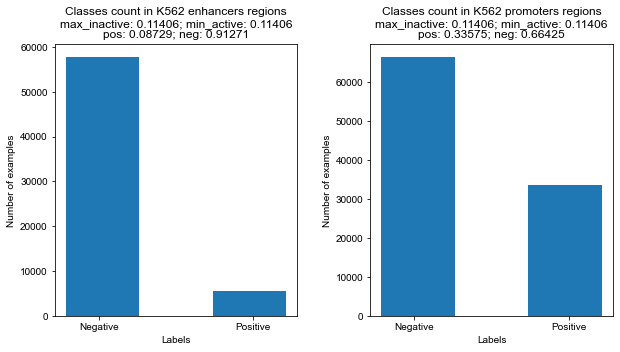

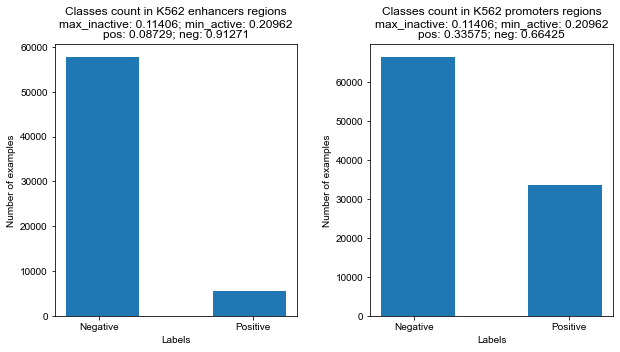

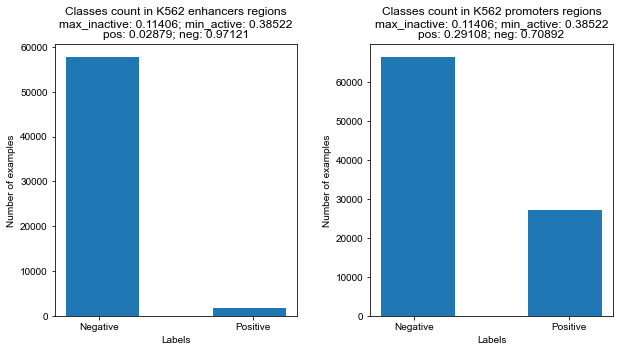

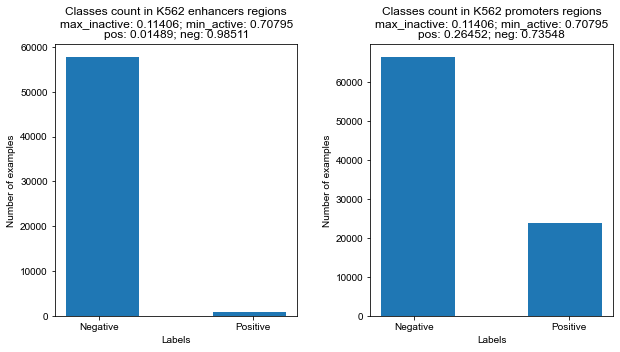

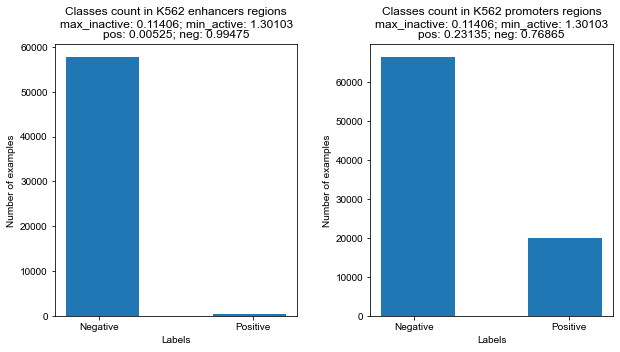

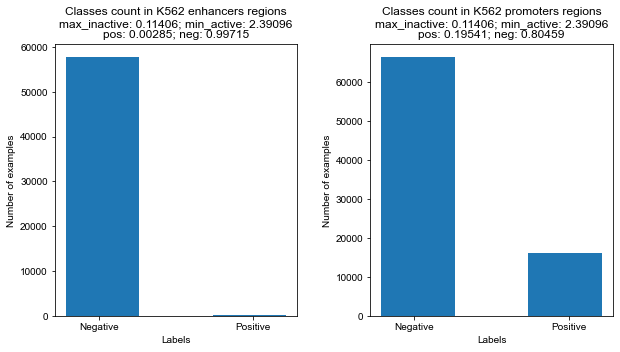

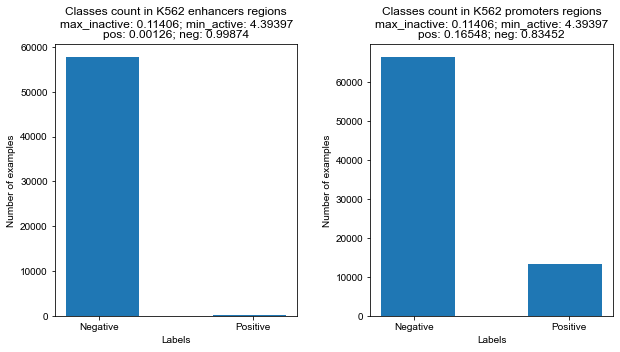

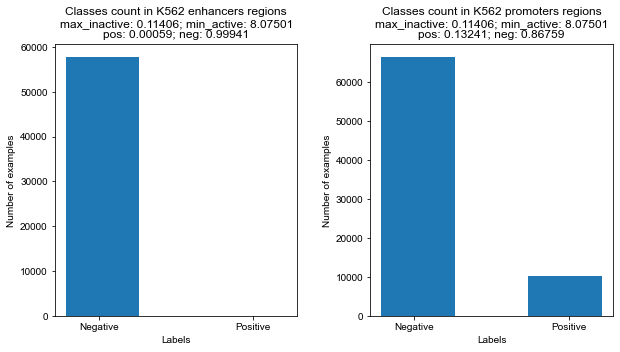

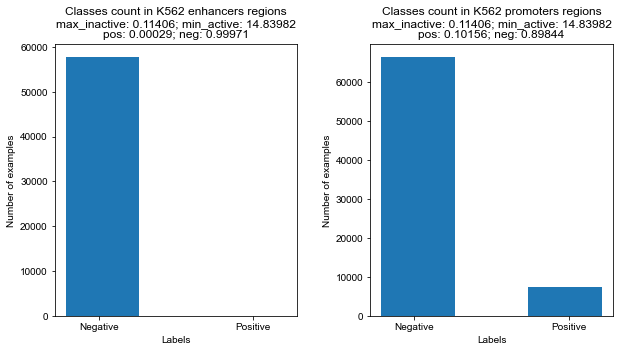

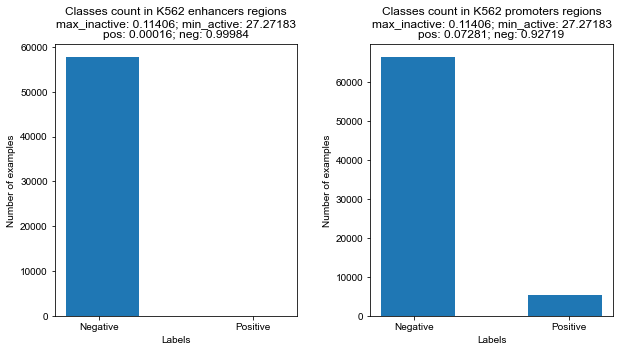

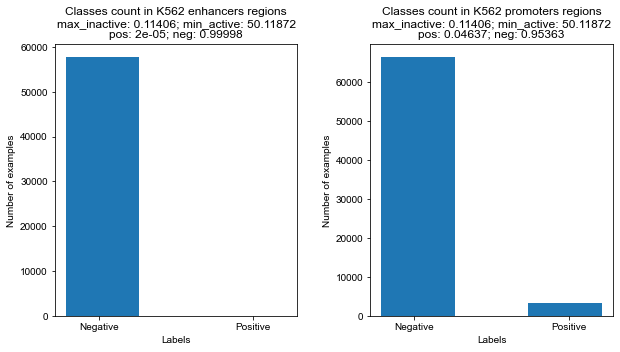

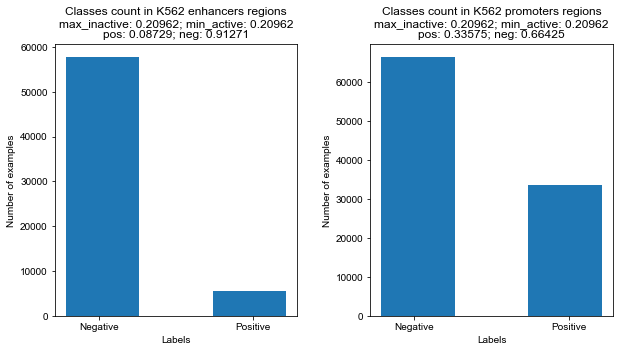

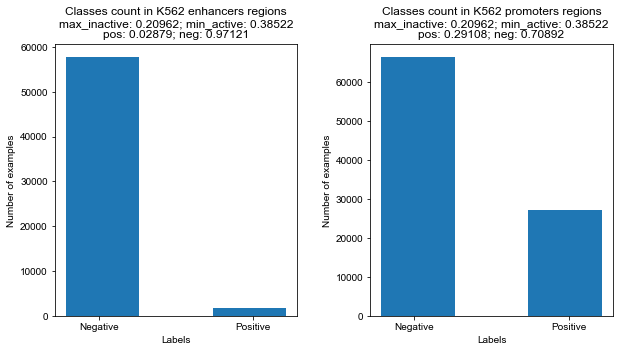

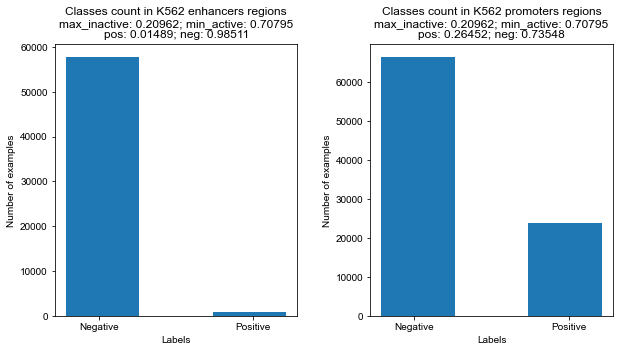

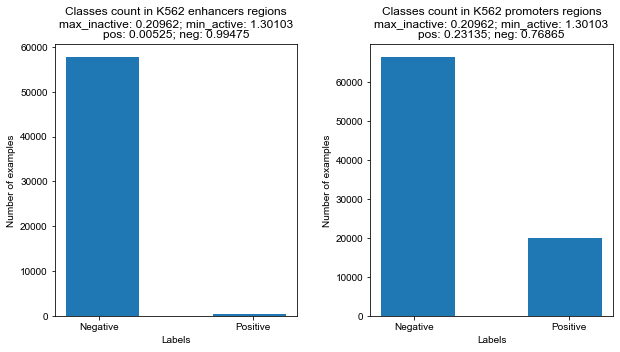

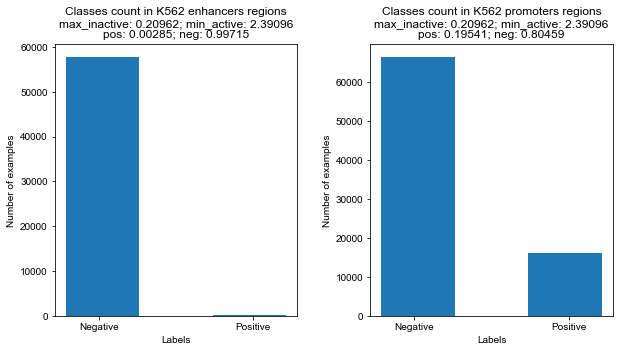

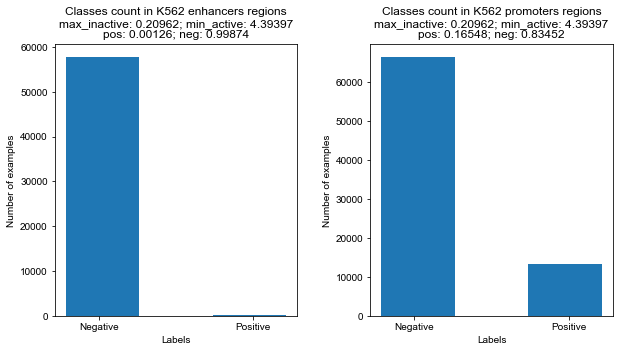

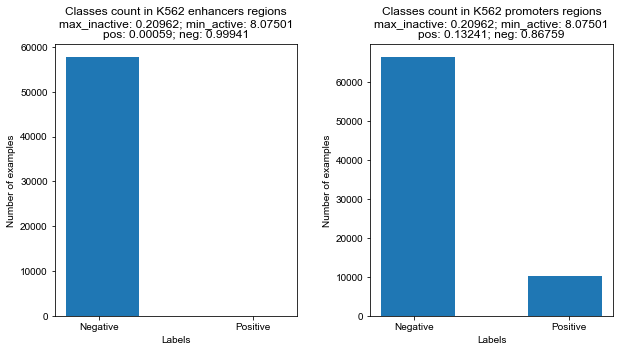

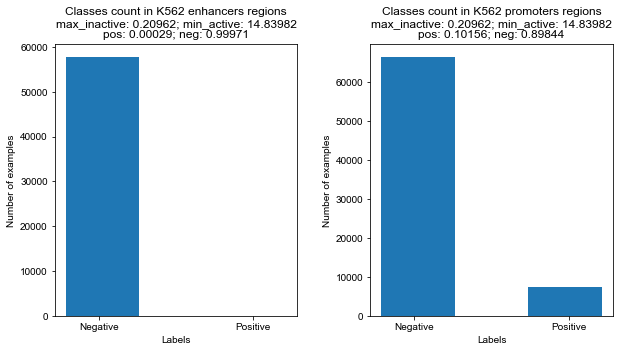

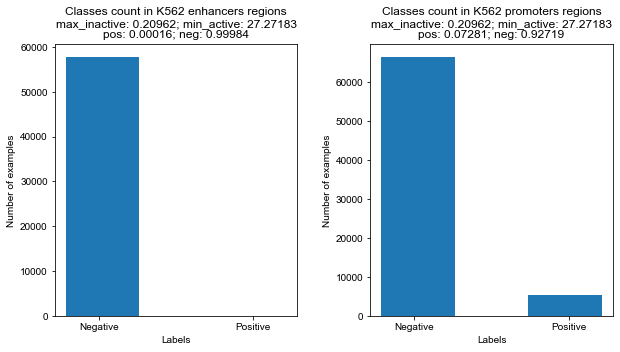

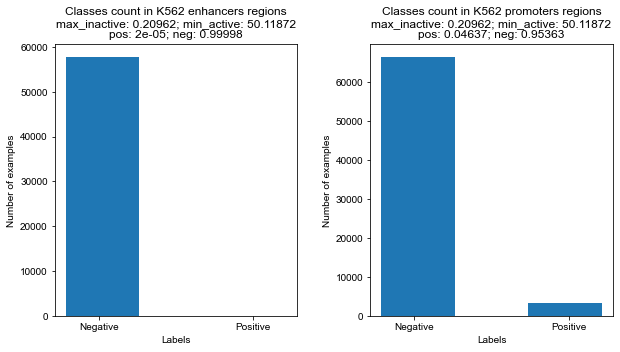

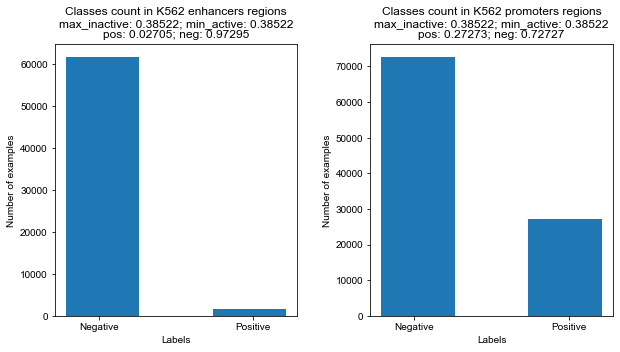

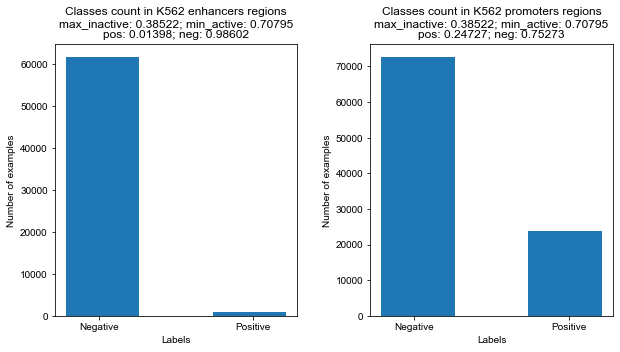

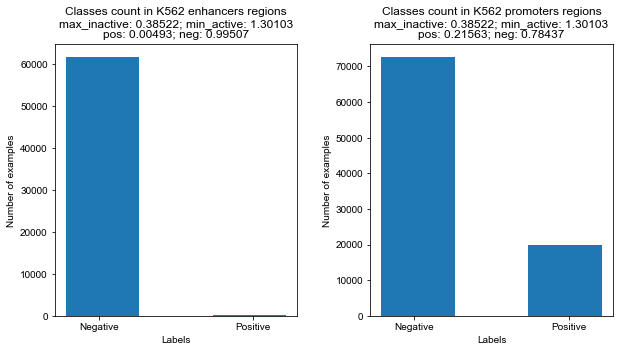

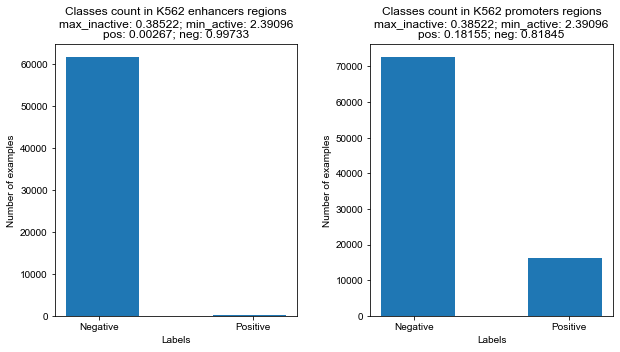

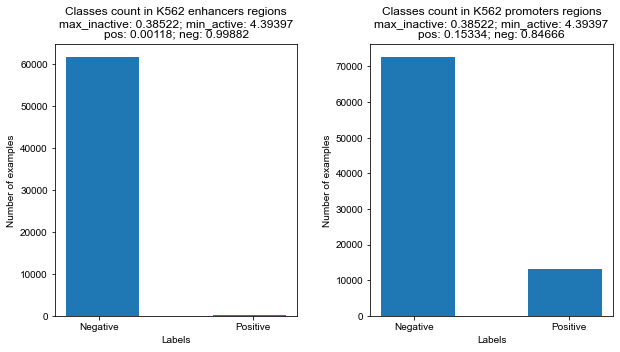

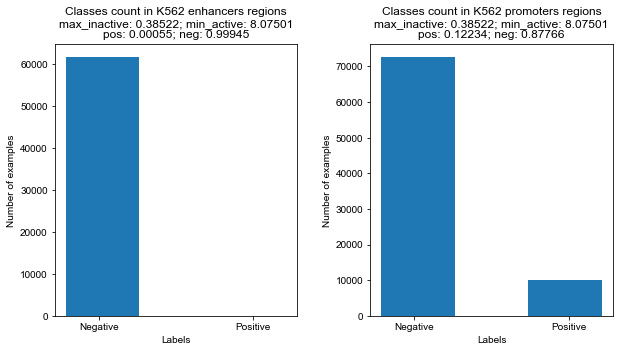

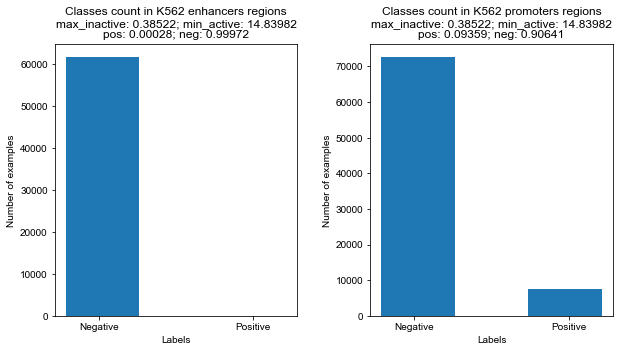

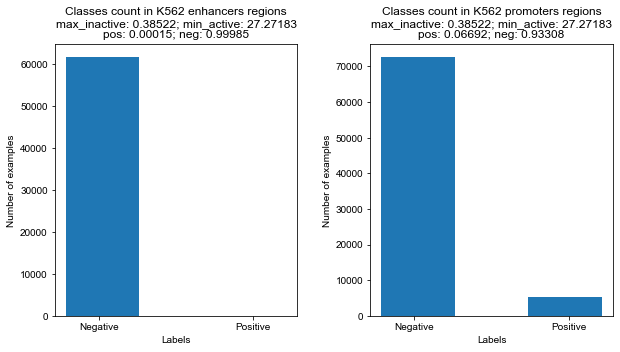

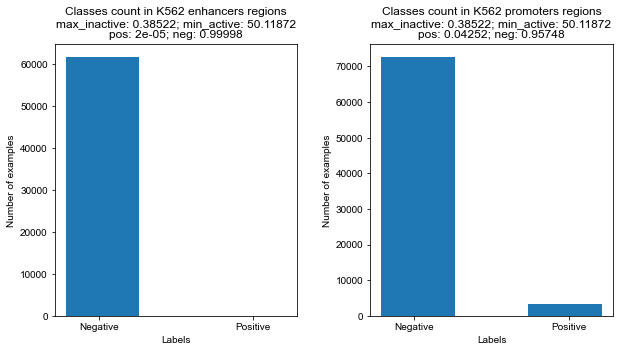

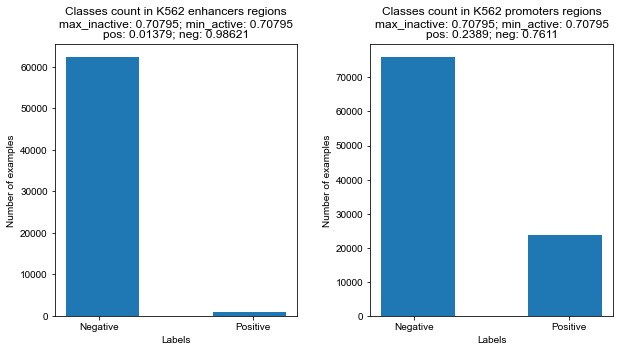

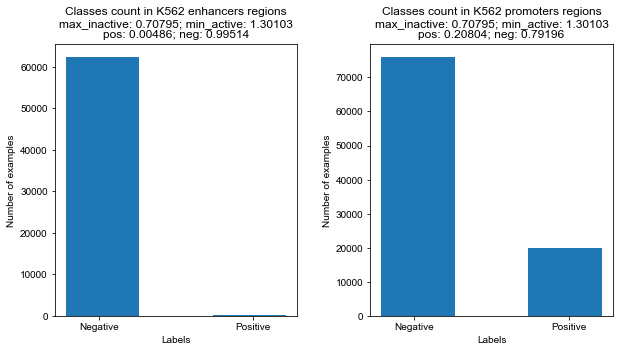

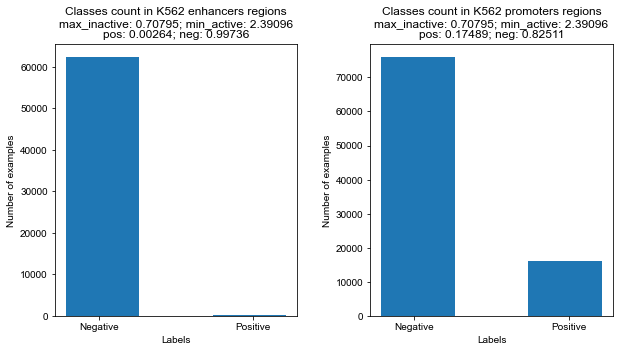

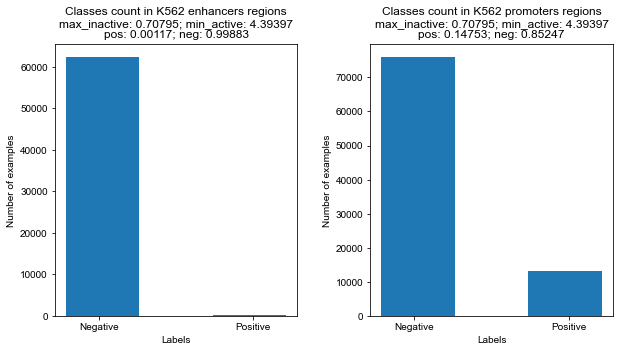

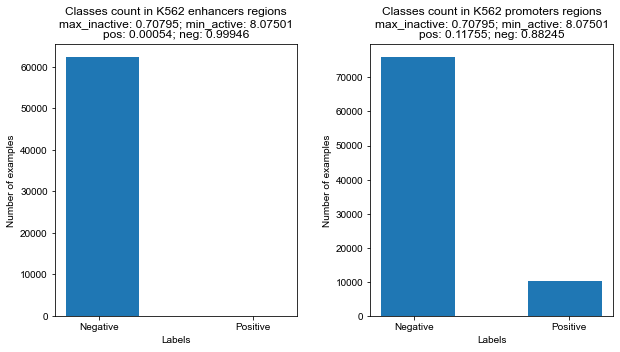

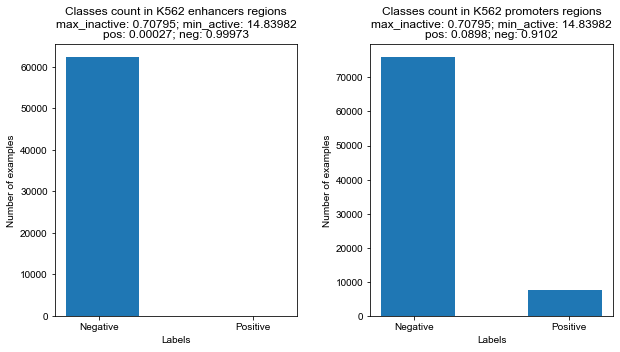

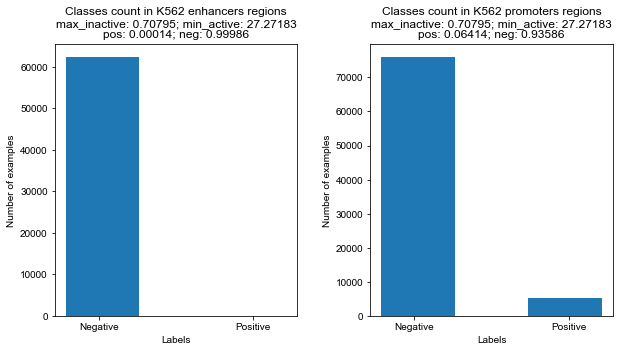

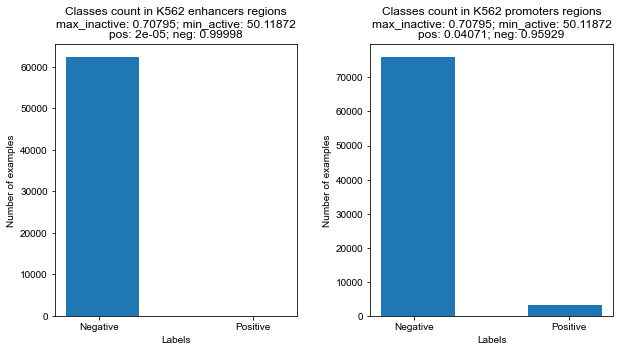

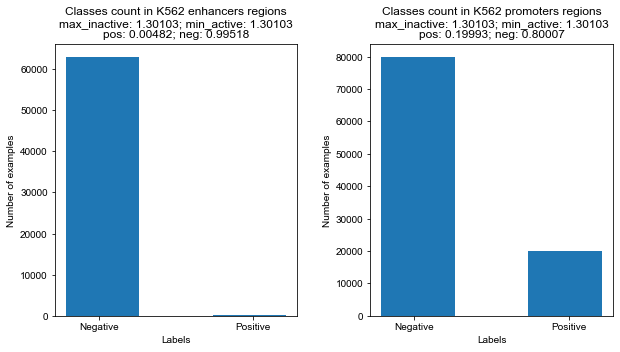

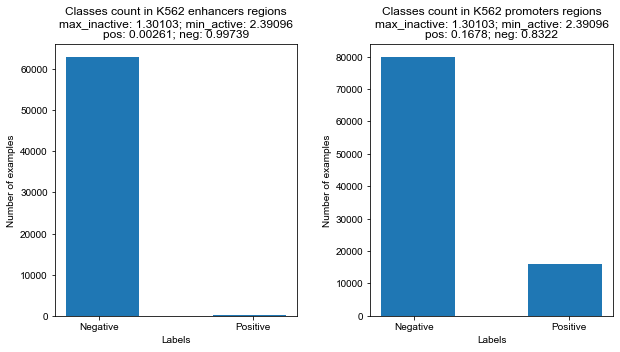

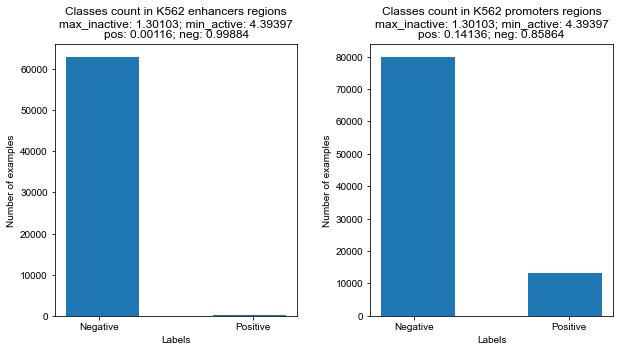

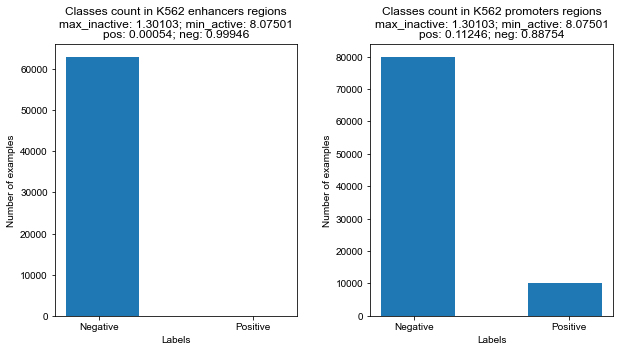

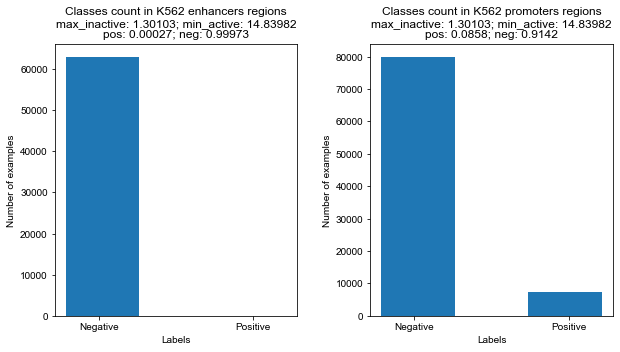

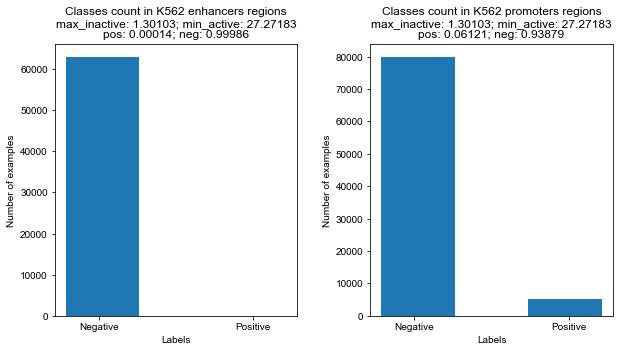

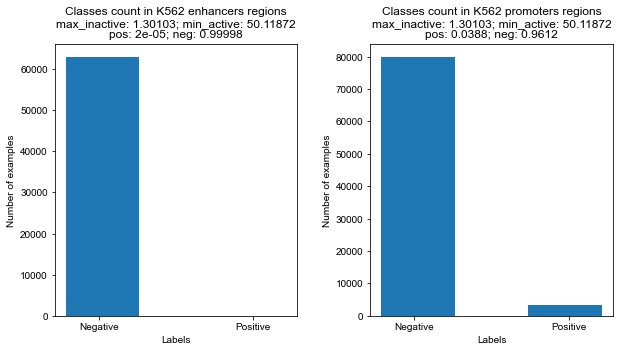

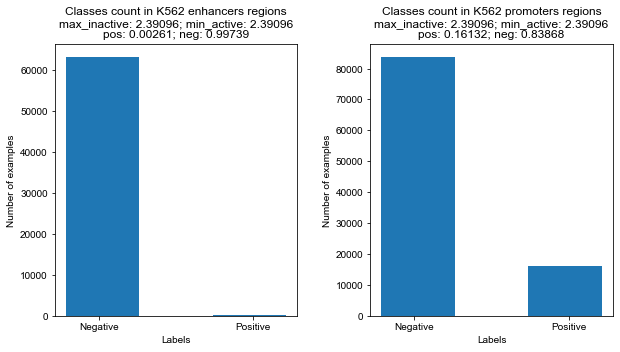

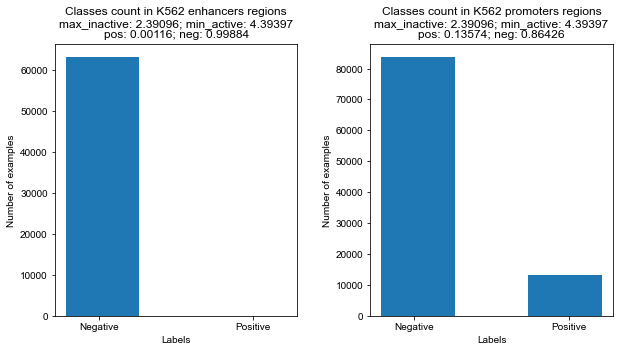

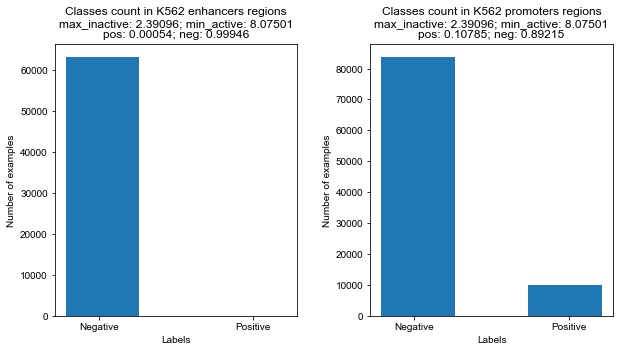

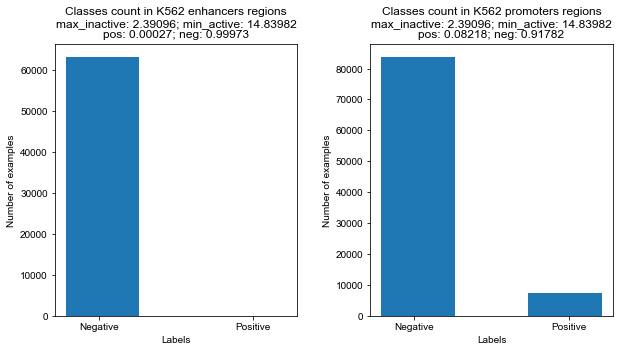

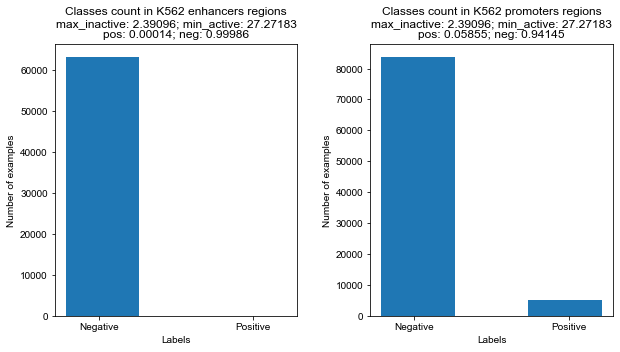

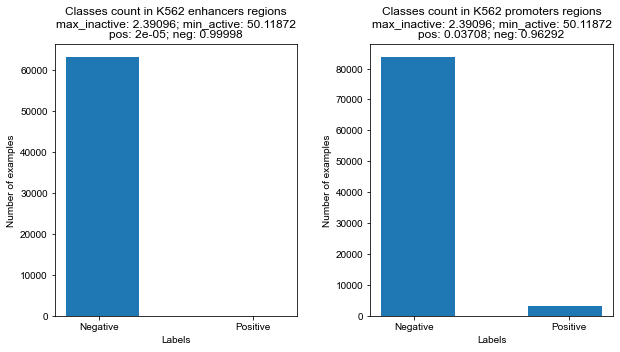

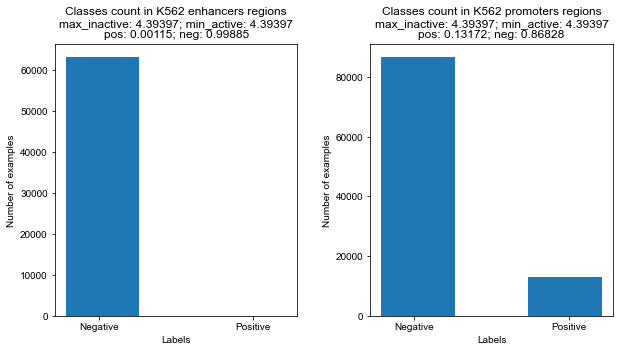

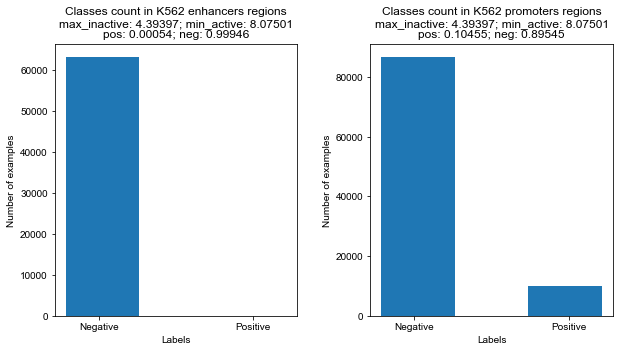

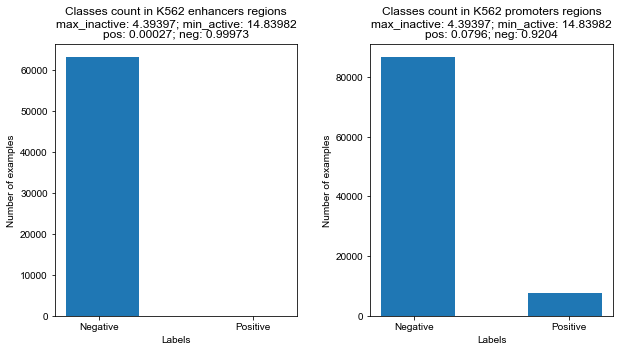

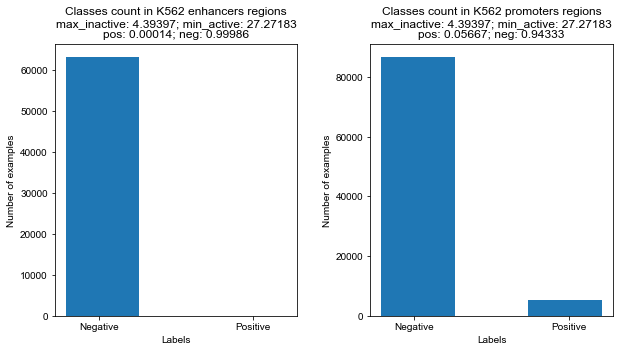

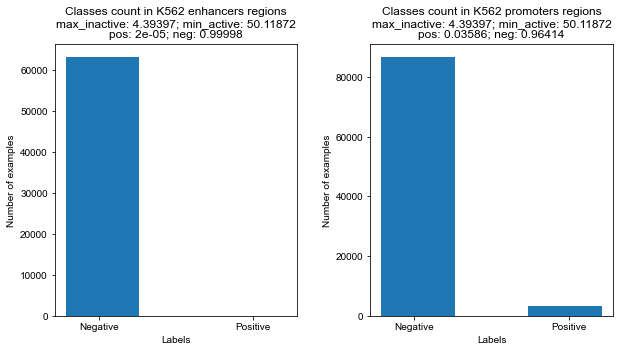

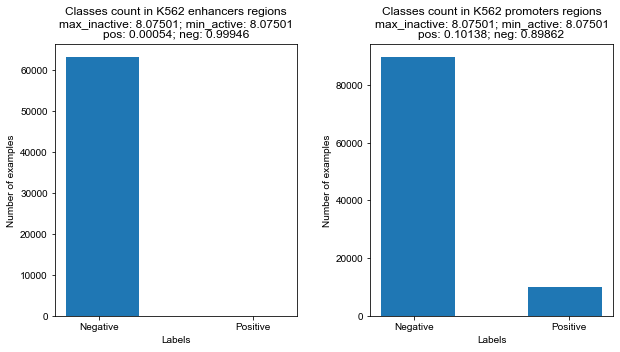

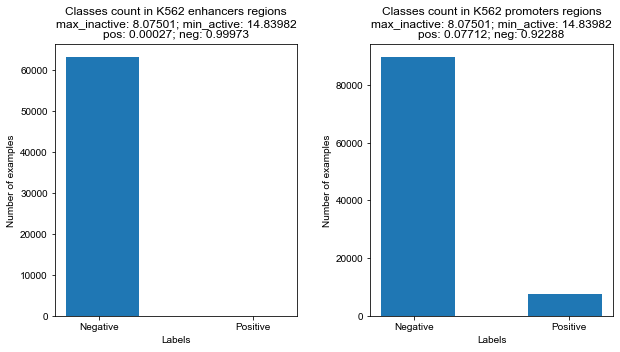

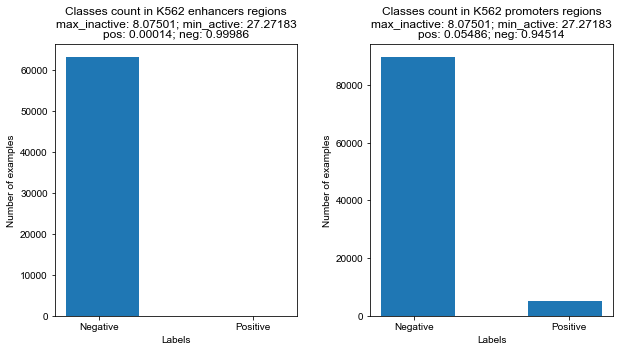

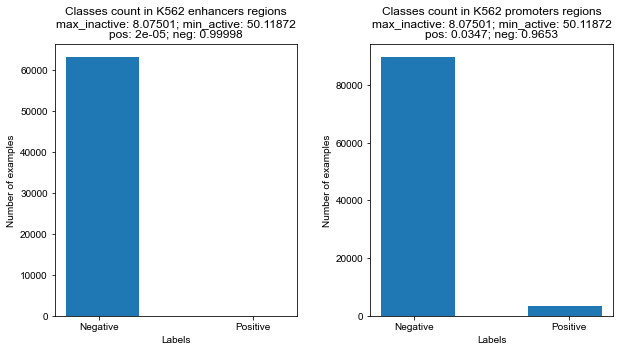

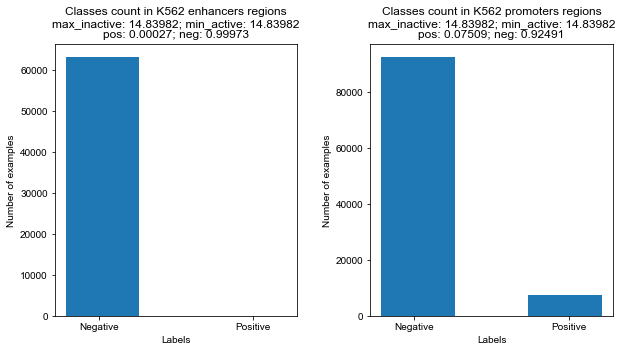

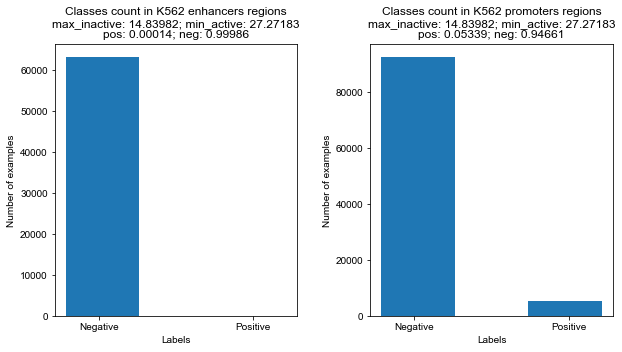

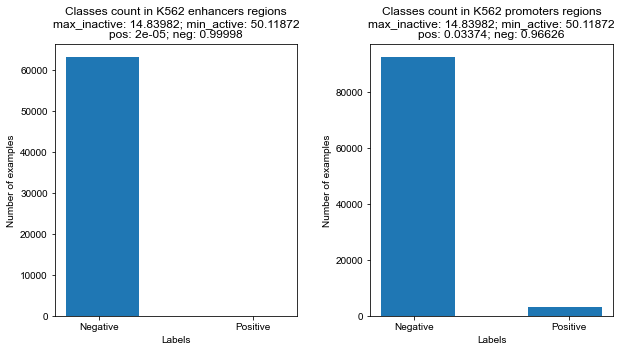

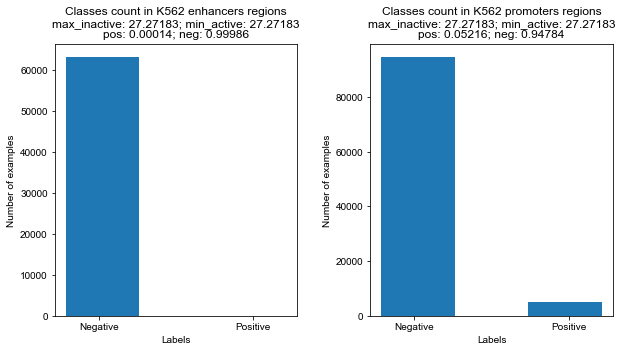

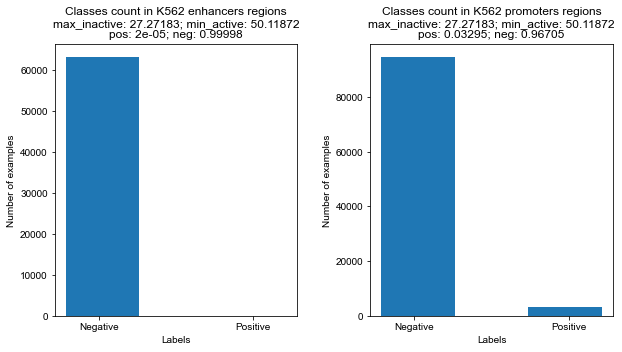

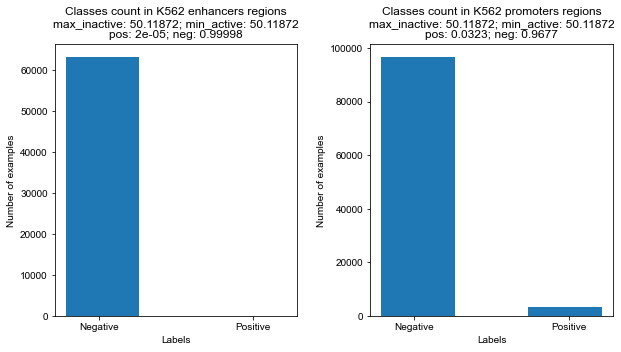

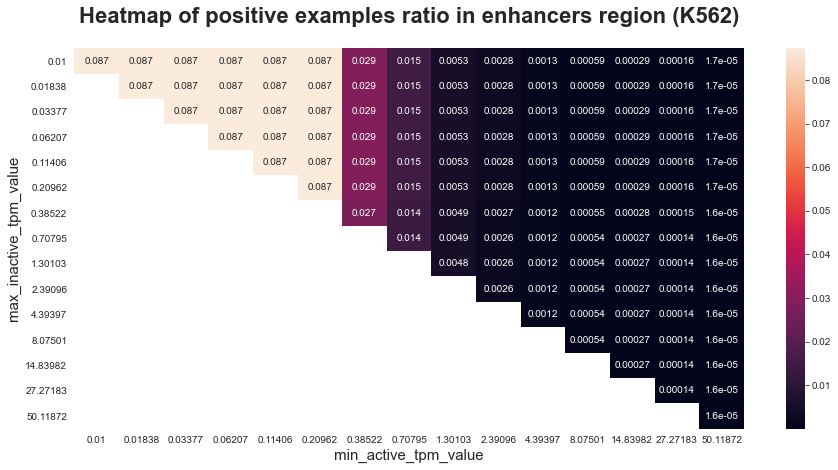

None

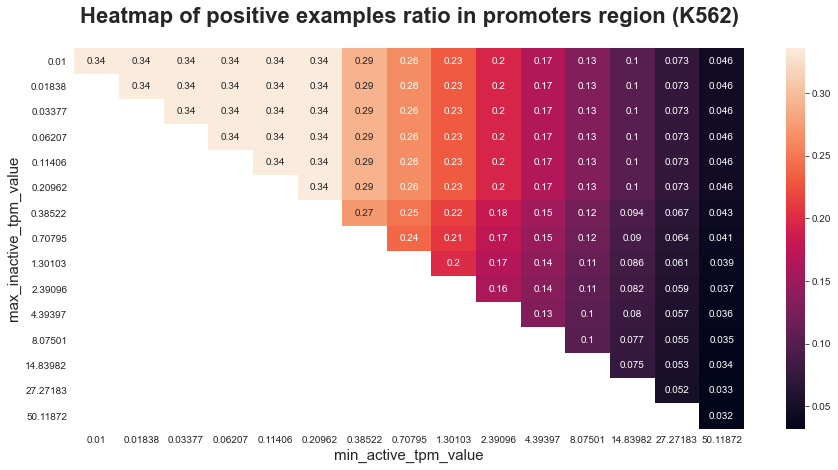

None

skipping 0 in MCF-7, already done
skipping 1 in MCF-7, already done
skipping 2 in MCF-7, already done
skipping 3 in MCF-7, already done
skipping 4 in MCF-7, already done
skipping 5 in MCF-7, already done
skipping 6 in MCF-7, already done
skipping 7 in MCF-7, already done
skipping 8 in MCF-7, already done
skipping 9 in MCF-7, already done
skipping 10 in MCF-7, already done
skipping 11 in MCF-7, already done
skipping 12 in MCF-7, already done
skipping 13 in MCF-7, already done
skipping 14 in MCF-7, already done
skipping 15 in MCF-7, already done
skipping 16 in MCF-7, already done
skipping 17 in MCF-7, already done
skipping 18 in MCF-7, already done
skipping 19 in MCF-7, already done
skipping 20 in MCF-7, already done


<ipython-input-16-46ac61b40642>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=2, figsize=(10, 5))


skipping 21 in MCF-7, already done
skipping 22 in MCF-7, already done
skipping 23 in MCF-7, already done
skipping 24 in MCF-7, already done
skipping 25 in MCF-7, already done
skipping 26 in MCF-7, already done
skipping 27 in MCF-7, already done
skipping 28 in MCF-7, already done
skipping 29 in MCF-7, already done
skipping 30 in MCF-7, already done
skipping 31 in MCF-7, already done
skipping 32 in MCF-7, already done
skipping 33 in MCF-7, already done
skipping 34 in MCF-7, already done
skipping 35 in MCF-7, already done
skipping 36 in MCF-7, already done
skipping 37 in MCF-7, already done
skipping 38 in MCF-7, already done
skipping 39 in MCF-7, already done
skipping 40 in MCF-7, already done
skipping 41 in MCF-7, already done
skipping 42 in MCF-7, already done
skipping 43 in MCF-7, already done
skipping 44 in MCF-7, already done
skipping 45 in MCF-7, already done
skipping 46 in MCF-7, already done
skipping 47 in MCF-7, already done
skipping 48 in MCF-7, already done
skipping 49 in MCF-7

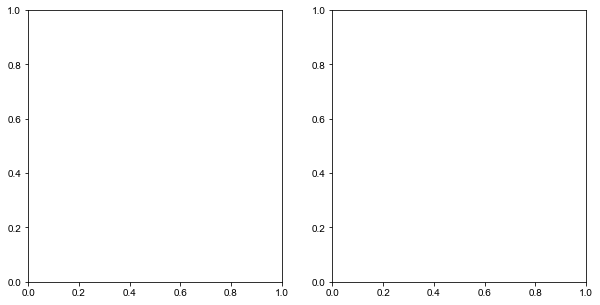

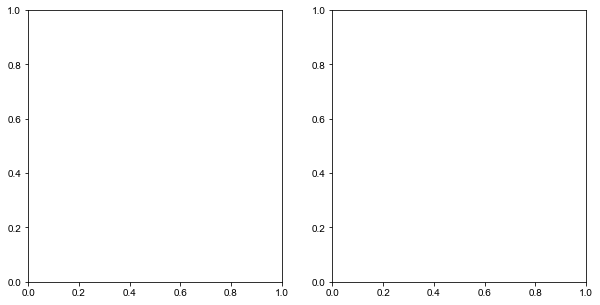

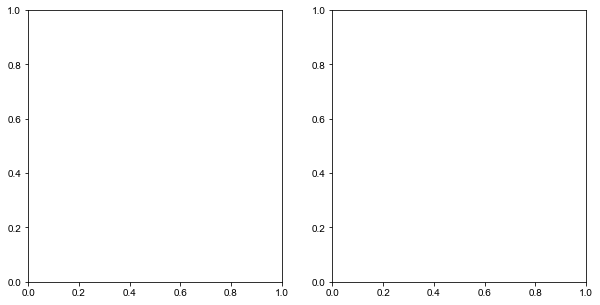

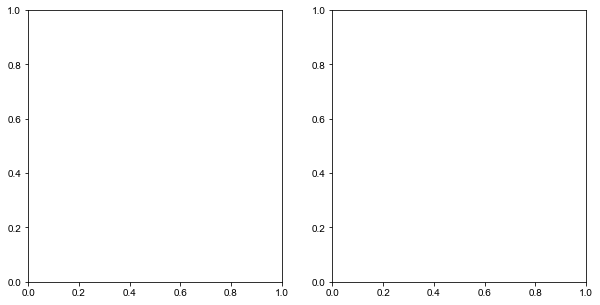

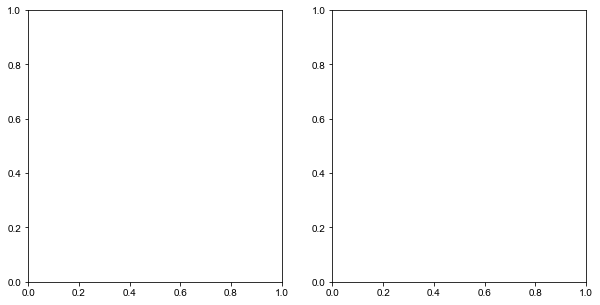

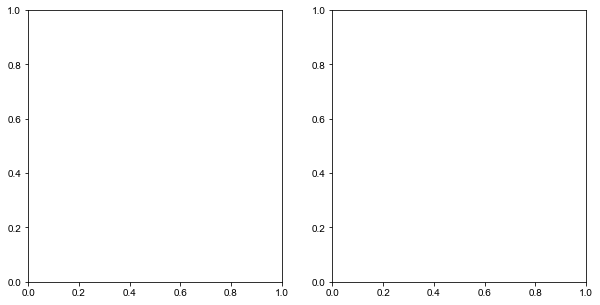

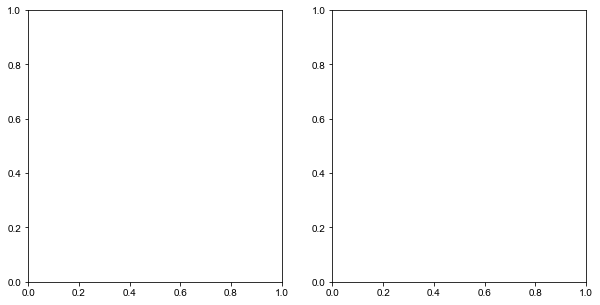

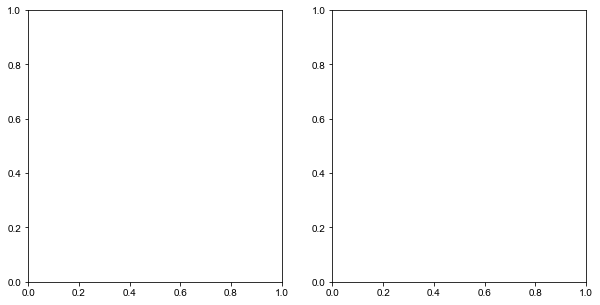

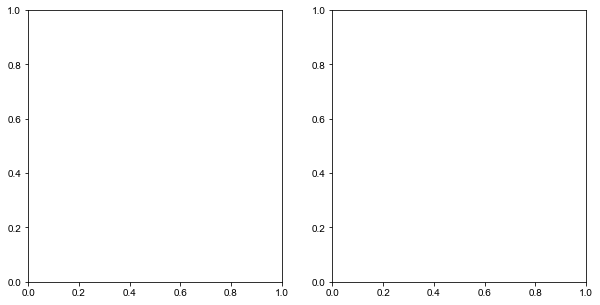

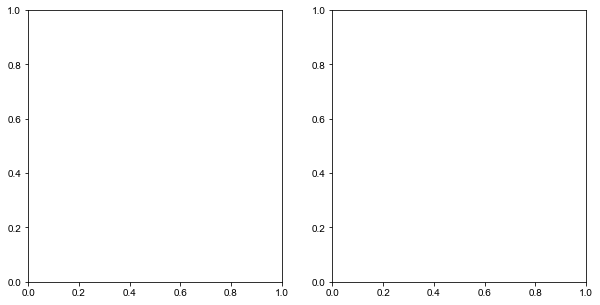

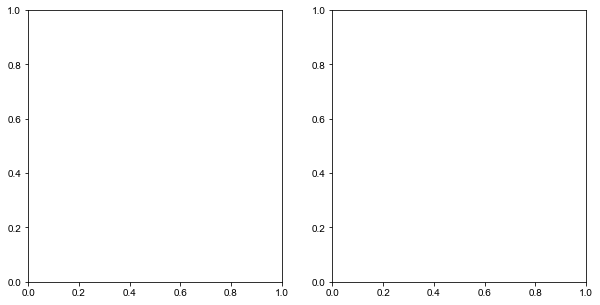

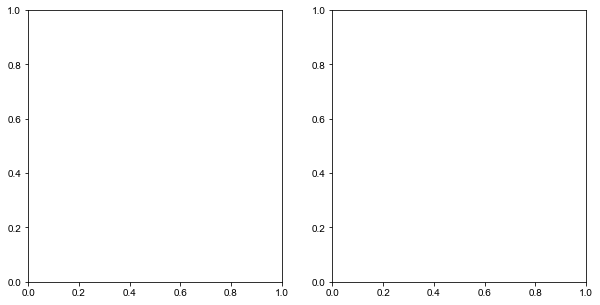

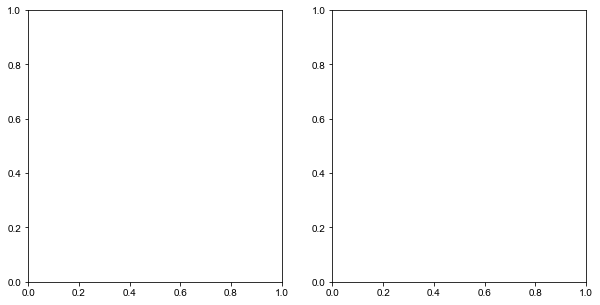

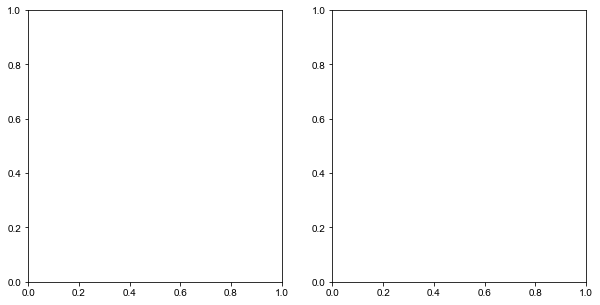

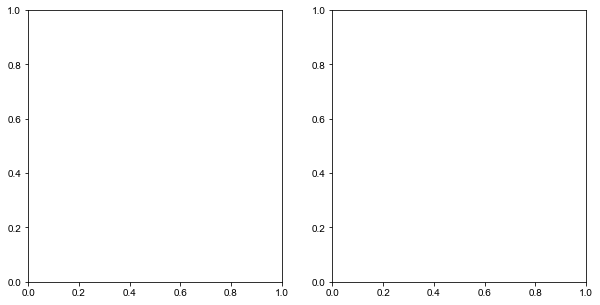

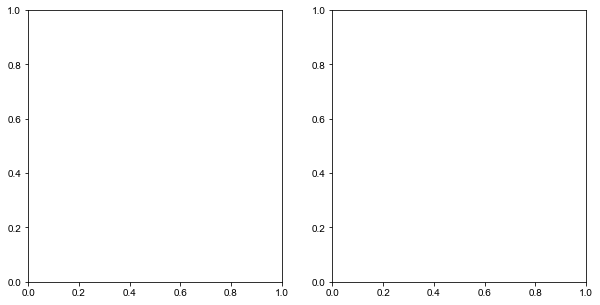

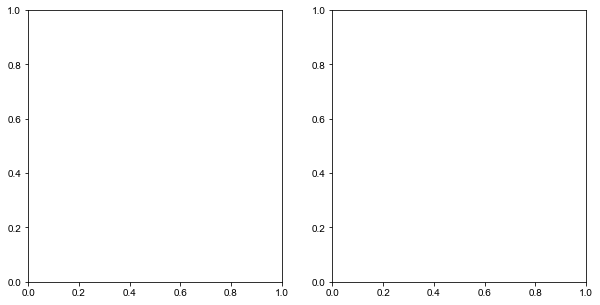

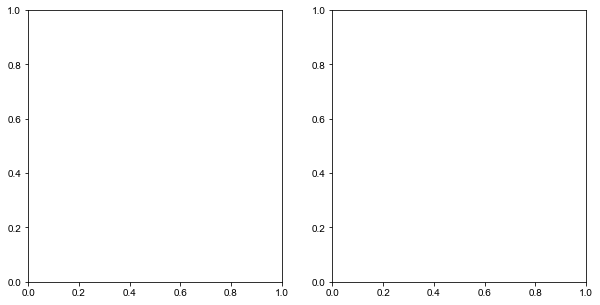

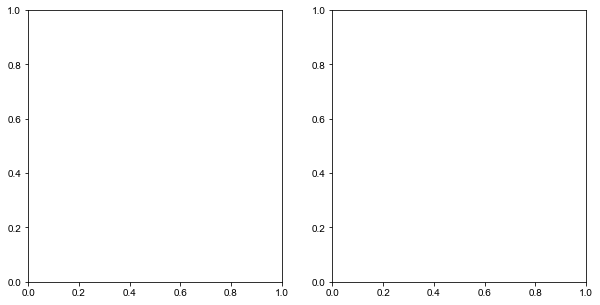

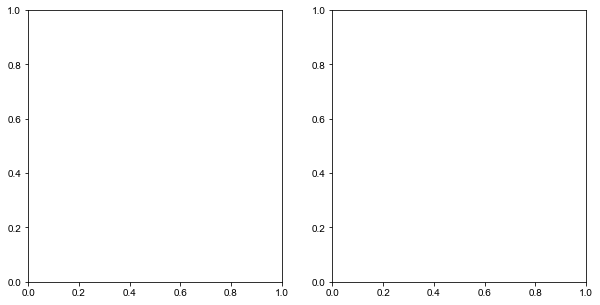

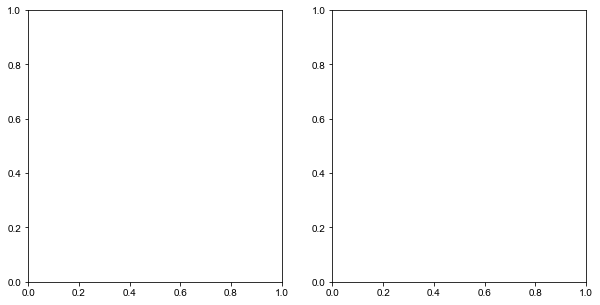

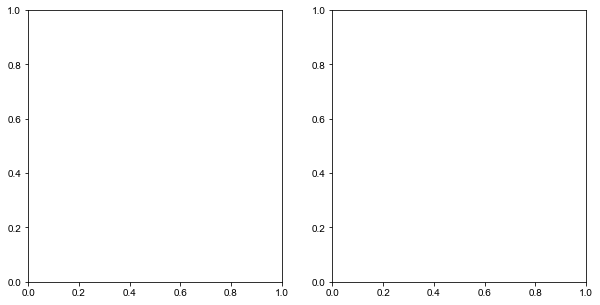

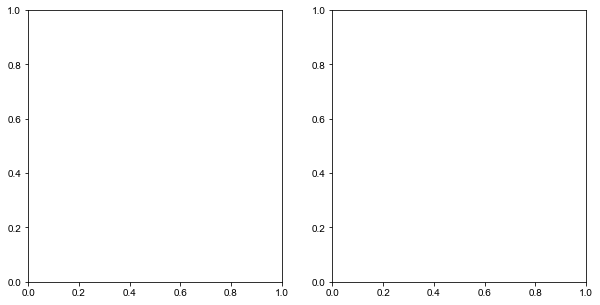

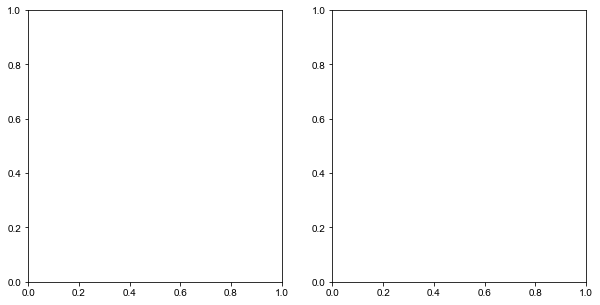

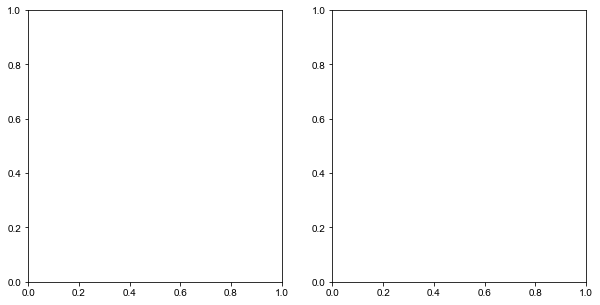

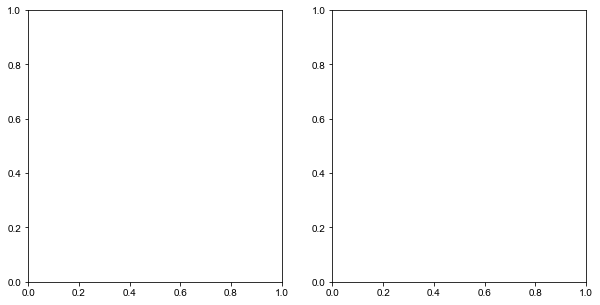

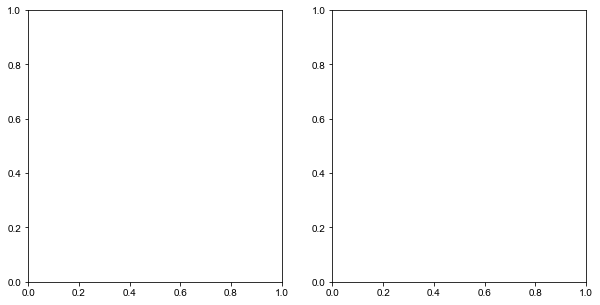

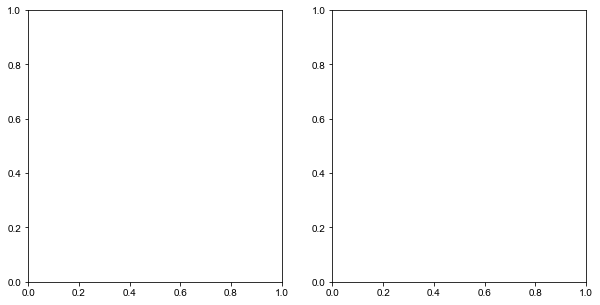

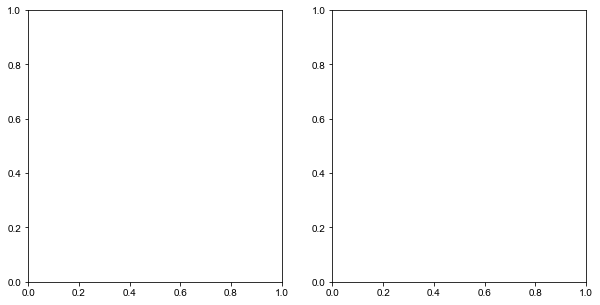

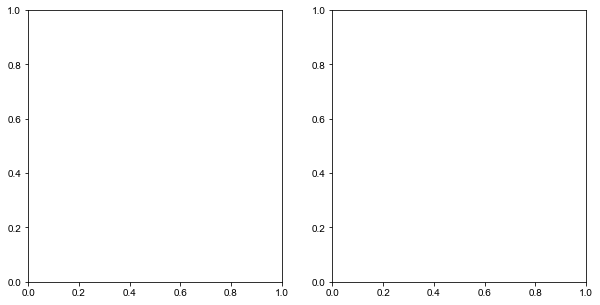

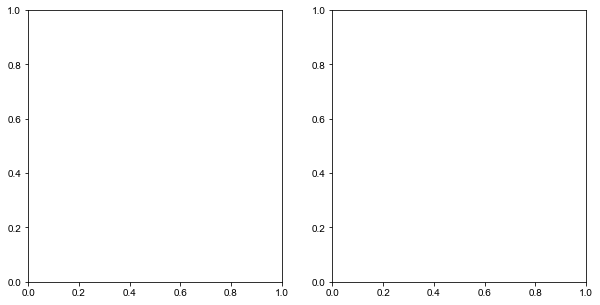

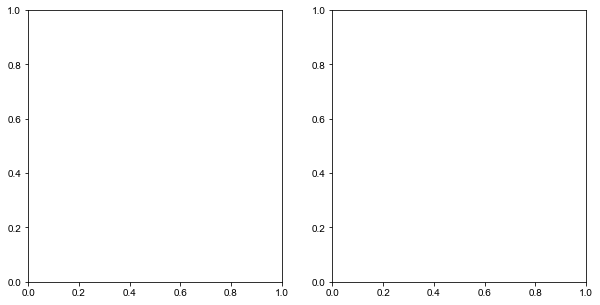

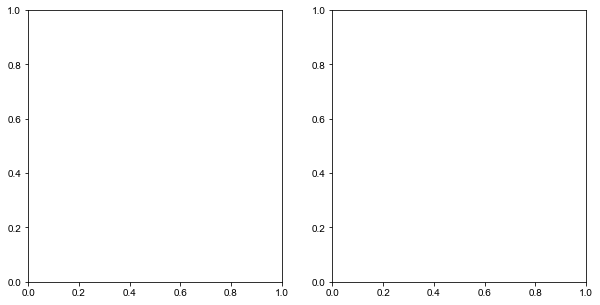

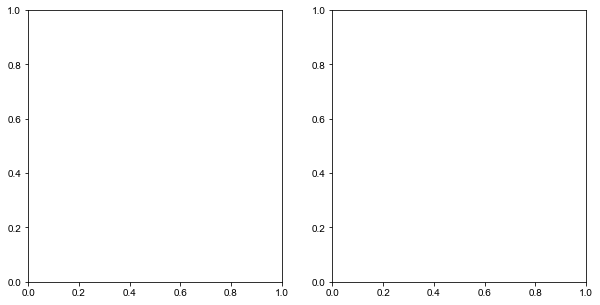

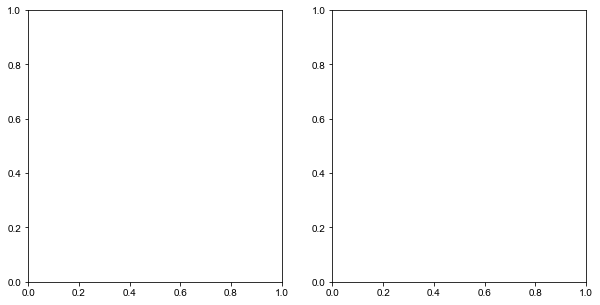

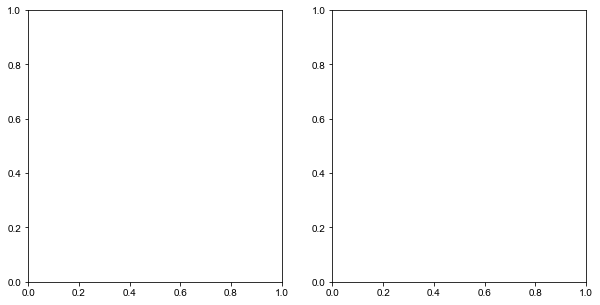

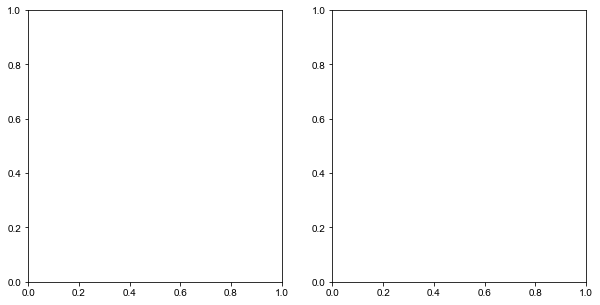

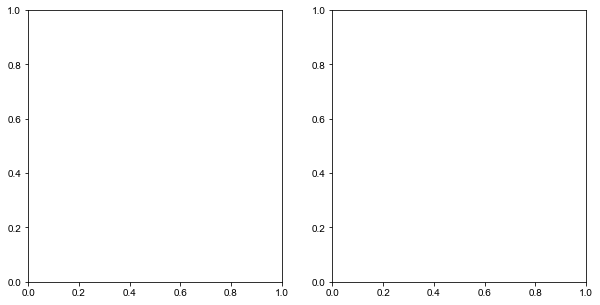

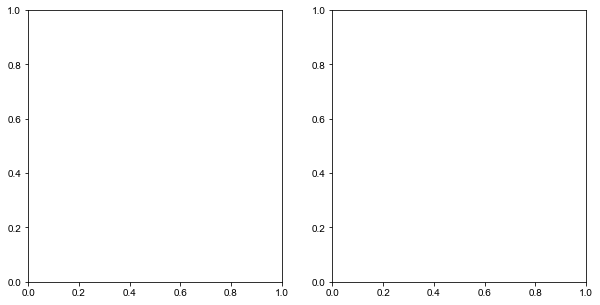

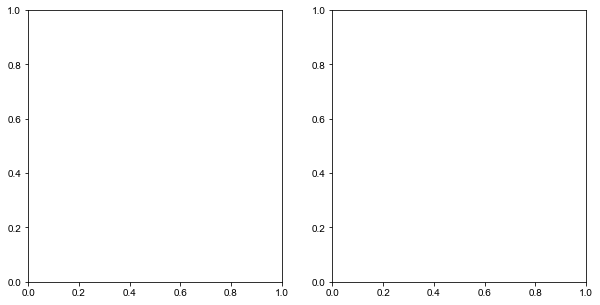

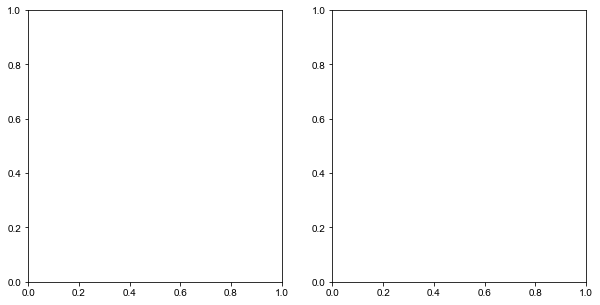

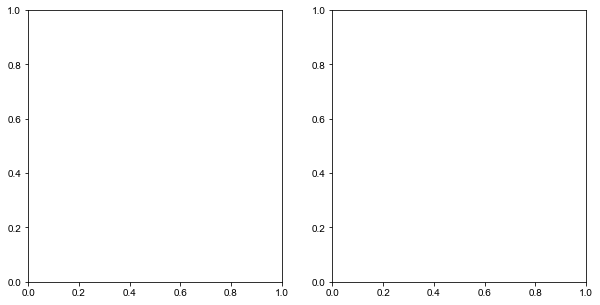

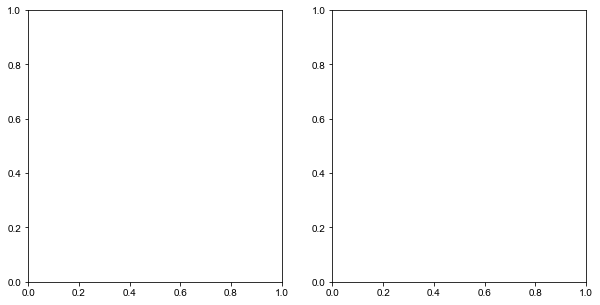

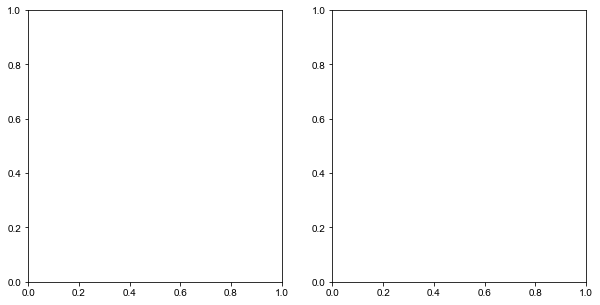

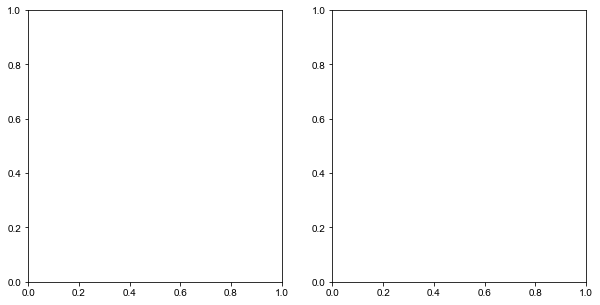

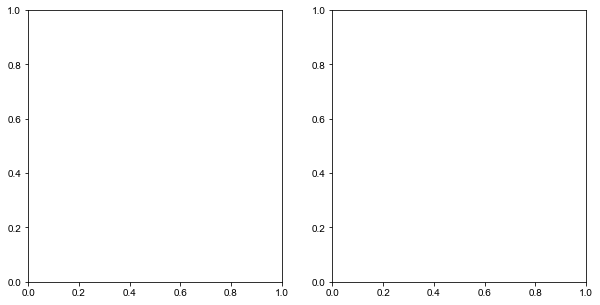

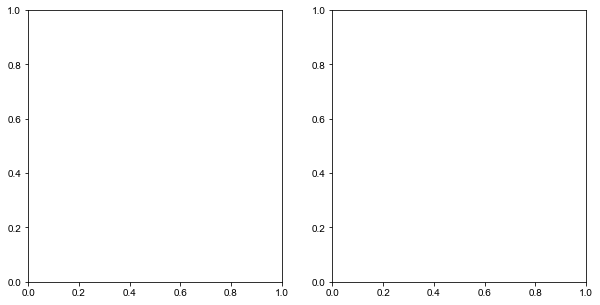

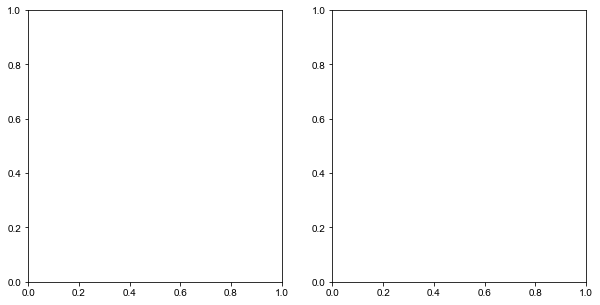

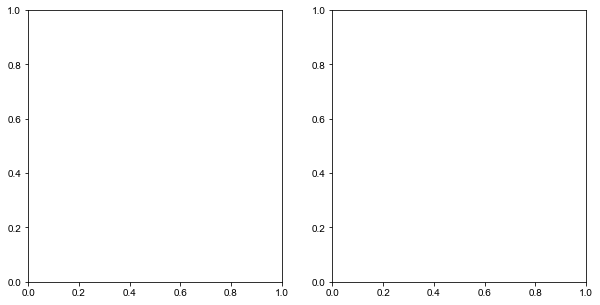

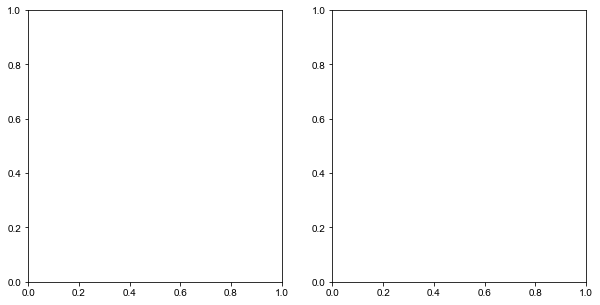

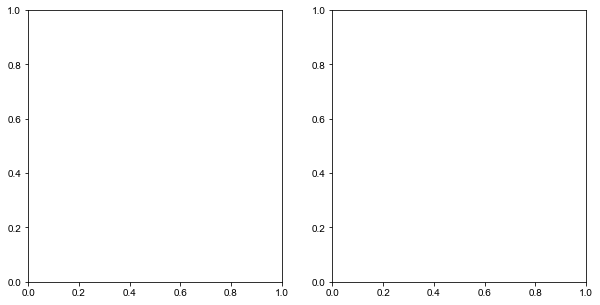

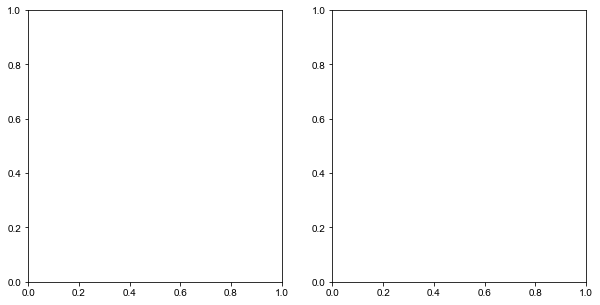

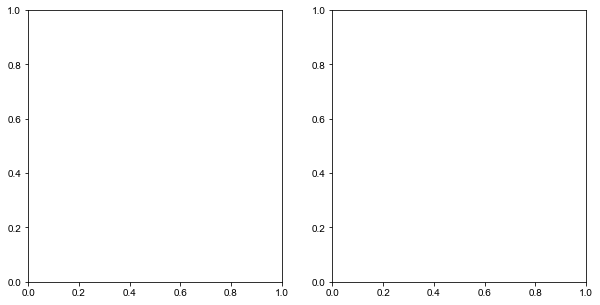

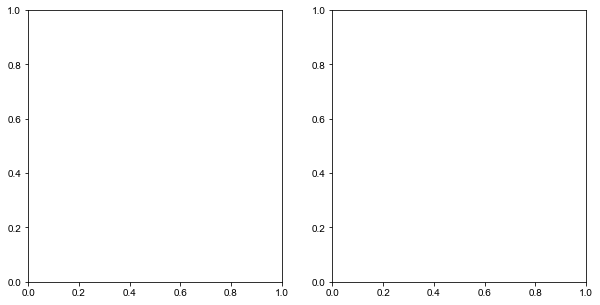

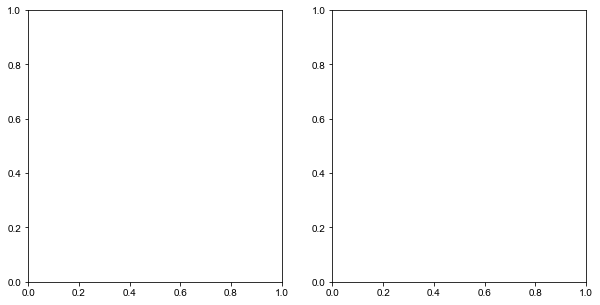

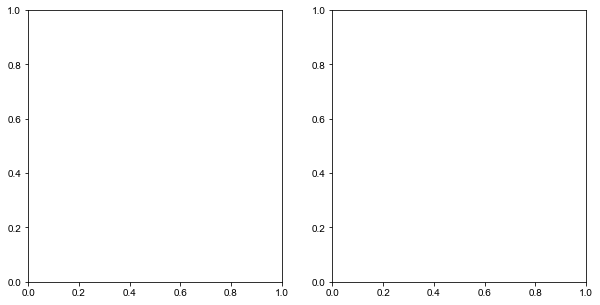

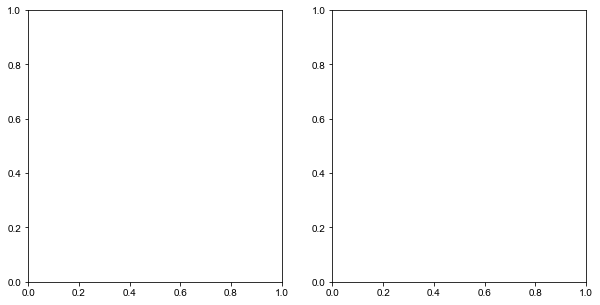

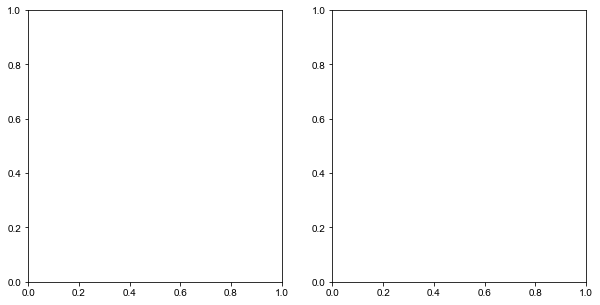

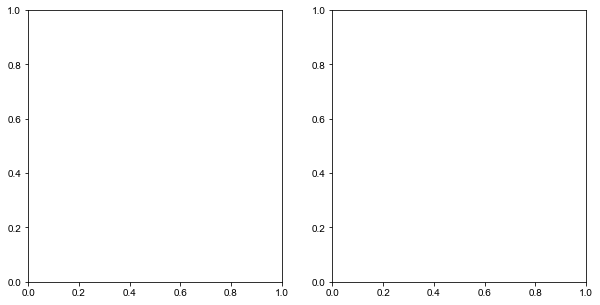

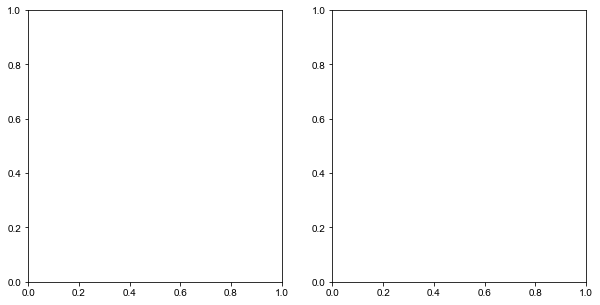

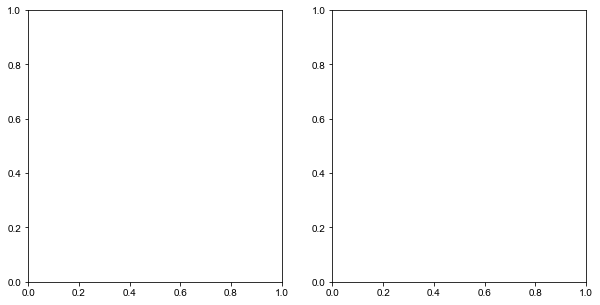

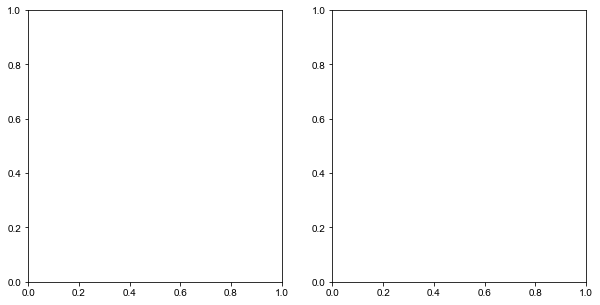

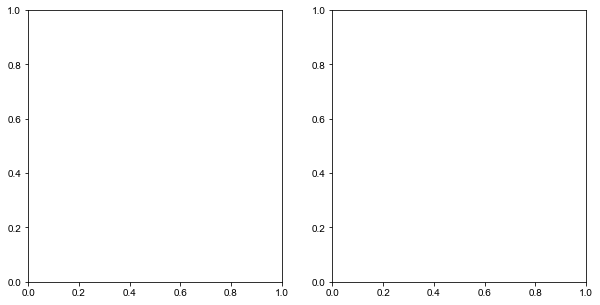

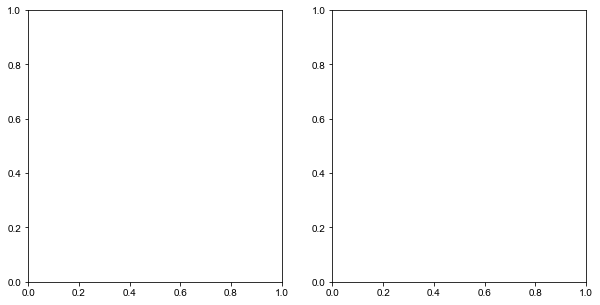

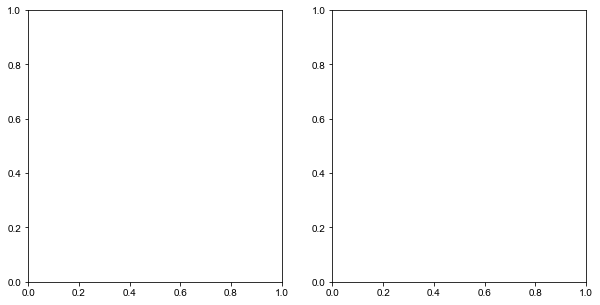

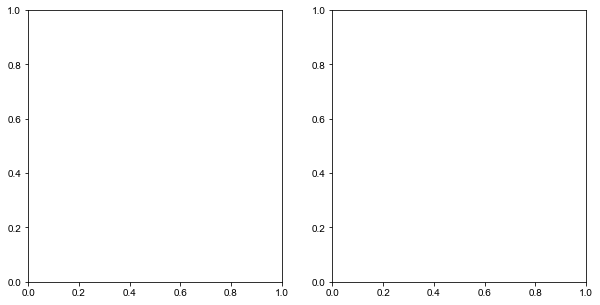

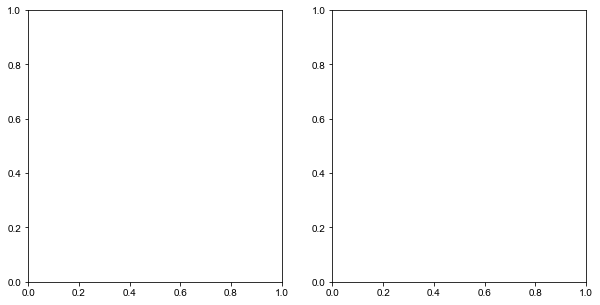

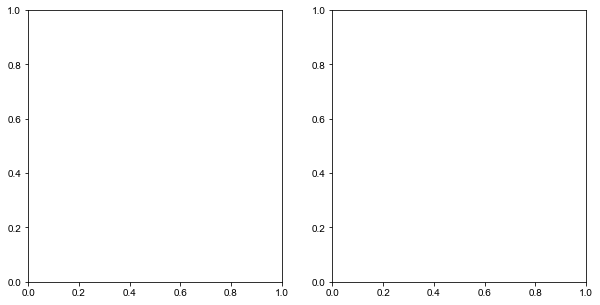

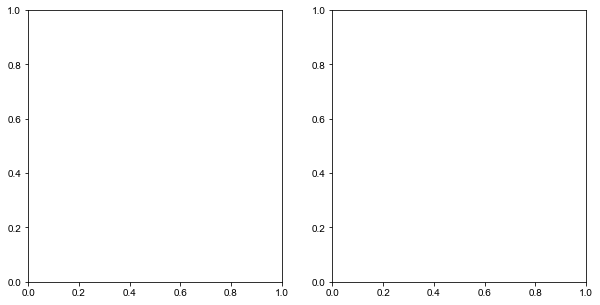

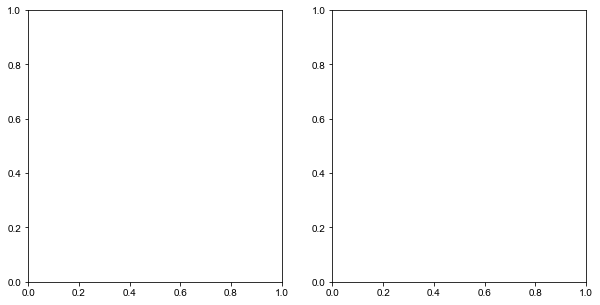

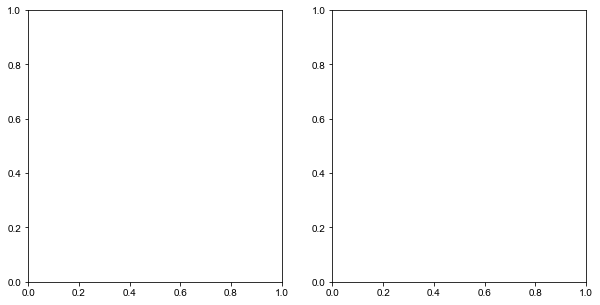

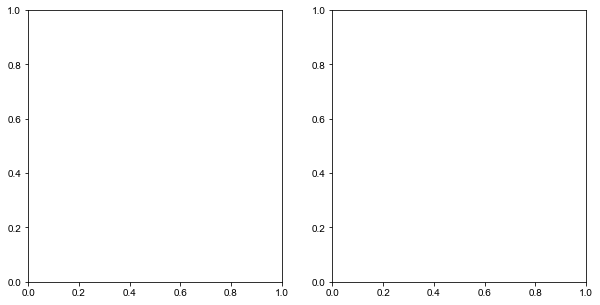

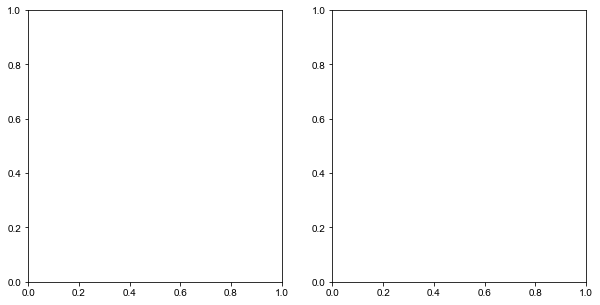

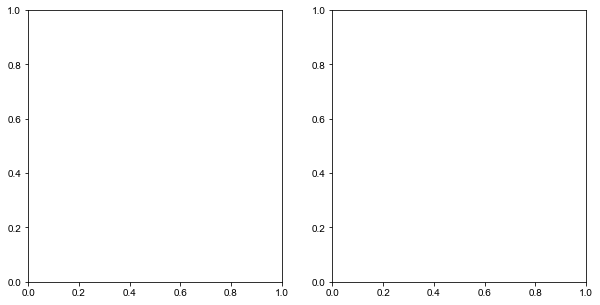

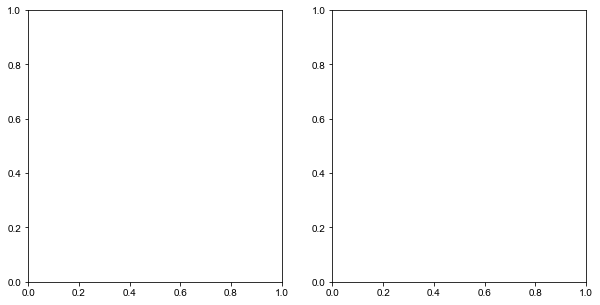

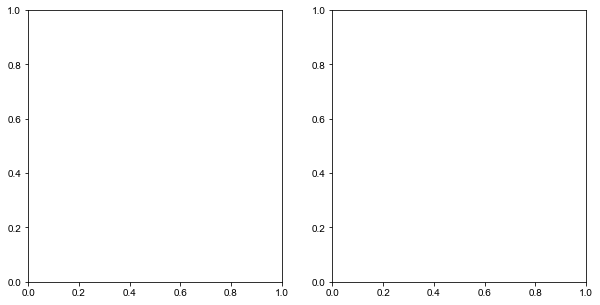

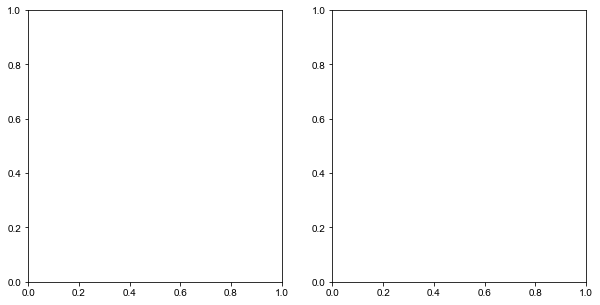

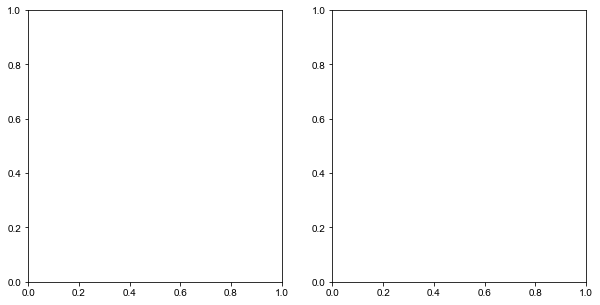

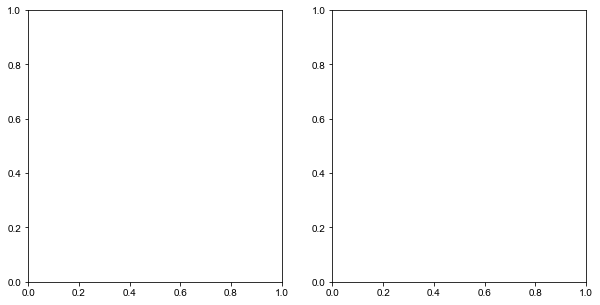

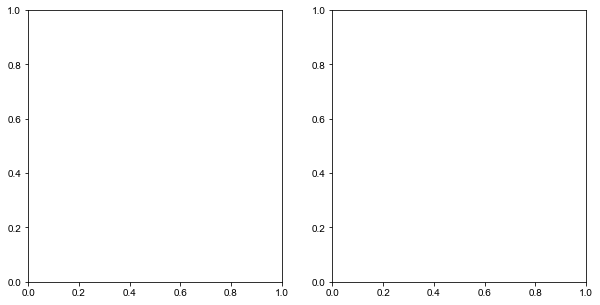

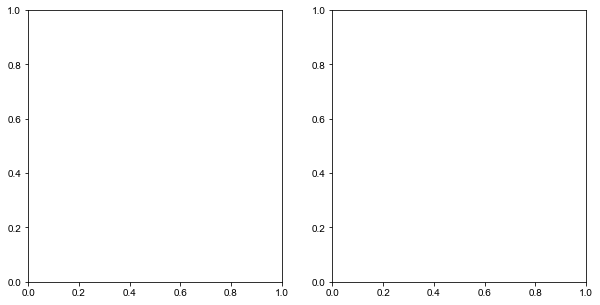

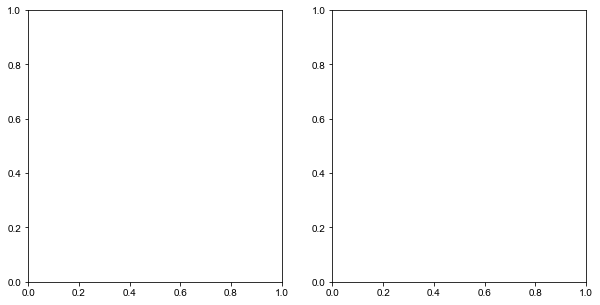

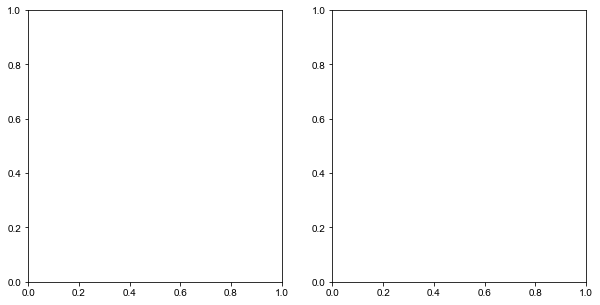

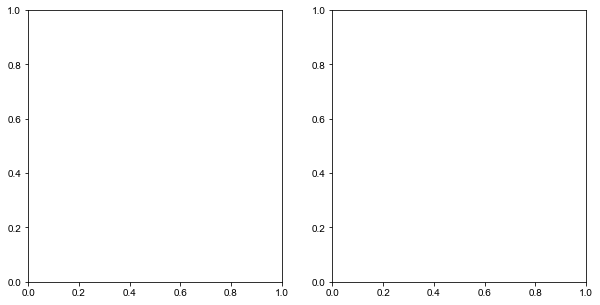

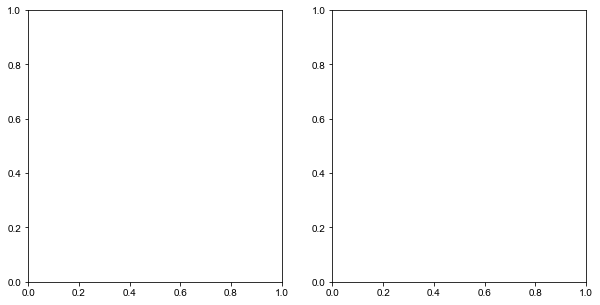

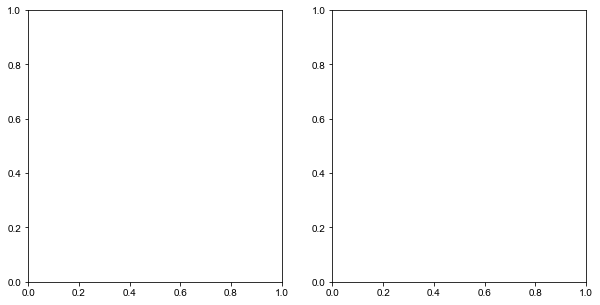

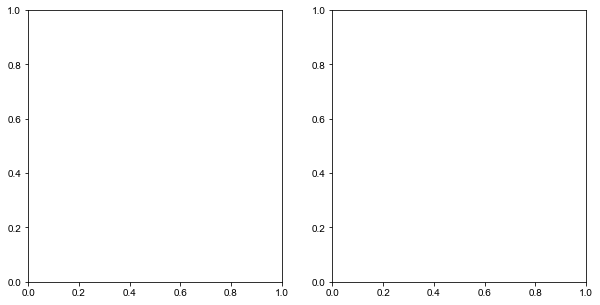

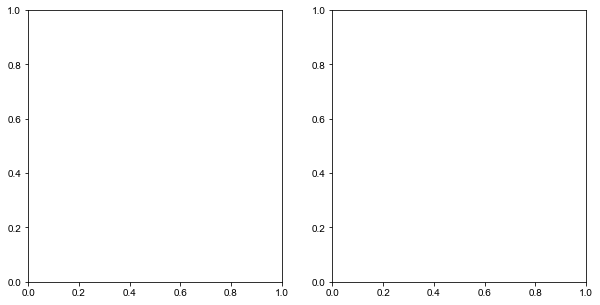

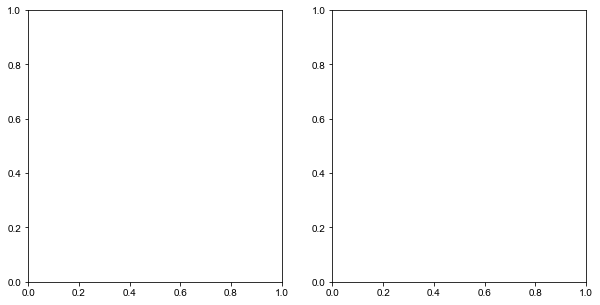

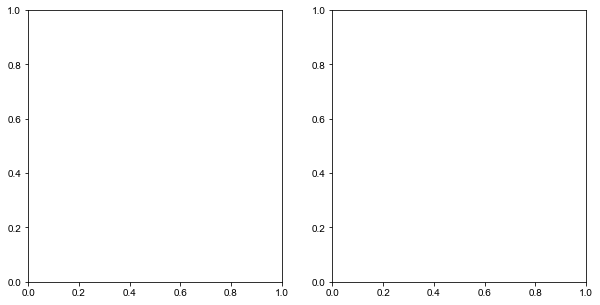

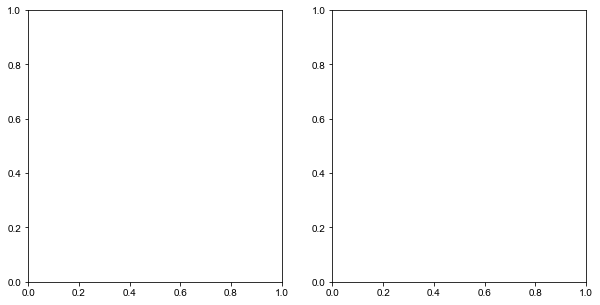

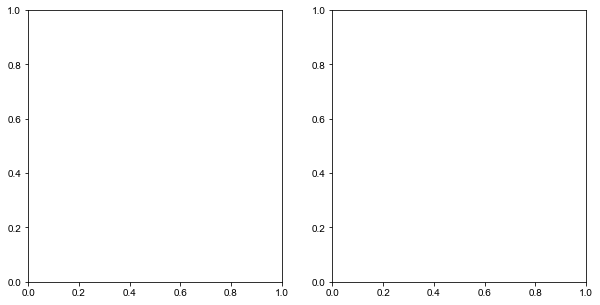

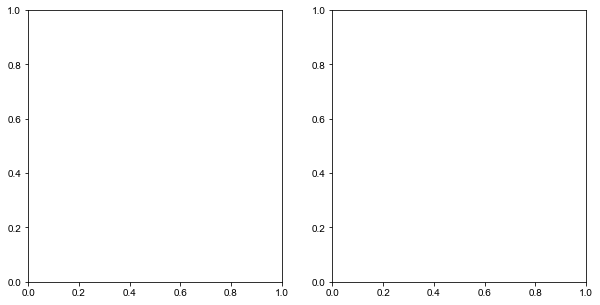

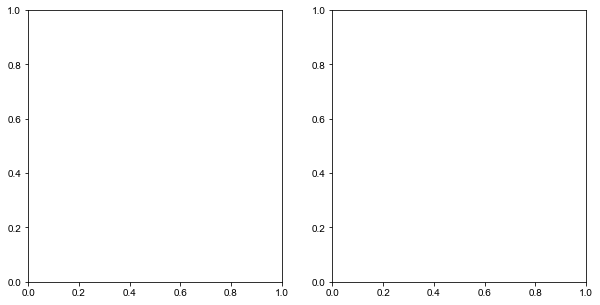

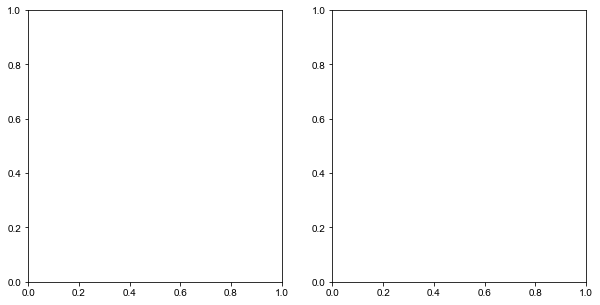

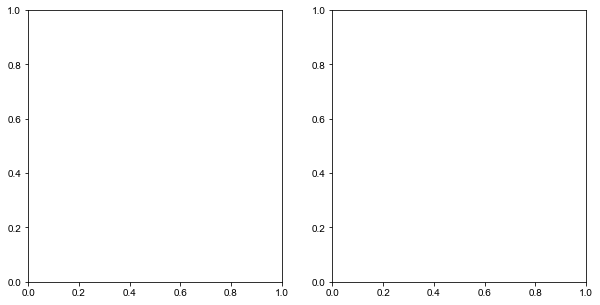

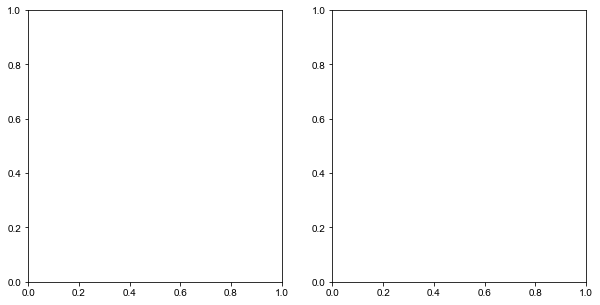

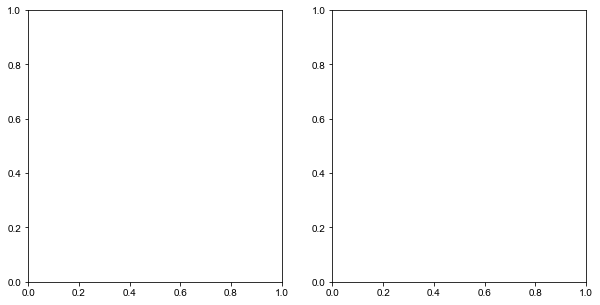

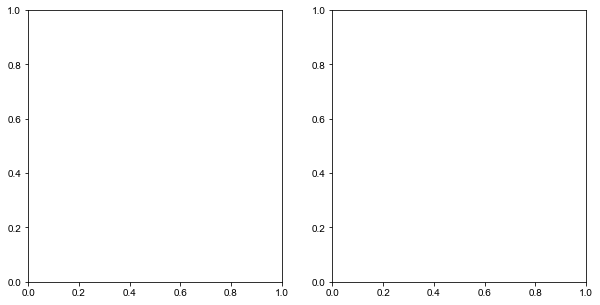

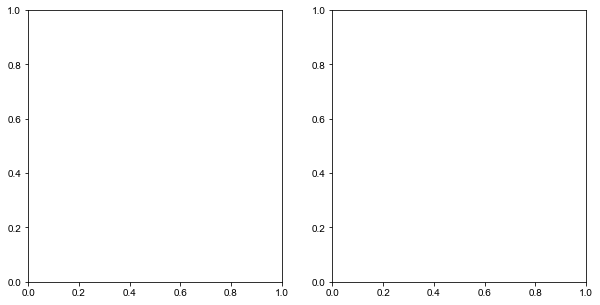

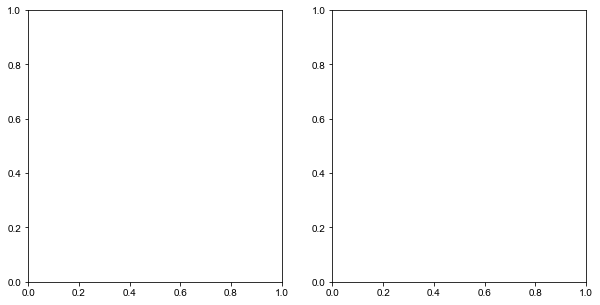

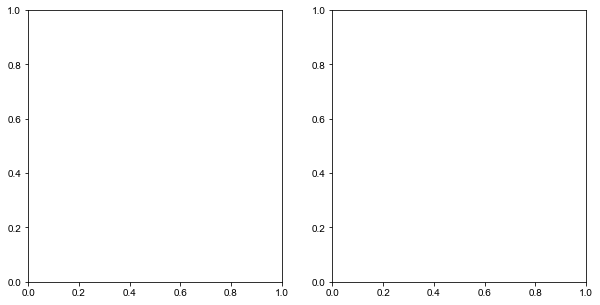

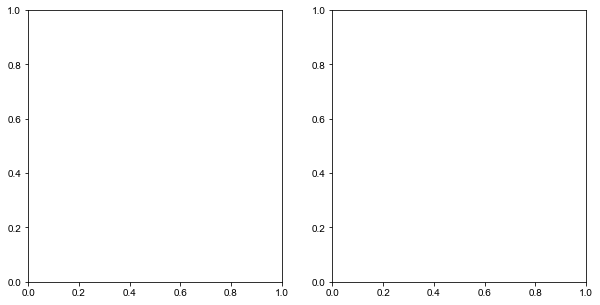

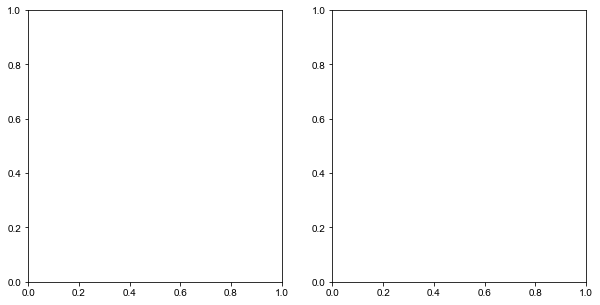

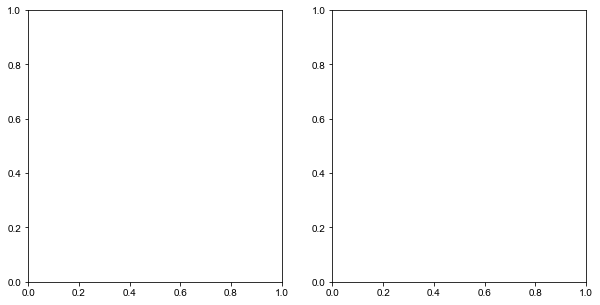

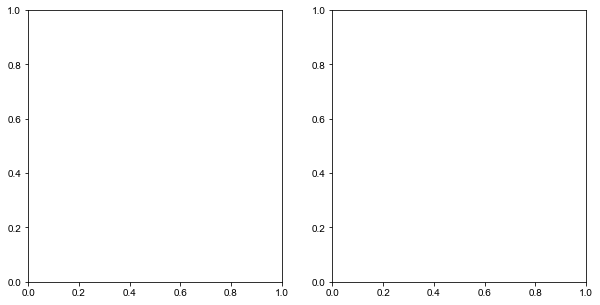

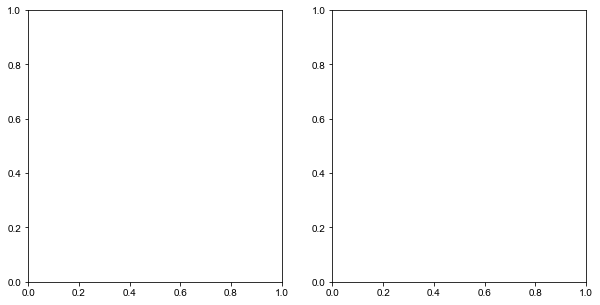

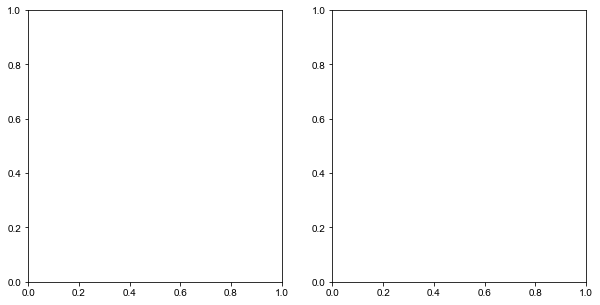

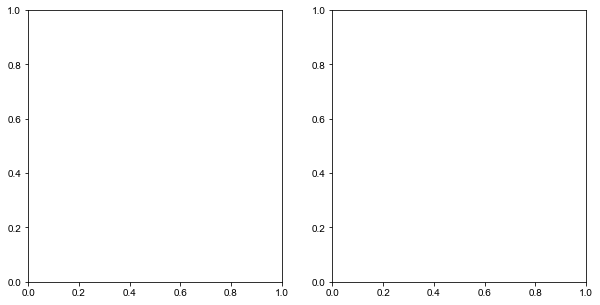

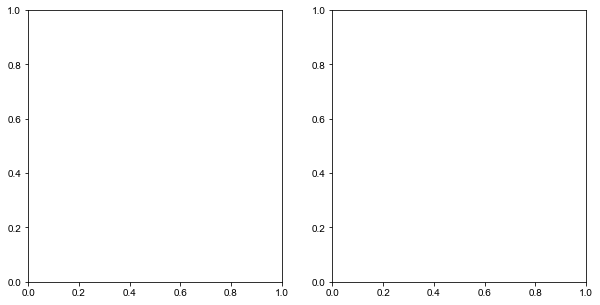

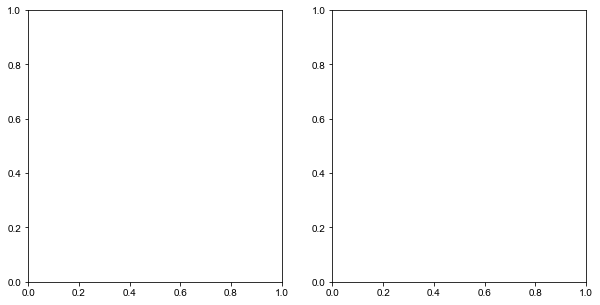

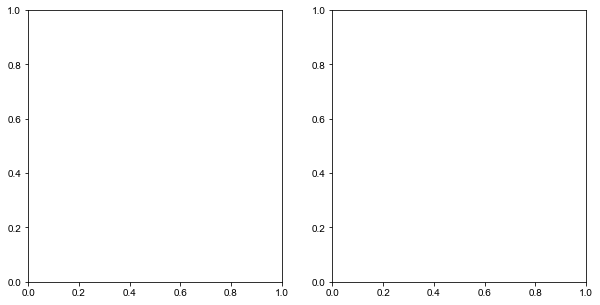

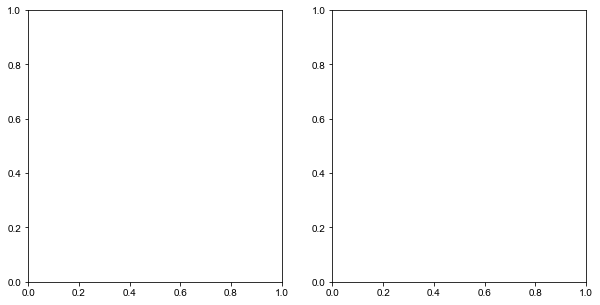

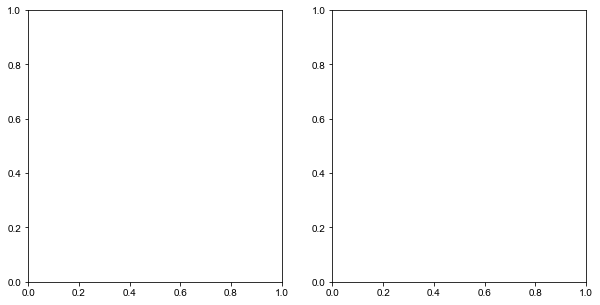

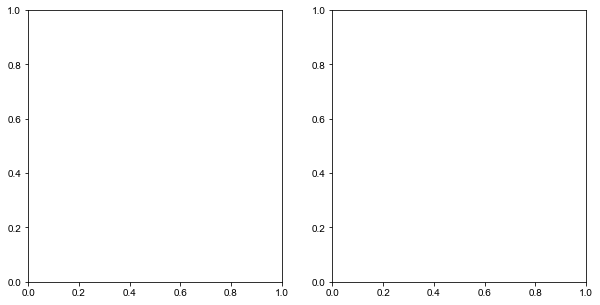

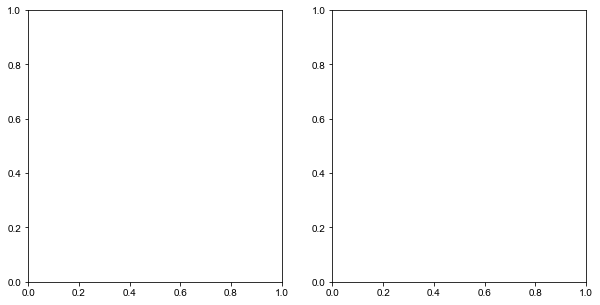

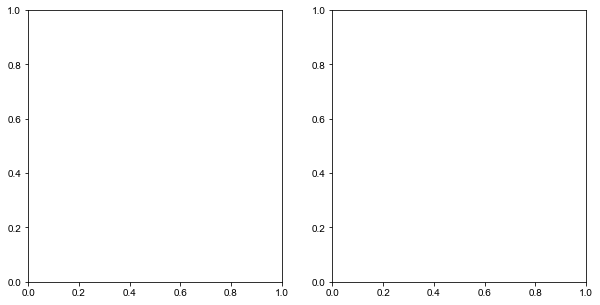

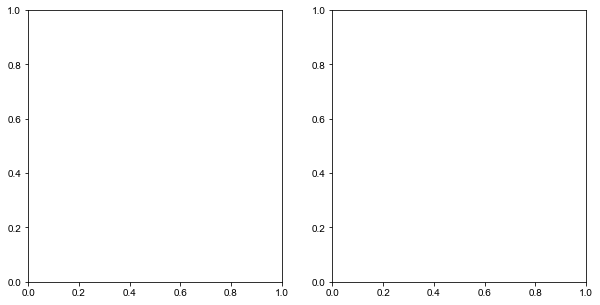

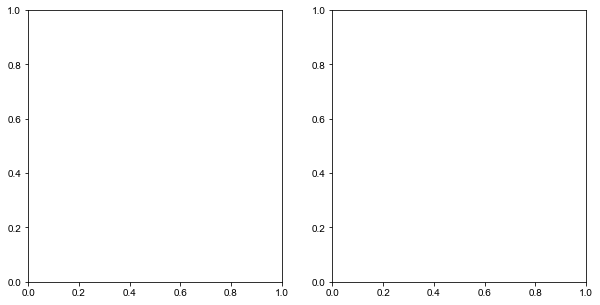

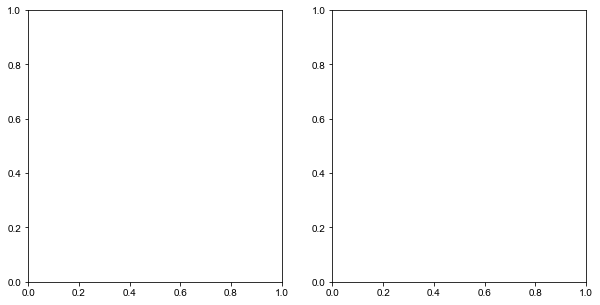

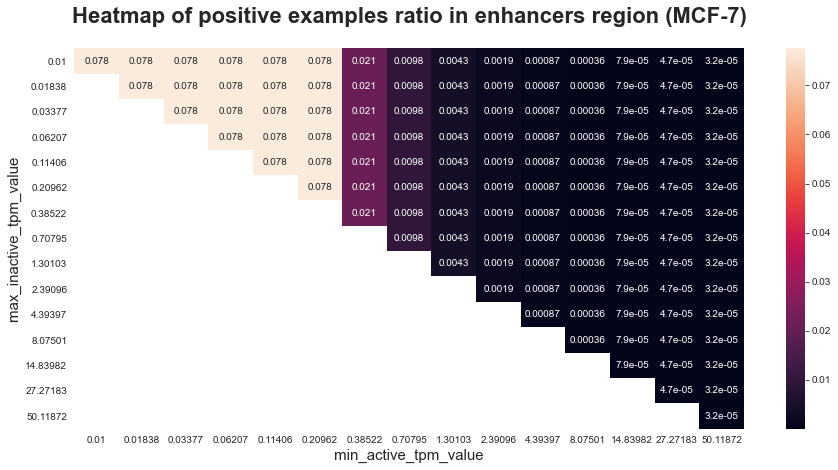

None

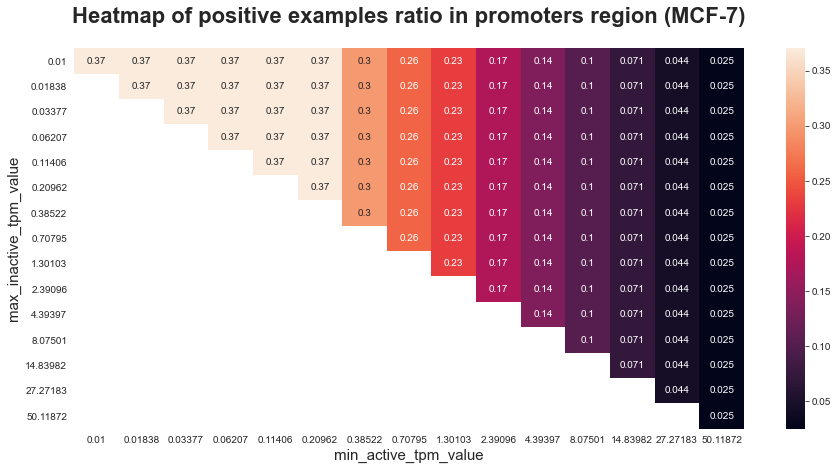

None

In [19]:
for cell_line in tqdm(
    ("A549", "GM12878", "H1", "HEK293", "HepG2", "K562", "MCF-7"),
    #("K562", ),
    desc="Analyzing cell line",
    leave=False
):
    results = evaluate_tpms(param_grid, cell_line)
    plot_heatmaps(results, values, cell_line)

In [23]:
lineplot_dict = {
    "enhancers": dict(),
    "promoters": dict()
}
    

for cell_line in tqdm(
    ("A549", "GM12878", "H1", "HEK293", "HepG2", "K562", "MCF-7"),
    desc="Building lineplot",
    leave=False
):   
    with open(f'imbalance/class_imbalance_{cell_line}.json') as f:
        results = json.load(f)
    
    lineplot_dict["enhancers"][cell_line] = []
    lineplot_dict["promoters"][cell_line] = []
    
    for region in ("enhancers", "promoters"):
        for (d, neg, pos, nneg, npos) in results[region].values():
            if d["max_inactive_tpm_value"] == 0.01:
                lineplot_dict[region][cell_line].append(pos)
        

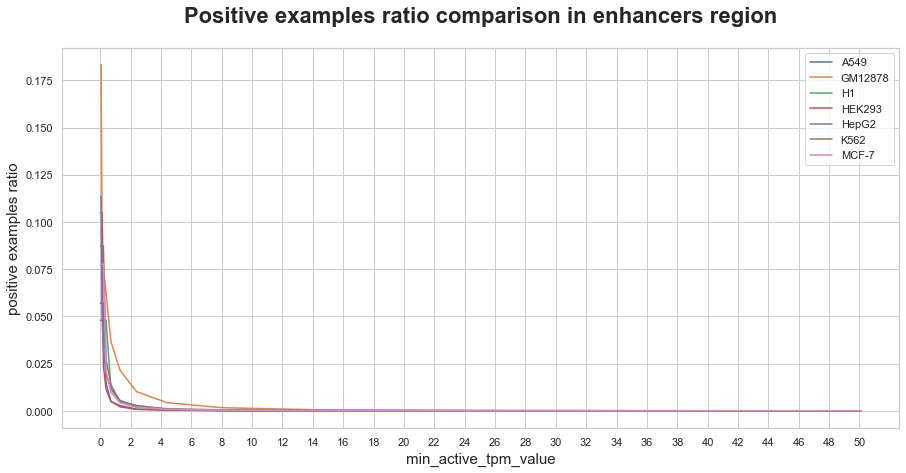

None

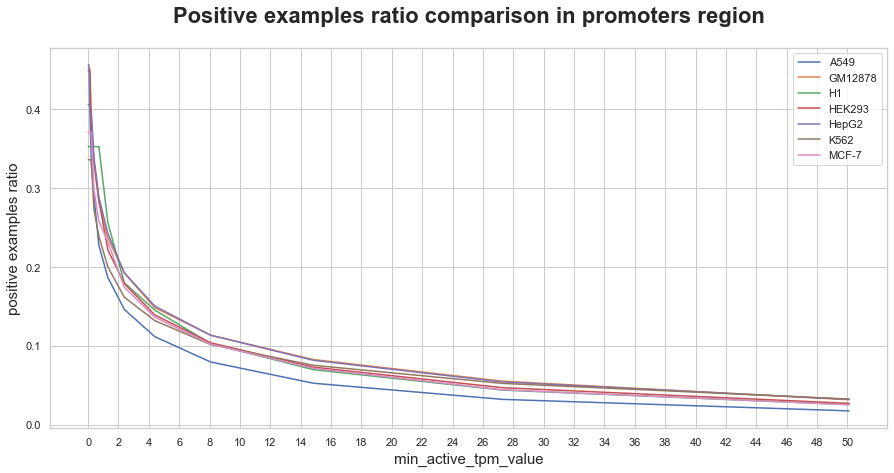

None

In [65]:
for region in ("enhancers", "promoters"):
    lineplot_df = pd.DataFrame(
        lineplot_dict[region].values(), 
        index=lineplot_dict[region].keys(), 
        columns=values.round(5)
    ).T
    
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(figsize=(15, 7))
        ax = sns.lineplot(data=lineplot_df, dashes=False)
        ax.set_xticks(np.arange(0, 51, 2))
        
        """
        if region == "enhancers":
            ax.set_yticks(np.arange(0, 0.17, 0.007))
        """

        plt.title(f"Positive examples ratio comparison in {region} region", fontsize=22, y=1.05,  weight='bold')
        plt.ylabel('positive examples ratio', fontsize=15) 
        plt.xlabel('min_active_tpm_value', fontsize=15)
        plt.savefig(f"imbalance/lineplot_{region}.png")
        display(plt.show())